In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
import os
from prettytable import PrettyTable
from pylab import *
from scipy.stats import wasserstein_distance
import random
import csv
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
sub_features = ['42 tGravityAcc-mean()-Y',
 '43 tGravityAcc-mean()-Z',
 '51 tGravityAcc-max()-Y',
 '52 tGravityAcc-max()-Z',
 '54 tGravityAcc-min()-Y',
 '55 tGravityAcc-min()-Z',
 '56 tGravityAcc-sma()',
 '59 tGravityAcc-energy()-Z',
 '125 tBodyGyro-std()-Y',
 '128 tBodyGyro-mad()-Y',
 '138 tBodyGyro-energy()-Y',
 '165 tBodyGyroJerk-std()-Y',
 '168 tBodyGyroJerk-mad()-Y',
 '178 tBodyGyroJerk-energy()-Y',
 '181 tBodyGyroJerk-iqr()-Y',
 '425 fBodyGyro-mean()-Y',
 '428 fBodyGyro-std()-Y',
 '431 fBodyGyro-mad()-Y',
 '441 fBodyGyro-energy()-Y',
 '475 fBodyGyro-bandsEnergy()-1,8',
 '478 fBodyGyro-bandsEnergy()-25,32',
 '483 fBodyGyro-bandsEnergy()-1,16',
 '487 fBodyGyro-bandsEnergy()-1,24',
 '559 angle(X,gravityMean)',
 '560 angle(Y,gravityMean)',
 '561 angle(Z,gravityMean)']

act_features = ['4 tBodyAcc-std()-X',
 '7 tBodyAcc-mad()-X',
 '10 tBodyAcc-max()-X',
 '17 tBodyAcc-energy()-X',
 '202 tBodyAccMag-std()',
 '204 tBodyAccMag-max()',
 '215 tGravityAccMag-std()',
 '217 tGravityAccMag-max()',
 '266 fBodyAcc-mean()-X',
 '269 fBodyAcc-std()-X',
 '272 fBodyAcc-mad()-X',
 '275 fBodyAcc-max()-X',
 '282 fBodyAcc-energy()-X',
 '303 fBodyAcc-bandsEnergy()-1,8',
 '311 fBodyAcc-bandsEnergy()-1,16',
 '315 fBodyAcc-bandsEnergy()-1,24',
 '504 fBodyAccMag-std()',
 '505 fBodyAccMag-mad()',
 '506 fBodyAccMag-max()',
 '509 fBodyAccMag-energy()']

input_shape = len(sub_features) + len(act_features)

In [3]:
# sub_features = ['43 tGravityAcc-mean()-Z',
#  '52 tGravityAcc-max()-Z',
#  '54 tGravityAcc-min()-Y',
#  '55 tGravityAcc-min()-Z',
#  '56 tGravityAcc-sma()',
#  '59 tGravityAcc-energy()-Z',
#  '125 tBodyGyro-std()-Y',
#  '128 tBodyGyro-mad()-Y',
#  '138 tBodyGyro-energy()-Y',
#  '425 fBodyGyro-mean()-Y',
#  '441 fBodyGyro-energy()-Y',
#  '475 fBodyGyro-bandsEnergy()-1,8',
#  '483 fBodyGyro-bandsEnergy()-1,16',
#  '559 angle(X,gravityMean)',
#  '561 angle(Z,gravityMean)']

# act_features = ['4 tBodyAcc-std()-X',
#  '10 tBodyAcc-max()-X',
#  '202 tBodyAccMag-std()',
#  '215 tGravityAccMag-std()',
#  '269 fBodyAcc-std()-X',
#  '282 fBodyAcc-energy()-X',
#  '303 fBodyAcc-bandsEnergy()-1,8',
#  '311 fBodyAcc-bandsEnergy()-1,16',
#  '315 fBodyAcc-bandsEnergy()-1,24',
#  '504 fBodyAccMag-std()',
#  '505 fBodyAccMag-mad()',
#  '509 fBodyAccMag-energy()']

# input_shape = len(act_features) + len(sub_features)

### Move Working Directory

In [4]:
# MaryClare's
#os.chdir('/Users/maryclaremartin/Documents/jup/ExtraSensory')

# Josh's
#os.chdir("D:/Research_Projects/REU2021-human-context-recognition/UCI_data")

# Harrison's
os.chdir("/Users/hkimr/Desktop/WPI Github/REU2021-human-context-recognition/UCI_data")

#os.chdir('../')
softmax = nn.Softmax(dim = 1)

### Load & Scale Data

In [5]:
##load and scale data
#returns scaled data (X) and labels (Y)
#label: array, list of activities to use (represented by integers)
#users: array, list of users whose data is to be used (represented by integers)

def start_data(label, users, sub_features, act_features):
    #get the dataframe column names
    name_dataframe = pd.read_csv('data/features.txt', delimiter = '\n', header = None)
    names = name_dataframe.values.tolist()
    names = [k for row in names for k in row] #List of column names

    data = pd.read_csv('data/X_train.txt', delim_whitespace = True, header = None) #Read in dataframe
    data.columns = names #Setting column names

    #X_train = data.loc[:,'1 tBodyAcc-mean()-X':'40 tBodyAcc-correlation()-Y,Z'] #Selecting only acceleration columns
    
    #X_train_1 = data.loc[:,'1 tBodyAcc-mean()-X':'40 tBodyAcc-correlation()-Y,Z']
    #X_train_2 = data.loc[:,'81 tBodyAccJerk-mean()-X':'160 tBodyGyro-correlation()-Y,Z']
    X_train_1 = data[sub_features]
    X_train_2 = data[act_features]
    X_train = pd.concat([X_train_1, X_train_2], axis = 1)
    
    y_train_activity = pd.read_csv('data/y_train.txt', header = None)
    y_train_activity.columns = ['Activity']

    y_train_subject = pd.read_csv('data/subject_train.txt', header = None)
    y_train_subject.columns = ['Subject']

    GAN_data = pd.concat([X_train, y_train_activity, y_train_subject], axis = 1)
    GAN_data = GAN_data[GAN_data['Activity'].isin(label)]
    GAN_data = GAN_data[GAN_data['Subject'].isin(users)]
    
    X = GAN_data.iloc[:, :-2].values
    #X = GAN_data.loc[:,'1 tBodyAcc-mean()-X':'160 tBodyGyro-correlation()-Y,Z'].values
    y = GAN_data[['Activity']].values
    
    return X, y

### The Generator

In [6]:
#defines each generator layer
#input and output dimensions needed
def generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace = True)
    )

#returns n_samples of z_dim (number of dimensions of latent space) noise
def get_noise(n_samples, z_dim):
    return torch.randn(n_samples, z_dim).to(device)

#defines generator class
class Generator(nn.Module):
    def __init__(self, z_dim = 10, feature_dim = input_shape, hidden_dim = 128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            generator_block(z_dim, 80),
            generator_block(80, 60),
            generator_block(60, 50),
            nn.Linear(50, feature_dim),
            nn.Tanh()
        )
    def forward(self, noise):
        return self.gen(noise)

##calculates generator loss
#gen: generator
#disc: discriminator
#criterion1: loss function1
#criterion2: loss function2
#batch_size: batch size
#z_dim: number of dimensions in the latent space
def get_gen_loss(gen, disc, act, usr, criterion1, criterion2, batch_size, z_dim, activities, users):
    latent_vectors = get_noise(batch_size, z_dim)
    act_vectors = get_act_matrix(batch_size, activities)
    usr_vectors = get_usr_matrix(batch_size, users)
    
    to_gen = torch.cat((latent_vectors, act_vectors[1], usr_vectors[1]), 1)
    fake_features = gen(to_gen)
    
    disc.eval()
    pred_disc = disc(fake_features)
    disc.train()
    pred_act = act(fake_features) ### CrossEntropyLoss Criterion automatically applies softmax and torch.max
    pred_usr = usr(fake_features)
    
    d_loss = criterion1(pred_disc, torch.ones_like(pred_disc))
    act_loss = criterion2(pred_act, act_vectors[0])
    usr_loss = criterion2(pred_usr, usr_vectors[0])
    
    gen_loss = d_loss + act_loss + usr_loss
    return gen_loss
    
def get_act_matrix(batch_size, a_dim):
    indexes = np.random.randint(a_dim, size = batch_size)
    
    one_hot = np.zeros((len(indexes), indexes.max()+1))
    one_hot[np.arange(len(indexes)),indexes] = 1
    return torch.Tensor(indexes).long().to(device), torch.Tensor(one_hot).to(device)
    
def get_usr_matrix(batch_size, u_dim):
    indexes = np.random.randint(u_dim, size = batch_size)
    
    one_hot = np.zeros((indexes.size, indexes.max()+1))
    one_hot[np.arange(indexes.size),indexes] = 1
    return torch.Tensor(indexes).long().to(device), torch.Tensor(one_hot).to(device)

### Create Fake Generated Samples

In [7]:
def get_fake_samples(gen, batch_size, z_dim):
    """
    Generates fake acceleration features given a batch size, latent vector dimension, and trained generator.
    
    """
    latent_vectors = get_noise(batch_size, z_dim) ### Retrieves a 2D tensor of noise
    gen.eval()
    fake_features = gen(latent_vectors)
    gen.train()
    return fake_features ### Returns a 2D tensor of fake features of size batch_size x z_dim

### The Discriminator

In [8]:
def discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.LeakyReLU(0.05)
    )

#defines discriminator class
class Discriminator(nn.Module):
    def __init__(self, feature_dim = input_shape, hidden_dim = 16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            discriminator_block(feature_dim, 25),
            discriminator_block(25, 10),
            nn.Linear(10, 1),
            #nn.Linear(feature_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, feature_vector):
        return self.disc(feature_vector)
    
def get_disc_loss(gen, disc, criterion, real_features, batch_size, z_dim, a_dim, u_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    act_vectors = get_act_matrix(batch_size, a_dim)
    usr_vectors = get_usr_matrix(batch_size, u_dim)
    
    to_gen = torch.cat((latent_vectors, act_vectors[1], usr_vectors[1]), 1)
    gen.eval()
    fake_features = gen(to_gen)
    gen.train()
    pred_fake = disc(fake_features.detach())
    
    ground_truth = torch.zeros_like(pred_fake)
    loss_fake = criterion(pred_fake, ground_truth)
    
    pred_real = disc(real_features)
    ground_truth = torch.ones_like(pred_real)
    loss_real = criterion(pred_real, ground_truth)
    
    disc_loss = (loss_fake + loss_real) / 2
    return disc_loss

### User Classifier

In [9]:
def classifier_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.LeakyReLU(0.05)
    )

class User_Classifier(nn.Module):
    def __init__(self, feature_dim = input_shape):
        super(User_Classifier, self).__init__()
        self.network = nn.Sequential(
            classifier_block(feature_dim, 25),
            classifier_block(25, 20),
            classifier_block(20, 20),
            classifier_block(20, 10),
            nn.Linear(10, 3)
        )
    def forward(self, x):
        return self.network(x)

### Activity Classifier

In [10]:
def classifier_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.LeakyReLU(0.05)
    )

class Activity_Classifier(nn.Module):
    def __init__(self, feature_dim = input_shape):
        super(Activity_Classifier, self).__init__()
        self.network = nn.Sequential(
            classifier_block(feature_dim, 25),
            classifier_block(25, 20),
            classifier_block(20, 15),
            classifier_block(15, 10),
            nn.Linear(10, 3)
        )
    def forward(self, x):
        return self.network(x)

### Calculate Performance Statistics

In [11]:
##calculates performance statistics for each epoch of training
#gen: generator
#disc: discriminator
#b_size: batch size
#z_dim: number of dimensions of the latent space
##returns accuracy, precision, recall, fpR, and f1 score
def performance_stats(gen, disc, b_size, z_dim, a_dim, u_dim, batch = None):
    tp = 0 #true positive
    fp = 0 #false positive
    tn = 0 #true negative
    fn = 0 #false negative

    with torch.no_grad():
        y_hat_fake = torch.Tensor([0])
        y_hat_real = torch.Tensor([0])
        
        if batch is None:
            latent_vectors = get_noise(b_size, z_dim)
            act_vectors = get_act_matrix(b_size, a_dim)
            usr_vectors = get_usr_matrix(b_size, u_dim)
            to_gen = torch.cat((latent_vectors, act_vectors[1], usr_vectors[1]), 1)
            gen.eval()
            fake_features = gen(to_gen)
            gen.train()
            disc.eval()
            y_hat_fake = torch.round(disc(fake_features))
            disc.train()
        else:
            latent_vectors = get_noise(b_size, z_dim)
            act_vectors = get_act_matrix(b_size, a_dim)
            usr_vectors = get_usr_matrix(b_size, u_dim)
            to_gen = torch.cat((latent_vectors, act_vectors[1], usr_vectors[1]), 1)
            gen.eval()
            fake_features = gen(to_gen)
            gen.train()
            disc.eval()
            y_hat_fake = torch.round(disc(fake_features))
            y_hat_real = torch.round(disc(batch))
            disc.train()
         
        fpR = torch.mean(y_hat_fake)
        recall = torch.mean(y_hat_real)
        class_acc = ((len(y_hat_fake) - torch.sum(y_hat_fake)) + torch.sum(y_hat_real)) / (2*b_size)
        #print(f'Classification Accuracy: {class_acc:.2f}'
        #print(f'Recall: {recall:.2f}') #What percent of the true positives were identified
        return class_acc, recall, fpR
      

def performance_stats_class(gen, a_class, u_class, batch_size, z_dim, a_dim, u_dim):
    tp = 0 #true positive
    fp = 0 #false positive
    tn = 0 #true negative
    fn = 0 #false negative

    with torch.no_grad():
        latent_vectors = get_noise(batch_size, z_dim)
        act_vectors = get_act_matrix(batch_size, a_dim)
        usr_vectors = get_usr_matrix(batch_size, u_dim)
    
        to_gen = torch.cat((latent_vectors, act_vectors[1], usr_vectors[1]), 1)
        gen.eval()
        fake_features = gen(to_gen)
        gen.train()
    
        _, pred_a_class = torch.max(softmax(a_class(fake_features)), dim = 1)
        _, pred_u_class = torch.max(softmax(u_class(fake_features)), dim = 1)
        
        return torch.eq(act_vectors[0], pred_a_class).sum()/batch_size, torch.eq(usr_vectors[0], pred_u_class).sum()/batch_size

### Initialize Training Environment

In [12]:
###initalize parameters that depend on training loop parameters
#X: acceleration data
#y: labels associated with X data (fake or real)
#z_dim: number of dimensions to the latent space
#disc_lr: discriminator learning rate
#gen_lr: generator learning rate
#DISCRIMINATOR: 1 to indicate if discriminator is training
#batch_size: batch size
#disc: initialized discrimiantor

def initialize_params(X, y, z_dim, a_dim, u_dim, disc_lr, gen_lr, DISCRIMINATOR, batch_size, disc):
    #initialize generator
    gen = Generator(z_dim + a_dim + u_dim).to(device)
    #indicate that discriminator is training
    to_train = DISCRIMINATOR
    #create training features
    train_features = torch.tensor(X)
    #create training labels
    train_labels = torch.tensor(y)
    #concatenate to create training data
    train_data = torch.utils.data.TensorDataset(train_features, train_labels)
    #create data loader for training data
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
    #initialize generator and discriminator optimizers
    opt_disc = optim.Adam(disc.parameters(), lr = disc_lr)
    opt_gen = optim.Adam(gen.parameters(), lr = gen_lr)
    
    return gen, to_train, train_features, train_labels, train_data, train_loader, opt_disc, opt_gen   

# Save / Load Models

In [13]:
# Change path and name of the Generator and Discriminator accordingly
def save_model(gen, disc, model_name):
    torch.save(gen.state_dict(), f"saved_models/{model_name}_gen.param")
    torch.save(disc.state_dict(), f"saved_models/{model_name}_disc.param")
    
def load_model(model, model_name):
    model.load_state_dict(torch.load(f'saved_models/{model_name}'))

# Training

In [14]:
######Training loop to train GAN

#Parameters to specifiy: 
    #X: starting accelerometer data
    #y: starting labels for X data (fake or real)
    
#Set parameters (do not change)
    #criterion: loss function (BCE)
    #dig: number of significant digits for printing (5)
    #feature_dim: Number of dimensions of output from generator (26)
    #GENERATOR: set generator to zero for training
    #DISCRIMINATOR: set discriminator to one for training
    #train_string: starting machine to train (DISC)
    #disc: initalize discriminator
    #rel_epochs: Epochs passed since last switch (constant training) (0)
    #rows: initialization of array to save data of each epoch to CSV file ([])
    #heading: array of column headings for table (["Epoch", "Machine Training", "Discriminator Loss", 
                    #"Generator Loss", "FPR", "Recall", "Median Wasserstein", "Mean Wasserstein"])
    #table: intialize a table as a pretty table to save epoch data
    #switch_count: number of switches in dynamic training (0)
    
#Set parameters (can change):
    #z_dim: number of dimensions of latent vector (100)
    #gen_lr: generator learning rate (.001)
    #disc_lr: discriminator learning rate (.001) (shoud be equal to gen_lr)
    #batch_size: batch size (75)
    #print_batches: Show model performance per batch (False)
    #n_epochs: number of epochs to train (100)
    #constant_train_flag: (False)
        #Set to true to train based on constant # of epochs per machine 
        #Set to false to train dynamically based on machine performance
        
    #Constant training approach:
        #disc_epochs: Number of consecutive epochs to train discriminator before epoch threshold (5)
        #gen_epochs: Number of consecutive epochs to train generator before epoch threshold (2)
        #epoch_threshold: Epoch number to change training epoch ratio (50)
        #disc_epochs_change: New number of consecutive epochs to train discriminator after epoch threshold is exceeded (1)
        #gen_epochs_change: New number of consecutive epochs to train generator after epoch threshold is exceeded (50)
    
    #Dynamic training approach:                        
        #static_threshold: Epoch number to change from static ratio to dynamic (18)
        #static_disc_epochs: Number of consecutive epochs to train discriminator before epoch threshold (4)
        #static_gen_epochs: Number of consecutive epochs to train generator before epoch threshold (2)
        #pull_threshold: Accuracy threshold for switching machine training when the generator is no longer competitive (0.4)
        #push_threshold: Accuracy threshold for switching machine training when the discriminator is no longer competitive (0.6)
        #recall_threshold: threshold for recall to switch machine training when discriminator is training well
        #switch_flag: indicates if we should switch our training machine (False)
        
def training_loop(X, y, act, usr, criterion1 = nn.BCELoss(), criterion2 = nn.CrossEntropyLoss(), gan_id = "Mod Test Gan", dig = 5, feature_dim = input_shape, 
                  GENERATOR = 0, DISCRIMINATOR = 1, train_string = "DISC", disc = Discriminator(), z_dim = 100, a_dim = 3, u_dim = 3, 
                  gen_lr =  0.001, disc_lr = 0.001, batch_size = 100, constant_train_flag = False, disc_epochs = 5,
                  gen_epochs = 2, epoch_threshold = 50, disc_epochs_change = 5, gen_epochs_change = 2, rel_epochs = 0,
                 static_threshold = 28, static_disc_epochs = 5, static_gen_epochs = 2, pull_threshold = 0.3,
                 push_threshold = 0.7, recall_threshold = 0.75, n_epochs = 1000, rows = [],
                 heading = ["Epoch", "Training", "Discriminator Loss", "Generator Loss", "D_Accuracy", "D_fpR", "D_Recall", "A_fpR", "U_fpR"],
                 table = PrettyTable(), switch_flag = False, switch_count = 0, last_real_features = []):
    
    disc.to(device)
    #returns generator, sets discriminator training, creates training tensor, loads data, and initializes optimizers
    gen, to_train, train_features, train_labels, train_data, train_loader, opt_disc, opt_gen = initialize_params(X, y, z_dim, a_dim, u_dim, disc_lr, gen_lr, DISCRIMINATOR, batch_size, disc)

    #set pretty table field names
    table.field_names = heading
    
    #visualize_gen(X, gen, z_dim, a_dim, u_dim)
    gen_epochs = 0
    
    last_D_loss = -1.0
    last_G_loss = -1.0
    
    mean_mean = []
    mean_median = []
    
    for epoch in range(n_epochs):  
        if constant_train_flag:
            if to_train == DISCRIMINATOR and rel_epochs >= disc_epochs:
                rel_epochs = 0
                to_train = GENERATOR
                train_string = "GEN"

            elif to_train == GENERATOR and rel_epochs >= gen_epochs:
                rel_epochs = 0
                to_train = DISCRIMINATOR
                train_string = "DISC"

            # Change epoch ratio after intial 'leveling out'
            if epoch == epoch_threshold:
                rel_epochs = 0
                to_train = GENERATOR
                train_string = "GEN"

                old_ratio = gen_epochs / disc_epochs
                gen_epochs = gen_epochs_change
                disc_epochs = disc_epochs_change
                new_ratio = gen_epochs / disc_epochs
                print(f'\n\nTraining ratio of G/D switched from {old_ratio:.{dig}f} to {new_ratio:.{dig}f}\n\n')
        else:
            if epoch < static_threshold:
                if to_train == DISCRIMINATOR and rel_epochs >= static_disc_epochs:
                    rel_epochs = 0
                    to_train = GENERATOR
                    train_string = "GEN"

                elif to_train == GENERATOR and rel_epochs >= static_gen_epochs:
                    rel_epochs = 0
                    to_train = DISCRIMINATOR
                    train_string = "DISC"

            else:
                if not switch_flag:
                    print("\nSwitching to Dynamic Training\n")
                    switch_flag = True
                    to_train = DISCRIMINATOR
                    train_string = "DISC"
                if to_train == DISCRIMINATOR and fpR <= pull_threshold and R >= recall_threshold:
                    to_train = GENERATOR
                    train_string = "GEN"
                    print("\nPull Generator\n")
                    switch_count += 1
                if to_train == GENERATOR and fpR >= push_threshold:
                    to_train = DISCRIMINATOR
                    train_string = "DISC"
                    print("\nPush Generator\n")
                    switch_count += 1
                    
        print(f'Epoch[{epoch + 1}/{n_epochs}] Train: {train_string} ', end ='')
        
        for batch_idx, (real_features, _) in enumerate(train_loader):
            #Size of this current batch
            batch_size = len(real_features)
            #Send batch to GPU
            real_features = real_features.float().to(device)
            
            if to_train == DISCRIMINATOR:
                ### Training Discriminator
                #visualize_real_batch(real_features.float())
                opt_disc.zero_grad()
                disc_loss = get_disc_loss(gen, disc, criterion1, real_features, batch_size, z_dim, a_dim, u_dim)
                disc_loss.backward(retain_graph = True)
                opt_disc.step()
                last_D_loss = disc_loss.item()
                # If generator has yet to ever train, run intial evaluation
                if last_G_loss == -1.0:
                    last_G_loss = get_gen_loss(gen, disc, act, usr, criterion1, criterion2, batch_size, z_dim, a_dim, u_dim)
                
            else:
                ### Training Generator
                opt_gen.zero_grad()
                gen_loss = get_gen_loss(gen, disc, act, usr, criterion1, criterion2, batch_size, z_dim, a_dim, u_dim)
                gen_loss.backward()
                opt_gen.step()
                last_G_loss = gen_loss.item()
                # If discriminator has yet to ever train, run intial evaluation
                if last_D_loss == -1.0:
                    last_D_loss = get_disc_loss(gen, disc, criterion1, real_features, batch_size, z_dim, a_dim, u_dim)
                
            if batch_idx == (len(train_loader) - 1):
                acc, R, fpR = performance_stats(gen, disc, batch_size, z_dim, a_dim, u_dim, batch = real_features)
                A_fpR, U_fpR = performance_stats_class(gen, act, usr, batch_size, z_dim, a_dim, u_dim)
                #w_dist = all_Wasserstein_dists(gen, z_dim, feature_dim, real_features.float())
                #median_w_dist = torch.median(w_dist)
                #mean_w_dist = torch.mean(w_dist)
                
                #mean_mean.append(mean_w_dist)
                #mean_median.append(median_w_dist)
                
        mean_mean_w = torch.mean(torch.Tensor(mean_mean)) 
        mean_median_w = torch.mean(torch.Tensor(mean_median))
            
        ### Currently doesn't print Median/Mean Wasserstein --> Change if needed
        print(f'| LossD: {last_D_loss:.{dig}f}, LossG: {last_G_loss:.{dig}f} | Acc: {acc:.{dig}f} | fpR: {fpR:.{dig}f} | R: {R:.{dig}f} | A_fpR: {A_fpR:.{dig}f} | U_fpR: {U_fpR:.{dig}f}')
        row_to_add = [f"{epoch + 1}", train_string, f"{last_D_loss:.{dig}f}", f"{last_G_loss:.{dig}f}", f"{acc:.{dig}f}", f"{fpR:.{dig}f}", f"{R:.{dig}f}", f"{A_fpR:.{dig}f}", f"{U_fpR:.{dig}f}"]
        table.add_row(row_to_add)
        rows.append(row_to_add)
                
        if to_train == GENERATOR:
            gen_epochs += 1
            
        mean_mean.clear()
        mean_median.clear()
        rel_epochs += 1
        
        
    print("\n\nTraining Session Finished")
    print(f"Encountered {switch_count} non-trivial training swaps")
    percent = gen_epochs / n_epochs
    print(f"Trained Generator {gen_epochs} out of {n_epochs} ({percent:.3f})")
    f = open("model_outputs/" + gan_id + ".txt", "w")
    f.write(table.get_string())
    f.close()
    print("Model Results Sucessfully Saved to \"model_outputs/" + gan_id + ".txt\"")

    with open("model_outputs/" + gan_id + ".csv", "w") as csvfile: 
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 
        # writing the fields 
        csvwriter.writerow(heading)
        # writing the data rows 
        csvwriter.writerows(rows)
    print("Model Results Sucessfully Saved to \"model_outputs/" + gan_id + ".csv\"")
    save_model(gen, disc, gan_id)
    print("Generator's Trained Parameters Sucessfully Saved to \"saved_models/" + gan_id + "_gen.param\"")
    print("Discriminators's Trained Parameters Sucessfully Saved to \"saved_models/" + gan_id + "_disc.param\"")
    model_output = pd.read_csv("model_outputs/" + gan_id + ".csv")
    #visualize_gen(X, gen, z_dim)
    # Change path and name of the Generator and Discriminator accordingly
    save_model(gen, disc, gan_id)
    
    return model_output

# Run Training

In [15]:
#X, y = start_data("aggregated_data/aggregated_data.csv", "label:SITTING")
#X, y = start_data("raw_data/0A986513-7828-4D53-AA1F-E02D6DF9561B.features_labels.csv", "label:SITTING" ) 
X, y = start_data([1, 3, 4], [1, 3, 5], sub_features, act_features)

#Initialize Classifier Architectures
activity_classifier = Activity_Classifier()
user_classifier = User_Classifier()

#Freeze Them
activity_classifier.eval()
user_classifier.eval()
#Send to GPU
activity_classifier.to(device)
user_classifier.to(device)

#Load with pre-trained parameters
activity_classifier.load_state_dict(torch.load('saved_models/UCI 3 Label Classifier'))
user_classifier.load_state_dict(torch.load("saved_models/UCI 3 User Classifier"))

#Train
model_output = training_loop(X,y, activity_classifier, user_classifier, gan_id="cGAN_UCI_30k_TEST", batch_size = len(X), gen_lr=.0001, disc_lr =.0001, n_epochs=30000, dig=5, constant_train_flag=False)

Epoch[1/30000] Train: DISC | LossD: 0.70092, LossG: 121.40197 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.30382 | U_fpR: 0.36620
Epoch[2/30000] Train: DISC | LossD: 0.69956, LossG: 121.40197 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.32998 | U_fpR: 0.33602
Epoch[3/30000] Train: DISC | LossD: 0.69979, LossG: 121.40197 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.33199 | U_fpR: 0.35010
Epoch[4/30000] Train: DISC | LossD: 0.70043, LossG: 121.40197 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.33803 | U_fpR: 0.33803
Epoch[5/30000] Train: DISC | LossD: 0.69965, LossG: 121.40197 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.30584 | U_fpR: 0.36217
Epoch[6/30000] Train: GEN | LossD: 0.69965, LossG: 95.44377 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.36620 | U_fpR: 0.33602
Epoch[7/30000] Train: GEN | LossD: 0.69965, LossG: 101.46799 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.31791 | U_fpR: 0.32193
Epoch[8/30000] Train: DISC | L

Epoch[66/30000] Train: DISC | LossD: 0.67487, LossG: 88.36546 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.32394 | U_fpR: 0.35010
Epoch[67/30000] Train: DISC | LossD: 0.67623, LossG: 88.36546 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.31791 | U_fpR: 0.34004
Epoch[68/30000] Train: DISC | LossD: 0.67600, LossG: 88.36546 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.35010 | U_fpR: 0.33199
Epoch[69/30000] Train: DISC | LossD: 0.67372, LossG: 88.36546 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.34406 | U_fpR: 0.34205
Epoch[70/30000] Train: DISC | LossD: 0.67420, LossG: 88.36546 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.34608 | U_fpR: 0.36016
Epoch[71/30000] Train: DISC | LossD: 0.67449, LossG: 88.36546 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.30986 | U_fpR: 0.36217
Epoch[72/30000] Train: DISC | LossD: 0.67223, LossG: 88.36546 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.32394 | U_fpR: 0.32394
Epoch[73/30000] Train: DISC

Epoch[132/30000] Train: DISC | LossD: 0.64900, LossG: 88.36546 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.32596 | U_fpR: 0.33400
Epoch[133/30000] Train: DISC | LossD: 0.64728, LossG: 88.36546 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.30986 | U_fpR: 0.32998
Epoch[134/30000] Train: DISC | LossD: 0.64751, LossG: 88.36546 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.35815 | U_fpR: 0.33199
Epoch[135/30000] Train: DISC | LossD: 0.64685, LossG: 88.36546 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.32596 | U_fpR: 0.32596
Epoch[136/30000] Train: DISC | LossD: 0.64705, LossG: 88.36546 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.33199 | U_fpR: 0.31388
Epoch[137/30000] Train: DISC | LossD: 0.64658, LossG: 88.36546 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.34809 | U_fpR: 0.36217
Epoch[138/30000] Train: DISC | LossD: 0.64659, LossG: 88.36546 | Acc: 0.50000 | fpR: 0.00000 | R: 0.00000 | A_fpR: 0.34406 | U_fpR: 0.33400
Epoch[139/30000] Tra

Epoch[202/30000] Train: DISC | LossD: 0.61760, LossG: 88.36546 | Acc: 0.65996 | fpR: 0.00000 | R: 0.31992 | A_fpR: 0.34406 | U_fpR: 0.32797
Epoch[203/30000] Train: DISC | LossD: 0.61421, LossG: 88.36546 | Acc: 0.66600 | fpR: 0.00000 | R: 0.33199 | A_fpR: 0.29175 | U_fpR: 0.30785
Epoch[204/30000] Train: DISC | LossD: 0.61433, LossG: 88.36546 | Acc: 0.66801 | fpR: 0.00000 | R: 0.33602 | A_fpR: 0.34004 | U_fpR: 0.29980
Epoch[205/30000] Train: DISC | LossD: 0.61335, LossG: 88.36546 | Acc: 0.67304 | fpR: 0.00000 | R: 0.34608 | A_fpR: 0.33199 | U_fpR: 0.34205
Epoch[206/30000] Train: DISC | LossD: 0.61028, LossG: 88.36546 | Acc: 0.67505 | fpR: 0.00000 | R: 0.35010 | A_fpR: 0.32797 | U_fpR: 0.34004
Epoch[207/30000] Train: DISC | LossD: 0.61086, LossG: 88.36546 | Acc: 0.67606 | fpR: 0.00000 | R: 0.35211 | A_fpR: 0.33803 | U_fpR: 0.28169
Epoch[208/30000] Train: DISC | LossD: 0.61128, LossG: 88.36546 | Acc: 0.68209 | fpR: 0.00000 | R: 0.36419 | A_fpR: 0.32797 | U_fpR: 0.32797
Epoch[209/30000] Tra

Epoch[265/30000] Train: GEN | LossD: 0.57529, LossG: 81.66994 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.33602 | U_fpR: 0.31187
Epoch[266/30000] Train: GEN | LossD: 0.57529, LossG: 81.10907 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.29779 | U_fpR: 0.35412
Epoch[267/30000] Train: GEN | LossD: 0.57529, LossG: 77.99831 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.30584 | U_fpR: 0.36821
Epoch[268/30000] Train: GEN | LossD: 0.57529, LossG: 79.05582 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.33400 | U_fpR: 0.36419
Epoch[269/30000] Train: GEN | LossD: 0.57529, LossG: 73.81400 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.32193 | U_fpR: 0.34809
Epoch[270/30000] Train: GEN | LossD: 0.57529, LossG: 79.58371 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.34608 | U_fpR: 0.36821
Epoch[271/30000] Train: GEN | LossD: 0.57529, LossG: 73.06213 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.31187 | U_fpR: 0.36419
Epoch[272/30000] Train: GEN

Epoch[334/30000] Train: GEN | LossD: 0.57529, LossG: 43.05734 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.35614 | U_fpR: 0.38431
Epoch[335/30000] Train: GEN | LossD: 0.57529, LossG: 41.07150 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.33400 | U_fpR: 0.36620
Epoch[336/30000] Train: GEN | LossD: 0.57529, LossG: 39.72604 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.33803 | U_fpR: 0.34809
Epoch[337/30000] Train: GEN | LossD: 0.57529, LossG: 38.77465 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.32193 | U_fpR: 0.37626
Epoch[338/30000] Train: GEN | LossD: 0.57529, LossG: 40.34836 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.34809 | U_fpR: 0.37626
Epoch[339/30000] Train: GEN | LossD: 0.57529, LossG: 40.45105 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.36821 | U_fpR: 0.37827
Epoch[340/30000] Train: GEN | LossD: 0.57529, LossG: 43.24937 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.31187 | U_fpR: 0.37022
Epoch[341/30000] Train: GEN

Epoch[404/30000] Train: GEN | LossD: 0.57529, LossG: 29.98882 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.40845 | U_fpR: 0.35010
Epoch[405/30000] Train: GEN | LossD: 0.57529, LossG: 28.37863 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.41247 | U_fpR: 0.36217
Epoch[406/30000] Train: GEN | LossD: 0.57529, LossG: 27.31903 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.35412 | U_fpR: 0.37626
Epoch[407/30000] Train: GEN | LossD: 0.57529, LossG: 29.76024 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.33803 | U_fpR: 0.39638
Epoch[408/30000] Train: GEN | LossD: 0.57529, LossG: 28.62184 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.31590 | U_fpR: 0.37827
Epoch[409/30000] Train: GEN | LossD: 0.57529, LossG: 29.56540 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.35412 | U_fpR: 0.37626
Epoch[410/30000] Train: GEN | LossD: 0.57529, LossG: 30.98074 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.37425 | U_fpR: 0.33803
Epoch[411/30000] Train: GEN

Epoch[473/30000] Train: GEN | LossD: 0.57529, LossG: 20.64456 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.36419 | U_fpR: 0.35815
Epoch[474/30000] Train: GEN | LossD: 0.57529, LossG: 21.55708 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.42254 | U_fpR: 0.36620
Epoch[475/30000] Train: GEN | LossD: 0.57529, LossG: 21.66474 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.37425 | U_fpR: 0.43863
Epoch[476/30000] Train: GEN | LossD: 0.57529, LossG: 21.30661 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.40241 | U_fpR: 0.34406
Epoch[477/30000] Train: GEN | LossD: 0.57529, LossG: 21.36090 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.35614 | U_fpR: 0.38833
Epoch[478/30000] Train: GEN | LossD: 0.57529, LossG: 21.36549 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.40443 | U_fpR: 0.37425
Epoch[479/30000] Train: GEN | LossD: 0.57529, LossG: 21.62999 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.35815 | U_fpR: 0.40443
Epoch[480/30000] Train: GEN

Epoch[533/30000] Train: GEN | LossD: 0.57529, LossG: 18.05021 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.37022 | U_fpR: 0.43662
Epoch[534/30000] Train: GEN | LossD: 0.57529, LossG: 18.45657 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.34809 | U_fpR: 0.38028
Epoch[535/30000] Train: GEN | LossD: 0.57529, LossG: 18.79538 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.39235 | U_fpR: 0.37022
Epoch[536/30000] Train: GEN | LossD: 0.57529, LossG: 18.55742 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.36821 | U_fpR: 0.42052
Epoch[537/30000] Train: GEN | LossD: 0.57529, LossG: 17.35288 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.41449 | U_fpR: 0.41851
Epoch[538/30000] Train: GEN | LossD: 0.57529, LossG: 17.34026 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.38632 | U_fpR: 0.38028
Epoch[539/30000] Train: GEN | LossD: 0.57529, LossG: 17.71417 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.37425 | U_fpR: 0.41247
Epoch[540/30000] Train: GEN

Epoch[592/30000] Train: GEN | LossD: 0.57529, LossG: 15.62827 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.36217 | U_fpR: 0.38028
Epoch[593/30000] Train: GEN | LossD: 0.57529, LossG: 16.51323 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.39034 | U_fpR: 0.38833
Epoch[594/30000] Train: GEN | LossD: 0.57529, LossG: 16.62242 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.37626 | U_fpR: 0.39638
Epoch[595/30000] Train: GEN | LossD: 0.57529, LossG: 15.31525 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.35412 | U_fpR: 0.42857
Epoch[596/30000] Train: GEN | LossD: 0.57529, LossG: 16.41481 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.33602 | U_fpR: 0.42052
Epoch[597/30000] Train: GEN | LossD: 0.57529, LossG: 15.47184 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.34809 | U_fpR: 0.41449
Epoch[598/30000] Train: GEN | LossD: 0.57529, LossG: 15.52205 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.34608 | U_fpR: 0.43662
Epoch[599/30000] Train: GEN

Epoch[662/30000] Train: GEN | LossD: 0.57529, LossG: 13.10970 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.32998 | U_fpR: 0.40241
Epoch[663/30000] Train: GEN | LossD: 0.57529, LossG: 12.50844 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.36821 | U_fpR: 0.40845
Epoch[664/30000] Train: GEN | LossD: 0.57529, LossG: 12.53708 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.39638 | U_fpR: 0.39638
Epoch[665/30000] Train: GEN | LossD: 0.57529, LossG: 12.94064 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.34608 | U_fpR: 0.41247
Epoch[666/30000] Train: GEN | LossD: 0.57529, LossG: 13.94685 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.35412 | U_fpR: 0.40040
Epoch[667/30000] Train: GEN | LossD: 0.57529, LossG: 12.23399 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.38833 | U_fpR: 0.39839
Epoch[668/30000] Train: GEN | LossD: 0.57529, LossG: 13.62704 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.35614 | U_fpR: 0.42857
Epoch[669/30000] Train: GEN

Epoch[721/30000] Train: GEN | LossD: 0.57529, LossG: 12.89351 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.38632 | U_fpR: 0.42455
Epoch[722/30000] Train: GEN | LossD: 0.57529, LossG: 12.08543 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.41046 | U_fpR: 0.42254
Epoch[723/30000] Train: GEN | LossD: 0.57529, LossG: 10.77168 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.38431 | U_fpR: 0.38632
Epoch[724/30000] Train: GEN | LossD: 0.57529, LossG: 10.84279 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.40040 | U_fpR: 0.43260
Epoch[725/30000] Train: GEN | LossD: 0.57529, LossG: 11.94502 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.37022 | U_fpR: 0.41449
Epoch[726/30000] Train: GEN | LossD: 0.57529, LossG: 12.85330 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.36821 | U_fpR: 0.44869
Epoch[727/30000] Train: GEN | LossD: 0.57529, LossG: 11.87734 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.40443 | U_fpR: 0.42455
Epoch[728/30000] Train: GEN

Epoch[790/30000] Train: GEN | LossD: 0.57529, LossG: 10.99916 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.39437 | U_fpR: 0.44064
Epoch[791/30000] Train: GEN | LossD: 0.57529, LossG: 10.64943 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.38229 | U_fpR: 0.41851
Epoch[792/30000] Train: GEN | LossD: 0.57529, LossG: 11.07729 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.38028 | U_fpR: 0.43461
Epoch[793/30000] Train: GEN | LossD: 0.57529, LossG: 10.46000 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.37626 | U_fpR: 0.42254
Epoch[794/30000] Train: GEN | LossD: 0.57529, LossG: 10.64286 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.36217 | U_fpR: 0.41650
Epoch[795/30000] Train: GEN | LossD: 0.57529, LossG: 10.70110 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.37425 | U_fpR: 0.43260
Epoch[796/30000] Train: GEN | LossD: 0.57529, LossG: 10.08980 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.37022 | U_fpR: 0.42455
Epoch[797/30000] Train: GEN

Epoch[859/30000] Train: GEN | LossD: 0.57529, LossG: 9.11370 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.39839 | U_fpR: 0.39437
Epoch[860/30000] Train: GEN | LossD: 0.57529, LossG: 9.42569 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.38833 | U_fpR: 0.39235
Epoch[861/30000] Train: GEN | LossD: 0.57529, LossG: 9.44620 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.38229 | U_fpR: 0.43260
Epoch[862/30000] Train: GEN | LossD: 0.57529, LossG: 9.73889 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.41247 | U_fpR: 0.41247
Epoch[863/30000] Train: GEN | LossD: 0.57529, LossG: 9.71778 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.36419 | U_fpR: 0.44668
Epoch[864/30000] Train: GEN | LossD: 0.57529, LossG: 9.83039 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.38632 | U_fpR: 0.45272
Epoch[865/30000] Train: GEN | LossD: 0.57529, LossG: 9.19819 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.38833 | U_fpR: 0.44869
Epoch[866/30000] Train: GEN | Loss

Epoch[930/30000] Train: GEN | LossD: 0.57529, LossG: 8.77441 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.35010 | U_fpR: 0.42857
Epoch[931/30000] Train: GEN | LossD: 0.57529, LossG: 9.14262 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.36419 | U_fpR: 0.39034
Epoch[932/30000] Train: GEN | LossD: 0.57529, LossG: 8.86606 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.36016 | U_fpR: 0.40845
Epoch[933/30000] Train: GEN | LossD: 0.57529, LossG: 8.91284 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.42656 | U_fpR: 0.40040
Epoch[934/30000] Train: GEN | LossD: 0.57529, LossG: 8.78906 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.38229 | U_fpR: 0.42857
Epoch[935/30000] Train: GEN | LossD: 0.57529, LossG: 8.47505 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.40241 | U_fpR: 0.42052
Epoch[936/30000] Train: GEN | LossD: 0.57529, LossG: 8.72572 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.36419 | U_fpR: 0.42656
Epoch[937/30000] Train: GEN | Loss

Epoch[1001/30000] Train: GEN | LossD: 0.57529, LossG: 7.73175 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.38229 | U_fpR: 0.41650
Epoch[1002/30000] Train: GEN | LossD: 0.57529, LossG: 7.77269 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.44467 | U_fpR: 0.43058
Epoch[1003/30000] Train: GEN | LossD: 0.57529, LossG: 7.53139 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.40845 | U_fpR: 0.40644
Epoch[1004/30000] Train: GEN | LossD: 0.57529, LossG: 8.73098 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.40040 | U_fpR: 0.46680
Epoch[1005/30000] Train: GEN | LossD: 0.57529, LossG: 8.26457 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.38229 | U_fpR: 0.39638
Epoch[1006/30000] Train: GEN | LossD: 0.57529, LossG: 8.38026 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.36821 | U_fpR: 0.41046
Epoch[1007/30000] Train: GEN | LossD: 0.57529, LossG: 8.19936 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.40644 | U_fpR: 0.40644
Epoch[1008/30000] Train: GE

Epoch[1070/30000] Train: GEN | LossD: 0.57529, LossG: 8.08502 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.37827 | U_fpR: 0.40443
Epoch[1071/30000] Train: GEN | LossD: 0.57529, LossG: 7.63414 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.44064 | U_fpR: 0.44668
Epoch[1072/30000] Train: GEN | LossD: 0.57529, LossG: 8.34401 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.40443 | U_fpR: 0.49296
Epoch[1073/30000] Train: GEN | LossD: 0.57529, LossG: 7.07555 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.39235 | U_fpR: 0.45875
Epoch[1074/30000] Train: GEN | LossD: 0.57529, LossG: 7.79762 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.39839 | U_fpR: 0.43260
Epoch[1075/30000] Train: GEN | LossD: 0.57529, LossG: 7.91365 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.43461 | U_fpR: 0.45070
Epoch[1076/30000] Train: GEN | LossD: 0.57529, LossG: 7.39200 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.39235 | U_fpR: 0.40443
Epoch[1077/30000] Train: GE

Epoch[1129/30000] Train: GEN | LossD: 0.57529, LossG: 6.97323 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.42254 | U_fpR: 0.43260
Epoch[1130/30000] Train: GEN | LossD: 0.57529, LossG: 7.94665 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.42656 | U_fpR: 0.42052
Epoch[1131/30000] Train: GEN | LossD: 0.57529, LossG: 7.28109 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.39034 | U_fpR: 0.40845
Epoch[1132/30000] Train: GEN | LossD: 0.57529, LossG: 6.97807 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.41650 | U_fpR: 0.43260
Epoch[1133/30000] Train: GEN | LossD: 0.57529, LossG: 7.39808 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.43058 | U_fpR: 0.45674
Epoch[1134/30000] Train: GEN | LossD: 0.57529, LossG: 7.57929 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.38028 | U_fpR: 0.43260
Epoch[1135/30000] Train: GEN | LossD: 0.57529, LossG: 7.60828 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.40443 | U_fpR: 0.42656
Epoch[1136/30000] Train: GE

Epoch[1198/30000] Train: GEN | LossD: 0.57529, LossG: 6.66291 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.42254 | U_fpR: 0.46278
Epoch[1199/30000] Train: GEN | LossD: 0.57529, LossG: 6.68369 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.42455 | U_fpR: 0.42857
Epoch[1200/30000] Train: GEN | LossD: 0.57529, LossG: 6.93987 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.42857 | U_fpR: 0.46680
Epoch[1201/30000] Train: GEN | LossD: 0.57529, LossG: 6.47050 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.39839 | U_fpR: 0.45875
Epoch[1202/30000] Train: GEN | LossD: 0.57529, LossG: 6.68787 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.40644 | U_fpR: 0.50101
Epoch[1203/30000] Train: GEN | LossD: 0.57529, LossG: 6.20132 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.44467 | U_fpR: 0.48290
Epoch[1204/30000] Train: GEN | LossD: 0.57529, LossG: 6.66612 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.43863 | U_fpR: 0.45875
Epoch[1205/30000] Train: GE

Epoch[1257/30000] Train: GEN | LossD: 0.57529, LossG: 6.22337 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.42254 | U_fpR: 0.45875
Epoch[1258/30000] Train: GEN | LossD: 0.57529, LossG: 6.68137 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.43863 | U_fpR: 0.49296
Epoch[1259/30000] Train: GEN | LossD: 0.57529, LossG: 6.39894 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.45070 | U_fpR: 0.40845
Epoch[1260/30000] Train: GEN | LossD: 0.57529, LossG: 6.20655 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.43461 | U_fpR: 0.45473
Epoch[1261/30000] Train: GEN | LossD: 0.57529, LossG: 6.18291 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.45272 | U_fpR: 0.41046
Epoch[1262/30000] Train: GEN | LossD: 0.57529, LossG: 6.72019 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.42254 | U_fpR: 0.52716
Epoch[1263/30000] Train: GEN | LossD: 0.57529, LossG: 6.83426 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.43461 | U_fpR: 0.46076
Epoch[1264/30000] Train: GE

Epoch[1316/30000] Train: GEN | LossD: 0.57529, LossG: 6.51045 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.47082 | U_fpR: 0.45674
Epoch[1317/30000] Train: GEN | LossD: 0.57529, LossG: 6.22316 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.43260 | U_fpR: 0.47284
Epoch[1318/30000] Train: GEN | LossD: 0.57529, LossG: 5.91002 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.43662 | U_fpR: 0.47686
Epoch[1319/30000] Train: GEN | LossD: 0.57529, LossG: 5.61120 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.45875 | U_fpR: 0.46479
Epoch[1320/30000] Train: GEN | LossD: 0.57529, LossG: 5.85179 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.46076 | U_fpR: 0.44064
Epoch[1321/30000] Train: GEN | LossD: 0.57529, LossG: 5.91303 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.45070 | U_fpR: 0.49497
Epoch[1322/30000] Train: GEN | LossD: 0.57529, LossG: 6.37107 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.45674 | U_fpR: 0.47485
Epoch[1323/30000] Train: GE

Epoch[1375/30000] Train: GEN | LossD: 0.57529, LossG: 5.76653 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.46881 | U_fpR: 0.46278
Epoch[1376/30000] Train: GEN | LossD: 0.57529, LossG: 5.86805 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.42455 | U_fpR: 0.44869
Epoch[1377/30000] Train: GEN | LossD: 0.57529, LossG: 5.40836 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.49095 | U_fpR: 0.46680
Epoch[1378/30000] Train: GEN | LossD: 0.57529, LossG: 5.60764 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.41046 | U_fpR: 0.47887
Epoch[1379/30000] Train: GEN | LossD: 0.57529, LossG: 5.93951 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.48893 | U_fpR: 0.45272
Epoch[1380/30000] Train: GEN | LossD: 0.57529, LossG: 5.89847 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.43260 | U_fpR: 0.46479
Epoch[1381/30000] Train: GEN | LossD: 0.57529, LossG: 6.14535 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.44064 | U_fpR: 0.48089
Epoch[1382/30000] Train: GE

Epoch[1434/30000] Train: GEN | LossD: 0.57529, LossG: 5.33510 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.46278 | U_fpR: 0.44869
Epoch[1435/30000] Train: GEN | LossD: 0.57529, LossG: 5.77744 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.44064 | U_fpR: 0.47082
Epoch[1436/30000] Train: GEN | LossD: 0.57529, LossG: 5.80875 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.49095 | U_fpR: 0.47485
Epoch[1437/30000] Train: GEN | LossD: 0.57529, LossG: 5.88881 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.41650 | U_fpR: 0.47485
Epoch[1438/30000] Train: GEN | LossD: 0.57529, LossG: 5.10751 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.42455 | U_fpR: 0.51308
Epoch[1439/30000] Train: GEN | LossD: 0.57529, LossG: 5.65289 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.47485 | U_fpR: 0.47887
Epoch[1440/30000] Train: GEN | LossD: 0.57529, LossG: 5.48579 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.44869 | U_fpR: 0.52918
Epoch[1441/30000] Train: GE

Epoch[1494/30000] Train: GEN | LossD: 0.57529, LossG: 5.50149 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.43260 | U_fpR: 0.49296
Epoch[1495/30000] Train: GEN | LossD: 0.57529, LossG: 5.14478 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.47887 | U_fpR: 0.51308
Epoch[1496/30000] Train: GEN | LossD: 0.57529, LossG: 5.25301 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.45272 | U_fpR: 0.50503
Epoch[1497/30000] Train: GEN | LossD: 0.57529, LossG: 5.60117 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.48089 | U_fpR: 0.49095
Epoch[1498/30000] Train: GEN | LossD: 0.57529, LossG: 5.18332 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.47887 | U_fpR: 0.51911
Epoch[1499/30000] Train: GEN | LossD: 0.57529, LossG: 5.18573 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.40845 | U_fpR: 0.50302
Epoch[1500/30000] Train: GEN | LossD: 0.57529, LossG: 5.25018 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.45674 | U_fpR: 0.47485
Epoch[1501/30000] Train: GE

Epoch[1563/30000] Train: GEN | LossD: 0.57529, LossG: 5.22070 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.46278 | U_fpR: 0.47686
Epoch[1564/30000] Train: GEN | LossD: 0.57529, LossG: 5.21296 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.47887 | U_fpR: 0.49899
Epoch[1565/30000] Train: GEN | LossD: 0.57529, LossG: 5.10651 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.45875 | U_fpR: 0.47887
Epoch[1566/30000] Train: GEN | LossD: 0.57529, LossG: 5.22664 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.47887 | U_fpR: 0.46278
Epoch[1567/30000] Train: GEN | LossD: 0.57529, LossG: 4.99586 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.42857 | U_fpR: 0.48491
Epoch[1568/30000] Train: GEN | LossD: 0.57529, LossG: 4.74934 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.45674 | U_fpR: 0.45272
Epoch[1569/30000] Train: GEN | LossD: 0.57529, LossG: 5.23463 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.44266 | U_fpR: 0.49296
Epoch[1570/30000] Train: GE

Epoch[1632/30000] Train: GEN | LossD: 0.57529, LossG: 5.19093 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.45674 | U_fpR: 0.46479
Epoch[1633/30000] Train: GEN | LossD: 0.57529, LossG: 5.12700 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.46278 | U_fpR: 0.52113
Epoch[1634/30000] Train: GEN | LossD: 0.57529, LossG: 5.32033 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.47485 | U_fpR: 0.47485
Epoch[1635/30000] Train: GEN | LossD: 0.57529, LossG: 4.90397 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.47284 | U_fpR: 0.52918
Epoch[1636/30000] Train: GEN | LossD: 0.57529, LossG: 5.02539 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.45272 | U_fpR: 0.50101
Epoch[1637/30000] Train: GEN | LossD: 0.57529, LossG: 5.13533 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.48089 | U_fpR: 0.46680
Epoch[1638/30000] Train: GEN | LossD: 0.57529, LossG: 5.00852 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.44869 | U_fpR: 0.48692
Epoch[1639/30000] Train: GE

Epoch[1702/30000] Train: GEN | LossD: 0.57529, LossG: 4.68342 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.47082 | U_fpR: 0.55936
Epoch[1703/30000] Train: GEN | LossD: 0.57529, LossG: 5.00543 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.49296 | U_fpR: 0.52314
Epoch[1704/30000] Train: GEN | LossD: 0.57529, LossG: 4.79609 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.52918 | U_fpR: 0.53119
Epoch[1705/30000] Train: GEN | LossD: 0.57529, LossG: 4.70593 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.50302 | U_fpR: 0.52515
Epoch[1706/30000] Train: GEN | LossD: 0.57529, LossG: 4.78912 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.49296 | U_fpR: 0.52918
Epoch[1707/30000] Train: GEN | LossD: 0.57529, LossG: 4.98506 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.50302 | U_fpR: 0.52918
Epoch[1708/30000] Train: GEN | LossD: 0.57529, LossG: 4.67869 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.49497 | U_fpR: 0.50101
Epoch[1709/30000] Train: GE

Epoch[1769/30000] Train: GEN | LossD: 0.57529, LossG: 4.70539 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.53521 | U_fpR: 0.53320
Epoch[1770/30000] Train: GEN | LossD: 0.57529, LossG: 4.58548 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.52918 | U_fpR: 0.50704
Epoch[1771/30000] Train: GEN | LossD: 0.57529, LossG: 5.07146 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.47887 | U_fpR: 0.52515
Epoch[1772/30000] Train: GEN | LossD: 0.57529, LossG: 5.00160 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.53320 | U_fpR: 0.54930
Epoch[1773/30000] Train: GEN | LossD: 0.57529, LossG: 4.66859 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.53320 | U_fpR: 0.50704
Epoch[1774/30000] Train: GEN | LossD: 0.57529, LossG: 4.58956 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.53521 | U_fpR: 0.50101
Epoch[1775/30000] Train: GEN | LossD: 0.57529, LossG: 4.44214 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.50302 | U_fpR: 0.51509
Epoch[1776/30000] Train: GE

Epoch[1830/30000] Train: GEN | LossD: 0.57529, LossG: 4.63155 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.56338 | U_fpR: 0.54125
Epoch[1831/30000] Train: GEN | LossD: 0.57529, LossG: 4.71908 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.53119 | U_fpR: 0.55131
Epoch[1832/30000] Train: GEN | LossD: 0.57529, LossG: 4.39133 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.52918 | U_fpR: 0.50302
Epoch[1833/30000] Train: GEN | LossD: 0.57529, LossG: 4.46375 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.44467 | U_fpR: 0.53722
Epoch[1834/30000] Train: GEN | LossD: 0.57529, LossG: 4.82675 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.51710 | U_fpR: 0.54326
Epoch[1835/30000] Train: GEN | LossD: 0.57529, LossG: 4.31623 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.50302 | U_fpR: 0.56137
Epoch[1836/30000] Train: GEN | LossD: 0.57529, LossG: 4.60621 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.52515 | U_fpR: 0.51308
Epoch[1837/30000] Train: GE

Epoch[1889/30000] Train: GEN | LossD: 0.57529, LossG: 4.43688 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.53924 | U_fpR: 0.57746
Epoch[1890/30000] Train: GEN | LossD: 0.57529, LossG: 4.18207 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.52716 | U_fpR: 0.53320
Epoch[1891/30000] Train: GEN | LossD: 0.57529, LossG: 4.30341 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.47485 | U_fpR: 0.53521
Epoch[1892/30000] Train: GEN | LossD: 0.57529, LossG: 4.32958 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.51710 | U_fpR: 0.54930
Epoch[1893/30000] Train: GEN | LossD: 0.57529, LossG: 4.44149 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.44668 | U_fpR: 0.55131
Epoch[1894/30000] Train: GEN | LossD: 0.57529, LossG: 4.50753 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.49095 | U_fpR: 0.52515
Epoch[1895/30000] Train: GEN | LossD: 0.57529, LossG: 4.43903 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.53119 | U_fpR: 0.50101
Epoch[1896/30000] Train: GE

Epoch[1948/30000] Train: GEN | LossD: 0.57529, LossG: 4.49960 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.54930 | U_fpR: 0.55936
Epoch[1949/30000] Train: GEN | LossD: 0.57529, LossG: 4.38561 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.59155 | U_fpR: 0.52314
Epoch[1950/30000] Train: GEN | LossD: 0.57529, LossG: 4.08040 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.53320 | U_fpR: 0.53924
Epoch[1951/30000] Train: GEN | LossD: 0.57529, LossG: 4.34610 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.52314 | U_fpR: 0.53320
Epoch[1952/30000] Train: GEN | LossD: 0.57529, LossG: 3.95976 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.56539 | U_fpR: 0.55734
Epoch[1953/30000] Train: GEN | LossD: 0.57529, LossG: 4.36964 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.56338 | U_fpR: 0.53119
Epoch[1954/30000] Train: GEN | LossD: 0.57529, LossG: 4.60715 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.53722 | U_fpR: 0.59155
Epoch[1955/30000] Train: GE

Epoch[2007/30000] Train: GEN | LossD: 0.57529, LossG: 4.13685 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.54326 | U_fpR: 0.60161
Epoch[2008/30000] Train: GEN | LossD: 0.57529, LossG: 4.28534 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.54728 | U_fpR: 0.50905
Epoch[2009/30000] Train: GEN | LossD: 0.57529, LossG: 4.40150 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.57143 | U_fpR: 0.54125
Epoch[2010/30000] Train: GEN | LossD: 0.57529, LossG: 4.07137 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.57746 | U_fpR: 0.53119
Epoch[2011/30000] Train: GEN | LossD: 0.57529, LossG: 4.03689 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.61167 | U_fpR: 0.52314
Epoch[2012/30000] Train: GEN | LossD: 0.57529, LossG: 3.89287 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.57143 | U_fpR: 0.59557
Epoch[2013/30000] Train: GEN | LossD: 0.57529, LossG: 4.19316 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.59759 | U_fpR: 0.53722
Epoch[2014/30000] Train: GE

Epoch[2075/30000] Train: GEN | LossD: 0.57529, LossG: 3.87966 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.60765 | U_fpR: 0.54728
Epoch[2076/30000] Train: GEN | LossD: 0.57529, LossG: 4.01642 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.58551 | U_fpR: 0.57545
Epoch[2077/30000] Train: GEN | LossD: 0.57529, LossG: 3.91179 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.57344 | U_fpR: 0.52918
Epoch[2078/30000] Train: GEN | LossD: 0.57529, LossG: 4.00449 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.57948 | U_fpR: 0.55734
Epoch[2079/30000] Train: GEN | LossD: 0.57529, LossG: 4.08533 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.60362 | U_fpR: 0.59557
Epoch[2080/30000] Train: GEN | LossD: 0.57529, LossG: 3.93086 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.60161 | U_fpR: 0.57545
Epoch[2081/30000] Train: GEN | LossD: 0.57529, LossG: 3.92039 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.61368 | U_fpR: 0.56942
Epoch[2082/30000] Train: GE

Epoch[2135/30000] Train: GEN | LossD: 0.57529, LossG: 3.55415 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.57344 | U_fpR: 0.58753
Epoch[2136/30000] Train: GEN | LossD: 0.57529, LossG: 3.93940 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.62978 | U_fpR: 0.62374
Epoch[2137/30000] Train: GEN | LossD: 0.57529, LossG: 3.93528 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.60362 | U_fpR: 0.57143
Epoch[2138/30000] Train: GEN | LossD: 0.57529, LossG: 3.86517 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.64185 | U_fpR: 0.56740
Epoch[2139/30000] Train: GEN | LossD: 0.57529, LossG: 3.77106 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.63179 | U_fpR: 0.57344
Epoch[2140/30000] Train: GEN | LossD: 0.57529, LossG: 3.81561 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.58954 | U_fpR: 0.60161
Epoch[2141/30000] Train: GEN | LossD: 0.57529, LossG: 4.00474 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.59155 | U_fpR: 0.57344
Epoch[2142/30000] Train: GE

Epoch[2195/30000] Train: GEN | LossD: 0.57529, LossG: 3.56357 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.63984 | U_fpR: 0.57746
Epoch[2196/30000] Train: GEN | LossD: 0.57529, LossG: 3.73333 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.64789 | U_fpR: 0.60966
Epoch[2197/30000] Train: GEN | LossD: 0.57529, LossG: 3.64178 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.64386 | U_fpR: 0.61167
Epoch[2198/30000] Train: GEN | LossD: 0.57529, LossG: 3.69129 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.61972 | U_fpR: 0.58954
Epoch[2199/30000] Train: GEN | LossD: 0.57529, LossG: 3.70266 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.61771 | U_fpR: 0.54125
Epoch[2200/30000] Train: GEN | LossD: 0.57529, LossG: 3.73062 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.60765 | U_fpR: 0.55936
Epoch[2201/30000] Train: GEN | LossD: 0.57529, LossG: 3.58132 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.62374 | U_fpR: 0.57344
Epoch[2202/30000] Train: GE

Epoch[2263/30000] Train: GEN | LossD: 0.57529, LossG: 3.31938 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.63984 | U_fpR: 0.56338
Epoch[2264/30000] Train: GEN | LossD: 0.57529, LossG: 3.62994 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.67203 | U_fpR: 0.61167
Epoch[2265/30000] Train: GEN | LossD: 0.57529, LossG: 3.58748 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.61569 | U_fpR: 0.60161
Epoch[2266/30000] Train: GEN | LossD: 0.57529, LossG: 3.49102 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.63581 | U_fpR: 0.63179
Epoch[2267/30000] Train: GEN | LossD: 0.57529, LossG: 3.55884 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.65594 | U_fpR: 0.61569
Epoch[2268/30000] Train: GEN | LossD: 0.57529, LossG: 3.83641 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.65996 | U_fpR: 0.61569
Epoch[2269/30000] Train: GEN | LossD: 0.57529, LossG: 3.64894 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.62777 | U_fpR: 0.61167
Epoch[2270/30000] Train: GE

Epoch[2333/30000] Train: GEN | LossD: 0.57529, LossG: 3.40552 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.64185 | U_fpR: 0.57948
Epoch[2334/30000] Train: GEN | LossD: 0.57529, LossG: 3.49574 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.64386 | U_fpR: 0.59356
Epoch[2335/30000] Train: GEN | LossD: 0.57529, LossG: 3.37243 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.67404 | U_fpR: 0.62374
Epoch[2336/30000] Train: GEN | LossD: 0.57529, LossG: 3.57382 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.68410 | U_fpR: 0.62173
Epoch[2337/30000] Train: GEN | LossD: 0.57529, LossG: 3.29392 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.66600 | U_fpR: 0.62978
Epoch[2338/30000] Train: GEN | LossD: 0.57529, LossG: 3.48204 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.66197 | U_fpR: 0.60362
Epoch[2339/30000] Train: GEN | LossD: 0.57529, LossG: 3.49667 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.65795 | U_fpR: 0.56137
Epoch[2340/30000] Train: GE

Epoch[2392/30000] Train: GEN | LossD: 0.57529, LossG: 3.34302 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.67203 | U_fpR: 0.56740
Epoch[2393/30000] Train: GEN | LossD: 0.57529, LossG: 3.27651 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.67203 | U_fpR: 0.63581
Epoch[2394/30000] Train: GEN | LossD: 0.57529, LossG: 3.25133 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.70221 | U_fpR: 0.64588
Epoch[2395/30000] Train: GEN | LossD: 0.57529, LossG: 3.26961 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.71630 | U_fpR: 0.61771
Epoch[2396/30000] Train: GEN | LossD: 0.57529, LossG: 3.38429 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.65996 | U_fpR: 0.63581
Epoch[2397/30000] Train: GEN | LossD: 0.57529, LossG: 3.15331 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.68612 | U_fpR: 0.60362
Epoch[2398/30000] Train: GEN | LossD: 0.57529, LossG: 3.21367 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.67807 | U_fpR: 0.63380
Epoch[2399/30000] Train: GE

Epoch[2462/30000] Train: GEN | LossD: 0.57529, LossG: 3.26627 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.65594 | U_fpR: 0.65594
Epoch[2463/30000] Train: GEN | LossD: 0.57529, LossG: 3.03581 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.68008 | U_fpR: 0.64990
Epoch[2464/30000] Train: GEN | LossD: 0.57529, LossG: 3.15518 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.70825 | U_fpR: 0.61569
Epoch[2465/30000] Train: GEN | LossD: 0.57529, LossG: 3.16008 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.68209 | U_fpR: 0.63179
Epoch[2466/30000] Train: GEN | LossD: 0.57529, LossG: 3.30960 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.67203 | U_fpR: 0.63380
Epoch[2467/30000] Train: GEN | LossD: 0.57529, LossG: 3.23572 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.66197 | U_fpR: 0.67002
Epoch[2468/30000] Train: GEN | LossD: 0.57529, LossG: 3.23866 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.68813 | U_fpR: 0.65594
Epoch[2469/30000] Train: GE

Epoch[2532/30000] Train: GEN | LossD: 0.57529, LossG: 3.16045 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.72435 | U_fpR: 0.65594
Epoch[2533/30000] Train: GEN | LossD: 0.57529, LossG: 3.24048 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.70423 | U_fpR: 0.65594
Epoch[2534/30000] Train: GEN | LossD: 0.57529, LossG: 3.00943 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.72032 | U_fpR: 0.64588
Epoch[2535/30000] Train: GEN | LossD: 0.57529, LossG: 3.01841 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.72233 | U_fpR: 0.64789
Epoch[2536/30000] Train: GEN | LossD: 0.57529, LossG: 3.19033 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.72032 | U_fpR: 0.63783
Epoch[2537/30000] Train: GEN | LossD: 0.57529, LossG: 3.07026 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.70020 | U_fpR: 0.58954
Epoch[2538/30000] Train: GEN | LossD: 0.57529, LossG: 3.20626 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.71026 | U_fpR: 0.64588
Epoch[2539/30000] Train: GE

Epoch[2600/30000] Train: GEN | LossD: 0.57529, LossG: 2.74706 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.73642 | U_fpR: 0.64588
Epoch[2601/30000] Train: GEN | LossD: 0.57529, LossG: 2.96930 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.72435 | U_fpR: 0.62978
Epoch[2602/30000] Train: GEN | LossD: 0.57529, LossG: 2.91049 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.74245 | U_fpR: 0.63380
Epoch[2603/30000] Train: GEN | LossD: 0.57529, LossG: 2.81169 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.70624 | U_fpR: 0.65996
Epoch[2604/30000] Train: GEN | LossD: 0.57529, LossG: 3.00137 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.73239 | U_fpR: 0.67404
Epoch[2605/30000] Train: GEN | LossD: 0.57529, LossG: 2.94816 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.71630 | U_fpR: 0.66197
Epoch[2606/30000] Train: GEN | LossD: 0.57529, LossG: 2.91300 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.73843 | U_fpR: 0.63783
Epoch[2607/30000] Train: GE

Epoch[2665/30000] Train: GEN | LossD: 0.57529, LossG: 2.87360 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.72837 | U_fpR: 0.66801
Epoch[2666/30000] Train: GEN | LossD: 0.57529, LossG: 2.93575 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.77666 | U_fpR: 0.67002
Epoch[2667/30000] Train: GEN | LossD: 0.57529, LossG: 2.68831 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.72435 | U_fpR: 0.70624
Epoch[2668/30000] Train: GEN | LossD: 0.57529, LossG: 2.78231 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.77264 | U_fpR: 0.66600
Epoch[2669/30000] Train: GEN | LossD: 0.57529, LossG: 2.76411 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.74447 | U_fpR: 0.66801
Epoch[2670/30000] Train: GEN | LossD: 0.57529, LossG: 2.90209 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.72233 | U_fpR: 0.67606
Epoch[2671/30000] Train: GEN | LossD: 0.57529, LossG: 2.92403 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.76660 | U_fpR: 0.66801
Epoch[2672/30000] Train: GE

Epoch[2733/30000] Train: GEN | LossD: 0.57529, LossG: 2.88548 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.74245 | U_fpR: 0.68813
Epoch[2734/30000] Train: GEN | LossD: 0.57529, LossG: 2.70082 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.76056 | U_fpR: 0.72032
Epoch[2735/30000] Train: GEN | LossD: 0.57529, LossG: 2.66553 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.78068 | U_fpR: 0.67606
Epoch[2736/30000] Train: GEN | LossD: 0.57529, LossG: 2.73891 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.77062 | U_fpR: 0.74245
Epoch[2737/30000] Train: GEN | LossD: 0.57529, LossG: 2.77993 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.79879 | U_fpR: 0.66197
Epoch[2738/30000] Train: GEN | LossD: 0.57529, LossG: 2.81497 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.75252 | U_fpR: 0.65594
Epoch[2739/30000] Train: GEN | LossD: 0.57529, LossG: 2.70620 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.77867 | U_fpR: 0.73441
Epoch[2740/30000] Train: GE

Epoch[2802/30000] Train: GEN | LossD: 0.57529, LossG: 2.51816 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.80684 | U_fpR: 0.74245
Epoch[2803/30000] Train: GEN | LossD: 0.57529, LossG: 2.58394 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.79276 | U_fpR: 0.70624
Epoch[2804/30000] Train: GEN | LossD: 0.57529, LossG: 2.73797 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.77264 | U_fpR: 0.75050
Epoch[2805/30000] Train: GEN | LossD: 0.57529, LossG: 2.73820 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.77666 | U_fpR: 0.72636
Epoch[2806/30000] Train: GEN | LossD: 0.57529, LossG: 2.52303 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.78270 | U_fpR: 0.70624
Epoch[2807/30000] Train: GEN | LossD: 0.57529, LossG: 2.47978 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.75855 | U_fpR: 0.72636
Epoch[2808/30000] Train: GEN | LossD: 0.57529, LossG: 2.69178 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.78270 | U_fpR: 0.70020
Epoch[2809/30000] Train: GE

Epoch[2870/30000] Train: GEN | LossD: 0.57529, LossG: 2.63218 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.79074 | U_fpR: 0.69819
Epoch[2871/30000] Train: GEN | LossD: 0.57529, LossG: 2.58482 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.79678 | U_fpR: 0.71630
Epoch[2872/30000] Train: GEN | LossD: 0.57529, LossG: 2.36727 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.80282 | U_fpR: 0.72636
Epoch[2873/30000] Train: GEN | LossD: 0.57529, LossG: 2.82325 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.77264 | U_fpR: 0.73239
Epoch[2874/30000] Train: GEN | LossD: 0.57529, LossG: 2.47637 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.80483 | U_fpR: 0.71630
Epoch[2875/30000] Train: GEN | LossD: 0.57529, LossG: 2.54222 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.81288 | U_fpR: 0.73642
Epoch[2876/30000] Train: GEN | LossD: 0.57529, LossG: 2.56253 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.78873 | U_fpR: 0.76258
Epoch[2877/30000] Train: GE

Epoch[2933/30000] Train: GEN | LossD: 0.57529, LossG: 2.47949 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.78873 | U_fpR: 0.74648
Epoch[2934/30000] Train: GEN | LossD: 0.57529, LossG: 2.59606 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.77465 | U_fpR: 0.74648
Epoch[2935/30000] Train: GEN | LossD: 0.57529, LossG: 2.48180 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.80080 | U_fpR: 0.77867
Epoch[2936/30000] Train: GEN | LossD: 0.57529, LossG: 2.48663 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.76258 | U_fpR: 0.76861
Epoch[2937/30000] Train: GEN | LossD: 0.57529, LossG: 2.42913 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.80282 | U_fpR: 0.77465
Epoch[2938/30000] Train: GEN | LossD: 0.57529, LossG: 2.44356 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.80885 | U_fpR: 0.75654
Epoch[2939/30000] Train: GEN | LossD: 0.57529, LossG: 2.49464 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.80080 | U_fpR: 0.77264
Epoch[2940/30000] Train: GE

Epoch[2999/30000] Train: GEN | LossD: 0.57529, LossG: 2.38578 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.79074 | U_fpR: 0.76861
Epoch[3000/30000] Train: GEN | LossD: 0.57529, LossG: 2.30251 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.80483 | U_fpR: 0.72837
Epoch[3001/30000] Train: GEN | LossD: 0.57529, LossG: 2.28280 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.80483 | U_fpR: 0.73239
Epoch[3002/30000] Train: GEN | LossD: 0.57529, LossG: 2.33005 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.81489 | U_fpR: 0.79477
Epoch[3003/30000] Train: GEN | LossD: 0.57529, LossG: 2.49587 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.79879 | U_fpR: 0.79074
Epoch[3004/30000] Train: GEN | LossD: 0.57529, LossG: 2.20383 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.79879 | U_fpR: 0.77264
Epoch[3005/30000] Train: GEN | LossD: 0.57529, LossG: 2.44780 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.81489 | U_fpR: 0.76258
Epoch[3006/30000] Train: GE

Epoch[3067/30000] Train: GEN | LossD: 0.57529, LossG: 2.37697 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.82495 | U_fpR: 0.75252
Epoch[3068/30000] Train: GEN | LossD: 0.57529, LossG: 2.26459 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.81288 | U_fpR: 0.73038
Epoch[3069/30000] Train: GEN | LossD: 0.57529, LossG: 2.21793 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.82093 | U_fpR: 0.80080
Epoch[3070/30000] Train: GEN | LossD: 0.57529, LossG: 2.25069 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.85513 | U_fpR: 0.77867
Epoch[3071/30000] Train: GEN | LossD: 0.57529, LossG: 2.32150 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.84708 | U_fpR: 0.78270
Epoch[3072/30000] Train: GEN | LossD: 0.57529, LossG: 2.09504 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.80080 | U_fpR: 0.78873
Epoch[3073/30000] Train: GEN | LossD: 0.57529, LossG: 2.27421 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.82696 | U_fpR: 0.79879
Epoch[3074/30000] Train: GE

Epoch[3133/30000] Train: GEN | LossD: 0.57529, LossG: 2.20456 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.81489 | U_fpR: 0.78471
Epoch[3134/30000] Train: GEN | LossD: 0.57529, LossG: 2.23012 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.82294 | U_fpR: 0.81690
Epoch[3135/30000] Train: GEN | LossD: 0.57529, LossG: 2.17649 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.82696 | U_fpR: 0.80282
Epoch[3136/30000] Train: GEN | LossD: 0.57529, LossG: 2.33362 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.83099 | U_fpR: 0.80483
Epoch[3137/30000] Train: GEN | LossD: 0.57529, LossG: 2.30549 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.82495 | U_fpR: 0.77666
Epoch[3138/30000] Train: GEN | LossD: 0.57529, LossG: 2.10451 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.83702 | U_fpR: 0.79678
Epoch[3139/30000] Train: GEN | LossD: 0.57529, LossG: 2.04083 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.83702 | U_fpR: 0.78672
Epoch[3140/30000] Train: GE

Epoch[3200/30000] Train: GEN | LossD: 0.57529, LossG: 2.07655 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.86519 | U_fpR: 0.82093
Epoch[3201/30000] Train: GEN | LossD: 0.57529, LossG: 2.05244 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.85915 | U_fpR: 0.80885
Epoch[3202/30000] Train: GEN | LossD: 0.57529, LossG: 2.20853 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.83903 | U_fpR: 0.78672
Epoch[3203/30000] Train: GEN | LossD: 0.57529, LossG: 2.12012 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.87525 | U_fpR: 0.81489
Epoch[3204/30000] Train: GEN | LossD: 0.57529, LossG: 2.28863 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.85513 | U_fpR: 0.80684
Epoch[3205/30000] Train: GEN | LossD: 0.57529, LossG: 2.18860 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.83300 | U_fpR: 0.82897
Epoch[3206/30000] Train: GEN | LossD: 0.57529, LossG: 2.12510 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.83300 | U_fpR: 0.83501
Epoch[3207/30000] Train: GE

Epoch[3270/30000] Train: GEN | LossD: 0.57529, LossG: 2.16249 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.87123 | U_fpR: 0.83501
Epoch[3271/30000] Train: GEN | LossD: 0.57529, LossG: 1.95523 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.86318 | U_fpR: 0.82897
Epoch[3272/30000] Train: GEN | LossD: 0.57529, LossG: 2.09580 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.83702 | U_fpR: 0.84105
Epoch[3273/30000] Train: GEN | LossD: 0.57529, LossG: 2.15367 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.86720 | U_fpR: 0.80885
Epoch[3274/30000] Train: GEN | LossD: 0.57529, LossG: 1.98007 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.85714 | U_fpR: 0.83501
Epoch[3275/30000] Train: GEN | LossD: 0.57529, LossG: 2.01106 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.83903 | U_fpR: 0.84909
Epoch[3276/30000] Train: GEN | LossD: 0.57529, LossG: 2.08524 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.84708 | U_fpR: 0.84105
Epoch[3277/30000] Train: GE

Epoch[3337/30000] Train: GEN | LossD: 0.57529, LossG: 1.93969 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.85513 | U_fpR: 0.87324
Epoch[3338/30000] Train: GEN | LossD: 0.57529, LossG: 1.92300 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.85915 | U_fpR: 0.89336
Epoch[3339/30000] Train: GEN | LossD: 0.57529, LossG: 2.01209 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.87525 | U_fpR: 0.82495
Epoch[3340/30000] Train: GEN | LossD: 0.57529, LossG: 2.02829 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.84708 | U_fpR: 0.87525
Epoch[3341/30000] Train: GEN | LossD: 0.57529, LossG: 2.01454 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.85915 | U_fpR: 0.85111
Epoch[3342/30000] Train: GEN | LossD: 0.57529, LossG: 2.15891 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.87726 | U_fpR: 0.84507
Epoch[3343/30000] Train: GEN | LossD: 0.57529, LossG: 1.94085 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.82093 | U_fpR: 0.86117
Epoch[3344/30000] Train: GE

Epoch[3396/30000] Train: GEN | LossD: 0.57529, LossG: 1.96991 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.87324 | U_fpR: 0.86720
Epoch[3397/30000] Train: GEN | LossD: 0.57529, LossG: 1.81151 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.87525 | U_fpR: 0.85714
Epoch[3398/30000] Train: GEN | LossD: 0.57529, LossG: 1.88559 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.90744 | U_fpR: 0.85513
Epoch[3399/30000] Train: GEN | LossD: 0.57529, LossG: 2.00240 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.85915 | U_fpR: 0.88531
Epoch[3400/30000] Train: GEN | LossD: 0.57529, LossG: 2.07554 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.87525 | U_fpR: 0.86720
Epoch[3401/30000] Train: GEN | LossD: 0.57529, LossG: 1.83802 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.85513 | U_fpR: 0.83099
Epoch[3402/30000] Train: GEN | LossD: 0.57529, LossG: 1.85823 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.85111 | U_fpR: 0.84909
Epoch[3403/30000] Train: GE

Epoch[3456/30000] Train: GEN | LossD: 0.57529, LossG: 1.84260 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.86117 | U_fpR: 0.86318
Epoch[3457/30000] Train: GEN | LossD: 0.57529, LossG: 1.87339 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.86720 | U_fpR: 0.86922
Epoch[3458/30000] Train: GEN | LossD: 0.57529, LossG: 1.85153 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.89135 | U_fpR: 0.89940
Epoch[3459/30000] Train: GEN | LossD: 0.57529, LossG: 1.79144 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.87123 | U_fpR: 0.87123
Epoch[3460/30000] Train: GEN | LossD: 0.57529, LossG: 1.82724 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.86720 | U_fpR: 0.87123
Epoch[3461/30000] Train: GEN | LossD: 0.57529, LossG: 1.84637 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.87123 | U_fpR: 0.89336
Epoch[3462/30000] Train: GEN | LossD: 0.57529, LossG: 1.92399 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.89537 | U_fpR: 0.86519
Epoch[3463/30000] Train: GE

Epoch[3515/30000] Train: GEN | LossD: 0.57529, LossG: 1.82830 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.87525 | U_fpR: 0.89336
Epoch[3516/30000] Train: GEN | LossD: 0.57529, LossG: 1.74208 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.86519 | U_fpR: 0.87928
Epoch[3517/30000] Train: GEN | LossD: 0.57529, LossG: 1.83222 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.89135 | U_fpR: 0.86922
Epoch[3518/30000] Train: GEN | LossD: 0.57529, LossG: 1.73042 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.88732 | U_fpR: 0.87525
Epoch[3519/30000] Train: GEN | LossD: 0.57529, LossG: 1.97857 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.87324 | U_fpR: 0.91549
Epoch[3520/30000] Train: GEN | LossD: 0.57529, LossG: 1.82264 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.86519 | U_fpR: 0.89336
Epoch[3521/30000] Train: GEN | LossD: 0.57529, LossG: 1.93146 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.89537 | U_fpR: 0.90342
Epoch[3522/30000] Train: GE

Epoch[3580/30000] Train: GEN | LossD: 0.57529, LossG: 1.83453 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.91147 | U_fpR: 0.88330
Epoch[3581/30000] Train: GEN | LossD: 0.57529, LossG: 1.69612 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.88531 | U_fpR: 0.92757
Epoch[3582/30000] Train: GEN | LossD: 0.57529, LossG: 1.70672 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.92153 | U_fpR: 0.91952
Epoch[3583/30000] Train: GEN | LossD: 0.57529, LossG: 1.79350 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.93360 | U_fpR: 0.91147
Epoch[3584/30000] Train: GEN | LossD: 0.57529, LossG: 1.70404 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.91348 | U_fpR: 0.90342
Epoch[3585/30000] Train: GEN | LossD: 0.57529, LossG: 1.75638 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.89738 | U_fpR: 0.90543
Epoch[3586/30000] Train: GEN | LossD: 0.57529, LossG: 1.84436 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.92555 | U_fpR: 0.89135
Epoch[3587/30000] Train: GE

Epoch[3647/30000] Train: GEN | LossD: 0.57529, LossG: 1.57668 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.90141 | U_fpR: 0.90543
Epoch[3648/30000] Train: GEN | LossD: 0.57529, LossG: 1.72783 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.88732 | U_fpR: 0.91348
Epoch[3649/30000] Train: GEN | LossD: 0.57529, LossG: 1.63051 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.88531 | U_fpR: 0.92153
Epoch[3650/30000] Train: GEN | LossD: 0.57529, LossG: 1.70243 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.93561 | U_fpR: 0.93763
Epoch[3651/30000] Train: GEN | LossD: 0.57529, LossG: 1.70904 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.91952 | U_fpR: 0.93159
Epoch[3652/30000] Train: GEN | LossD: 0.57529, LossG: 1.66374 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.91952 | U_fpR: 0.93561
Epoch[3653/30000] Train: GEN | LossD: 0.57529, LossG: 1.63426 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.91147 | U_fpR: 0.93159
Epoch[3654/30000] Train: GE

Epoch[3711/30000] Train: GEN | LossD: 0.57529, LossG: 1.55385 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.91751 | U_fpR: 0.92757
Epoch[3712/30000] Train: GEN | LossD: 0.57529, LossG: 1.72507 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.92757 | U_fpR: 0.93763
Epoch[3713/30000] Train: GEN | LossD: 0.57529, LossG: 1.67374 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.91751 | U_fpR: 0.92555
Epoch[3714/30000] Train: GEN | LossD: 0.57529, LossG: 1.69824 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.93763 | U_fpR: 0.91549
Epoch[3715/30000] Train: GEN | LossD: 0.57529, LossG: 1.57680 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.89738 | U_fpR: 0.91751
Epoch[3716/30000] Train: GEN | LossD: 0.57529, LossG: 1.64097 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.91147 | U_fpR: 0.92757
Epoch[3717/30000] Train: GEN | LossD: 0.57529, LossG: 1.70515 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.92757 | U_fpR: 0.93159
Epoch[3718/30000] Train: GE

Epoch[3777/30000] Train: GEN | LossD: 0.57529, LossG: 1.70065 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.91751 | U_fpR: 0.94366
Epoch[3778/30000] Train: GEN | LossD: 0.57529, LossG: 1.63841 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.92555 | U_fpR: 0.93561
Epoch[3779/30000] Train: GEN | LossD: 0.57529, LossG: 1.63349 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.95573 | U_fpR: 0.92958
Epoch[3780/30000] Train: GEN | LossD: 0.57529, LossG: 1.55237 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.91751 | U_fpR: 0.93964
Epoch[3781/30000] Train: GEN | LossD: 0.57529, LossG: 1.54400 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.93561 | U_fpR: 0.94769
Epoch[3782/30000] Train: GEN | LossD: 0.57529, LossG: 1.62945 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.92354 | U_fpR: 0.93360
Epoch[3783/30000] Train: GEN | LossD: 0.57529, LossG: 1.64388 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.90543 | U_fpR: 0.92354
Epoch[3784/30000] Train: GE

Epoch[3844/30000] Train: GEN | LossD: 0.57529, LossG: 1.57957 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.95976 | U_fpR: 0.94366
Epoch[3845/30000] Train: GEN | LossD: 0.57529, LossG: 1.49283 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.95372 | U_fpR: 0.93561
Epoch[3846/30000] Train: GEN | LossD: 0.57529, LossG: 1.56513 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.92555 | U_fpR: 0.95976
Epoch[3847/30000] Train: GEN | LossD: 0.57529, LossG: 1.55508 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.95372 | U_fpR: 0.93964
Epoch[3848/30000] Train: GEN | LossD: 0.57529, LossG: 1.55900 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.94165 | U_fpR: 0.92757
Epoch[3849/30000] Train: GEN | LossD: 0.57529, LossG: 1.57143 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.93763 | U_fpR: 0.94970
Epoch[3850/30000] Train: GEN | LossD: 0.57529, LossG: 1.47328 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.95775 | U_fpR: 0.95171
Epoch[3851/30000] Train: GE

Epoch[3909/30000] Train: GEN | LossD: 0.57529, LossG: 1.46699 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.95171 | U_fpR: 0.95573
Epoch[3910/30000] Train: GEN | LossD: 0.57529, LossG: 1.51125 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.94769 | U_fpR: 0.96177
Epoch[3911/30000] Train: GEN | LossD: 0.57529, LossG: 1.56898 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.93763 | U_fpR: 0.96177
Epoch[3912/30000] Train: GEN | LossD: 0.57529, LossG: 1.44097 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.94366 | U_fpR: 0.95573
Epoch[3913/30000] Train: GEN | LossD: 0.57529, LossG: 1.48786 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97183 | U_fpR: 0.96982
Epoch[3914/30000] Train: GEN | LossD: 0.57529, LossG: 1.47483 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.94567 | U_fpR: 0.96781
Epoch[3915/30000] Train: GEN | LossD: 0.57529, LossG: 1.45237 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.95573 | U_fpR: 0.95976
Epoch[3916/30000] Train: GE

Epoch[3976/30000] Train: GEN | LossD: 0.57529, LossG: 1.39790 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.95171 | U_fpR: 0.96177
Epoch[3977/30000] Train: GEN | LossD: 0.57529, LossG: 1.43317 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97384 | U_fpR: 0.98189
Epoch[3978/30000] Train: GEN | LossD: 0.57529, LossG: 1.42460 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.94567 | U_fpR: 0.96781
Epoch[3979/30000] Train: GEN | LossD: 0.57529, LossG: 1.41510 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.96579 | U_fpR: 0.95775
Epoch[3980/30000] Train: GEN | LossD: 0.57529, LossG: 1.46084 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.94567 | U_fpR: 0.97988
Epoch[3981/30000] Train: GEN | LossD: 0.57529, LossG: 1.41881 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.94366 | U_fpR: 0.97988
Epoch[3982/30000] Train: GEN | LossD: 0.57529, LossG: 1.39515 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.96579 | U_fpR: 0.97586
Epoch[3983/30000] Train: GE

Epoch[4043/30000] Train: GEN | LossD: 0.57529, LossG: 1.38701 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.95372 | U_fpR: 0.97586
Epoch[4044/30000] Train: GEN | LossD: 0.57529, LossG: 1.35416 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.96177 | U_fpR: 0.97586
Epoch[4045/30000] Train: GEN | LossD: 0.57529, LossG: 1.40335 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.96982 | U_fpR: 0.97586
Epoch[4046/30000] Train: GEN | LossD: 0.57529, LossG: 1.35271 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.96378 | U_fpR: 0.97183
Epoch[4047/30000] Train: GEN | LossD: 0.57529, LossG: 1.35096 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97183 | U_fpR: 0.96579
Epoch[4048/30000] Train: GEN | LossD: 0.57529, LossG: 1.35063 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97787 | U_fpR: 0.96781
Epoch[4049/30000] Train: GEN | LossD: 0.57529, LossG: 1.37893 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.95372 | U_fpR: 0.95372
Epoch[4050/30000] Train: GE

Epoch[4111/30000] Train: GEN | LossD: 0.57529, LossG: 1.37581 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.96378 | U_fpR: 0.98189
Epoch[4112/30000] Train: GEN | LossD: 0.57529, LossG: 1.27189 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97384 | U_fpR: 0.96982
Epoch[4113/30000] Train: GEN | LossD: 0.57529, LossG: 1.38844 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97586 | U_fpR: 0.97384
Epoch[4114/30000] Train: GEN | LossD: 0.57529, LossG: 1.28906 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.96177 | U_fpR: 0.96982
Epoch[4115/30000] Train: GEN | LossD: 0.57529, LossG: 1.24489 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97384 | U_fpR: 0.97988
Epoch[4116/30000] Train: GEN | LossD: 0.57529, LossG: 1.35376 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.96982 | U_fpR: 0.96982
Epoch[4117/30000] Train: GEN | LossD: 0.57529, LossG: 1.38117 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97183 | U_fpR: 0.97586
Epoch[4118/30000] Train: GE

Epoch[4170/30000] Train: GEN | LossD: 0.57529, LossG: 1.26199 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.96378 | U_fpR: 0.96781
Epoch[4171/30000] Train: GEN | LossD: 0.57529, LossG: 1.24601 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97586 | U_fpR: 0.97586
Epoch[4172/30000] Train: GEN | LossD: 0.57529, LossG: 1.24034 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97787 | U_fpR: 0.97988
Epoch[4173/30000] Train: GEN | LossD: 0.57529, LossG: 1.21438 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.98189 | U_fpR: 0.97787
Epoch[4174/30000] Train: GEN | LossD: 0.57529, LossG: 1.33796 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97787 | U_fpR: 0.98189
Epoch[4175/30000] Train: GEN | LossD: 0.57529, LossG: 1.38398 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.96579 | U_fpR: 0.98390
Epoch[4176/30000] Train: GEN | LossD: 0.57529, LossG: 1.32401 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97384 | U_fpR: 0.98390
Epoch[4177/30000] Train: GE

Epoch[4231/30000] Train: GEN | LossD: 0.57529, LossG: 1.25642 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97586 | U_fpR: 0.98592
Epoch[4232/30000] Train: GEN | LossD: 0.57529, LossG: 1.21532 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97384 | U_fpR: 0.98793
Epoch[4233/30000] Train: GEN | LossD: 0.57529, LossG: 1.23993 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97384 | U_fpR: 0.97988
Epoch[4234/30000] Train: GEN | LossD: 0.57529, LossG: 1.28452 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.96982 | U_fpR: 0.97384
Epoch[4235/30000] Train: GEN | LossD: 0.57529, LossG: 1.25465 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.98592 | U_fpR: 0.98390
Epoch[4236/30000] Train: GEN | LossD: 0.57529, LossG: 1.24203 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97384 | U_fpR: 0.98189
Epoch[4237/30000] Train: GEN | LossD: 0.57529, LossG: 1.34292 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97586 | U_fpR: 0.97988
Epoch[4238/30000] Train: GE

Epoch[4301/30000] Train: GEN | LossD: 0.57529, LossG: 1.16634 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.98189 | U_fpR: 0.98994
Epoch[4302/30000] Train: GEN | LossD: 0.57529, LossG: 1.20820 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.98793 | U_fpR: 0.99598
Epoch[4303/30000] Train: GEN | LossD: 0.57529, LossG: 1.21475 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99195 | U_fpR: 0.99195
Epoch[4304/30000] Train: GEN | LossD: 0.57529, LossG: 1.23158 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99195 | U_fpR: 0.98994
Epoch[4305/30000] Train: GEN | LossD: 0.57529, LossG: 1.20505 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.98793 | U_fpR: 0.98390
Epoch[4306/30000] Train: GEN | LossD: 0.57529, LossG: 1.30023 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97183 | U_fpR: 0.98793
Epoch[4307/30000] Train: GEN | LossD: 0.57529, LossG: 1.21967 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.96982 | U_fpR: 0.96781
Epoch[4308/30000] Train: GE

Epoch[4365/30000] Train: GEN | LossD: 0.57529, LossG: 1.24206 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.98592 | U_fpR: 0.98994
Epoch[4366/30000] Train: GEN | LossD: 0.57529, LossG: 1.17596 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.98994 | U_fpR: 0.98390
Epoch[4367/30000] Train: GEN | LossD: 0.57529, LossG: 1.18312 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99195 | U_fpR: 0.98994
Epoch[4368/30000] Train: GEN | LossD: 0.57529, LossG: 1.15242 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99195 | U_fpR: 0.97787
Epoch[4369/30000] Train: GEN | LossD: 0.57529, LossG: 1.19955 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99195 | U_fpR: 0.99799
Epoch[4370/30000] Train: GEN | LossD: 0.57529, LossG: 1.21182 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.98592 | U_fpR: 0.98390
Epoch[4371/30000] Train: GEN | LossD: 0.57529, LossG: 1.16884 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97988 | U_fpR: 0.97787
Epoch[4372/30000] Train: GE

Epoch[4433/30000] Train: GEN | LossD: 0.57529, LossG: 1.17544 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99598 | U_fpR: 0.99396
Epoch[4434/30000] Train: GEN | LossD: 0.57529, LossG: 1.17360 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99396 | U_fpR: 1.00000
Epoch[4435/30000] Train: GEN | LossD: 0.57529, LossG: 1.14956 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 0.98390
Epoch[4436/30000] Train: GEN | LossD: 0.57529, LossG: 1.17932 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99598 | U_fpR: 1.00000
Epoch[4437/30000] Train: GEN | LossD: 0.57529, LossG: 1.21978 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.98390 | U_fpR: 0.99598
Epoch[4438/30000] Train: GEN | LossD: 0.57529, LossG: 1.17992 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97384 | U_fpR: 0.99598
Epoch[4439/30000] Train: GEN | LossD: 0.57529, LossG: 1.16937 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.97586 | U_fpR: 0.99195
Epoch[4440/30000] Train: GE

Epoch[4498/30000] Train: GEN | LossD: 0.57529, LossG: 1.16348 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.98994 | U_fpR: 0.99396
Epoch[4499/30000] Train: GEN | LossD: 0.57529, LossG: 1.10713 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99195 | U_fpR: 0.99396
Epoch[4500/30000] Train: GEN | LossD: 0.57529, LossG: 1.12488 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99195 | U_fpR: 0.99195
Epoch[4501/30000] Train: GEN | LossD: 0.57529, LossG: 1.14456 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.98390 | U_fpR: 0.99396
Epoch[4502/30000] Train: GEN | LossD: 0.57529, LossG: 1.12153 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99195 | U_fpR: 0.99396
Epoch[4503/30000] Train: GEN | LossD: 0.57529, LossG: 1.12597 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.98994 | U_fpR: 0.99195
Epoch[4504/30000] Train: GEN | LossD: 0.57529, LossG: 1.11936 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.98793 | U_fpR: 0.98793
Epoch[4505/30000] Train: GE

Epoch[4566/30000] Train: GEN | LossD: 0.57529, LossG: 1.11259 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99195 | U_fpR: 0.99195
Epoch[4567/30000] Train: GEN | LossD: 0.57529, LossG: 1.12267 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 0.99598
Epoch[4568/30000] Train: GEN | LossD: 0.57529, LossG: 1.04219 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.98793 | U_fpR: 0.98189
Epoch[4569/30000] Train: GEN | LossD: 0.57529, LossG: 1.15454 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99396 | U_fpR: 0.99396
Epoch[4570/30000] Train: GEN | LossD: 0.57529, LossG: 1.05625 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99396 | U_fpR: 0.99396
Epoch[4571/30000] Train: GEN | LossD: 0.57529, LossG: 1.08341 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.98994 | U_fpR: 1.00000
Epoch[4572/30000] Train: GEN | LossD: 0.57529, LossG: 1.18456 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99396 | U_fpR: 0.99396
Epoch[4573/30000] Train: GE

Epoch[4634/30000] Train: GEN | LossD: 0.57529, LossG: 1.06312 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99598 | U_fpR: 0.99195
Epoch[4635/30000] Train: GEN | LossD: 0.57529, LossG: 1.08174 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.98994 | U_fpR: 0.99598
Epoch[4636/30000] Train: GEN | LossD: 0.57529, LossG: 1.04648 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 0.99396
Epoch[4637/30000] Train: GEN | LossD: 0.57529, LossG: 1.07796 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.98994
Epoch[4638/30000] Train: GEN | LossD: 0.57529, LossG: 1.06328 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 0.99396
Epoch[4639/30000] Train: GEN | LossD: 0.57529, LossG: 1.10319 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 0.99396
Epoch[4640/30000] Train: GEN | LossD: 0.57529, LossG: 1.07891 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99598 | U_fpR: 0.98994
Epoch[4641/30000] Train: GE

Epoch[4701/30000] Train: GEN | LossD: 0.57529, LossG: 1.06095 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99396 | U_fpR: 0.99598
Epoch[4702/30000] Train: GEN | LossD: 0.57529, LossG: 1.16075 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99195 | U_fpR: 0.99396
Epoch[4703/30000] Train: GEN | LossD: 0.57529, LossG: 1.05142 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99598 | U_fpR: 0.99396
Epoch[4704/30000] Train: GEN | LossD: 0.57529, LossG: 1.08539 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99598 | U_fpR: 0.99799
Epoch[4705/30000] Train: GEN | LossD: 0.57529, LossG: 1.04739 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99598 | U_fpR: 0.99799
Epoch[4706/30000] Train: GEN | LossD: 0.57529, LossG: 1.05163 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99598 | U_fpR: 0.99195
Epoch[4707/30000] Train: GEN | LossD: 0.57529, LossG: 1.10838 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99195 | U_fpR: 0.99799
Epoch[4708/30000] Train: GE

Epoch[4767/30000] Train: GEN | LossD: 0.57529, LossG: 1.05291 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99396 | U_fpR: 0.99799
Epoch[4768/30000] Train: GEN | LossD: 0.57529, LossG: 1.09143 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[4769/30000] Train: GEN | LossD: 0.57529, LossG: 1.03631 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 1.00000
Epoch[4770/30000] Train: GEN | LossD: 0.57529, LossG: 1.03338 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[4771/30000] Train: GEN | LossD: 0.57529, LossG: 1.13118 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 0.99396
Epoch[4772/30000] Train: GEN | LossD: 0.57529, LossG: 1.03299 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 0.99799
Epoch[4773/30000] Train: GEN | LossD: 0.57529, LossG: 1.07856 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99396 | U_fpR: 0.99799
Epoch[4774/30000] Train: GE

Epoch[4834/30000] Train: GEN | LossD: 0.57529, LossG: 1.03636 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99396 | U_fpR: 0.99195
Epoch[4835/30000] Train: GEN | LossD: 0.57529, LossG: 1.05041 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99396 | U_fpR: 0.99396
Epoch[4836/30000] Train: GEN | LossD: 0.57529, LossG: 0.99873 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 1.00000
Epoch[4837/30000] Train: GEN | LossD: 0.57529, LossG: 1.09917 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99396
Epoch[4838/30000] Train: GEN | LossD: 0.57529, LossG: 1.04609 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99396 | U_fpR: 1.00000
Epoch[4839/30000] Train: GEN | LossD: 0.57529, LossG: 1.06628 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99396 | U_fpR: 1.00000
Epoch[4840/30000] Train: GEN | LossD: 0.57529, LossG: 1.01880 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99396 | U_fpR: 1.00000
Epoch[4841/30000] Train: GE

Epoch[4903/30000] Train: GEN | LossD: 0.57529, LossG: 1.01871 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99396 | U_fpR: 1.00000
Epoch[4904/30000] Train: GEN | LossD: 0.57529, LossG: 1.02563 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99598 | U_fpR: 0.99396
Epoch[4905/30000] Train: GEN | LossD: 0.57529, LossG: 1.06577 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99598 | U_fpR: 0.99598
Epoch[4906/30000] Train: GEN | LossD: 0.57529, LossG: 0.96623 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 0.99598
Epoch[4907/30000] Train: GEN | LossD: 0.57529, LossG: 1.06929 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 0.99598
Epoch[4908/30000] Train: GEN | LossD: 0.57529, LossG: 1.00734 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[4909/30000] Train: GEN | LossD: 0.57529, LossG: 1.00605 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 0.99799
Epoch[4910/30000] Train: GE

Epoch[4973/30000] Train: GEN | LossD: 0.57529, LossG: 1.00130 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99598 | U_fpR: 1.00000
Epoch[4974/30000] Train: GEN | LossD: 0.57529, LossG: 0.96850 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99598 | U_fpR: 1.00000
Epoch[4975/30000] Train: GEN | LossD: 0.57529, LossG: 0.98991 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 0.99799
Epoch[4976/30000] Train: GEN | LossD: 0.57529, LossG: 0.95669 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99598 | U_fpR: 1.00000
Epoch[4977/30000] Train: GEN | LossD: 0.57529, LossG: 0.97469 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99598
Epoch[4978/30000] Train: GEN | LossD: 0.57529, LossG: 0.98794 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 0.99799
Epoch[4979/30000] Train: GEN | LossD: 0.57529, LossG: 0.99781 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99598 | U_fpR: 0.99799
Epoch[4980/30000] Train: GE

Epoch[5040/30000] Train: GEN | LossD: 0.57529, LossG: 0.96299 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 0.99799
Epoch[5041/30000] Train: GEN | LossD: 0.57529, LossG: 0.95537 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 1.00000
Epoch[5042/30000] Train: GEN | LossD: 0.57529, LossG: 0.97253 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[5043/30000] Train: GEN | LossD: 0.57529, LossG: 1.01368 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99396
Epoch[5044/30000] Train: GEN | LossD: 0.57529, LossG: 1.00355 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[5045/30000] Train: GEN | LossD: 0.57529, LossG: 0.99162 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[5046/30000] Train: GEN | LossD: 0.57529, LossG: 0.95495 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[5047/30000] Train: GE

Epoch[5100/30000] Train: GEN | LossD: 0.57529, LossG: 0.95441 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5101/30000] Train: GEN | LossD: 0.57529, LossG: 0.97067 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[5102/30000] Train: GEN | LossD: 0.57529, LossG: 0.99312 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99598 | U_fpR: 0.99598
Epoch[5103/30000] Train: GEN | LossD: 0.57529, LossG: 0.98009 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 1.00000
Epoch[5104/30000] Train: GEN | LossD: 0.57529, LossG: 0.95853 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 1.00000
Epoch[5105/30000] Train: GEN | LossD: 0.57529, LossG: 0.92301 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 0.99799
Epoch[5106/30000] Train: GEN | LossD: 0.57529, LossG: 0.94406 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99598
Epoch[5107/30000] Train: GE

Epoch[5159/30000] Train: GEN | LossD: 0.57529, LossG: 0.95060 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99598 | U_fpR: 0.99799
Epoch[5160/30000] Train: GEN | LossD: 0.57529, LossG: 1.03940 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 1.00000
Epoch[5161/30000] Train: GEN | LossD: 0.57529, LossG: 1.02681 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[5162/30000] Train: GEN | LossD: 0.57529, LossG: 0.93263 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 0.99799
Epoch[5163/30000] Train: GEN | LossD: 0.57529, LossG: 0.98061 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[5164/30000] Train: GEN | LossD: 0.57529, LossG: 0.97438 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[5165/30000] Train: GEN | LossD: 0.57529, LossG: 1.01916 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5166/30000] Train: GE

Epoch[5219/30000] Train: GEN | LossD: 0.57529, LossG: 0.96325 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 1.00000
Epoch[5220/30000] Train: GEN | LossD: 0.57529, LossG: 0.95645 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99598
Epoch[5221/30000] Train: GEN | LossD: 0.57529, LossG: 0.93699 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 0.99598
Epoch[5222/30000] Train: GEN | LossD: 0.57529, LossG: 0.97762 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5223/30000] Train: GEN | LossD: 0.57529, LossG: 0.99783 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5224/30000] Train: GEN | LossD: 0.57529, LossG: 0.92723 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5225/30000] Train: GEN | LossD: 0.57529, LossG: 0.95070 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5226/30000] Train: GE

Epoch[5279/30000] Train: GEN | LossD: 0.57529, LossG: 0.93983 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5280/30000] Train: GEN | LossD: 0.57529, LossG: 0.98344 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 1.00000
Epoch[5281/30000] Train: GEN | LossD: 0.57529, LossG: 0.93522 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5282/30000] Train: GEN | LossD: 0.57529, LossG: 0.95270 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5283/30000] Train: GEN | LossD: 0.57529, LossG: 0.91249 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99598
Epoch[5284/30000] Train: GEN | LossD: 0.57529, LossG: 0.94700 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5285/30000] Train: GEN | LossD: 0.57529, LossG: 0.91947 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 0.99799
Epoch[5286/30000] Train: GE

Epoch[5339/30000] Train: GEN | LossD: 0.57529, LossG: 0.91627 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[5340/30000] Train: GEN | LossD: 0.57529, LossG: 0.97270 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[5341/30000] Train: GEN | LossD: 0.57529, LossG: 0.93478 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5342/30000] Train: GEN | LossD: 0.57529, LossG: 0.88438 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[5343/30000] Train: GEN | LossD: 0.57529, LossG: 0.94074 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5344/30000] Train: GEN | LossD: 0.57529, LossG: 0.96622 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5345/30000] Train: GEN | LossD: 0.57529, LossG: 0.94229 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[5346/30000] Train: GE

Epoch[5398/30000] Train: GEN | LossD: 0.57529, LossG: 0.91405 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5399/30000] Train: GEN | LossD: 0.57529, LossG: 0.89066 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 1.00000
Epoch[5400/30000] Train: GEN | LossD: 0.57529, LossG: 0.91983 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[5401/30000] Train: GEN | LossD: 0.57529, LossG: 0.92462 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 1.00000
Epoch[5402/30000] Train: GEN | LossD: 0.57529, LossG: 0.91359 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5403/30000] Train: GEN | LossD: 0.57529, LossG: 0.93346 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5404/30000] Train: GEN | LossD: 0.57529, LossG: 0.92562 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5405/30000] Train: GE

Epoch[5458/30000] Train: GEN | LossD: 0.57529, LossG: 0.90256 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[5459/30000] Train: GEN | LossD: 0.57529, LossG: 0.88737 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5460/30000] Train: GEN | LossD: 0.57529, LossG: 0.92843 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5461/30000] Train: GEN | LossD: 0.57529, LossG: 0.93135 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5462/30000] Train: GEN | LossD: 0.57529, LossG: 0.93878 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5463/30000] Train: GEN | LossD: 0.57529, LossG: 0.90883 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5464/30000] Train: GEN | LossD: 0.57529, LossG: 0.91079 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 0.99799
Epoch[5465/30000] Train: GE

Epoch[5518/30000] Train: GEN | LossD: 0.57529, LossG: 0.92297 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 1.00000
Epoch[5519/30000] Train: GEN | LossD: 0.57529, LossG: 0.89950 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99598 | U_fpR: 1.00000
Epoch[5520/30000] Train: GEN | LossD: 0.57529, LossG: 0.92671 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99598
Epoch[5521/30000] Train: GEN | LossD: 0.57529, LossG: 0.90139 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5522/30000] Train: GEN | LossD: 0.57529, LossG: 0.89110 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5523/30000] Train: GEN | LossD: 0.57529, LossG: 0.89670 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5524/30000] Train: GEN | LossD: 0.57529, LossG: 0.89770 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5525/30000] Train: GE

Epoch[5577/30000] Train: GEN | LossD: 0.57529, LossG: 0.93387 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5578/30000] Train: GEN | LossD: 0.57529, LossG: 0.89032 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5579/30000] Train: GEN | LossD: 0.57529, LossG: 0.87888 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5580/30000] Train: GEN | LossD: 0.57529, LossG: 0.96053 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99598
Epoch[5581/30000] Train: GEN | LossD: 0.57529, LossG: 0.88805 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5582/30000] Train: GEN | LossD: 0.57529, LossG: 0.92201 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[5583/30000] Train: GEN | LossD: 0.57529, LossG: 0.89935 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5584/30000] Train: GE

Epoch[5637/30000] Train: GEN | LossD: 0.57529, LossG: 0.90463 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5638/30000] Train: GEN | LossD: 0.57529, LossG: 0.93156 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5639/30000] Train: GEN | LossD: 0.57529, LossG: 0.90370 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 1.00000
Epoch[5640/30000] Train: GEN | LossD: 0.57529, LossG: 0.88922 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5641/30000] Train: GEN | LossD: 0.57529, LossG: 0.88205 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5642/30000] Train: GEN | LossD: 0.57529, LossG: 0.92322 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5643/30000] Train: GEN | LossD: 0.57529, LossG: 0.89990 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5644/30000] Train: GE

Epoch[5697/30000] Train: GEN | LossD: 0.57529, LossG: 0.85832 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 1.00000
Epoch[5698/30000] Train: GEN | LossD: 0.57529, LossG: 0.86200 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5699/30000] Train: GEN | LossD: 0.57529, LossG: 0.86265 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5700/30000] Train: GEN | LossD: 0.57529, LossG: 0.85375 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[5701/30000] Train: GEN | LossD: 0.57529, LossG: 0.88283 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 1.00000
Epoch[5702/30000] Train: GEN | LossD: 0.57529, LossG: 0.87471 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5703/30000] Train: GEN | LossD: 0.57529, LossG: 0.90238 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5704/30000] Train: GE

Epoch[5757/30000] Train: GEN | LossD: 0.57529, LossG: 0.87166 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99598
Epoch[5758/30000] Train: GEN | LossD: 0.57529, LossG: 0.89020 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5759/30000] Train: GEN | LossD: 0.57529, LossG: 0.88559 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5760/30000] Train: GEN | LossD: 0.57529, LossG: 0.86058 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5761/30000] Train: GEN | LossD: 0.57529, LossG: 0.84889 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5762/30000] Train: GEN | LossD: 0.57529, LossG: 0.87692 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5763/30000] Train: GEN | LossD: 0.57529, LossG: 0.87846 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5764/30000] Train: GE

Epoch[5817/30000] Train: GEN | LossD: 0.57529, LossG: 0.85564 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5818/30000] Train: GEN | LossD: 0.57529, LossG: 0.93685 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5819/30000] Train: GEN | LossD: 0.57529, LossG: 0.87682 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5820/30000] Train: GEN | LossD: 0.57529, LossG: 0.88260 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5821/30000] Train: GEN | LossD: 0.57529, LossG: 0.90368 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 1.00000
Epoch[5822/30000] Train: GEN | LossD: 0.57529, LossG: 0.92080 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5823/30000] Train: GEN | LossD: 0.57529, LossG: 0.87246 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5824/30000] Train: GE

Epoch[5879/30000] Train: GEN | LossD: 0.57529, LossG: 0.88219 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5880/30000] Train: GEN | LossD: 0.57529, LossG: 0.85753 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5881/30000] Train: GEN | LossD: 0.57529, LossG: 0.83771 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5882/30000] Train: GEN | LossD: 0.57529, LossG: 0.87314 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5883/30000] Train: GEN | LossD: 0.57529, LossG: 0.83915 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[5884/30000] Train: GEN | LossD: 0.57529, LossG: 0.86896 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5885/30000] Train: GEN | LossD: 0.57529, LossG: 0.86872 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5886/30000] Train: GE

Epoch[5949/30000] Train: GEN | LossD: 0.57529, LossG: 0.85026 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5950/30000] Train: GEN | LossD: 0.57529, LossG: 0.84545 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[5951/30000] Train: GEN | LossD: 0.57529, LossG: 0.84303 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 1.00000
Epoch[5952/30000] Train: GEN | LossD: 0.57529, LossG: 0.86434 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5953/30000] Train: GEN | LossD: 0.57529, LossG: 0.88810 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5954/30000] Train: GEN | LossD: 0.57529, LossG: 0.86305 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5955/30000] Train: GEN | LossD: 0.57529, LossG: 0.84234 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[5956/30000] Train: GE

Epoch[6009/30000] Train: GEN | LossD: 0.57529, LossG: 0.85419 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6010/30000] Train: GEN | LossD: 0.57529, LossG: 0.88167 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6011/30000] Train: GEN | LossD: 0.57529, LossG: 0.84723 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6012/30000] Train: GEN | LossD: 0.57529, LossG: 0.84972 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6013/30000] Train: GEN | LossD: 0.57529, LossG: 0.84760 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 1.00000
Epoch[6014/30000] Train: GEN | LossD: 0.57529, LossG: 0.83624 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6015/30000] Train: GEN | LossD: 0.57529, LossG: 0.85817 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6016/30000] Train: GE

Epoch[6068/30000] Train: GEN | LossD: 0.57529, LossG: 0.85339 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6069/30000] Train: GEN | LossD: 0.57529, LossG: 0.82076 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6070/30000] Train: GEN | LossD: 0.57529, LossG: 0.85068 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6071/30000] Train: GEN | LossD: 0.57529, LossG: 0.86409 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[6072/30000] Train: GEN | LossD: 0.57529, LossG: 0.82268 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6073/30000] Train: GEN | LossD: 0.57529, LossG: 0.86099 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6074/30000] Train: GEN | LossD: 0.57529, LossG: 0.83628 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6075/30000] Train: GE

Epoch[6137/30000] Train: GEN | LossD: 0.57529, LossG: 0.85623 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6138/30000] Train: GEN | LossD: 0.57529, LossG: 0.82660 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6139/30000] Train: GEN | LossD: 0.57529, LossG: 0.83500 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6140/30000] Train: GEN | LossD: 0.57529, LossG: 0.83186 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6141/30000] Train: GEN | LossD: 0.57529, LossG: 0.85771 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6142/30000] Train: GEN | LossD: 0.57529, LossG: 0.83689 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6143/30000] Train: GEN | LossD: 0.57529, LossG: 0.84907 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6144/30000] Train: GE

Epoch[6197/30000] Train: GEN | LossD: 0.57529, LossG: 0.81954 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6198/30000] Train: GEN | LossD: 0.57529, LossG: 0.86968 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6199/30000] Train: GEN | LossD: 0.57529, LossG: 0.82052 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6200/30000] Train: GEN | LossD: 0.57529, LossG: 0.84978 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6201/30000] Train: GEN | LossD: 0.57529, LossG: 0.82518 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6202/30000] Train: GEN | LossD: 0.57529, LossG: 0.82630 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6203/30000] Train: GEN | LossD: 0.57529, LossG: 0.84176 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6204/30000] Train: GE

Epoch[6257/30000] Train: GEN | LossD: 0.57529, LossG: 0.81729 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6258/30000] Train: GEN | LossD: 0.57529, LossG: 0.81942 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6259/30000] Train: GEN | LossD: 0.57529, LossG: 0.82005 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6260/30000] Train: GEN | LossD: 0.57529, LossG: 0.82819 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6261/30000] Train: GEN | LossD: 0.57529, LossG: 0.81282 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6262/30000] Train: GEN | LossD: 0.57529, LossG: 0.82409 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6263/30000] Train: GEN | LossD: 0.57529, LossG: 0.82547 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6264/30000] Train: GE

Epoch[6317/30000] Train: GEN | LossD: 0.57529, LossG: 0.83274 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6318/30000] Train: GEN | LossD: 0.57529, LossG: 0.81471 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6319/30000] Train: GEN | LossD: 0.57529, LossG: 0.81472 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6320/30000] Train: GEN | LossD: 0.57529, LossG: 0.83097 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6321/30000] Train: GEN | LossD: 0.57529, LossG: 0.82518 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6322/30000] Train: GEN | LossD: 0.57529, LossG: 0.81940 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6323/30000] Train: GEN | LossD: 0.57529, LossG: 0.84646 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6324/30000] Train: GE

Epoch[6377/30000] Train: GEN | LossD: 0.57529, LossG: 0.83298 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6378/30000] Train: GEN | LossD: 0.57529, LossG: 0.83045 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6379/30000] Train: GEN | LossD: 0.57529, LossG: 0.82967 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6380/30000] Train: GEN | LossD: 0.57529, LossG: 0.82970 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6381/30000] Train: GEN | LossD: 0.57529, LossG: 0.81975 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[6382/30000] Train: GEN | LossD: 0.57529, LossG: 0.85624 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6383/30000] Train: GEN | LossD: 0.57529, LossG: 0.83988 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6384/30000] Train: GE

Epoch[6437/30000] Train: GEN | LossD: 0.57529, LossG: 0.81318 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6438/30000] Train: GEN | LossD: 0.57529, LossG: 0.81794 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6439/30000] Train: GEN | LossD: 0.57529, LossG: 0.82388 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 0.99799 | U_fpR: 1.00000
Epoch[6440/30000] Train: GEN | LossD: 0.57529, LossG: 0.83433 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6441/30000] Train: GEN | LossD: 0.57529, LossG: 0.83706 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[6442/30000] Train: GEN | LossD: 0.57529, LossG: 0.80034 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6443/30000] Train: GEN | LossD: 0.57529, LossG: 0.83081 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6444/30000] Train: GE

Epoch[6496/30000] Train: GEN | LossD: 0.57529, LossG: 0.82418 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6497/30000] Train: GEN | LossD: 0.57529, LossG: 0.80345 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6498/30000] Train: GEN | LossD: 0.57529, LossG: 0.81850 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6499/30000] Train: GEN | LossD: 0.57529, LossG: 0.80730 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6500/30000] Train: GEN | LossD: 0.57529, LossG: 0.81210 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6501/30000] Train: GEN | LossD: 0.57529, LossG: 0.81152 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6502/30000] Train: GEN | LossD: 0.57529, LossG: 0.80550 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[6503/30000] Train: GE

Epoch[6556/30000] Train: GEN | LossD: 0.57529, LossG: 0.83682 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6557/30000] Train: GEN | LossD: 0.57529, LossG: 0.79481 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6558/30000] Train: GEN | LossD: 0.57529, LossG: 0.80192 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6559/30000] Train: GEN | LossD: 0.57529, LossG: 0.81895 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6560/30000] Train: GEN | LossD: 0.57529, LossG: 0.80605 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6561/30000] Train: GEN | LossD: 0.57529, LossG: 0.80404 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6562/30000] Train: GEN | LossD: 0.57529, LossG: 0.81242 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6563/30000] Train: GE

Epoch[6616/30000] Train: GEN | LossD: 0.57529, LossG: 0.79190 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6617/30000] Train: GEN | LossD: 0.57529, LossG: 0.79426 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6618/30000] Train: GEN | LossD: 0.57529, LossG: 0.79566 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6619/30000] Train: GEN | LossD: 0.57529, LossG: 0.79581 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6620/30000] Train: GEN | LossD: 0.57529, LossG: 0.81294 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6621/30000] Train: GEN | LossD: 0.57529, LossG: 0.81313 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6622/30000] Train: GEN | LossD: 0.57529, LossG: 0.81317 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6623/30000] Train: GE

Epoch[6675/30000] Train: GEN | LossD: 0.57529, LossG: 0.79365 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6676/30000] Train: GEN | LossD: 0.57529, LossG: 0.80142 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6677/30000] Train: GEN | LossD: 0.57529, LossG: 0.80542 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6678/30000] Train: GEN | LossD: 0.57529, LossG: 0.81419 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6679/30000] Train: GEN | LossD: 0.57529, LossG: 0.79166 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6680/30000] Train: GEN | LossD: 0.57529, LossG: 0.79584 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6681/30000] Train: GEN | LossD: 0.57529, LossG: 0.81121 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6682/30000] Train: GE

Epoch[6736/30000] Train: GEN | LossD: 0.57529, LossG: 0.80207 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6737/30000] Train: GEN | LossD: 0.57529, LossG: 0.78866 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6738/30000] Train: GEN | LossD: 0.57529, LossG: 0.80611 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6739/30000] Train: GEN | LossD: 0.57529, LossG: 0.77772 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6740/30000] Train: GEN | LossD: 0.57529, LossG: 0.81205 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6741/30000] Train: GEN | LossD: 0.57529, LossG: 0.77480 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6742/30000] Train: GEN | LossD: 0.57529, LossG: 0.79223 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6743/30000] Train: GE

Epoch[6798/30000] Train: GEN | LossD: 0.57529, LossG: 0.80533 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6799/30000] Train: GEN | LossD: 0.57529, LossG: 0.78490 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6800/30000] Train: GEN | LossD: 0.57529, LossG: 0.79300 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6801/30000] Train: GEN | LossD: 0.57529, LossG: 0.77778 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6802/30000] Train: GEN | LossD: 0.57529, LossG: 0.78193 | Acc: 0.88028 | fpR: 0.00201 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6803/30000] Train: GEN | LossD: 0.57529, LossG: 0.84748 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6804/30000] Train: GEN | LossD: 0.57529, LossG: 0.81148 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6805/30000] Train: GE

Epoch[6859/30000] Train: GEN | LossD: 0.57529, LossG: 0.77259 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6860/30000] Train: GEN | LossD: 0.57529, LossG: 0.78431 | Acc: 0.88028 | fpR: 0.00201 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6861/30000] Train: GEN | LossD: 0.57529, LossG: 0.77807 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6862/30000] Train: GEN | LossD: 0.57529, LossG: 0.77483 | Acc: 0.88028 | fpR: 0.00201 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6863/30000] Train: GEN | LossD: 0.57529, LossG: 0.77781 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6864/30000] Train: GEN | LossD: 0.57529, LossG: 0.78972 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6865/30000] Train: GEN | LossD: 0.57529, LossG: 0.77500 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6866/30000] Train: GE

Epoch[6919/30000] Train: GEN | LossD: 0.57529, LossG: 0.76703 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6920/30000] Train: GEN | LossD: 0.57529, LossG: 0.77553 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6921/30000] Train: GEN | LossD: 0.57529, LossG: 0.79248 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6922/30000] Train: GEN | LossD: 0.57529, LossG: 0.76609 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6923/30000] Train: GEN | LossD: 0.57529, LossG: 0.77462 | Acc: 0.88028 | fpR: 0.00201 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6924/30000] Train: GEN | LossD: 0.57529, LossG: 0.80084 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6925/30000] Train: GEN | LossD: 0.57529, LossG: 0.76726 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6926/30000] Train: GE

Epoch[6979/30000] Train: GEN | LossD: 0.57529, LossG: 0.77472 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[6980/30000] Train: GEN | LossD: 0.57529, LossG: 0.77094 | Acc: 0.88028 | fpR: 0.00201 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6981/30000] Train: GEN | LossD: 0.57529, LossG: 0.79447 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6982/30000] Train: GEN | LossD: 0.57529, LossG: 0.77902 | Acc: 0.87928 | fpR: 0.00402 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6983/30000] Train: GEN | LossD: 0.57529, LossG: 0.79527 | Acc: 0.88028 | fpR: 0.00201 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6984/30000] Train: GEN | LossD: 0.57529, LossG: 0.80285 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6985/30000] Train: GEN | LossD: 0.57529, LossG: 0.77500 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6986/30000] Train: GE

Epoch[7038/30000] Train: GEN | LossD: 0.57529, LossG: 0.77077 | Acc: 0.87928 | fpR: 0.00402 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7039/30000] Train: GEN | LossD: 0.57529, LossG: 0.76558 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7040/30000] Train: GEN | LossD: 0.57529, LossG: 0.76076 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7041/30000] Train: GEN | LossD: 0.57529, LossG: 0.79023 | Acc: 0.87928 | fpR: 0.00402 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7042/30000] Train: GEN | LossD: 0.57529, LossG: 0.76919 | Acc: 0.87827 | fpR: 0.00604 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7043/30000] Train: GEN | LossD: 0.57529, LossG: 0.77597 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7044/30000] Train: GEN | LossD: 0.57529, LossG: 0.75929 | Acc: 0.88028 | fpR: 0.00201 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7045/30000] Train: GE

Epoch[7107/30000] Train: GEN | LossD: 0.57529, LossG: 0.75905 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7108/30000] Train: GEN | LossD: 0.57529, LossG: 0.77852 | Acc: 0.87827 | fpR: 0.00604 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7109/30000] Train: GEN | LossD: 0.57529, LossG: 0.76141 | Acc: 0.88028 | fpR: 0.00201 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7110/30000] Train: GEN | LossD: 0.57529, LossG: 0.77110 | Acc: 0.87928 | fpR: 0.00402 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7111/30000] Train: GEN | LossD: 0.57529, LossG: 0.77553 | Acc: 0.88028 | fpR: 0.00201 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7112/30000] Train: GEN | LossD: 0.57529, LossG: 0.77831 | Acc: 0.87827 | fpR: 0.00604 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7113/30000] Train: GEN | LossD: 0.57529, LossG: 0.76058 | Acc: 0.87928 | fpR: 0.00402 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7114/30000] Train: GE

Epoch[7169/30000] Train: GEN | LossD: 0.57529, LossG: 0.76141 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7170/30000] Train: GEN | LossD: 0.57529, LossG: 0.75830 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7171/30000] Train: GEN | LossD: 0.57529, LossG: 0.76873 | Acc: 0.88129 | fpR: 0.00000 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7172/30000] Train: GEN | LossD: 0.57529, LossG: 0.78496 | Acc: 0.87827 | fpR: 0.00604 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7173/30000] Train: GEN | LossD: 0.57529, LossG: 0.75561 | Acc: 0.87928 | fpR: 0.00402 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7174/30000] Train: GEN | LossD: 0.57529, LossG: 0.75844 | Acc: 0.87827 | fpR: 0.00604 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7175/30000] Train: GEN | LossD: 0.57529, LossG: 0.76557 | Acc: 0.87525 | fpR: 0.01207 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7176/30000] Train: GE

Epoch[7229/30000] Train: GEN | LossD: 0.57529, LossG: 0.76715 | Acc: 0.87525 | fpR: 0.01207 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7230/30000] Train: GEN | LossD: 0.57529, LossG: 0.74576 | Acc: 0.87626 | fpR: 0.01006 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7231/30000] Train: GEN | LossD: 0.57529, LossG: 0.77268 | Acc: 0.88028 | fpR: 0.00201 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7232/30000] Train: GEN | LossD: 0.57529, LossG: 0.75848 | Acc: 0.87525 | fpR: 0.01207 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7233/30000] Train: GEN | LossD: 0.57529, LossG: 0.76529 | Acc: 0.87425 | fpR: 0.01408 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7234/30000] Train: GEN | LossD: 0.57529, LossG: 0.74585 | Acc: 0.87726 | fpR: 0.00805 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7235/30000] Train: GEN | LossD: 0.57529, LossG: 0.76141 | Acc: 0.87626 | fpR: 0.01006 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7236/30000] Train: GE

Epoch[7288/30000] Train: GEN | LossD: 0.57529, LossG: 0.75614 | Acc: 0.87726 | fpR: 0.00805 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 0.99799
Epoch[7289/30000] Train: GEN | LossD: 0.57529, LossG: 0.74119 | Acc: 0.87525 | fpR: 0.01207 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7290/30000] Train: GEN | LossD: 0.57529, LossG: 0.76462 | Acc: 0.87223 | fpR: 0.01811 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7291/30000] Train: GEN | LossD: 0.57529, LossG: 0.75542 | Acc: 0.87223 | fpR: 0.01811 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7292/30000] Train: GEN | LossD: 0.57529, LossG: 0.74287 | Acc: 0.87525 | fpR: 0.01207 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7293/30000] Train: GEN | LossD: 0.57529, LossG: 0.77084 | Acc: 0.88028 | fpR: 0.00201 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7294/30000] Train: GEN | LossD: 0.57529, LossG: 0.77842 | Acc: 0.87626 | fpR: 0.01006 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7295/30000] Train: GE

Epoch[7349/30000] Train: GEN | LossD: 0.57529, LossG: 0.75142 | Acc: 0.87123 | fpR: 0.02012 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7350/30000] Train: GEN | LossD: 0.57529, LossG: 0.74854 | Acc: 0.87626 | fpR: 0.01006 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7351/30000] Train: GEN | LossD: 0.57529, LossG: 0.74723 | Acc: 0.87022 | fpR: 0.02213 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7352/30000] Train: GEN | LossD: 0.57529, LossG: 0.75515 | Acc: 0.87223 | fpR: 0.01811 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7353/30000] Train: GEN | LossD: 0.57529, LossG: 0.73754 | Acc: 0.87525 | fpR: 0.01207 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7354/30000] Train: GEN | LossD: 0.57529, LossG: 0.74407 | Acc: 0.87223 | fpR: 0.01811 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7355/30000] Train: GEN | LossD: 0.57529, LossG: 0.74562 | Acc: 0.87123 | fpR: 0.02012 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7356/30000] Train: GE

Epoch[7409/30000] Train: GEN | LossD: 0.57529, LossG: 0.74234 | Acc: 0.87022 | fpR: 0.02213 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7410/30000] Train: GEN | LossD: 0.57529, LossG: 0.74027 | Acc: 0.86821 | fpR: 0.02616 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7411/30000] Train: GEN | LossD: 0.57529, LossG: 0.73979 | Acc: 0.86720 | fpR: 0.02817 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7412/30000] Train: GEN | LossD: 0.57529, LossG: 0.73875 | Acc: 0.87022 | fpR: 0.02213 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7413/30000] Train: GEN | LossD: 0.57529, LossG: 0.73885 | Acc: 0.87324 | fpR: 0.01610 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7414/30000] Train: GEN | LossD: 0.57529, LossG: 0.73574 | Acc: 0.87425 | fpR: 0.01408 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7415/30000] Train: GEN | LossD: 0.57529, LossG: 0.73974 | Acc: 0.87425 | fpR: 0.01408 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7416/30000] Train: GE

Epoch[7469/30000] Train: GEN | LossD: 0.57529, LossG: 0.73246 | Acc: 0.86419 | fpR: 0.03421 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7470/30000] Train: GEN | LossD: 0.57529, LossG: 0.73570 | Acc: 0.86620 | fpR: 0.03018 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7471/30000] Train: GEN | LossD: 0.57529, LossG: 0.74800 | Acc: 0.86922 | fpR: 0.02414 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7472/30000] Train: GEN | LossD: 0.57529, LossG: 0.74676 | Acc: 0.86620 | fpR: 0.03018 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7473/30000] Train: GEN | LossD: 0.57529, LossG: 0.74782 | Acc: 0.86519 | fpR: 0.03219 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7474/30000] Train: GEN | LossD: 0.57529, LossG: 0.73089 | Acc: 0.85815 | fpR: 0.04628 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7475/30000] Train: GEN | LossD: 0.57529, LossG: 0.73629 | Acc: 0.86720 | fpR: 0.02817 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7476/30000] Train: GE

Epoch[7530/30000] Train: GEN | LossD: 0.57529, LossG: 0.76236 | Acc: 0.85714 | fpR: 0.04829 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7531/30000] Train: GEN | LossD: 0.57529, LossG: 0.74671 | Acc: 0.86318 | fpR: 0.03622 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7532/30000] Train: GEN | LossD: 0.57529, LossG: 0.74333 | Acc: 0.85614 | fpR: 0.05030 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7533/30000] Train: GEN | LossD: 0.57529, LossG: 0.73793 | Acc: 0.85513 | fpR: 0.05231 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7534/30000] Train: GEN | LossD: 0.57529, LossG: 0.72864 | Acc: 0.85915 | fpR: 0.04427 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7535/30000] Train: GEN | LossD: 0.57529, LossG: 0.72905 | Acc: 0.86117 | fpR: 0.04024 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7536/30000] Train: GEN | LossD: 0.57529, LossG: 0.73801 | Acc: 0.85513 | fpR: 0.05231 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7537/30000] Train: GE

Epoch[7590/30000] Train: GEN | LossD: 0.57529, LossG: 0.72801 | Acc: 0.85111 | fpR: 0.06036 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7591/30000] Train: GEN | LossD: 0.57529, LossG: 0.73453 | Acc: 0.84708 | fpR: 0.06841 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7592/30000] Train: GEN | LossD: 0.57529, LossG: 0.73379 | Acc: 0.85211 | fpR: 0.05835 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7593/30000] Train: GEN | LossD: 0.57529, LossG: 0.73747 | Acc: 0.84306 | fpR: 0.07646 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7594/30000] Train: GEN | LossD: 0.57529, LossG: 0.75838 | Acc: 0.84105 | fpR: 0.08048 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7595/30000] Train: GEN | LossD: 0.57529, LossG: 0.73672 | Acc: 0.84004 | fpR: 0.08249 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7596/30000] Train: GEN | LossD: 0.57529, LossG: 0.74042 | Acc: 0.84708 | fpR: 0.06841 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7597/30000] Train: GE

Epoch[7651/30000] Train: GEN | LossD: 0.57529, LossG: 0.73342 | Acc: 0.84507 | fpR: 0.07243 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7652/30000] Train: GEN | LossD: 0.57529, LossG: 0.73811 | Acc: 0.84708 | fpR: 0.06841 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7653/30000] Train: GEN | LossD: 0.57529, LossG: 0.72332 | Acc: 0.84608 | fpR: 0.07042 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7654/30000] Train: GEN | LossD: 0.57529, LossG: 0.73081 | Acc: 0.85010 | fpR: 0.06237 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7655/30000] Train: GEN | LossD: 0.57529, LossG: 0.73593 | Acc: 0.83501 | fpR: 0.09256 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7656/30000] Train: GEN | LossD: 0.57529, LossG: 0.72394 | Acc: 0.84507 | fpR: 0.07243 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7657/30000] Train: GEN | LossD: 0.57529, LossG: 0.73828 | Acc: 0.84406 | fpR: 0.07445 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7658/30000] Train: GE

Epoch[7711/30000] Train: GEN | LossD: 0.57529, LossG: 0.73359 | Acc: 0.84004 | fpR: 0.08249 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7712/30000] Train: GEN | LossD: 0.57529, LossG: 0.72440 | Acc: 0.82897 | fpR: 0.10463 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7713/30000] Train: GEN | LossD: 0.57529, LossG: 0.73128 | Acc: 0.84004 | fpR: 0.08249 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7714/30000] Train: GEN | LossD: 0.57529, LossG: 0.71832 | Acc: 0.82897 | fpR: 0.10463 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7715/30000] Train: GEN | LossD: 0.57529, LossG: 0.74407 | Acc: 0.82294 | fpR: 0.11670 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7716/30000] Train: GEN | LossD: 0.57529, LossG: 0.71938 | Acc: 0.82797 | fpR: 0.10664 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7717/30000] Train: GEN | LossD: 0.57529, LossG: 0.71832 | Acc: 0.84507 | fpR: 0.07243 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7718/30000] Train: GE

Epoch[7771/30000] Train: GEN | LossD: 0.57529, LossG: 0.71649 | Acc: 0.82897 | fpR: 0.10463 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7772/30000] Train: GEN | LossD: 0.57529, LossG: 0.71614 | Acc: 0.82596 | fpR: 0.11066 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7773/30000] Train: GEN | LossD: 0.57529, LossG: 0.72482 | Acc: 0.82596 | fpR: 0.11066 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7774/30000] Train: GEN | LossD: 0.57529, LossG: 0.71299 | Acc: 0.82294 | fpR: 0.11670 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7775/30000] Train: GEN | LossD: 0.57529, LossG: 0.72119 | Acc: 0.82797 | fpR: 0.10664 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7776/30000] Train: GEN | LossD: 0.57529, LossG: 0.71438 | Acc: 0.82596 | fpR: 0.11066 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7777/30000] Train: GEN | LossD: 0.57529, LossG: 0.71802 | Acc: 0.81388 | fpR: 0.13481 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7778/30000] Train: GE

Epoch[7831/30000] Train: GEN | LossD: 0.57529, LossG: 0.71612 | Acc: 0.79477 | fpR: 0.17304 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7832/30000] Train: GEN | LossD: 0.57529, LossG: 0.72106 | Acc: 0.80382 | fpR: 0.15493 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7833/30000] Train: GEN | LossD: 0.57529, LossG: 0.73495 | Acc: 0.80584 | fpR: 0.15091 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7834/30000] Train: GEN | LossD: 0.57529, LossG: 0.73307 | Acc: 0.81489 | fpR: 0.13280 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7835/30000] Train: GEN | LossD: 0.57529, LossG: 0.71913 | Acc: 0.81187 | fpR: 0.13883 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7836/30000] Train: GEN | LossD: 0.57529, LossG: 0.72742 | Acc: 0.79577 | fpR: 0.17103 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7837/30000] Train: GEN | LossD: 0.57529, LossG: 0.72024 | Acc: 0.79376 | fpR: 0.17505 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7838/30000] Train: GE

Epoch[7891/30000] Train: GEN | LossD: 0.57529, LossG: 0.70513 | Acc: 0.78270 | fpR: 0.19718 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7892/30000] Train: GEN | LossD: 0.57529, LossG: 0.71922 | Acc: 0.78270 | fpR: 0.19718 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7893/30000] Train: GEN | LossD: 0.57529, LossG: 0.71248 | Acc: 0.78571 | fpR: 0.19115 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7894/30000] Train: GEN | LossD: 0.57529, LossG: 0.70823 | Acc: 0.75553 | fpR: 0.25151 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7895/30000] Train: GEN | LossD: 0.57529, LossG: 0.71202 | Acc: 0.78471 | fpR: 0.19316 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7896/30000] Train: GEN | LossD: 0.57529, LossG: 0.70774 | Acc: 0.78169 | fpR: 0.19920 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7897/30000] Train: GEN | LossD: 0.57529, LossG: 0.71376 | Acc: 0.77968 | fpR: 0.20322 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7898/30000] Train: GE

Epoch[7951/30000] Train: GEN | LossD: 0.57529, LossG: 0.71109 | Acc: 0.74245 | fpR: 0.27767 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7952/30000] Train: GEN | LossD: 0.57529, LossG: 0.70706 | Acc: 0.77062 | fpR: 0.22133 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7953/30000] Train: GEN | LossD: 0.57529, LossG: 0.70896 | Acc: 0.77163 | fpR: 0.21932 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7954/30000] Train: GEN | LossD: 0.57529, LossG: 0.70393 | Acc: 0.75352 | fpR: 0.25553 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7955/30000] Train: GEN | LossD: 0.57529, LossG: 0.70256 | Acc: 0.76861 | fpR: 0.22535 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7956/30000] Train: GEN | LossD: 0.57529, LossG: 0.71286 | Acc: 0.75654 | fpR: 0.24950 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7957/30000] Train: GEN | LossD: 0.57529, LossG: 0.70281 | Acc: 0.75252 | fpR: 0.25755 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7958/30000] Train: GE

Epoch[8011/30000] Train: GEN | LossD: 0.57529, LossG: 0.71387 | Acc: 0.73541 | fpR: 0.29175 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8012/30000] Train: GEN | LossD: 0.57529, LossG: 0.70003 | Acc: 0.71831 | fpR: 0.32596 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8013/30000] Train: GEN | LossD: 0.57529, LossG: 0.69828 | Acc: 0.73139 | fpR: 0.29980 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8014/30000] Train: GEN | LossD: 0.57529, LossG: 0.70659 | Acc: 0.72032 | fpR: 0.32193 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8015/30000] Train: GEN | LossD: 0.57529, LossG: 0.70469 | Acc: 0.73441 | fpR: 0.29376 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8016/30000] Train: GEN | LossD: 0.57529, LossG: 0.71719 | Acc: 0.73441 | fpR: 0.29376 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8017/30000] Train: GEN | LossD: 0.57529, LossG: 0.71192 | Acc: 0.73441 | fpR: 0.29376 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8018/30000] Train: GE

Epoch[8072/30000] Train: GEN | LossD: 0.57529, LossG: 0.69600 | Acc: 0.71730 | fpR: 0.32797 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8073/30000] Train: GEN | LossD: 0.57529, LossG: 0.69870 | Acc: 0.70322 | fpR: 0.35614 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8074/30000] Train: GEN | LossD: 0.57529, LossG: 0.74310 | Acc: 0.71630 | fpR: 0.32998 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8075/30000] Train: GEN | LossD: 0.57529, LossG: 0.69806 | Acc: 0.69718 | fpR: 0.36821 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8076/30000] Train: GEN | LossD: 0.57529, LossG: 0.70295 | Acc: 0.70523 | fpR: 0.35211 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8077/30000] Train: GEN | LossD: 0.57529, LossG: 0.69677 | Acc: 0.71127 | fpR: 0.34004 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8078/30000] Train: GEN | LossD: 0.57529, LossG: 0.69647 | Acc: 0.71227 | fpR: 0.33803 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8079/30000] Train: GE

Epoch[8132/30000] Train: GEN | LossD: 0.57529, LossG: 0.69085 | Acc: 0.70221 | fpR: 0.35815 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8133/30000] Train: GEN | LossD: 0.57529, LossG: 0.69047 | Acc: 0.65292 | fpR: 0.45674 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8134/30000] Train: GEN | LossD: 0.57529, LossG: 0.70056 | Acc: 0.66700 | fpR: 0.42857 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8135/30000] Train: GEN | LossD: 0.57529, LossG: 0.69353 | Acc: 0.67505 | fpR: 0.41247 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8136/30000] Train: GEN | LossD: 0.57529, LossG: 0.70757 | Acc: 0.67505 | fpR: 0.41247 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8137/30000] Train: GEN | LossD: 0.57529, LossG: 0.69644 | Acc: 0.65392 | fpR: 0.45473 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8138/30000] Train: GEN | LossD: 0.57529, LossG: 0.71135 | Acc: 0.70221 | fpR: 0.35815 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8139/30000] Train: GE

Epoch[8202/30000] Train: GEN | LossD: 0.57529, LossG: 0.70613 | Acc: 0.61368 | fpR: 0.53521 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8203/30000] Train: GEN | LossD: 0.57529, LossG: 0.72337 | Acc: 0.62173 | fpR: 0.51911 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8204/30000] Train: GEN | LossD: 0.57529, LossG: 0.69381 | Acc: 0.61167 | fpR: 0.53924 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8205/30000] Train: GEN | LossD: 0.57529, LossG: 0.69991 | Acc: 0.63078 | fpR: 0.50101 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8206/30000] Train: GEN | LossD: 0.57529, LossG: 0.68859 | Acc: 0.62877 | fpR: 0.50503 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8207/30000] Train: GEN | LossD: 0.57529, LossG: 0.68704 | Acc: 0.63481 | fpR: 0.49296 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8208/30000] Train: GEN | LossD: 0.57529, LossG: 0.69058 | Acc: 0.62173 | fpR: 0.51911 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8209/30000] Train: GE

Epoch[8262/30000] Train: GEN | LossD: 0.57529, LossG: 0.68589 | Acc: 0.58652 | fpR: 0.58954 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8263/30000] Train: GEN | LossD: 0.57529, LossG: 0.68418 | Acc: 0.59457 | fpR: 0.57344 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8264/30000] Train: GEN | LossD: 0.57529, LossG: 0.68668 | Acc: 0.60463 | fpR: 0.55332 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8265/30000] Train: GEN | LossD: 0.57529, LossG: 0.69227 | Acc: 0.57847 | fpR: 0.60563 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8266/30000] Train: GEN | LossD: 0.57529, LossG: 0.69418 | Acc: 0.58954 | fpR: 0.58350 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8267/30000] Train: GEN | LossD: 0.57529, LossG: 0.68571 | Acc: 0.59859 | fpR: 0.56539 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8268/30000] Train: GEN | LossD: 0.57529, LossG: 0.69811 | Acc: 0.57948 | fpR: 0.60362 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8269/30000] Train: GE

Epoch[8324/30000] Train: GEN | LossD: 0.57529, LossG: 0.69026 | Acc: 0.53722 | fpR: 0.68813 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8325/30000] Train: GEN | LossD: 0.57529, LossG: 0.67820 | Acc: 0.56740 | fpR: 0.62777 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8326/30000] Train: GEN | LossD: 0.57529, LossG: 0.68873 | Acc: 0.52817 | fpR: 0.70624 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[8327/30000] Train: DISC | LossD: 0.67100, LossG: 0.68873 | Acc: 0.53320 | fpR: 0.69819 | R: 0.76459 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8328/30000] Train: DISC | LossD: 0.66763, LossG: 0.68873 | Acc: 0.53320 | fpR: 0.70624 | R: 0.77264 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8329/30000] Train: DISC | LossD: 0.66753, LossG: 0.68873 | Acc: 0.55533 | fpR: 0.66801 | R: 0.77867 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8330/30000] Train: DISC | LossD: 0.67130, LossG: 0.68873 | Acc: 0.54628 | fpR: 0.69014 | R: 0.78270 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[

Epoch[8388/30000] Train: GEN | LossD: 0.64876, LossG: 0.70961 | Acc: 0.78370 | fpR: 0.30382 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8389/30000] Train: GEN | LossD: 0.64876, LossG: 0.69788 | Acc: 0.76258 | fpR: 0.34608 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8390/30000] Train: GEN | LossD: 0.64876, LossG: 0.69523 | Acc: 0.76660 | fpR: 0.33803 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8391/30000] Train: GEN | LossD: 0.64876, LossG: 0.70286 | Acc: 0.77264 | fpR: 0.32596 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8392/30000] Train: GEN | LossD: 0.64876, LossG: 0.71571 | Acc: 0.79074 | fpR: 0.28974 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8393/30000] Train: GEN | LossD: 0.64876, LossG: 0.70394 | Acc: 0.78471 | fpR: 0.30181 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8394/30000] Train: GEN | LossD: 0.64876, LossG: 0.69667 | Acc: 0.78169 | fpR: 0.30785 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8395/30000] Train: GE

Epoch[8449/30000] Train: GEN | LossD: 0.64876, LossG: 0.69326 | Acc: 0.72636 | fpR: 0.41851 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8450/30000] Train: GEN | LossD: 0.64876, LossG: 0.70797 | Acc: 0.75453 | fpR: 0.36217 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8451/30000] Train: GEN | LossD: 0.64876, LossG: 0.69053 | Acc: 0.72636 | fpR: 0.41851 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8452/30000] Train: GEN | LossD: 0.64876, LossG: 0.69167 | Acc: 0.73944 | fpR: 0.39235 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8453/30000] Train: GEN | LossD: 0.64876, LossG: 0.69881 | Acc: 0.72334 | fpR: 0.42455 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8454/30000] Train: GEN | LossD: 0.64876, LossG: 0.71429 | Acc: 0.73038 | fpR: 0.41046 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8455/30000] Train: GEN | LossD: 0.64876, LossG: 0.69801 | Acc: 0.71127 | fpR: 0.44869 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8456/30000] Train: GE

Epoch[8520/30000] Train: GEN | LossD: 0.64876, LossG: 0.70922 | Acc: 0.66700 | fpR: 0.53722 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8521/30000] Train: GEN | LossD: 0.64876, LossG: 0.69590 | Acc: 0.67505 | fpR: 0.52113 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8522/30000] Train: GEN | LossD: 0.64876, LossG: 0.69958 | Acc: 0.66298 | fpR: 0.54527 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8523/30000] Train: GEN | LossD: 0.64876, LossG: 0.69199 | Acc: 0.66901 | fpR: 0.53320 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8524/30000] Train: GEN | LossD: 0.64876, LossG: 0.69256 | Acc: 0.65795 | fpR: 0.55533 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8525/30000] Train: GEN | LossD: 0.64876, LossG: 0.68828 | Acc: 0.67203 | fpR: 0.52716 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8526/30000] Train: GEN | LossD: 0.64876, LossG: 0.70340 | Acc: 0.65895 | fpR: 0.55332 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8527/30000] Train: GE

Epoch[8579/30000] Train: GEN | LossD: 0.64876, LossG: 0.68231 | Acc: 0.63581 | fpR: 0.59960 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8580/30000] Train: GEN | LossD: 0.64876, LossG: 0.69287 | Acc: 0.60463 | fpR: 0.66197 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8581/30000] Train: GEN | LossD: 0.64876, LossG: 0.68472 | Acc: 0.62173 | fpR: 0.62777 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8582/30000] Train: GEN | LossD: 0.64876, LossG: 0.68495 | Acc: 0.63481 | fpR: 0.60161 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8583/30000] Train: GEN | LossD: 0.64876, LossG: 0.68734 | Acc: 0.62978 | fpR: 0.61167 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8584/30000] Train: GEN | LossD: 0.64876, LossG: 0.68681 | Acc: 0.62374 | fpR: 0.62374 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8585/30000] Train: GEN | LossD: 0.64876, LossG: 0.71227 | Acc: 0.60060 | fpR: 0.67002 | R: 0.87123 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8586/30000] Train: GE

Epoch[8643/30000] Train: GEN | LossD: 0.64119, LossG: 0.70280 | Acc: 0.77767 | fpR: 0.33602 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8644/30000] Train: GEN | LossD: 0.64119, LossG: 0.69518 | Acc: 0.74748 | fpR: 0.39638 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8645/30000] Train: GEN | LossD: 0.64119, LossG: 0.69520 | Acc: 0.78471 | fpR: 0.32193 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8646/30000] Train: GEN | LossD: 0.64119, LossG: 0.71226 | Acc: 0.78873 | fpR: 0.31388 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8647/30000] Train: GEN | LossD: 0.64119, LossG: 0.69905 | Acc: 0.76056 | fpR: 0.37022 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8648/30000] Train: GEN | LossD: 0.64119, LossG: 0.69303 | Acc: 0.76660 | fpR: 0.35815 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8649/30000] Train: GEN | LossD: 0.64119, LossG: 0.69534 | Acc: 0.77264 | fpR: 0.34608 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8650/30000] Train: GE

Epoch[8702/30000] Train: GEN | LossD: 0.64119, LossG: 0.69397 | Acc: 0.73340 | fpR: 0.42455 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8703/30000] Train: GEN | LossD: 0.64119, LossG: 0.70523 | Acc: 0.72736 | fpR: 0.43662 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8704/30000] Train: GEN | LossD: 0.64119, LossG: 0.70020 | Acc: 0.71429 | fpR: 0.46278 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8705/30000] Train: GEN | LossD: 0.64119, LossG: 0.68902 | Acc: 0.72133 | fpR: 0.44869 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8706/30000] Train: GEN | LossD: 0.64119, LossG: 0.69221 | Acc: 0.73139 | fpR: 0.42857 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8707/30000] Train: GEN | LossD: 0.64119, LossG: 0.68973 | Acc: 0.70926 | fpR: 0.47284 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8708/30000] Train: GEN | LossD: 0.64119, LossG: 0.69746 | Acc: 0.73441 | fpR: 0.42254 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8709/30000] Train: GE

Epoch[8762/30000] Train: GEN | LossD: 0.64119, LossG: 0.72642 | Acc: 0.66901 | fpR: 0.55332 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8763/30000] Train: GEN | LossD: 0.64119, LossG: 0.68681 | Acc: 0.69316 | fpR: 0.50503 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8764/30000] Train: GEN | LossD: 0.64119, LossG: 0.69276 | Acc: 0.67203 | fpR: 0.54728 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8765/30000] Train: GEN | LossD: 0.64119, LossG: 0.68307 | Acc: 0.66197 | fpR: 0.56740 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8766/30000] Train: GEN | LossD: 0.64119, LossG: 0.68400 | Acc: 0.66600 | fpR: 0.55936 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8767/30000] Train: GEN | LossD: 0.64119, LossG: 0.68935 | Acc: 0.66901 | fpR: 0.55332 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8768/30000] Train: GEN | LossD: 0.64119, LossG: 0.68293 | Acc: 0.66901 | fpR: 0.55332 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8769/30000] Train: GE

Epoch[8832/30000] Train: GEN | LossD: 0.64119, LossG: 0.67705 | Acc: 0.61771 | fpR: 0.65594 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8833/30000] Train: GEN | LossD: 0.64119, LossG: 0.68354 | Acc: 0.61066 | fpR: 0.67002 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8834/30000] Train: GEN | LossD: 0.64119, LossG: 0.67833 | Acc: 0.61268 | fpR: 0.66600 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8835/30000] Train: GEN | LossD: 0.64119, LossG: 0.68059 | Acc: 0.60161 | fpR: 0.68813 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8836/30000] Train: GEN | LossD: 0.64119, LossG: 0.67726 | Acc: 0.61771 | fpR: 0.65594 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8837/30000] Train: GEN | LossD: 0.64119, LossG: 0.67676 | Acc: 0.58652 | fpR: 0.71831 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[8838/30000] Train: DISC | LossD: 0.64831, LossG: 0.67676 | Acc: 0.61368 | fpR: 0.66398 | R: 0.89135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[883

Epoch[8896/30000] Train: GEN | LossD: 0.63492, LossG: 0.69491 | Acc: 0.79779 | fpR: 0.31992 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8897/30000] Train: GEN | LossD: 0.63492, LossG: 0.69863 | Acc: 0.78773 | fpR: 0.34004 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8898/30000] Train: GEN | LossD: 0.63492, LossG: 0.69581 | Acc: 0.78068 | fpR: 0.35412 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8899/30000] Train: GEN | LossD: 0.63492, LossG: 0.69430 | Acc: 0.76761 | fpR: 0.38028 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8900/30000] Train: GEN | LossD: 0.63492, LossG: 0.69923 | Acc: 0.79477 | fpR: 0.32596 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8901/30000] Train: GEN | LossD: 0.63492, LossG: 0.70143 | Acc: 0.79175 | fpR: 0.33199 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8902/30000] Train: GEN | LossD: 0.63492, LossG: 0.70299 | Acc: 0.78773 | fpR: 0.34004 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8903/30000] Train: GE

Epoch[8958/30000] Train: GEN | LossD: 0.63492, LossG: 0.68775 | Acc: 0.73441 | fpR: 0.44668 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8959/30000] Train: GEN | LossD: 0.63492, LossG: 0.68734 | Acc: 0.73642 | fpR: 0.44266 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8960/30000] Train: GEN | LossD: 0.63492, LossG: 0.70481 | Acc: 0.74044 | fpR: 0.43461 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8961/30000] Train: GEN | LossD: 0.63492, LossG: 0.68917 | Acc: 0.72032 | fpR: 0.47485 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8962/30000] Train: GEN | LossD: 0.63492, LossG: 0.68793 | Acc: 0.70624 | fpR: 0.50302 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8963/30000] Train: GEN | LossD: 0.63492, LossG: 0.70943 | Acc: 0.71328 | fpR: 0.48893 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8964/30000] Train: GEN | LossD: 0.63492, LossG: 0.69319 | Acc: 0.72938 | fpR: 0.45674 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8965/30000] Train: GE

Epoch[9028/30000] Train: GEN | LossD: 0.63492, LossG: 0.68010 | Acc: 0.66600 | fpR: 0.58350 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9029/30000] Train: GEN | LossD: 0.63492, LossG: 0.68223 | Acc: 0.67002 | fpR: 0.57545 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9030/30000] Train: GEN | LossD: 0.63492, LossG: 0.68250 | Acc: 0.66097 | fpR: 0.59356 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9031/30000] Train: GEN | LossD: 0.63492, LossG: 0.69764 | Acc: 0.66600 | fpR: 0.58350 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9032/30000] Train: GEN | LossD: 0.63492, LossG: 0.68416 | Acc: 0.65895 | fpR: 0.59759 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9033/30000] Train: GEN | LossD: 0.63492, LossG: 0.68145 | Acc: 0.64990 | fpR: 0.61569 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9034/30000] Train: GEN | LossD: 0.63492, LossG: 0.68286 | Acc: 0.64789 | fpR: 0.61972 | R: 0.91549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9035/30000] Train: GE

Epoch[9091/30000] Train: GEN | LossD: 0.63353, LossG: 0.71584 | Acc: 0.76258 | fpR: 0.39235 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9092/30000] Train: GEN | LossD: 0.63353, LossG: 0.69724 | Acc: 0.80785 | fpR: 0.30181 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9093/30000] Train: GEN | LossD: 0.63353, LossG: 0.70119 | Acc: 0.78873 | fpR: 0.34004 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9094/30000] Train: GEN | LossD: 0.63353, LossG: 0.69644 | Acc: 0.76962 | fpR: 0.37827 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9095/30000] Train: GEN | LossD: 0.63353, LossG: 0.69499 | Acc: 0.76258 | fpR: 0.39235 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9096/30000] Train: GEN | LossD: 0.63353, LossG: 0.70026 | Acc: 0.74950 | fpR: 0.41851 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9097/30000] Train: GEN | LossD: 0.63353, LossG: 0.69404 | Acc: 0.77767 | fpR: 0.36217 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9098/30000] Train: GE

Epoch[9150/30000] Train: GEN | LossD: 0.63353, LossG: 0.68948 | Acc: 0.71630 | fpR: 0.48491 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9151/30000] Train: GEN | LossD: 0.63353, LossG: 0.70546 | Acc: 0.69316 | fpR: 0.53119 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9152/30000] Train: GEN | LossD: 0.63353, LossG: 0.69634 | Acc: 0.72636 | fpR: 0.46479 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9153/30000] Train: GEN | LossD: 0.63353, LossG: 0.69124 | Acc: 0.74245 | fpR: 0.43260 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9154/30000] Train: GEN | LossD: 0.63353, LossG: 0.70752 | Acc: 0.71529 | fpR: 0.48692 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9155/30000] Train: GEN | LossD: 0.63353, LossG: 0.68558 | Acc: 0.71227 | fpR: 0.49296 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9156/30000] Train: GEN | LossD: 0.63353, LossG: 0.70933 | Acc: 0.70624 | fpR: 0.50503 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9157/30000] Train: GE

Epoch[9211/30000] Train: GEN | LossD: 0.63353, LossG: 0.68095 | Acc: 0.63682 | fpR: 0.64386 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9212/30000] Train: GEN | LossD: 0.63353, LossG: 0.67955 | Acc: 0.65694 | fpR: 0.60362 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9213/30000] Train: GEN | LossD: 0.63353, LossG: 0.68572 | Acc: 0.64688 | fpR: 0.62374 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9214/30000] Train: GEN | LossD: 0.63353, LossG: 0.68122 | Acc: 0.63984 | fpR: 0.63783 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9215/30000] Train: GEN | LossD: 0.63353, LossG: 0.68290 | Acc: 0.65594 | fpR: 0.60563 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9216/30000] Train: GEN | LossD: 0.63353, LossG: 0.68711 | Acc: 0.65091 | fpR: 0.61569 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9217/30000] Train: GEN | LossD: 0.63353, LossG: 0.68651 | Acc: 0.62575 | fpR: 0.66600 | R: 0.91751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9218/30000] Train: GE

Epoch[9274/30000] Train: GEN | LossD: 0.62969, LossG: 0.69402 | Acc: 0.78773 | fpR: 0.34809 | R: 0.92354 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9275/30000] Train: GEN | LossD: 0.62969, LossG: 0.71738 | Acc: 0.79879 | fpR: 0.32596 | R: 0.92354 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9276/30000] Train: GEN | LossD: 0.62969, LossG: 0.69586 | Acc: 0.80584 | fpR: 0.31187 | R: 0.92354 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9277/30000] Train: GEN | LossD: 0.62969, LossG: 0.69351 | Acc: 0.78974 | fpR: 0.34406 | R: 0.92354 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9278/30000] Train: GEN | LossD: 0.62969, LossG: 0.69334 | Acc: 0.78270 | fpR: 0.35815 | R: 0.92354 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9279/30000] Train: GEN | LossD: 0.62969, LossG: 0.69297 | Acc: 0.77163 | fpR: 0.38028 | R: 0.92354 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9280/30000] Train: GEN | LossD: 0.62969, LossG: 0.69295 | Acc: 0.80483 | fpR: 0.31388 | R: 0.92354 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9281/30000] Train: GE

Epoch[9334/30000] Train: GEN | LossD: 0.62969, LossG: 0.70056 | Acc: 0.72233 | fpR: 0.47887 | R: 0.92354 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9335/30000] Train: GEN | LossD: 0.62969, LossG: 0.68609 | Acc: 0.72133 | fpR: 0.48089 | R: 0.92354 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9336/30000] Train: GEN | LossD: 0.62969, LossG: 0.68573 | Acc: 0.70624 | fpR: 0.51107 | R: 0.92354 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9337/30000] Train: GEN | LossD: 0.62969, LossG: 0.68973 | Acc: 0.70926 | fpR: 0.50503 | R: 0.92354 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9338/30000] Train: GEN | LossD: 0.62969, LossG: 0.69321 | Acc: 0.70724 | fpR: 0.50905 | R: 0.92354 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9339/30000] Train: GEN | LossD: 0.62969, LossG: 0.70135 | Acc: 0.69416 | fpR: 0.53521 | R: 0.92354 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9340/30000] Train: GEN | LossD: 0.62969, LossG: 0.68925 | Acc: 0.70724 | fpR: 0.50905 | R: 0.92354 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9341/30000] Train: GE

Epoch[9394/30000] Train: GEN | LossD: 0.62969, LossG: 0.67837 | Acc: 0.61871 | fpR: 0.68612 | R: 0.92354 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9395/30000] Train: GEN | LossD: 0.62969, LossG: 0.67894 | Acc: 0.60966 | fpR: 0.70423 | R: 0.92354 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[9396/30000] Train: DISC | LossD: 0.63731, LossG: 0.67894 | Acc: 0.65392 | fpR: 0.61771 | R: 0.92555 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9397/30000] Train: DISC | LossD: 0.64261, LossG: 0.67894 | Acc: 0.63883 | fpR: 0.64789 | R: 0.92555 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9398/30000] Train: DISC | LossD: 0.63753, LossG: 0.67894 | Acc: 0.67404 | fpR: 0.57746 | R: 0.92555 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9399/30000] Train: DISC | LossD: 0.63708, LossG: 0.67894 | Acc: 0.68913 | fpR: 0.54728 | R: 0.92555 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9400/30000] Train: DISC | LossD: 0.63847, LossG: 0.67894 | Acc: 0.68712 | fpR: 0.55131 | R: 0.92555 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch

Epoch[9457/30000] Train: GEN | LossD: 0.62907, LossG: 0.69165 | Acc: 0.77163 | fpR: 0.38833 | R: 0.93159 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9458/30000] Train: GEN | LossD: 0.62907, LossG: 0.69835 | Acc: 0.76761 | fpR: 0.39638 | R: 0.93159 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9459/30000] Train: GEN | LossD: 0.62907, LossG: 0.70368 | Acc: 0.76962 | fpR: 0.39235 | R: 0.93159 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9460/30000] Train: GEN | LossD: 0.62907, LossG: 0.69109 | Acc: 0.76157 | fpR: 0.40845 | R: 0.93159 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9461/30000] Train: GEN | LossD: 0.62907, LossG: 0.69163 | Acc: 0.76962 | fpR: 0.39235 | R: 0.93159 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9462/30000] Train: GEN | LossD: 0.62907, LossG: 0.70798 | Acc: 0.76258 | fpR: 0.40644 | R: 0.93159 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9463/30000] Train: GEN | LossD: 0.62907, LossG: 0.69251 | Acc: 0.74447 | fpR: 0.44266 | R: 0.93159 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9464/30000] Train: GE

Epoch[9517/30000] Train: GEN | LossD: 0.62907, LossG: 0.69205 | Acc: 0.67404 | fpR: 0.58350 | R: 0.93159 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9518/30000] Train: GEN | LossD: 0.62907, LossG: 0.68208 | Acc: 0.69618 | fpR: 0.53924 | R: 0.93159 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9519/30000] Train: GEN | LossD: 0.62907, LossG: 0.69999 | Acc: 0.67103 | fpR: 0.58954 | R: 0.93159 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9520/30000] Train: GEN | LossD: 0.62907, LossG: 0.69213 | Acc: 0.69115 | fpR: 0.54930 | R: 0.93159 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9521/30000] Train: GEN | LossD: 0.62907, LossG: 0.68204 | Acc: 0.67505 | fpR: 0.58149 | R: 0.93159 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9522/30000] Train: GEN | LossD: 0.62907, LossG: 0.68734 | Acc: 0.67606 | fpR: 0.57948 | R: 0.93159 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9523/30000] Train: GEN | LossD: 0.62907, LossG: 0.68973 | Acc: 0.67807 | fpR: 0.57545 | R: 0.93159 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9524/30000] Train: GE

Epoch[9578/30000] Train: GEN | LossD: 0.62636, LossG: 0.72004 | Acc: 0.82998 | fpR: 0.28571 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9579/30000] Train: GEN | LossD: 0.62636, LossG: 0.70731 | Acc: 0.81590 | fpR: 0.31388 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9580/30000] Train: GEN | LossD: 0.62636, LossG: 0.70837 | Acc: 0.82897 | fpR: 0.28773 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9581/30000] Train: GEN | LossD: 0.62636, LossG: 0.69797 | Acc: 0.80684 | fpR: 0.33199 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9582/30000] Train: GEN | LossD: 0.62636, LossG: 0.70487 | Acc: 0.82394 | fpR: 0.29779 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9583/30000] Train: GEN | LossD: 0.62636, LossG: 0.69499 | Acc: 0.82998 | fpR: 0.28571 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9584/30000] Train: GEN | LossD: 0.62636, LossG: 0.69505 | Acc: 0.82897 | fpR: 0.28773 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9585/30000] Train: GE

Epoch[9638/30000] Train: GEN | LossD: 0.62636, LossG: 0.69522 | Acc: 0.72636 | fpR: 0.49296 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9639/30000] Train: GEN | LossD: 0.62636, LossG: 0.68729 | Acc: 0.72334 | fpR: 0.49899 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9640/30000] Train: GEN | LossD: 0.62636, LossG: 0.69408 | Acc: 0.74245 | fpR: 0.46076 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9641/30000] Train: GEN | LossD: 0.62636, LossG: 0.70016 | Acc: 0.73038 | fpR: 0.48491 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9642/30000] Train: GEN | LossD: 0.62636, LossG: 0.68718 | Acc: 0.71730 | fpR: 0.51107 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9643/30000] Train: GEN | LossD: 0.62636, LossG: 0.69967 | Acc: 0.70221 | fpR: 0.54125 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9644/30000] Train: GEN | LossD: 0.62636, LossG: 0.69612 | Acc: 0.70121 | fpR: 0.54326 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9645/30000] Train: GE

Epoch[9699/30000] Train: GEN | LossD: 0.62636, LossG: 0.67635 | Acc: 0.64990 | fpR: 0.64588 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9700/30000] Train: GEN | LossD: 0.62636, LossG: 0.67652 | Acc: 0.62777 | fpR: 0.69014 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9701/30000] Train: GEN | LossD: 0.62636, LossG: 0.69340 | Acc: 0.62475 | fpR: 0.69618 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9702/30000] Train: GEN | LossD: 0.62636, LossG: 0.67657 | Acc: 0.62374 | fpR: 0.69819 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9703/30000] Train: GEN | LossD: 0.62636, LossG: 0.70352 | Acc: 0.61167 | fpR: 0.72233 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[9704/30000] Train: DISC | LossD: 0.63828, LossG: 0.70352 | Acc: 0.64286 | fpR: 0.65996 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9705/30000] Train: DISC | LossD: 0.63832, LossG: 0.70352 | Acc: 0.64990 | fpR: 0.64588 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[97

Epoch[9762/30000] Train: GEN | LossD: 0.62854, LossG: 0.68690 | Acc: 0.73843 | fpR: 0.47284 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9763/30000] Train: GEN | LossD: 0.62854, LossG: 0.69995 | Acc: 0.73944 | fpR: 0.47082 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9764/30000] Train: GEN | LossD: 0.62854, LossG: 0.70095 | Acc: 0.73742 | fpR: 0.47485 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9765/30000] Train: GEN | LossD: 0.62854, LossG: 0.68614 | Acc: 0.75855 | fpR: 0.43260 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9766/30000] Train: GEN | LossD: 0.62854, LossG: 0.68858 | Acc: 0.71630 | fpR: 0.51710 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9767/30000] Train: GEN | LossD: 0.62854, LossG: 0.68643 | Acc: 0.73038 | fpR: 0.48893 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9768/30000] Train: GEN | LossD: 0.62854, LossG: 0.68507 | Acc: 0.73843 | fpR: 0.47284 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9769/30000] Train: GE

Epoch[9822/30000] Train: DISC | LossD: 0.63101, LossG: 0.67660 | Acc: 0.71026 | fpR: 0.52918 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9823/30000] Train: DISC | LossD: 0.63323, LossG: 0.67660 | Acc: 0.73541 | fpR: 0.47887 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9824/30000] Train: DISC | LossD: 0.63408, LossG: 0.67660 | Acc: 0.71429 | fpR: 0.52113 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9825/30000] Train: DISC | LossD: 0.63510, LossG: 0.67660 | Acc: 0.72938 | fpR: 0.49095 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9826/30000] Train: DISC | LossD: 0.63282, LossG: 0.67660 | Acc: 0.76157 | fpR: 0.42656 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9827/30000] Train: DISC | LossD: 0.63335, LossG: 0.67660 | Acc: 0.77062 | fpR: 0.40845 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9828/30000] Train: DISC | LossD: 0.63271, LossG: 0.67660 | Acc: 0.79779 | fpR: 0.35412 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9829/30000] Tr

Epoch[9885/30000] Train: GEN | LossD: 0.62922, LossG: 0.69631 | Acc: 0.71227 | fpR: 0.52515 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9886/30000] Train: GEN | LossD: 0.62922, LossG: 0.69609 | Acc: 0.69618 | fpR: 0.55734 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9887/30000] Train: GEN | LossD: 0.62922, LossG: 0.68344 | Acc: 0.70221 | fpR: 0.54527 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9888/30000] Train: GEN | LossD: 0.62922, LossG: 0.69736 | Acc: 0.69819 | fpR: 0.55332 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9889/30000] Train: GEN | LossD: 0.62922, LossG: 0.68290 | Acc: 0.69215 | fpR: 0.56539 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9890/30000] Train: GEN | LossD: 0.62922, LossG: 0.68864 | Acc: 0.69416 | fpR: 0.56137 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9891/30000] Train: GEN | LossD: 0.62922, LossG: 0.69355 | Acc: 0.69618 | fpR: 0.55734 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9892/30000] Train: GE

Epoch[9946/30000] Train: GEN | LossD: 0.63167, LossG: 0.70546 | Acc: 0.84004 | fpR: 0.26962 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9947/30000] Train: GEN | LossD: 0.63167, LossG: 0.69494 | Acc: 0.83702 | fpR: 0.27565 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9948/30000] Train: GEN | LossD: 0.63167, LossG: 0.69385 | Acc: 0.83400 | fpR: 0.28169 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9949/30000] Train: GEN | LossD: 0.63167, LossG: 0.69463 | Acc: 0.84809 | fpR: 0.25352 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9950/30000] Train: GEN | LossD: 0.63167, LossG: 0.69378 | Acc: 0.81288 | fpR: 0.32394 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9951/30000] Train: GEN | LossD: 0.63167, LossG: 0.69438 | Acc: 0.84004 | fpR: 0.26962 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9952/30000] Train: GEN | LossD: 0.63167, LossG: 0.69429 | Acc: 0.83903 | fpR: 0.27163 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9953/30000] Train: GE

Epoch[10008/30000] Train: GEN | LossD: 0.63167, LossG: 0.68222 | Acc: 0.67505 | fpR: 0.59960 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10009/30000] Train: GEN | LossD: 0.63167, LossG: 0.68143 | Acc: 0.68813 | fpR: 0.57344 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10010/30000] Train: GEN | LossD: 0.63167, LossG: 0.68256 | Acc: 0.67505 | fpR: 0.59960 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10011/30000] Train: GEN | LossD: 0.63167, LossG: 0.68035 | Acc: 0.67203 | fpR: 0.60563 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10012/30000] Train: GEN | LossD: 0.63167, LossG: 0.68255 | Acc: 0.67706 | fpR: 0.59557 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10013/30000] Train: GEN | LossD: 0.63167, LossG: 0.69932 | Acc: 0.68813 | fpR: 0.57344 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10014/30000] Train: GEN | LossD: 0.63167, LossG: 0.68117 | Acc: 0.65091 | fpR: 0.64789 | R: 0.94970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10015/30000] T

Epoch[10070/30000] Train: GEN | LossD: 0.63063, LossG: 0.69199 | Acc: 0.72636 | fpR: 0.49899 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10071/30000] Train: GEN | LossD: 0.63063, LossG: 0.69090 | Acc: 0.72736 | fpR: 0.49698 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10072/30000] Train: GEN | LossD: 0.63063, LossG: 0.68751 | Acc: 0.73441 | fpR: 0.48290 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10073/30000] Train: GEN | LossD: 0.63063, LossG: 0.68556 | Acc: 0.70724 | fpR: 0.53722 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10074/30000] Train: GEN | LossD: 0.63063, LossG: 0.68661 | Acc: 0.73139 | fpR: 0.48893 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10075/30000] Train: GEN | LossD: 0.63063, LossG: 0.68641 | Acc: 0.73340 | fpR: 0.48491 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10076/30000] Train: GEN | LossD: 0.63063, LossG: 0.68390 | Acc: 0.71328 | fpR: 0.52515 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10077/30000] T

Epoch[10130/30000] Train: GEN | LossD: 0.63452, LossG: 0.69248 | Acc: 0.77364 | fpR: 0.40644 | R: 0.95372 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10131/30000] Train: GEN | LossD: 0.63452, LossG: 0.70920 | Acc: 0.77867 | fpR: 0.39638 | R: 0.95372 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10132/30000] Train: GEN | LossD: 0.63452, LossG: 0.70095 | Acc: 0.78773 | fpR: 0.37827 | R: 0.95372 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10133/30000] Train: GEN | LossD: 0.63452, LossG: 0.69149 | Acc: 0.79678 | fpR: 0.36016 | R: 0.95372 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10134/30000] Train: GEN | LossD: 0.63452, LossG: 0.69090 | Acc: 0.78471 | fpR: 0.38431 | R: 0.95372 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10135/30000] Train: GEN | LossD: 0.63452, LossG: 0.68944 | Acc: 0.79879 | fpR: 0.35614 | R: 0.95372 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10136/30000] Train: GEN | LossD: 0.63452, LossG: 0.71780 | Acc: 0.77666 | fpR: 0.40040 | R: 0.95372 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10137/30000] T

Epoch[10196/30000] Train: DISC | LossD: 0.63737, LossG: 0.68139 | Acc: 0.67907 | fpR: 0.59557 | R: 0.95372 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10197/30000] Train: DISC | LossD: 0.63991, LossG: 0.68139 | Acc: 0.69618 | fpR: 0.56137 | R: 0.95372 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10198/30000] Train: DISC | LossD: 0.63834, LossG: 0.68139 | Acc: 0.71227 | fpR: 0.52918 | R: 0.95372 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10199/30000] Train: DISC | LossD: 0.63963, LossG: 0.68139 | Acc: 0.72334 | fpR: 0.50704 | R: 0.95372 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10200/30000] Train: DISC | LossD: 0.63634, LossG: 0.68139 | Acc: 0.71730 | fpR: 0.51911 | R: 0.95372 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10201/30000] Train: DISC | LossD: 0.63714, LossG: 0.68139 | Acc: 0.77465 | fpR: 0.40443 | R: 0.95372 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10202/30000] Train: DISC | LossD: 0.63493, LossG: 0.68139 | Acc: 0.75252 | fpR: 0.44869 | R: 0.95372 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10203/3

Epoch[10257/30000] Train: GEN | LossD: 0.63419, LossG: 0.68414 | Acc: 0.72938 | fpR: 0.49698 | R: 0.95573 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10258/30000] Train: GEN | LossD: 0.63419, LossG: 0.68914 | Acc: 0.69316 | fpR: 0.56942 | R: 0.95573 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10259/30000] Train: GEN | LossD: 0.63419, LossG: 0.68468 | Acc: 0.71026 | fpR: 0.53521 | R: 0.95573 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10260/30000] Train: GEN | LossD: 0.63419, LossG: 0.69788 | Acc: 0.73340 | fpR: 0.48893 | R: 0.95573 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10261/30000] Train: GEN | LossD: 0.63419, LossG: 0.68262 | Acc: 0.73541 | fpR: 0.48491 | R: 0.95573 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10262/30000] Train: GEN | LossD: 0.63419, LossG: 0.76005 | Acc: 0.70322 | fpR: 0.54930 | R: 0.95573 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10263/30000] Train: GEN | LossD: 0.63419, LossG: 0.70253 | Acc: 0.69115 | fpR: 0.57344 | R: 0.95573 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10264/30000] T

Epoch[10318/30000] Train: GEN | LossD: 0.63430, LossG: 0.69078 | Acc: 0.77062 | fpR: 0.41046 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10319/30000] Train: GEN | LossD: 0.63430, LossG: 0.69872 | Acc: 0.76358 | fpR: 0.42455 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10320/30000] Train: GEN | LossD: 0.63430, LossG: 0.69484 | Acc: 0.76258 | fpR: 0.42656 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10321/30000] Train: GEN | LossD: 0.63430, LossG: 0.69100 | Acc: 0.74748 | fpR: 0.45674 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10322/30000] Train: GEN | LossD: 0.63430, LossG: 0.70217 | Acc: 0.76358 | fpR: 0.42455 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10323/30000] Train: GEN | LossD: 0.63430, LossG: 0.69263 | Acc: 0.77062 | fpR: 0.41046 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10324/30000] Train: GEN | LossD: 0.63430, LossG: 0.68801 | Acc: 0.74346 | fpR: 0.46479 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10325/30000] T

Epoch[10383/30000] Train: DISC | LossD: 0.64425, LossG: 0.68416 | Acc: 0.74447 | fpR: 0.46278 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10384/30000] Train: DISC | LossD: 0.63813, LossG: 0.68416 | Acc: 0.76861 | fpR: 0.41449 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10385/30000] Train: DISC | LossD: 0.64248, LossG: 0.68416 | Acc: 0.77767 | fpR: 0.39638 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10386/30000] Train: DISC | LossD: 0.63831, LossG: 0.68416 | Acc: 0.80080 | fpR: 0.35010 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10387/30000] Train: DISC | LossD: 0.64159, LossG: 0.68416 | Acc: 0.81791 | fpR: 0.31590 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10388/30000] Train: DISC | LossD: 0.63901, LossG: 0.68416 | Acc: 0.81891 | fpR: 0.31388 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10389/30000] Train: DISC | LossD: 0.64183, LossG: 0.68416 | Acc: 0.83501 | fpR: 0.28169 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generat

Epoch[10450/30000] Train: GEN | LossD: 0.64183, LossG: 0.68400 | Acc: 0.66499 | fpR: 0.62173 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10451/30000] Train: GEN | LossD: 0.64183, LossG: 0.68011 | Acc: 0.66700 | fpR: 0.61771 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10452/30000] Train: GEN | LossD: 0.64183, LossG: 0.67831 | Acc: 0.66097 | fpR: 0.62978 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10453/30000] Train: GEN | LossD: 0.64183, LossG: 0.69521 | Acc: 0.65191 | fpR: 0.64789 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10454/30000] Train: GEN | LossD: 0.64183, LossG: 0.68243 | Acc: 0.67807 | fpR: 0.59557 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10455/30000] Train: GEN | LossD: 0.64183, LossG: 0.68167 | Acc: 0.65191 | fpR: 0.64789 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10456/30000] Train: GEN | LossD: 0.64183, LossG: 0.68311 | Acc: 0.65795 | fpR: 0.63581 | R: 0.95171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10457/30000] T

Epoch[10509/30000] Train: GEN | LossD: 0.64551, LossG: 0.69094 | Acc: 0.74044 | fpR: 0.46479 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10510/30000] Train: GEN | LossD: 0.64551, LossG: 0.70311 | Acc: 0.75050 | fpR: 0.44467 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10511/30000] Train: GEN | LossD: 0.64551, LossG: 0.68827 | Acc: 0.74145 | fpR: 0.46278 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10512/30000] Train: GEN | LossD: 0.64551, LossG: 0.69842 | Acc: 0.72535 | fpR: 0.49497 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10513/30000] Train: GEN | LossD: 0.64551, LossG: 0.68671 | Acc: 0.74748 | fpR: 0.45070 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10514/30000] Train: GEN | LossD: 0.64551, LossG: 0.68588 | Acc: 0.74547 | fpR: 0.45473 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10515/30000] Train: GEN | LossD: 0.64551, LossG: 0.69563 | Acc: 0.73441 | fpR: 0.47686 | R: 0.94567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10516/30000] T

Epoch[10579/30000] Train: GEN | LossD: 0.65378, LossG: 0.71329 | Acc: 0.83300 | fpR: 0.27163 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10580/30000] Train: GEN | LossD: 0.65378, LossG: 0.69829 | Acc: 0.83099 | fpR: 0.27565 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10581/30000] Train: GEN | LossD: 0.65378, LossG: 0.69818 | Acc: 0.83803 | fpR: 0.26157 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10582/30000] Train: GEN | LossD: 0.65378, LossG: 0.73677 | Acc: 0.80584 | fpR: 0.32596 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10583/30000] Train: GEN | LossD: 0.65378, LossG: 0.71445 | Acc: 0.81590 | fpR: 0.30584 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10584/30000] Train: GEN | LossD: 0.65378, LossG: 0.69564 | Acc: 0.80785 | fpR: 0.32193 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10585/30000] Train: GEN | LossD: 0.65378, LossG: 0.69645 | Acc: 0.80785 | fpR: 0.32193 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10586/30000] T

Epoch[10640/30000] Train: GEN | LossD: 0.65378, LossG: 0.67898 | Acc: 0.66197 | fpR: 0.61368 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10641/30000] Train: GEN | LossD: 0.65378, LossG: 0.68557 | Acc: 0.67203 | fpR: 0.59356 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10642/30000] Train: GEN | LossD: 0.65378, LossG: 0.67814 | Acc: 0.65795 | fpR: 0.62173 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10643/30000] Train: GEN | LossD: 0.65378, LossG: 0.68371 | Acc: 0.67002 | fpR: 0.59759 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10644/30000] Train: GEN | LossD: 0.65378, LossG: 0.67841 | Acc: 0.66901 | fpR: 0.59960 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10645/30000] Train: GEN | LossD: 0.65378, LossG: 0.67777 | Acc: 0.65694 | fpR: 0.62374 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10646/30000] Train: GEN | LossD: 0.65378, LossG: 0.72097 | Acc: 0.65392 | fpR: 0.62978 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10647/30000] T

Epoch[10703/30000] Train: GEN | LossD: 0.65135, LossG: 0.68352 | Acc: 0.70523 | fpR: 0.52716 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10704/30000] Train: GEN | LossD: 0.65135, LossG: 0.68302 | Acc: 0.66801 | fpR: 0.60161 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10705/30000] Train: GEN | LossD: 0.65135, LossG: 0.70587 | Acc: 0.69316 | fpR: 0.55131 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10706/30000] Train: GEN | LossD: 0.65135, LossG: 0.68620 | Acc: 0.69014 | fpR: 0.55734 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10707/30000] Train: GEN | LossD: 0.65135, LossG: 0.68617 | Acc: 0.69014 | fpR: 0.55734 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10708/30000] Train: GEN | LossD: 0.65135, LossG: 0.71786 | Acc: 0.69517 | fpR: 0.54728 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10709/30000] Train: GEN | LossD: 0.65135, LossG: 0.68086 | Acc: 0.68712 | fpR: 0.56338 | R: 0.93763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10710/30000] T

Epoch[10765/30000] Train: GEN | LossD: 0.66296, LossG: 0.69876 | Acc: 0.77565 | fpR: 0.37022 | R: 0.92153 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10766/30000] Train: GEN | LossD: 0.66296, LossG: 0.70259 | Acc: 0.77968 | fpR: 0.36217 | R: 0.92153 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10767/30000] Train: GEN | LossD: 0.66296, LossG: 0.70124 | Acc: 0.76056 | fpR: 0.40040 | R: 0.92153 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10768/30000] Train: GEN | LossD: 0.66296, LossG: 0.69447 | Acc: 0.76861 | fpR: 0.38431 | R: 0.92153 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10769/30000] Train: GEN | LossD: 0.66296, LossG: 0.69259 | Acc: 0.77062 | fpR: 0.38028 | R: 0.92153 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10770/30000] Train: GEN | LossD: 0.66296, LossG: 0.69418 | Acc: 0.77264 | fpR: 0.37626 | R: 0.92153 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10771/30000] Train: GEN | LossD: 0.66296, LossG: 0.71186 | Acc: 0.77465 | fpR: 0.37223 | R: 0.92153 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10772/30000] T

Epoch[10825/30000] Train: GEN | LossD: 0.66296, LossG: 0.69280 | Acc: 0.62274 | fpR: 0.67606 | R: 0.92153 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10826/30000] Train: GEN | LossD: 0.66296, LossG: 0.69775 | Acc: 0.61368 | fpR: 0.69416 | R: 0.92153 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10827/30000] Train: GEN | LossD: 0.66296, LossG: 0.67558 | Acc: 0.64789 | fpR: 0.62575 | R: 0.92153 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10828/30000] Train: GEN | LossD: 0.66296, LossG: 0.68071 | Acc: 0.61469 | fpR: 0.69215 | R: 0.92153 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10829/30000] Train: GEN | LossD: 0.66296, LossG: 0.67507 | Acc: 0.61268 | fpR: 0.69618 | R: 0.92153 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10830/30000] Train: GEN | LossD: 0.66296, LossG: 0.67397 | Acc: 0.63682 | fpR: 0.64789 | R: 0.92153 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10831/30000] Train: GEN | LossD: 0.66296, LossG: 0.70096 | Acc: 0.61368 | fpR: 0.69416 | R: 0.92153 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10832/30000] T

Epoch[10886/30000] Train: GEN | LossD: 0.67177, LossG: 0.69050 | Acc: 0.69115 | fpR: 0.50503 | R: 0.88732 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10887/30000] Train: GEN | LossD: 0.67177, LossG: 0.68613 | Acc: 0.69920 | fpR: 0.48893 | R: 0.88732 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10888/30000] Train: GEN | LossD: 0.67177, LossG: 0.68715 | Acc: 0.68209 | fpR: 0.52314 | R: 0.88732 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10889/30000] Train: GEN | LossD: 0.67177, LossG: 0.69477 | Acc: 0.70825 | fpR: 0.47082 | R: 0.88732 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10890/30000] Train: GEN | LossD: 0.67177, LossG: 0.68434 | Acc: 0.69718 | fpR: 0.49296 | R: 0.88732 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10891/30000] Train: GEN | LossD: 0.67177, LossG: 0.71787 | Acc: 0.68511 | fpR: 0.51710 | R: 0.88732 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10892/30000] Train: GEN | LossD: 0.67177, LossG: 0.68942 | Acc: 0.67606 | fpR: 0.53521 | R: 0.88732 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10893/30000] T

Epoch[10947/30000] Train: GEN | LossD: 0.67554, LossG: 0.69669 | Acc: 0.76056 | fpR: 0.30785 | R: 0.82897 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10948/30000] Train: GEN | LossD: 0.67554, LossG: 0.69582 | Acc: 0.75453 | fpR: 0.31992 | R: 0.82897 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10949/30000] Train: GEN | LossD: 0.67554, LossG: 0.69487 | Acc: 0.75151 | fpR: 0.32596 | R: 0.82897 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10950/30000] Train: GEN | LossD: 0.67554, LossG: 0.69997 | Acc: 0.75654 | fpR: 0.31590 | R: 0.82897 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10951/30000] Train: GEN | LossD: 0.67554, LossG: 0.69927 | Acc: 0.73239 | fpR: 0.36419 | R: 0.82897 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10952/30000] Train: GEN | LossD: 0.67554, LossG: 0.71171 | Acc: 0.74849 | fpR: 0.33199 | R: 0.82897 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10953/30000] Train: GEN | LossD: 0.67554, LossG: 0.69515 | Acc: 0.73944 | fpR: 0.35010 | R: 0.82897 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10954/30000] T

Epoch[11007/30000] Train: GEN | LossD: 0.67554, LossG: 0.67883 | Acc: 0.59859 | fpR: 0.63179 | R: 0.82897 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11008/30000] Train: GEN | LossD: 0.67554, LossG: 0.69934 | Acc: 0.58451 | fpR: 0.65996 | R: 0.82897 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11009/30000] Train: GEN | LossD: 0.67554, LossG: 0.67739 | Acc: 0.56841 | fpR: 0.69215 | R: 0.82897 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11010/30000] Train: GEN | LossD: 0.67554, LossG: 0.68511 | Acc: 0.58149 | fpR: 0.66600 | R: 0.82897 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11011/30000] Train: GEN | LossD: 0.67554, LossG: 0.67706 | Acc: 0.58350 | fpR: 0.66197 | R: 0.82897 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11012/30000] Train: GEN | LossD: 0.67554, LossG: 0.69640 | Acc: 0.60362 | fpR: 0.62173 | R: 0.82897 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11013/30000] Train: GEN | LossD: 0.67554, LossG: 0.67715 | Acc: 0.55936 | fpR: 0.71026 | R: 0.82897 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epo

Epoch[11077/30000] Train: DISC | LossD: 0.66212, LossG: 0.67715 | Acc: 0.79477 | fpR: 0.00000 | R: 0.58954 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11078/30000] Train: DISC | LossD: 0.66112, LossG: 0.67715 | Acc: 0.79477 | fpR: 0.00000 | R: 0.58954 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11079/30000] Train: DISC | LossD: 0.65707, LossG: 0.67715 | Acc: 0.79577 | fpR: 0.00000 | R: 0.59155 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11080/30000] Train: DISC | LossD: 0.66478, LossG: 0.67715 | Acc: 0.79779 | fpR: 0.00000 | R: 0.59557 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11081/30000] Train: DISC | LossD: 0.65829, LossG: 0.67715 | Acc: 0.80382 | fpR: 0.00000 | R: 0.60765 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11082/30000] Train: DISC | LossD: 0.66120, LossG: 0.67715 | Acc: 0.80382 | fpR: 0.00000 | R: 0.60765 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11083/30000] Train: DISC | LossD: 0.66038, LossG: 0.67715 | Acc: 0.80382 | fpR: 0.00000 | R: 0.60765 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11084/3

Epoch[11146/30000] Train: DISC | LossD: 0.63253, LossG: 0.67715 | Acc: 0.85815 | fpR: 0.00000 | R: 0.71630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11147/30000] Train: DISC | LossD: 0.63786, LossG: 0.67715 | Acc: 0.85815 | fpR: 0.00000 | R: 0.71630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11148/30000] Train: DISC | LossD: 0.64021, LossG: 0.67715 | Acc: 0.85815 | fpR: 0.00000 | R: 0.71630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11149/30000] Train: DISC | LossD: 0.63593, LossG: 0.67715 | Acc: 0.85815 | fpR: 0.00000 | R: 0.71630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11150/30000] Train: DISC | LossD: 0.63983, LossG: 0.67715 | Acc: 0.85815 | fpR: 0.00000 | R: 0.71630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11151/30000] Train: DISC | LossD: 0.63233, LossG: 0.67715 | Acc: 0.85815 | fpR: 0.00000 | R: 0.71630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11152/30000] Train: DISC | LossD: 0.63688, LossG: 0.67715 | Acc: 0.85815 | fpR: 0.00000 | R: 0.71630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11153/3

Epoch[11218/30000] Train: DISC | LossD: 0.60757, LossG: 0.67715 | Acc: 0.86016 | fpR: 0.00000 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11219/30000] Train: DISC | LossD: 0.60468, LossG: 0.67715 | Acc: 0.86016 | fpR: 0.00000 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11220/30000] Train: DISC | LossD: 0.60573, LossG: 0.67715 | Acc: 0.86016 | fpR: 0.00000 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11221/30000] Train: DISC | LossD: 0.60137, LossG: 0.67715 | Acc: 0.86016 | fpR: 0.00000 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11222/30000] Train: DISC | LossD: 0.60206, LossG: 0.67715 | Acc: 0.86016 | fpR: 0.00000 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11223/30000] Train: DISC | LossD: 0.60262, LossG: 0.67715 | Acc: 0.86016 | fpR: 0.00000 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11224/30000] Train: DISC | LossD: 0.60102, LossG: 0.67715 | Acc: 0.86016 | fpR: 0.00000 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11225/3

Epoch[11289/30000] Train: DISC | LossD: 0.56179, LossG: 0.67715 | Acc: 0.86419 | fpR: 0.00000 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11290/30000] Train: DISC | LossD: 0.55922, LossG: 0.67715 | Acc: 0.86419 | fpR: 0.00000 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11291/30000] Train: DISC | LossD: 0.56765, LossG: 0.67715 | Acc: 0.86419 | fpR: 0.00000 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11292/30000] Train: DISC | LossD: 0.56476, LossG: 0.67715 | Acc: 0.86419 | fpR: 0.00000 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11293/30000] Train: DISC | LossD: 0.56036, LossG: 0.67715 | Acc: 0.86419 | fpR: 0.00000 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11294/30000] Train: DISC | LossD: 0.55677, LossG: 0.67715 | Acc: 0.86419 | fpR: 0.00000 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11295/30000] Train: DISC | LossD: 0.56309, LossG: 0.67715 | Acc: 0.86419 | fpR: 0.00000 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11296/3

Epoch[11358/30000] Train: DISC | LossD: 0.50993, LossG: 0.67715 | Acc: 0.86922 | fpR: 0.00000 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11359/30000] Train: DISC | LossD: 0.51028, LossG: 0.67715 | Acc: 0.86922 | fpR: 0.00000 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11360/30000] Train: DISC | LossD: 0.50472, LossG: 0.67715 | Acc: 0.87022 | fpR: 0.00000 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11361/30000] Train: DISC | LossD: 0.50435, LossG: 0.67715 | Acc: 0.87022 | fpR: 0.00000 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11362/30000] Train: DISC | LossD: 0.50395, LossG: 0.67715 | Acc: 0.87022 | fpR: 0.00000 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11363/30000] Train: DISC | LossD: 0.50412, LossG: 0.67715 | Acc: 0.87022 | fpR: 0.00000 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11364/30000] Train: DISC | LossD: 0.50053, LossG: 0.67715 | Acc: 0.87022 | fpR: 0.00000 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11365/3

Epoch[11426/30000] Train: GEN | LossD: 0.47546, LossG: 1.01356 | Acc: 0.87525 | fpR: 0.00000 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11427/30000] Train: GEN | LossD: 0.47546, LossG: 1.01384 | Acc: 0.87525 | fpR: 0.00000 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11428/30000] Train: GEN | LossD: 0.47546, LossG: 0.99475 | Acc: 0.87525 | fpR: 0.00000 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11429/30000] Train: GEN | LossD: 0.47546, LossG: 1.00303 | Acc: 0.87525 | fpR: 0.00000 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11430/30000] Train: GEN | LossD: 0.47546, LossG: 0.97973 | Acc: 0.87525 | fpR: 0.00000 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11431/30000] Train: GEN | LossD: 0.47546, LossG: 0.97479 | Acc: 0.87525 | fpR: 0.00000 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11432/30000] Train: GEN | LossD: 0.47546, LossG: 0.95851 | Acc: 0.87525 | fpR: 0.00000 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11433/30000] T

Epoch[11486/30000] Train: DISC | LossD: 0.66445, LossG: 0.63112 | Acc: 0.53421 | fpR: 0.67807 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11487/30000] Train: DISC | LossD: 0.66876, LossG: 0.63112 | Acc: 0.52716 | fpR: 0.68813 | R: 0.74245 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11488/30000] Train: DISC | LossD: 0.66097, LossG: 0.63112 | Acc: 0.54527 | fpR: 0.64990 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11489/30000] Train: DISC | LossD: 0.65249, LossG: 0.63112 | Acc: 0.57243 | fpR: 0.59557 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11490/30000] Train: DISC | LossD: 0.66231, LossG: 0.63112 | Acc: 0.57847 | fpR: 0.58350 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11491/30000] Train: DISC | LossD: 0.65883, LossG: 0.63112 | Acc: 0.57746 | fpR: 0.57948 | R: 0.73441 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11492/30000] Train: DISC | LossD: 0.65412, LossG: 0.63112 | Acc: 0.57948 | fpR: 0.57545 | R: 0.73441 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11493/3

Epoch[11558/30000] Train: DISC | LossD: 0.59531, LossG: 0.63112 | Acc: 0.84809 | fpR: 0.01811 | R: 0.71429 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11559/30000] Train: DISC | LossD: 0.58684, LossG: 0.63112 | Acc: 0.84809 | fpR: 0.01811 | R: 0.71429 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11560/30000] Train: DISC | LossD: 0.59690, LossG: 0.63112 | Acc: 0.85010 | fpR: 0.01408 | R: 0.71429 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11561/30000] Train: DISC | LossD: 0.59698, LossG: 0.63112 | Acc: 0.84909 | fpR: 0.01610 | R: 0.71429 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11562/30000] Train: DISC | LossD: 0.59640, LossG: 0.63112 | Acc: 0.85312 | fpR: 0.00805 | R: 0.71429 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11563/30000] Train: DISC | LossD: 0.59568, LossG: 0.63112 | Acc: 0.84909 | fpR: 0.01610 | R: 0.71429 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11564/30000] Train: DISC | LossD: 0.58751, LossG: 0.63112 | Acc: 0.84708 | fpR: 0.02012 | R: 0.71429 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11565/3

Epoch[11629/30000] Train: DISC | LossD: 0.56367, LossG: 0.63112 | Acc: 0.86318 | fpR: 0.00201 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11630/30000] Train: DISC | LossD: 0.55824, LossG: 0.63112 | Acc: 0.86318 | fpR: 0.00201 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11631/30000] Train: DISC | LossD: 0.55981, LossG: 0.63112 | Acc: 0.86419 | fpR: 0.00000 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11632/30000] Train: DISC | LossD: 0.55257, LossG: 0.63112 | Acc: 0.86419 | fpR: 0.00000 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11633/30000] Train: DISC | LossD: 0.55586, LossG: 0.63112 | Acc: 0.86318 | fpR: 0.00201 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11634/30000] Train: DISC | LossD: 0.56760, LossG: 0.63112 | Acc: 0.86419 | fpR: 0.00201 | R: 0.73038 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11635/30000] Train: DISC | LossD: 0.56032, LossG: 0.63112 | Acc: 0.86519 | fpR: 0.00000 | R: 0.73038 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11636/3

Epoch[11691/30000] Train: GEN | LossD: 0.54647, LossG: 0.66526 | Acc: 0.56237 | fpR: 0.62575 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11692/30000] Train: GEN | LossD: 0.54647, LossG: 0.67765 | Acc: 0.56740 | fpR: 0.61569 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11693/30000] Train: GEN | LossD: 0.54647, LossG: 0.65565 | Acc: 0.56740 | fpR: 0.61569 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11694/30000] Train: GEN | LossD: 0.54647, LossG: 0.65413 | Acc: 0.57042 | fpR: 0.60966 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11695/30000] Train: GEN | LossD: 0.54647, LossG: 0.65158 | Acc: 0.55936 | fpR: 0.63179 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11696/30000] Train: GEN | LossD: 0.54647, LossG: 0.66282 | Acc: 0.54125 | fpR: 0.66801 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11697/30000] Train: GEN | LossD: 0.54647, LossG: 0.62852 | Acc: 0.53119 | fpR: 0.68813 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11698/30000] T

Epoch[11760/30000] Train: DISC | LossD: 0.63898, LossG: 0.62054 | Acc: 0.69618 | fpR: 0.30986 | R: 0.70221 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11761/30000] Train: DISC | LossD: 0.64112, LossG: 0.62054 | Acc: 0.70423 | fpR: 0.29376 | R: 0.70221 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11762/30000] Train: DISC | LossD: 0.63428, LossG: 0.62054 | Acc: 0.71328 | fpR: 0.27565 | R: 0.70221 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11763/30000] Train: DISC | LossD: 0.63655, LossG: 0.62054 | Acc: 0.69014 | fpR: 0.32394 | R: 0.70423 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11764/30000] Train: DISC | LossD: 0.63652, LossG: 0.62054 | Acc: 0.69316 | fpR: 0.31791 | R: 0.70423 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11765/30000] Train: DISC | LossD: 0.63895, LossG: 0.62054 | Acc: 0.67505 | fpR: 0.35412 | R: 0.70423 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11766/30000] Train: DISC | LossD: 0.63606, LossG: 0.62054 | Acc: 0.70825 | fpR: 0.28773 | R: 0.70423 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11767/3

Epoch[11831/30000] Train: DISC | LossD: 0.60089, LossG: 0.62054 | Acc: 0.82193 | fpR: 0.10060 | R: 0.74447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11832/30000] Train: DISC | LossD: 0.59495, LossG: 0.62054 | Acc: 0.84105 | fpR: 0.06237 | R: 0.74447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11833/30000] Train: DISC | LossD: 0.60301, LossG: 0.62054 | Acc: 0.83400 | fpR: 0.07646 | R: 0.74447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11834/30000] Train: DISC | LossD: 0.59000, LossG: 0.62054 | Acc: 0.83099 | fpR: 0.08249 | R: 0.74447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11835/30000] Train: DISC | LossD: 0.59555, LossG: 0.62054 | Acc: 0.84306 | fpR: 0.06036 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11836/30000] Train: DISC | LossD: 0.59955, LossG: 0.62054 | Acc: 0.84406 | fpR: 0.06036 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11837/30000] Train: DISC | LossD: 0.59810, LossG: 0.62054 | Acc: 0.83400 | fpR: 0.08048 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11838/3

Epoch[11898/30000] Train: DISC | LossD: 0.67055, LossG: 0.63883 | Acc: 0.60161 | fpR: 0.48290 | R: 0.68612 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11899/30000] Train: DISC | LossD: 0.66356, LossG: 0.63883 | Acc: 0.59054 | fpR: 0.50302 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11900/30000] Train: DISC | LossD: 0.67419, LossG: 0.63883 | Acc: 0.61167 | fpR: 0.46076 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11901/30000] Train: DISC | LossD: 0.66639, LossG: 0.63883 | Acc: 0.59356 | fpR: 0.49698 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11902/30000] Train: DISC | LossD: 0.66694, LossG: 0.63883 | Acc: 0.59256 | fpR: 0.49899 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11903/30000] Train: DISC | LossD: 0.66524, LossG: 0.63883 | Acc: 0.60262 | fpR: 0.47887 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11904/30000] Train: DISC | LossD: 0.66845, LossG: 0.63883 | Acc: 0.60765 | fpR: 0.46881 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11905/3

Epoch[11967/30000] Train: DISC | LossD: 0.61247, LossG: 0.63883 | Acc: 0.79376 | fpR: 0.15091 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11968/30000] Train: DISC | LossD: 0.61770, LossG: 0.63883 | Acc: 0.78974 | fpR: 0.16499 | R: 0.74447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11969/30000] Train: DISC | LossD: 0.61951, LossG: 0.63883 | Acc: 0.79376 | fpR: 0.16700 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[11970/30000] Train: GEN | LossD: 0.61951, LossG: 0.81104 | Acc: 0.78672 | fpR: 0.18109 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11971/30000] Train: GEN | LossD: 0.61951, LossG: 0.80308 | Acc: 0.76861 | fpR: 0.21730 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11972/30000] Train: GEN | LossD: 0.61951, LossG: 0.79815 | Acc: 0.74245 | fpR: 0.26962 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11973/30000] Train: GEN | LossD: 0.61951, LossG: 0.78889 | Acc: 0.74748 | fpR: 0.25956 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000


Epoch[12030/30000] Train: DISC | LossD: 0.67111, LossG: 0.64276 | Acc: 0.60060 | fpR: 0.47082 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12031/30000] Train: DISC | LossD: 0.67015, LossG: 0.64276 | Acc: 0.62777 | fpR: 0.41650 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12032/30000] Train: DISC | LossD: 0.66462, LossG: 0.64276 | Acc: 0.62072 | fpR: 0.42857 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12033/30000] Train: DISC | LossD: 0.66668, LossG: 0.64276 | Acc: 0.62777 | fpR: 0.41449 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12034/30000] Train: DISC | LossD: 0.66043, LossG: 0.64276 | Acc: 0.61066 | fpR: 0.45272 | R: 0.67404 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12035/30000] Train: DISC | LossD: 0.66692, LossG: 0.64276 | Acc: 0.64185 | fpR: 0.39034 | R: 0.67404 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12036/30000] Train: DISC | LossD: 0.66253, LossG: 0.64276 | Acc: 0.61972 | fpR: 0.43662 | R: 0.67606 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12037/3

Epoch[12092/30000] Train: DISC | LossD: 0.68478, LossG: 0.66679 | Acc: 0.59960 | fpR: 0.57344 | R: 0.77264 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12093/30000] Train: DISC | LossD: 0.68748, LossG: 0.66679 | Acc: 0.58753 | fpR: 0.57143 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12094/30000] Train: DISC | LossD: 0.68014, LossG: 0.66679 | Acc: 0.59155 | fpR: 0.52918 | R: 0.71227 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12095/30000] Train: DISC | LossD: 0.69098, LossG: 0.66679 | Acc: 0.56640 | fpR: 0.56942 | R: 0.70221 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12096/30000] Train: DISC | LossD: 0.68473, LossG: 0.66679 | Acc: 0.57746 | fpR: 0.51911 | R: 0.67404 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12097/30000] Train: DISC | LossD: 0.68543, LossG: 0.66679 | Acc: 0.58048 | fpR: 0.51107 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12098/30000] Train: DISC | LossD: 0.68896, LossG: 0.66679 | Acc: 0.58350 | fpR: 0.49698 | R: 0.66398 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12099/3

Epoch[12157/30000] Train: DISC | LossD: 0.64671, LossG: 0.66679 | Acc: 0.83602 | fpR: 0.05231 | R: 0.72435 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12158/30000] Train: DISC | LossD: 0.64591, LossG: 0.66679 | Acc: 0.82897 | fpR: 0.06841 | R: 0.72636 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12159/30000] Train: DISC | LossD: 0.64715, LossG: 0.66679 | Acc: 0.83903 | fpR: 0.05030 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12160/30000] Train: DISC | LossD: 0.64288, LossG: 0.66679 | Acc: 0.84507 | fpR: 0.04628 | R: 0.73642 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12161/30000] Train: DISC | LossD: 0.64616, LossG: 0.66679 | Acc: 0.85312 | fpR: 0.03622 | R: 0.74245 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12162/30000] Train: DISC | LossD: 0.64244, LossG: 0.66679 | Acc: 0.85714 | fpR: 0.03823 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[12163/30000] Train: GEN | LossD: 0.64244, LossG: 0.79007 | Acc: 0.85111 | fpR: 0.05030 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.000

Epoch[12226/30000] Train: DISC | LossD: 0.68719, LossG: 0.66193 | Acc: 0.58249 | fpR: 0.54125 | R: 0.70624 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12227/30000] Train: DISC | LossD: 0.69048, LossG: 0.66193 | Acc: 0.57545 | fpR: 0.54326 | R: 0.69416 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12228/30000] Train: DISC | LossD: 0.69271, LossG: 0.66193 | Acc: 0.59054 | fpR: 0.50503 | R: 0.68612 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12229/30000] Train: DISC | LossD: 0.68774, LossG: 0.66193 | Acc: 0.60161 | fpR: 0.46479 | R: 0.66801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12230/30000] Train: DISC | LossD: 0.68137, LossG: 0.66193 | Acc: 0.58451 | fpR: 0.46680 | R: 0.63581 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12231/30000] Train: DISC | LossD: 0.67991, LossG: 0.66193 | Acc: 0.57746 | fpR: 0.46076 | R: 0.61569 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12232/30000] Train: DISC | LossD: 0.68707, LossG: 0.66193 | Acc: 0.59356 | fpR: 0.42052 | R: 0.60765 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12233/3

Epoch[12291/30000] Train: DISC | LossD: 0.65164, LossG: 0.66193 | Acc: 0.85010 | fpR: 0.04427 | R: 0.74447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12292/30000] Train: DISC | LossD: 0.64219, LossG: 0.66193 | Acc: 0.86117 | fpR: 0.02616 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12293/30000] Train: DISC | LossD: 0.64489, LossG: 0.66193 | Acc: 0.85211 | fpR: 0.05231 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[12294/30000] Train: GEN | LossD: 0.64489, LossG: 0.78571 | Acc: 0.85211 | fpR: 0.05231 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12295/30000] Train: GEN | LossD: 0.64489, LossG: 0.82073 | Acc: 0.84608 | fpR: 0.06439 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12296/30000] Train: GEN | LossD: 0.64489, LossG: 0.77521 | Acc: 0.83903 | fpR: 0.07847 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12297/30000] Train: GEN | LossD: 0.64489, LossG: 0.81716 | Acc: 0.84105 | fpR: 0.07445 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000


Epoch[12358/30000] Train: GEN | LossD: 0.64489, LossG: 0.67900 | Acc: 0.55030 | fpR: 0.65594 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12359/30000] Train: GEN | LossD: 0.64489, LossG: 0.67519 | Acc: 0.55131 | fpR: 0.65392 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12360/30000] Train: GEN | LossD: 0.64489, LossG: 0.67267 | Acc: 0.53622 | fpR: 0.68410 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12361/30000] Train: GEN | LossD: 0.64489, LossG: 0.67886 | Acc: 0.52918 | fpR: 0.69819 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12362/30000] Train: GEN | LossD: 0.64489, LossG: 0.67947 | Acc: 0.53219 | fpR: 0.69215 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12363/30000] Train: GEN | LossD: 0.64489, LossG: 0.68068 | Acc: 0.51509 | fpR: 0.72636 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[12364/30000] Train: DISC | LossD: 0.69268, LossG: 0.68068 | Acc: 0.51308 | fpR: 0.73441 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Ep

Epoch[12426/30000] Train: DISC | LossD: 0.65433, LossG: 0.68068 | Acc: 0.77163 | fpR: 0.10262 | R: 0.64588 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12427/30000] Train: DISC | LossD: 0.65235, LossG: 0.68068 | Acc: 0.79376 | fpR: 0.06640 | R: 0.65392 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12428/30000] Train: DISC | LossD: 0.65305, LossG: 0.68068 | Acc: 0.79175 | fpR: 0.08048 | R: 0.66398 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12429/30000] Train: DISC | LossD: 0.65140, LossG: 0.68068 | Acc: 0.78773 | fpR: 0.10865 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12430/30000] Train: DISC | LossD: 0.65629, LossG: 0.68068 | Acc: 0.80483 | fpR: 0.08048 | R: 0.69014 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12431/30000] Train: DISC | LossD: 0.65380, LossG: 0.68068 | Acc: 0.79276 | fpR: 0.11066 | R: 0.69618 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12432/30000] Train: DISC | LossD: 0.64733, LossG: 0.68068 | Acc: 0.81288 | fpR: 0.08048 | R: 0.70624 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12433/3

Epoch[12494/30000] Train: GEN | LossD: 0.64362, LossG: 0.73448 | Acc: 0.61972 | fpR: 0.51509 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12495/30000] Train: GEN | LossD: 0.64362, LossG: 0.70126 | Acc: 0.60161 | fpR: 0.55131 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12496/30000] Train: GEN | LossD: 0.64362, LossG: 0.69304 | Acc: 0.60563 | fpR: 0.54326 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12497/30000] Train: GEN | LossD: 0.64362, LossG: 0.70865 | Acc: 0.57948 | fpR: 0.59557 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12498/30000] Train: GEN | LossD: 0.64362, LossG: 0.70765 | Acc: 0.57948 | fpR: 0.59557 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12499/30000] Train: GEN | LossD: 0.64362, LossG: 0.69203 | Acc: 0.57646 | fpR: 0.60161 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12500/30000] Train: GEN | LossD: 0.64362, LossG: 0.73784 | Acc: 0.56942 | fpR: 0.61569 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12501/30000] T

Epoch[12559/30000] Train: DISC | LossD: 0.65242, LossG: 0.68818 | Acc: 0.79879 | fpR: 0.12274 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12560/30000] Train: DISC | LossD: 0.65192, LossG: 0.68818 | Acc: 0.79276 | fpR: 0.13682 | R: 0.72233 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12561/30000] Train: DISC | LossD: 0.65093, LossG: 0.68818 | Acc: 0.79879 | fpR: 0.12676 | R: 0.72435 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12562/30000] Train: DISC | LossD: 0.65790, LossG: 0.68818 | Acc: 0.81489 | fpR: 0.10262 | R: 0.73239 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12563/30000] Train: DISC | LossD: 0.65724, LossG: 0.68818 | Acc: 0.80885 | fpR: 0.11469 | R: 0.73239 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12564/30000] Train: DISC | LossD: 0.65301, LossG: 0.68818 | Acc: 0.82093 | fpR: 0.09658 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12565/30000] Train: DISC | LossD: 0.64712, LossG: 0.68818 | Acc: 0.81388 | fpR: 0.11670 | R: 0.74447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12566/3

Epoch[12619/30000] Train: GEN | LossD: 0.64932, LossG: 0.70650 | Acc: 0.56036 | fpR: 0.62978 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12620/30000] Train: GEN | LossD: 0.64932, LossG: 0.72000 | Acc: 0.55030 | fpR: 0.64990 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12621/30000] Train: GEN | LossD: 0.64932, LossG: 0.70378 | Acc: 0.54930 | fpR: 0.65191 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12622/30000] Train: GEN | LossD: 0.64932, LossG: 0.68832 | Acc: 0.54125 | fpR: 0.66801 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12623/30000] Train: GEN | LossD: 0.64932, LossG: 0.69173 | Acc: 0.53722 | fpR: 0.67606 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12624/30000] Train: GEN | LossD: 0.64932, LossG: 0.69507 | Acc: 0.52616 | fpR: 0.69819 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12625/30000] Train: GEN | LossD: 0.64932, LossG: 0.70239 | Acc: 0.53924 | fpR: 0.67203 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12626/30000] T

Epoch[12683/30000] Train: DISC | LossD: 0.64672, LossG: 0.67859 | Acc: 0.83903 | fpR: 0.01811 | R: 0.69618 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12684/30000] Train: DISC | LossD: 0.65292, LossG: 0.67859 | Acc: 0.84608 | fpR: 0.01207 | R: 0.70423 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12685/30000] Train: DISC | LossD: 0.65366, LossG: 0.67859 | Acc: 0.85211 | fpR: 0.00604 | R: 0.71026 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12686/30000] Train: DISC | LossD: 0.65312, LossG: 0.67859 | Acc: 0.85010 | fpR: 0.01207 | R: 0.71227 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12687/30000] Train: DISC | LossD: 0.64938, LossG: 0.67859 | Acc: 0.85412 | fpR: 0.00604 | R: 0.71429 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12688/30000] Train: DISC | LossD: 0.65250, LossG: 0.67859 | Acc: 0.85614 | fpR: 0.00604 | R: 0.71831 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12689/30000] Train: DISC | LossD: 0.64626, LossG: 0.67859 | Acc: 0.86016 | fpR: 0.00402 | R: 0.72435 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12690/3

Epoch[12752/30000] Train: GEN | LossD: 0.64424, LossG: 0.69635 | Acc: 0.65594 | fpR: 0.44266 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12753/30000] Train: GEN | LossD: 0.64424, LossG: 0.69733 | Acc: 0.62173 | fpR: 0.51107 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12754/30000] Train: GEN | LossD: 0.64424, LossG: 0.70700 | Acc: 0.64487 | fpR: 0.46479 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12755/30000] Train: GEN | LossD: 0.64424, LossG: 0.69416 | Acc: 0.61771 | fpR: 0.51911 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12756/30000] Train: GEN | LossD: 0.64424, LossG: 0.70838 | Acc: 0.61670 | fpR: 0.52113 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12757/30000] Train: GEN | LossD: 0.64424, LossG: 0.69388 | Acc: 0.61569 | fpR: 0.52314 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12758/30000] Train: GEN | LossD: 0.64424, LossG: 0.70393 | Acc: 0.61066 | fpR: 0.53320 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12759/30000] T


Push Generator

Epoch[12820/30000] Train: DISC | LossD: 0.68235, LossG: 0.68136 | Acc: 0.54125 | fpR: 0.68612 | R: 0.76861 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12821/30000] Train: DISC | LossD: 0.67919, LossG: 0.68136 | Acc: 0.55433 | fpR: 0.65795 | R: 0.76660 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12822/30000] Train: DISC | LossD: 0.67964, LossG: 0.68136 | Acc: 0.53320 | fpR: 0.70020 | R: 0.76660 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12823/30000] Train: DISC | LossD: 0.67613, LossG: 0.68136 | Acc: 0.56036 | fpR: 0.64386 | R: 0.76459 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12824/30000] Train: DISC | LossD: 0.67827, LossG: 0.68136 | Acc: 0.59356 | fpR: 0.57344 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12825/30000] Train: DISC | LossD: 0.68546, LossG: 0.68136 | Acc: 0.59759 | fpR: 0.56137 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12826/30000] Train: DISC | LossD: 0.67988, LossG: 0.68136 | Acc: 0.63380 | fpR: 0.48290 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00

Epoch[12882/30000] Train: GEN | LossD: 0.65312, LossG: 0.71583 | Acc: 0.75654 | fpR: 0.24346 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12883/30000] Train: GEN | LossD: 0.65312, LossG: 0.71680 | Acc: 0.75956 | fpR: 0.23742 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12884/30000] Train: GEN | LossD: 0.65312, LossG: 0.71483 | Acc: 0.75855 | fpR: 0.23944 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12885/30000] Train: GEN | LossD: 0.65312, LossG: 0.71758 | Acc: 0.73642 | fpR: 0.28370 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12886/30000] Train: GEN | LossD: 0.65312, LossG: 0.71592 | Acc: 0.73642 | fpR: 0.28370 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12887/30000] Train: GEN | LossD: 0.65312, LossG: 0.71202 | Acc: 0.74849 | fpR: 0.25956 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12888/30000] Train: GEN | LossD: 0.65312, LossG: 0.71594 | Acc: 0.72837 | fpR: 0.29980 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12889/30000] T

Epoch[12946/30000] Train: GEN | LossD: 0.65312, LossG: 0.67843 | Acc: 0.56841 | fpR: 0.61972 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12947/30000] Train: GEN | LossD: 0.65312, LossG: 0.67066 | Acc: 0.55533 | fpR: 0.64588 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12948/30000] Train: GEN | LossD: 0.65312, LossG: 0.67029 | Acc: 0.55936 | fpR: 0.63783 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12949/30000] Train: GEN | LossD: 0.65312, LossG: 0.67273 | Acc: 0.53018 | fpR: 0.69618 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12950/30000] Train: GEN | LossD: 0.65312, LossG: 0.67242 | Acc: 0.54628 | fpR: 0.66398 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12951/30000] Train: GEN | LossD: 0.65312, LossG: 0.66856 | Acc: 0.55030 | fpR: 0.65594 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12952/30000] Train: GEN | LossD: 0.65312, LossG: 0.66746 | Acc: 0.56640 | fpR: 0.62374 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12953/30000] T

Epoch[13009/30000] Train: DISC | LossD: 0.66027, LossG: 0.66937 | Acc: 0.72032 | fpR: 0.34406 | R: 0.78471 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13010/30000] Train: DISC | LossD: 0.65756, LossG: 0.66937 | Acc: 0.73944 | fpR: 0.31388 | R: 0.79276 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13011/30000] Train: DISC | LossD: 0.65346, LossG: 0.66937 | Acc: 0.72938 | fpR: 0.33400 | R: 0.79276 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13012/30000] Train: DISC | LossD: 0.65787, LossG: 0.66937 | Acc: 0.73441 | fpR: 0.32797 | R: 0.79678 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13013/30000] Train: DISC | LossD: 0.65503, LossG: 0.66937 | Acc: 0.75755 | fpR: 0.28370 | R: 0.79879 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[13014/30000] Train: GEN | LossD: 0.65503, LossG: 0.72408 | Acc: 0.74849 | fpR: 0.30181 | R: 0.79879 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13015/30000] Train: GEN | LossD: 0.65503, LossG: 0.72446 | Acc: 0.72938 | fpR: 0.34004 | R: 0.79879 | A_fpR: 1.00000 | U_fpR: 1.0000

Epoch[13075/30000] Train: GEN | LossD: 0.65503, LossG: 0.68964 | Acc: 0.60161 | fpR: 0.59557 | R: 0.79879 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13076/30000] Train: GEN | LossD: 0.65503, LossG: 0.71974 | Acc: 0.59658 | fpR: 0.60563 | R: 0.79879 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13077/30000] Train: GEN | LossD: 0.65503, LossG: 0.70587 | Acc: 0.59759 | fpR: 0.60362 | R: 0.79879 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13078/30000] Train: GEN | LossD: 0.65503, LossG: 0.68145 | Acc: 0.57746 | fpR: 0.64386 | R: 0.79879 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13079/30000] Train: GEN | LossD: 0.65503, LossG: 0.68093 | Acc: 0.58853 | fpR: 0.62173 | R: 0.79879 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13080/30000] Train: GEN | LossD: 0.65503, LossG: 0.69254 | Acc: 0.60664 | fpR: 0.58551 | R: 0.79879 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13081/30000] Train: GEN | LossD: 0.65503, LossG: 0.68137 | Acc: 0.59256 | fpR: 0.61368 | R: 0.79879 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13082/30000] T

Epoch[13140/30000] Train: DISC | LossD: 0.62855, LossG: 0.68650 | Acc: 0.80584 | fpR: 0.12475 | R: 0.73642 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13141/30000] Train: DISC | LossD: 0.63057, LossG: 0.68650 | Acc: 0.80986 | fpR: 0.11670 | R: 0.73642 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13142/30000] Train: DISC | LossD: 0.62396, LossG: 0.68650 | Acc: 0.80684 | fpR: 0.12274 | R: 0.73642 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13143/30000] Train: DISC | LossD: 0.63037, LossG: 0.68650 | Acc: 0.81992 | fpR: 0.09457 | R: 0.73441 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13144/30000] Train: DISC | LossD: 0.62840, LossG: 0.68650 | Acc: 0.82897 | fpR: 0.07646 | R: 0.73441 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13145/30000] Train: DISC | LossD: 0.62678, LossG: 0.68650 | Acc: 0.83702 | fpR: 0.06036 | R: 0.73441 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13146/30000] Train: DISC | LossD: 0.62762, LossG: 0.68650 | Acc: 0.82596 | fpR: 0.08249 | R: 0.73441 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13147/3

Epoch[13205/30000] Train: GEN | LossD: 0.61670, LossG: 0.76240 | Acc: 0.73843 | fpR: 0.27364 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13206/30000] Train: GEN | LossD: 0.61670, LossG: 0.74421 | Acc: 0.73843 | fpR: 0.27364 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13207/30000] Train: GEN | LossD: 0.61670, LossG: 0.74885 | Acc: 0.74447 | fpR: 0.26157 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13208/30000] Train: GEN | LossD: 0.61670, LossG: 0.74204 | Acc: 0.75453 | fpR: 0.24145 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13209/30000] Train: GEN | LossD: 0.61670, LossG: 0.77677 | Acc: 0.74547 | fpR: 0.25956 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13210/30000] Train: GEN | LossD: 0.61670, LossG: 0.77465 | Acc: 0.73038 | fpR: 0.28974 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13211/30000] Train: GEN | LossD: 0.61670, LossG: 0.73663 | Acc: 0.73441 | fpR: 0.28169 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13212/30000] T

Epoch[13264/30000] Train: GEN | LossD: 0.61670, LossG: 0.69149 | Acc: 0.60865 | fpR: 0.53320 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13265/30000] Train: GEN | LossD: 0.61670, LossG: 0.69435 | Acc: 0.61368 | fpR: 0.52314 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13266/30000] Train: GEN | LossD: 0.61670, LossG: 0.69047 | Acc: 0.57646 | fpR: 0.59759 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13267/30000] Train: GEN | LossD: 0.61670, LossG: 0.69172 | Acc: 0.59557 | fpR: 0.55936 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13268/30000] Train: GEN | LossD: 0.61670, LossG: 0.69420 | Acc: 0.57948 | fpR: 0.59155 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13269/30000] Train: GEN | LossD: 0.61670, LossG: 0.68934 | Acc: 0.59557 | fpR: 0.55936 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13270/30000] Train: GEN | LossD: 0.61670, LossG: 0.68622 | Acc: 0.58551 | fpR: 0.57948 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13271/30000] T

Epoch[13328/30000] Train: DISC | LossD: 0.64867, LossG: 0.67108 | Acc: 0.65191 | fpR: 0.33199 | R: 0.63581 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13329/30000] Train: DISC | LossD: 0.65340, LossG: 0.67108 | Acc: 0.65594 | fpR: 0.31992 | R: 0.63179 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13330/30000] Train: DISC | LossD: 0.65397, LossG: 0.67108 | Acc: 0.66298 | fpR: 0.30584 | R: 0.63179 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13331/30000] Train: DISC | LossD: 0.65298, LossG: 0.67108 | Acc: 0.64688 | fpR: 0.33803 | R: 0.63179 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13332/30000] Train: DISC | LossD: 0.64840, LossG: 0.67108 | Acc: 0.65493 | fpR: 0.32193 | R: 0.63179 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13333/30000] Train: DISC | LossD: 0.64884, LossG: 0.67108 | Acc: 0.65594 | fpR: 0.31992 | R: 0.63179 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13334/30000] Train: DISC | LossD: 0.64443, LossG: 0.67108 | Acc: 0.66398 | fpR: 0.30382 | R: 0.63179 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13335/3

Epoch[13400/30000] Train: DISC | LossD: 0.59584, LossG: 0.67108 | Acc: 0.79175 | fpR: 0.13682 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13401/30000] Train: DISC | LossD: 0.60680, LossG: 0.67108 | Acc: 0.80584 | fpR: 0.11066 | R: 0.72233 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13402/30000] Train: DISC | LossD: 0.59458, LossG: 0.67108 | Acc: 0.78773 | fpR: 0.14688 | R: 0.72233 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13403/30000] Train: DISC | LossD: 0.59805, LossG: 0.67108 | Acc: 0.78471 | fpR: 0.15493 | R: 0.72435 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13404/30000] Train: DISC | LossD: 0.60095, LossG: 0.67108 | Acc: 0.80080 | fpR: 0.12274 | R: 0.72435 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13405/30000] Train: DISC | LossD: 0.59025, LossG: 0.67108 | Acc: 0.79678 | fpR: 0.13280 | R: 0.72636 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13406/30000] Train: DISC | LossD: 0.59866, LossG: 0.67108 | Acc: 0.81288 | fpR: 0.10262 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13407/3

Epoch[13467/30000] Train: GEN | LossD: 0.59228, LossG: 0.78725 | Acc: 0.73642 | fpR: 0.27968 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13468/30000] Train: GEN | LossD: 0.59228, LossG: 0.76993 | Acc: 0.74245 | fpR: 0.26761 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13469/30000] Train: GEN | LossD: 0.59228, LossG: 0.76604 | Acc: 0.73843 | fpR: 0.27565 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13470/30000] Train: GEN | LossD: 0.59228, LossG: 0.76742 | Acc: 0.74245 | fpR: 0.26761 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13471/30000] Train: GEN | LossD: 0.59228, LossG: 0.76902 | Acc: 0.72133 | fpR: 0.30986 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13472/30000] Train: GEN | LossD: 0.59228, LossG: 0.76554 | Acc: 0.71529 | fpR: 0.32193 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13473/30000] Train: GEN | LossD: 0.59228, LossG: 0.76410 | Acc: 0.72736 | fpR: 0.29779 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13474/30000] T

Epoch[13532/30000] Train: GEN | LossD: 0.59228, LossG: 0.66536 | Acc: 0.60563 | fpR: 0.54125 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13533/30000] Train: GEN | LossD: 0.59228, LossG: 0.66715 | Acc: 0.60463 | fpR: 0.54326 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13534/30000] Train: GEN | LossD: 0.59228, LossG: 0.66288 | Acc: 0.57646 | fpR: 0.59960 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13535/30000] Train: GEN | LossD: 0.59228, LossG: 0.66373 | Acc: 0.58853 | fpR: 0.57545 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13536/30000] Train: GEN | LossD: 0.59228, LossG: 0.66664 | Acc: 0.57143 | fpR: 0.60966 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13537/30000] Train: GEN | LossD: 0.59228, LossG: 0.66036 | Acc: 0.57344 | fpR: 0.60563 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13538/30000] Train: GEN | LossD: 0.59228, LossG: 0.66329 | Acc: 0.57948 | fpR: 0.59356 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13539/30000] T

Epoch[13592/30000] Train: DISC | LossD: 0.65047, LossG: 0.65865 | Acc: 0.57445 | fpR: 0.28773 | R: 0.43662 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13593/30000] Train: DISC | LossD: 0.64320, LossG: 0.65865 | Acc: 0.57344 | fpR: 0.28974 | R: 0.43662 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13594/30000] Train: DISC | LossD: 0.64814, LossG: 0.65865 | Acc: 0.58350 | fpR: 0.26962 | R: 0.43662 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13595/30000] Train: DISC | LossD: 0.64690, LossG: 0.65865 | Acc: 0.59557 | fpR: 0.24748 | R: 0.43863 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13596/30000] Train: DISC | LossD: 0.64697, LossG: 0.65865 | Acc: 0.57344 | fpR: 0.29376 | R: 0.44064 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13597/30000] Train: DISC | LossD: 0.64869, LossG: 0.65865 | Acc: 0.58652 | fpR: 0.27364 | R: 0.44668 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13598/30000] Train: DISC | LossD: 0.64754, LossG: 0.65865 | Acc: 0.58753 | fpR: 0.27364 | R: 0.44869 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13599/3

Epoch[13657/30000] Train: DISC | LossD: 0.61119, LossG: 0.65865 | Acc: 0.72032 | fpR: 0.17907 | R: 0.61972 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13658/30000] Train: DISC | LossD: 0.61352, LossG: 0.65865 | Acc: 0.71429 | fpR: 0.19718 | R: 0.62575 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13659/30000] Train: DISC | LossD: 0.61062, LossG: 0.65865 | Acc: 0.74044 | fpR: 0.15091 | R: 0.63179 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13660/30000] Train: DISC | LossD: 0.61316, LossG: 0.65865 | Acc: 0.74346 | fpR: 0.14688 | R: 0.63380 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13661/30000] Train: DISC | LossD: 0.60917, LossG: 0.65865 | Acc: 0.74145 | fpR: 0.15292 | R: 0.63581 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13662/30000] Train: DISC | LossD: 0.61336, LossG: 0.65865 | Acc: 0.72334 | fpR: 0.19115 | R: 0.63783 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13663/30000] Train: DISC | LossD: 0.61053, LossG: 0.65865 | Acc: 0.73642 | fpR: 0.16901 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13664/3

Epoch[13725/30000] Train: GEN | LossD: 0.59319, LossG: 0.78522 | Acc: 0.73742 | fpR: 0.27565 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13726/30000] Train: GEN | LossD: 0.59319, LossG: 0.78556 | Acc: 0.73239 | fpR: 0.28571 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13727/30000] Train: GEN | LossD: 0.59319, LossG: 0.78446 | Acc: 0.72334 | fpR: 0.30382 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13728/30000] Train: GEN | LossD: 0.59319, LossG: 0.78815 | Acc: 0.69920 | fpR: 0.35211 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13729/30000] Train: GEN | LossD: 0.59319, LossG: 0.77128 | Acc: 0.71429 | fpR: 0.32193 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13730/30000] Train: GEN | LossD: 0.59319, LossG: 0.77883 | Acc: 0.69920 | fpR: 0.35211 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13731/30000] Train: GEN | LossD: 0.59319, LossG: 0.77359 | Acc: 0.70121 | fpR: 0.34809 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13732/30000] T

Epoch[13795/30000] Train: DISC | LossD: 0.68651, LossG: 0.66620 | Acc: 0.52213 | fpR: 0.70020 | R: 0.74447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13796/30000] Train: DISC | LossD: 0.68741, LossG: 0.66620 | Acc: 0.53521 | fpR: 0.67002 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13797/30000] Train: DISC | LossD: 0.68624, LossG: 0.66620 | Acc: 0.54427 | fpR: 0.64185 | R: 0.73038 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13798/30000] Train: DISC | LossD: 0.69161, LossG: 0.66620 | Acc: 0.52314 | fpR: 0.66600 | R: 0.71227 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13799/30000] Train: DISC | LossD: 0.69341, LossG: 0.66620 | Acc: 0.52414 | fpR: 0.65392 | R: 0.70221 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13800/30000] Train: DISC | LossD: 0.68581, LossG: 0.66620 | Acc: 0.51308 | fpR: 0.65392 | R: 0.68008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13801/30000] Train: DISC | LossD: 0.68472, LossG: 0.66620 | Acc: 0.52314 | fpR: 0.61972 | R: 0.66600 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13802/3

Epoch[13867/30000] Train: DISC | LossD: 0.65135, LossG: 0.66620 | Acc: 0.55433 | fpR: 0.30785 | R: 0.41650 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13868/30000] Train: DISC | LossD: 0.65311, LossG: 0.66620 | Acc: 0.54527 | fpR: 0.32797 | R: 0.41851 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13869/30000] Train: DISC | LossD: 0.65167, LossG: 0.66620 | Acc: 0.56539 | fpR: 0.29175 | R: 0.42254 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13870/30000] Train: DISC | LossD: 0.65662, LossG: 0.66620 | Acc: 0.55332 | fpR: 0.31590 | R: 0.42254 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13871/30000] Train: DISC | LossD: 0.66327, LossG: 0.66620 | Acc: 0.54427 | fpR: 0.33602 | R: 0.42455 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13872/30000] Train: DISC | LossD: 0.65831, LossG: 0.66620 | Acc: 0.54829 | fpR: 0.32797 | R: 0.42455 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13873/30000] Train: DISC | LossD: 0.65225, LossG: 0.66620 | Acc: 0.56942 | fpR: 0.28571 | R: 0.42455 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13874/3

Epoch[13939/30000] Train: DISC | LossD: 0.62261, LossG: 0.66620 | Acc: 0.67505 | fpR: 0.20724 | R: 0.55734 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13940/30000] Train: DISC | LossD: 0.62174, LossG: 0.66620 | Acc: 0.67807 | fpR: 0.20322 | R: 0.55936 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13941/30000] Train: DISC | LossD: 0.62718, LossG: 0.66620 | Acc: 0.68612 | fpR: 0.18712 | R: 0.55936 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13942/30000] Train: DISC | LossD: 0.62477, LossG: 0.66620 | Acc: 0.68310 | fpR: 0.19517 | R: 0.56137 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13943/30000] Train: DISC | LossD: 0.62530, LossG: 0.66620 | Acc: 0.70322 | fpR: 0.15694 | R: 0.56338 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13944/30000] Train: DISC | LossD: 0.62421, LossG: 0.66620 | Acc: 0.68410 | fpR: 0.19517 | R: 0.56338 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13945/30000] Train: DISC | LossD: 0.61836, LossG: 0.66620 | Acc: 0.69215 | fpR: 0.18109 | R: 0.56539 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13946/3

Epoch[14011/30000] Train: DISC | LossD: 0.59927, LossG: 0.66620 | Acc: 0.78974 | fpR: 0.13078 | R: 0.71026 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14012/30000] Train: DISC | LossD: 0.60561, LossG: 0.66620 | Acc: 0.78974 | fpR: 0.13078 | R: 0.71026 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14013/30000] Train: DISC | LossD: 0.59752, LossG: 0.66620 | Acc: 0.78571 | fpR: 0.13883 | R: 0.71026 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14014/30000] Train: DISC | LossD: 0.60097, LossG: 0.66620 | Acc: 0.77867 | fpR: 0.15292 | R: 0.71026 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14015/30000] Train: DISC | LossD: 0.60467, LossG: 0.66620 | Acc: 0.79980 | fpR: 0.11066 | R: 0.71026 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14016/30000] Train: DISC | LossD: 0.59844, LossG: 0.66620 | Acc: 0.78571 | fpR: 0.14487 | R: 0.71630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14017/30000] Train: DISC | LossD: 0.59957, LossG: 0.66620 | Acc: 0.80584 | fpR: 0.10463 | R: 0.71630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14018/3

Epoch[14078/30000] Train: GEN | LossD: 0.58476, LossG: 0.74401 | Acc: 0.67103 | fpR: 0.41247 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14079/30000] Train: GEN | LossD: 0.58476, LossG: 0.74232 | Acc: 0.66499 | fpR: 0.42455 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14080/30000] Train: GEN | LossD: 0.58476, LossG: 0.74529 | Acc: 0.64185 | fpR: 0.47082 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14081/30000] Train: GEN | LossD: 0.58476, LossG: 0.72783 | Acc: 0.65392 | fpR: 0.44668 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14082/30000] Train: GEN | LossD: 0.58476, LossG: 0.73727 | Acc: 0.64185 | fpR: 0.47082 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14083/30000] Train: GEN | LossD: 0.58476, LossG: 0.73113 | Acc: 0.62274 | fpR: 0.50905 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14084/30000] Train: GEN | LossD: 0.58476, LossG: 0.71516 | Acc: 0.62374 | fpR: 0.50704 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14085/30000] T

Epoch[14141/30000] Train: DISC | LossD: 0.65941, LossG: 0.69203 | Acc: 0.57243 | fpR: 0.27767 | R: 0.42254 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14142/30000] Train: DISC | LossD: 0.66250, LossG: 0.69203 | Acc: 0.57042 | fpR: 0.28169 | R: 0.42254 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14143/30000] Train: DISC | LossD: 0.66696, LossG: 0.69203 | Acc: 0.54427 | fpR: 0.33602 | R: 0.42455 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14144/30000] Train: DISC | LossD: 0.66809, LossG: 0.69203 | Acc: 0.57243 | fpR: 0.27968 | R: 0.42455 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14145/30000] Train: DISC | LossD: 0.66431, LossG: 0.69203 | Acc: 0.57344 | fpR: 0.28370 | R: 0.43058 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14146/30000] Train: DISC | LossD: 0.65900, LossG: 0.69203 | Acc: 0.58652 | fpR: 0.25956 | R: 0.43260 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14147/30000] Train: DISC | LossD: 0.65771, LossG: 0.69203 | Acc: 0.56439 | fpR: 0.30382 | R: 0.43260 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14148/3

Epoch[14212/30000] Train: DISC | LossD: 0.63689, LossG: 0.69203 | Acc: 0.64990 | fpR: 0.21127 | R: 0.51107 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14213/30000] Train: DISC | LossD: 0.62756, LossG: 0.69203 | Acc: 0.64990 | fpR: 0.21328 | R: 0.51308 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14214/30000] Train: DISC | LossD: 0.63364, LossG: 0.69203 | Acc: 0.65493 | fpR: 0.20322 | R: 0.51308 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14215/30000] Train: DISC | LossD: 0.63300, LossG: 0.69203 | Acc: 0.66901 | fpR: 0.17505 | R: 0.51308 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14216/30000] Train: DISC | LossD: 0.62537, LossG: 0.69203 | Acc: 0.64286 | fpR: 0.22736 | R: 0.51308 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14217/30000] Train: DISC | LossD: 0.63460, LossG: 0.69203 | Acc: 0.64789 | fpR: 0.21730 | R: 0.51308 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14218/30000] Train: DISC | LossD: 0.63109, LossG: 0.69203 | Acc: 0.64588 | fpR: 0.22133 | R: 0.51308 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14219/3

Epoch[14284/30000] Train: DISC | LossD: 0.60598, LossG: 0.69203 | Acc: 0.72736 | fpR: 0.16298 | R: 0.61771 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14285/30000] Train: DISC | LossD: 0.60875, LossG: 0.69203 | Acc: 0.74447 | fpR: 0.12877 | R: 0.61771 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14286/30000] Train: DISC | LossD: 0.60198, LossG: 0.69203 | Acc: 0.73441 | fpR: 0.15091 | R: 0.61972 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14287/30000] Train: DISC | LossD: 0.60349, LossG: 0.69203 | Acc: 0.74245 | fpR: 0.13481 | R: 0.61972 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14288/30000] Train: DISC | LossD: 0.60371, LossG: 0.69203 | Acc: 0.73239 | fpR: 0.15493 | R: 0.61972 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14289/30000] Train: DISC | LossD: 0.61183, LossG: 0.69203 | Acc: 0.74245 | fpR: 0.13682 | R: 0.62173 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14290/30000] Train: DISC | LossD: 0.60447, LossG: 0.69203 | Acc: 0.74950 | fpR: 0.12676 | R: 0.62575 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14291/3

Epoch[14352/30000] Train: GEN | LossD: 0.58763, LossG: 0.86838 | Acc: 0.80885 | fpR: 0.13481 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14353/30000] Train: GEN | LossD: 0.58763, LossG: 0.86463 | Acc: 0.80181 | fpR: 0.14889 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14354/30000] Train: GEN | LossD: 0.58763, LossG: 0.85684 | Acc: 0.81388 | fpR: 0.12475 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14355/30000] Train: GEN | LossD: 0.58763, LossG: 0.85812 | Acc: 0.79678 | fpR: 0.15895 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14356/30000] Train: GEN | LossD: 0.58763, LossG: 0.86215 | Acc: 0.80080 | fpR: 0.15091 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14357/30000] Train: GEN | LossD: 0.58763, LossG: 0.84554 | Acc: 0.77666 | fpR: 0.19920 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14358/30000] Train: GEN | LossD: 0.58763, LossG: 0.83601 | Acc: 0.76559 | fpR: 0.22133 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14359/30000] T

Epoch[14416/30000] Train: DISC | LossD: 0.67249, LossG: 0.66387 | Acc: 0.54125 | fpR: 0.38028 | R: 0.46278 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14417/30000] Train: DISC | LossD: 0.66847, LossG: 0.66387 | Acc: 0.55634 | fpR: 0.34004 | R: 0.45272 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14418/30000] Train: DISC | LossD: 0.67075, LossG: 0.66387 | Acc: 0.56841 | fpR: 0.31187 | R: 0.44869 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14419/30000] Train: DISC | LossD: 0.65814, LossG: 0.66387 | Acc: 0.54527 | fpR: 0.35614 | R: 0.44668 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14420/30000] Train: DISC | LossD: 0.66881, LossG: 0.66387 | Acc: 0.54829 | fpR: 0.35010 | R: 0.44668 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14421/30000] Train: DISC | LossD: 0.66442, LossG: 0.66387 | Acc: 0.57445 | fpR: 0.29577 | R: 0.44467 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14422/30000] Train: DISC | LossD: 0.65597, LossG: 0.66387 | Acc: 0.59256 | fpR: 0.25755 | R: 0.44266 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14423/3

Epoch[14488/30000] Train: DISC | LossD: 0.62727, LossG: 0.66387 | Acc: 0.73038 | fpR: 0.12676 | R: 0.58753 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14489/30000] Train: DISC | LossD: 0.62500, LossG: 0.66387 | Acc: 0.73239 | fpR: 0.12274 | R: 0.58753 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14490/30000] Train: DISC | LossD: 0.62608, LossG: 0.66387 | Acc: 0.72535 | fpR: 0.13883 | R: 0.58954 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14491/30000] Train: DISC | LossD: 0.62980, LossG: 0.66387 | Acc: 0.73038 | fpR: 0.12877 | R: 0.58954 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14492/30000] Train: DISC | LossD: 0.62373, LossG: 0.66387 | Acc: 0.73139 | fpR: 0.12676 | R: 0.58954 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14493/30000] Train: DISC | LossD: 0.62106, LossG: 0.66387 | Acc: 0.73944 | fpR: 0.11066 | R: 0.58954 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14494/30000] Train: DISC | LossD: 0.62890, LossG: 0.66387 | Acc: 0.72535 | fpR: 0.14286 | R: 0.59356 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14495/3

Epoch[14560/30000] Train: DISC | LossD: 0.58930, LossG: 0.66387 | Acc: 0.81087 | fpR: 0.10060 | R: 0.72233 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14561/30000] Train: DISC | LossD: 0.59937, LossG: 0.66387 | Acc: 0.80181 | fpR: 0.11871 | R: 0.72233 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14562/30000] Train: DISC | LossD: 0.59897, LossG: 0.66387 | Acc: 0.80684 | fpR: 0.11066 | R: 0.72435 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14563/30000] Train: DISC | LossD: 0.59458, LossG: 0.66387 | Acc: 0.80382 | fpR: 0.11670 | R: 0.72435 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14564/30000] Train: DISC | LossD: 0.59919, LossG: 0.66387 | Acc: 0.80483 | fpR: 0.11871 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14565/30000] Train: DISC | LossD: 0.59671, LossG: 0.66387 | Acc: 0.81891 | fpR: 0.09054 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14566/30000] Train: DISC | LossD: 0.59813, LossG: 0.66387 | Acc: 0.82294 | fpR: 0.08249 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14567/3

Epoch[14621/30000] Train: GEN | LossD: 0.59100, LossG: 0.68662 | Acc: 0.52012 | fpR: 0.71026 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[14622/30000] Train: DISC | LossD: 0.67517, LossG: 0.68662 | Acc: 0.52817 | fpR: 0.69416 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14623/30000] Train: DISC | LossD: 0.67085, LossG: 0.68662 | Acc: 0.54225 | fpR: 0.66398 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14624/30000] Train: DISC | LossD: 0.66532, LossG: 0.68662 | Acc: 0.54930 | fpR: 0.64386 | R: 0.74245 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14625/30000] Train: DISC | LossD: 0.66882, LossG: 0.68662 | Acc: 0.55030 | fpR: 0.63581 | R: 0.73642 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14626/30000] Train: DISC | LossD: 0.67487, LossG: 0.68662 | Acc: 0.54930 | fpR: 0.62374 | R: 0.72233 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14627/30000] Train: DISC | LossD: 0.67630, LossG: 0.68662 | Acc: 0.56338 | fpR: 0.58350 | R: 0.71026 | A_fpR: 1.00000 | U_fpR: 1.000

Epoch[14689/30000] Train: DISC | LossD: 0.63355, LossG: 0.68662 | Acc: 0.70121 | fpR: 0.12072 | R: 0.52314 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14690/30000] Train: DISC | LossD: 0.63856, LossG: 0.68662 | Acc: 0.67606 | fpR: 0.17103 | R: 0.52314 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14691/30000] Train: DISC | LossD: 0.63369, LossG: 0.68662 | Acc: 0.68813 | fpR: 0.15091 | R: 0.52716 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14692/30000] Train: DISC | LossD: 0.63441, LossG: 0.68662 | Acc: 0.68913 | fpR: 0.15292 | R: 0.53119 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14693/30000] Train: DISC | LossD: 0.63232, LossG: 0.68662 | Acc: 0.69920 | fpR: 0.13280 | R: 0.53119 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14694/30000] Train: DISC | LossD: 0.63975, LossG: 0.68662 | Acc: 0.69115 | fpR: 0.15091 | R: 0.53320 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14695/30000] Train: DISC | LossD: 0.62546, LossG: 0.68662 | Acc: 0.69115 | fpR: 0.15091 | R: 0.53320 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14696/3

Epoch[14758/30000] Train: DISC | LossD: 0.59565, LossG: 0.68662 | Acc: 0.77163 | fpR: 0.10865 | R: 0.65191 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14759/30000] Train: DISC | LossD: 0.60074, LossG: 0.68662 | Acc: 0.78471 | fpR: 0.08853 | R: 0.65795 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14760/30000] Train: DISC | LossD: 0.59925, LossG: 0.68662 | Acc: 0.77062 | fpR: 0.12072 | R: 0.66197 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14761/30000] Train: DISC | LossD: 0.59788, LossG: 0.68662 | Acc: 0.77767 | fpR: 0.10865 | R: 0.66398 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14762/30000] Train: DISC | LossD: 0.59971, LossG: 0.68662 | Acc: 0.78471 | fpR: 0.09457 | R: 0.66398 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14763/30000] Train: DISC | LossD: 0.59448, LossG: 0.68662 | Acc: 0.78068 | fpR: 0.10262 | R: 0.66398 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14764/30000] Train: DISC | LossD: 0.60537, LossG: 0.68662 | Acc: 0.77867 | fpR: 0.10664 | R: 0.66398 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14765/3

Epoch[14827/30000] Train: GEN | LossD: 0.58023, LossG: 0.80750 | Acc: 0.80382 | fpR: 0.14688 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14828/30000] Train: GEN | LossD: 0.58023, LossG: 0.80436 | Acc: 0.81791 | fpR: 0.11871 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14829/30000] Train: GEN | LossD: 0.58023, LossG: 0.79961 | Acc: 0.80382 | fpR: 0.14688 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14830/30000] Train: GEN | LossD: 0.58023, LossG: 0.79582 | Acc: 0.79175 | fpR: 0.17103 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14831/30000] Train: GEN | LossD: 0.58023, LossG: 0.78894 | Acc: 0.80181 | fpR: 0.15091 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14832/30000] Train: GEN | LossD: 0.58023, LossG: 0.78839 | Acc: 0.80181 | fpR: 0.15091 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14833/30000] Train: GEN | LossD: 0.58023, LossG: 0.80648 | Acc: 0.80282 | fpR: 0.14889 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14834/30000] T

Epoch[14893/30000] Train: DISC | LossD: 0.66871, LossG: 0.66756 | Acc: 0.64386 | fpR: 0.27565 | R: 0.56338 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14894/30000] Train: DISC | LossD: 0.66304, LossG: 0.66756 | Acc: 0.64286 | fpR: 0.27163 | R: 0.55734 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14895/30000] Train: DISC | LossD: 0.66572, LossG: 0.66756 | Acc: 0.65493 | fpR: 0.24547 | R: 0.55533 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14896/30000] Train: DISC | LossD: 0.66442, LossG: 0.66756 | Acc: 0.64889 | fpR: 0.25352 | R: 0.55131 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14897/30000] Train: DISC | LossD: 0.66311, LossG: 0.66756 | Acc: 0.66298 | fpR: 0.22535 | R: 0.55131 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14898/30000] Train: DISC | LossD: 0.65536, LossG: 0.66756 | Acc: 0.66901 | fpR: 0.20926 | R: 0.54728 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14899/30000] Train: DISC | LossD: 0.66124, LossG: 0.66756 | Acc: 0.66700 | fpR: 0.21328 | R: 0.54728 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14900/3

Epoch[14963/30000] Train: DISC | LossD: 0.62718, LossG: 0.66756 | Acc: 0.72435 | fpR: 0.12072 | R: 0.56942 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14964/30000] Train: DISC | LossD: 0.62389, LossG: 0.66756 | Acc: 0.72133 | fpR: 0.12877 | R: 0.57143 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14965/30000] Train: DISC | LossD: 0.62200, LossG: 0.66756 | Acc: 0.73541 | fpR: 0.10060 | R: 0.57143 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14966/30000] Train: DISC | LossD: 0.62009, LossG: 0.66756 | Acc: 0.74346 | fpR: 0.08451 | R: 0.57143 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14967/30000] Train: DISC | LossD: 0.62104, LossG: 0.66756 | Acc: 0.73843 | fpR: 0.09859 | R: 0.57545 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14968/30000] Train: DISC | LossD: 0.62788, LossG: 0.66756 | Acc: 0.72837 | fpR: 0.11871 | R: 0.57545 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14969/30000] Train: DISC | LossD: 0.62255, LossG: 0.66756 | Acc: 0.73038 | fpR: 0.11469 | R: 0.57545 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14970/3

Epoch[15029/30000] Train: DISC | LossD: 0.59845, LossG: 0.66756 | Acc: 0.83903 | fpR: 0.03823 | R: 0.71630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15030/30000] Train: DISC | LossD: 0.59581, LossG: 0.66756 | Acc: 0.84306 | fpR: 0.03018 | R: 0.71630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15031/30000] Train: DISC | LossD: 0.59007, LossG: 0.66756 | Acc: 0.83903 | fpR: 0.04225 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15032/30000] Train: DISC | LossD: 0.58994, LossG: 0.66756 | Acc: 0.85111 | fpR: 0.01811 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15033/30000] Train: DISC | LossD: 0.59834, LossG: 0.66756 | Acc: 0.84406 | fpR: 0.03219 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15034/30000] Train: DISC | LossD: 0.59224, LossG: 0.66756 | Acc: 0.85513 | fpR: 0.01610 | R: 0.72636 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15035/30000] Train: DISC | LossD: 0.59382, LossG: 0.66756 | Acc: 0.85915 | fpR: 0.01207 | R: 0.73038 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15036/3

Epoch[15090/30000] Train: GEN | LossD: 0.58880, LossG: 0.71699 | Acc: 0.70523 | fpR: 0.34004 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15091/30000] Train: GEN | LossD: 0.58880, LossG: 0.72292 | Acc: 0.71026 | fpR: 0.32998 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15092/30000] Train: GEN | LossD: 0.58880, LossG: 0.71660 | Acc: 0.70523 | fpR: 0.34004 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15093/30000] Train: GEN | LossD: 0.58880, LossG: 0.72105 | Acc: 0.68813 | fpR: 0.37425 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15094/30000] Train: GEN | LossD: 0.58880, LossG: 0.71181 | Acc: 0.70724 | fpR: 0.33602 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15095/30000] Train: GEN | LossD: 0.58880, LossG: 0.71779 | Acc: 0.68813 | fpR: 0.37425 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15096/30000] Train: GEN | LossD: 0.58880, LossG: 0.70005 | Acc: 0.66600 | fpR: 0.41851 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15097/30000] T

Epoch[15158/30000] Train: DISC | LossD: 0.64412, LossG: 0.68398 | Acc: 0.71026 | fpR: 0.17907 | R: 0.59960 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15159/30000] Train: DISC | LossD: 0.64573, LossG: 0.68398 | Acc: 0.71328 | fpR: 0.17304 | R: 0.59960 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15160/30000] Train: DISC | LossD: 0.64320, LossG: 0.68398 | Acc: 0.71127 | fpR: 0.16901 | R: 0.59155 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15161/30000] Train: DISC | LossD: 0.64100, LossG: 0.68398 | Acc: 0.71630 | fpR: 0.15895 | R: 0.59155 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15162/30000] Train: DISC | LossD: 0.63881, LossG: 0.68398 | Acc: 0.72837 | fpR: 0.13280 | R: 0.58954 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15163/30000] Train: DISC | LossD: 0.63954, LossG: 0.68398 | Acc: 0.71429 | fpR: 0.15895 | R: 0.58753 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15164/30000] Train: DISC | LossD: 0.64060, LossG: 0.68398 | Acc: 0.71730 | fpR: 0.14889 | R: 0.58350 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15165/3

Epoch[15230/30000] Train: DISC | LossD: 0.60375, LossG: 0.68398 | Acc: 0.81791 | fpR: 0.00000 | R: 0.63581 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15231/30000] Train: DISC | LossD: 0.60339, LossG: 0.68398 | Acc: 0.81791 | fpR: 0.00000 | R: 0.63581 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15232/30000] Train: DISC | LossD: 0.60471, LossG: 0.68398 | Acc: 0.81791 | fpR: 0.00000 | R: 0.63581 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15233/30000] Train: DISC | LossD: 0.60823, LossG: 0.68398 | Acc: 0.81791 | fpR: 0.00000 | R: 0.63581 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15234/30000] Train: DISC | LossD: 0.60148, LossG: 0.68398 | Acc: 0.81791 | fpR: 0.00000 | R: 0.63581 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15235/30000] Train: DISC | LossD: 0.60590, LossG: 0.68398 | Acc: 0.82093 | fpR: 0.00000 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15236/30000] Train: DISC | LossD: 0.60205, LossG: 0.68398 | Acc: 0.82394 | fpR: 0.00000 | R: 0.64789 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15237/3

Epoch[15299/30000] Train: GEN | LossD: 0.57847, LossG: 0.82153 | Acc: 0.87425 | fpR: 0.00402 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15300/30000] Train: GEN | LossD: 0.57847, LossG: 0.81585 | Acc: 0.87525 | fpR: 0.00201 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15301/30000] Train: GEN | LossD: 0.57847, LossG: 0.81054 | Acc: 0.87425 | fpR: 0.00402 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15302/30000] Train: GEN | LossD: 0.57847, LossG: 0.80316 | Acc: 0.86922 | fpR: 0.01408 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15303/30000] Train: GEN | LossD: 0.57847, LossG: 0.80318 | Acc: 0.87022 | fpR: 0.01207 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15304/30000] Train: GEN | LossD: 0.57847, LossG: 0.80032 | Acc: 0.87123 | fpR: 0.01006 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15305/30000] Train: GEN | LossD: 0.57847, LossG: 0.79412 | Acc: 0.86720 | fpR: 0.01811 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15306/30000] T

Epoch[15361/30000] Train: DISC | LossD: 0.65898, LossG: 0.68776 | Acc: 0.60563 | fpR: 0.46076 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15362/30000] Train: DISC | LossD: 0.65862, LossG: 0.68776 | Acc: 0.59859 | fpR: 0.46680 | R: 0.66398 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15363/30000] Train: DISC | LossD: 0.65701, LossG: 0.68776 | Acc: 0.62777 | fpR: 0.40443 | R: 0.65996 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15364/30000] Train: DISC | LossD: 0.65662, LossG: 0.68776 | Acc: 0.61569 | fpR: 0.41851 | R: 0.64990 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15365/30000] Train: DISC | LossD: 0.65763, LossG: 0.68776 | Acc: 0.62072 | fpR: 0.39638 | R: 0.63783 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15366/30000] Train: DISC | LossD: 0.65756, LossG: 0.68776 | Acc: 0.64990 | fpR: 0.33400 | R: 0.63380 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15367/30000] Train: DISC | LossD: 0.66195, LossG: 0.68776 | Acc: 0.65292 | fpR: 0.32193 | R: 0.62777 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15368/3

Epoch[15430/30000] Train: DISC | LossD: 0.61812, LossG: 0.68776 | Acc: 0.78068 | fpR: 0.03421 | R: 0.59557 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15431/30000] Train: DISC | LossD: 0.61804, LossG: 0.68776 | Acc: 0.78672 | fpR: 0.02213 | R: 0.59557 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15432/30000] Train: DISC | LossD: 0.61486, LossG: 0.68776 | Acc: 0.78471 | fpR: 0.02616 | R: 0.59557 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15433/30000] Train: DISC | LossD: 0.61344, LossG: 0.68776 | Acc: 0.79276 | fpR: 0.01006 | R: 0.59557 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15434/30000] Train: DISC | LossD: 0.62270, LossG: 0.68776 | Acc: 0.79074 | fpR: 0.01408 | R: 0.59557 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15435/30000] Train: DISC | LossD: 0.61718, LossG: 0.68776 | Acc: 0.78974 | fpR: 0.01610 | R: 0.59557 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15436/30000] Train: DISC | LossD: 0.61135, LossG: 0.68776 | Acc: 0.79175 | fpR: 0.01207 | R: 0.59557 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15437/3

Epoch[15502/30000] Train: GEN | LossD: 0.57469, LossG: 0.91222 | Acc: 0.87626 | fpR: 0.00000 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15503/30000] Train: GEN | LossD: 0.57469, LossG: 0.91017 | Acc: 0.87425 | fpR: 0.00402 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15504/30000] Train: GEN | LossD: 0.57469, LossG: 0.90036 | Acc: 0.87525 | fpR: 0.00201 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15505/30000] Train: GEN | LossD: 0.57469, LossG: 0.89031 | Acc: 0.87324 | fpR: 0.00604 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15506/30000] Train: GEN | LossD: 0.57469, LossG: 0.88752 | Acc: 0.87324 | fpR: 0.00604 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15507/30000] Train: GEN | LossD: 0.57469, LossG: 0.86382 | Acc: 0.87324 | fpR: 0.00604 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15508/30000] Train: GEN | LossD: 0.57469, LossG: 0.86217 | Acc: 0.86720 | fpR: 0.01811 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15509/30000] T

Epoch[15564/30000] Train: DISC | LossD: 0.66774, LossG: 0.68566 | Acc: 0.61066 | fpR: 0.50503 | R: 0.72636 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15565/30000] Train: DISC | LossD: 0.66428, LossG: 0.68566 | Acc: 0.64889 | fpR: 0.41247 | R: 0.71026 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15566/30000] Train: DISC | LossD: 0.65917, LossG: 0.68566 | Acc: 0.65091 | fpR: 0.39437 | R: 0.69618 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15567/30000] Train: DISC | LossD: 0.66271, LossG: 0.68566 | Acc: 0.66600 | fpR: 0.33803 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15568/30000] Train: DISC | LossD: 0.66043, LossG: 0.68566 | Acc: 0.68612 | fpR: 0.26962 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15569/30000] Train: DISC | LossD: 0.65562, LossG: 0.68566 | Acc: 0.68813 | fpR: 0.24346 | R: 0.61972 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15570/30000] Train: DISC | LossD: 0.65781, LossG: 0.68566 | Acc: 0.68913 | fpR: 0.22736 | R: 0.60563 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15571/3

Epoch[15634/30000] Train: DISC | LossD: 0.62273, LossG: 0.68566 | Acc: 0.76258 | fpR: 0.02012 | R: 0.54527 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15635/30000] Train: DISC | LossD: 0.62323, LossG: 0.68566 | Acc: 0.76660 | fpR: 0.02012 | R: 0.55332 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15636/30000] Train: DISC | LossD: 0.61406, LossG: 0.68566 | Acc: 0.77465 | fpR: 0.01408 | R: 0.56338 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15637/30000] Train: DISC | LossD: 0.62175, LossG: 0.68566 | Acc: 0.78169 | fpR: 0.01006 | R: 0.57344 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15638/30000] Train: DISC | LossD: 0.61552, LossG: 0.68566 | Acc: 0.77767 | fpR: 0.02012 | R: 0.57545 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15639/30000] Train: DISC | LossD: 0.61323, LossG: 0.68566 | Acc: 0.78471 | fpR: 0.00805 | R: 0.57746 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15640/30000] Train: DISC | LossD: 0.61742, LossG: 0.68566 | Acc: 0.78471 | fpR: 0.01006 | R: 0.57948 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15641/3

Epoch[15703/30000] Train: GEN | LossD: 0.60196, LossG: 0.77788 | Acc: 0.81187 | fpR: 0.13280 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15704/30000] Train: GEN | LossD: 0.60196, LossG: 0.78346 | Acc: 0.80483 | fpR: 0.14688 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15705/30000] Train: GEN | LossD: 0.60196, LossG: 0.77981 | Acc: 0.78471 | fpR: 0.18712 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15706/30000] Train: GEN | LossD: 0.60196, LossG: 0.76873 | Acc: 0.79175 | fpR: 0.17304 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15707/30000] Train: GEN | LossD: 0.60196, LossG: 0.77652 | Acc: 0.79577 | fpR: 0.16499 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15708/30000] Train: GEN | LossD: 0.60196, LossG: 0.76520 | Acc: 0.78471 | fpR: 0.18712 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15709/30000] Train: GEN | LossD: 0.60196, LossG: 0.77524 | Acc: 0.78773 | fpR: 0.18109 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15710/30000] T

Epoch[15770/30000] Train: DISC | LossD: 0.65282, LossG: 0.68987 | Acc: 0.67203 | fpR: 0.11871 | R: 0.46278 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15771/30000] Train: DISC | LossD: 0.64580, LossG: 0.68987 | Acc: 0.66298 | fpR: 0.13682 | R: 0.46278 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15772/30000] Train: DISC | LossD: 0.64309, LossG: 0.68987 | Acc: 0.67505 | fpR: 0.11268 | R: 0.46278 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15773/30000] Train: DISC | LossD: 0.64421, LossG: 0.68987 | Acc: 0.66499 | fpR: 0.13280 | R: 0.46278 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15774/30000] Train: DISC | LossD: 0.64768, LossG: 0.68987 | Acc: 0.67103 | fpR: 0.12274 | R: 0.46479 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15775/30000] Train: DISC | LossD: 0.64811, LossG: 0.68987 | Acc: 0.68008 | fpR: 0.10463 | R: 0.46479 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15776/30000] Train: DISC | LossD: 0.64905, LossG: 0.68987 | Acc: 0.67706 | fpR: 0.11066 | R: 0.46479 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15777/3

Epoch[15842/30000] Train: DISC | LossD: 0.61579, LossG: 0.68987 | Acc: 0.71429 | fpR: 0.06640 | R: 0.49497 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15843/30000] Train: DISC | LossD: 0.61725, LossG: 0.68987 | Acc: 0.72535 | fpR: 0.04427 | R: 0.49497 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15844/30000] Train: DISC | LossD: 0.61917, LossG: 0.68987 | Acc: 0.71328 | fpR: 0.06841 | R: 0.49497 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15845/30000] Train: DISC | LossD: 0.61354, LossG: 0.68987 | Acc: 0.72837 | fpR: 0.04024 | R: 0.49698 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15846/30000] Train: DISC | LossD: 0.62082, LossG: 0.68987 | Acc: 0.72133 | fpR: 0.05433 | R: 0.49698 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15847/30000] Train: DISC | LossD: 0.60704, LossG: 0.68987 | Acc: 0.71529 | fpR: 0.06640 | R: 0.49698 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15848/30000] Train: DISC | LossD: 0.60903, LossG: 0.68987 | Acc: 0.72233 | fpR: 0.05231 | R: 0.49698 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15849/3

Epoch[15914/30000] Train: DISC | LossD: 0.58530, LossG: 0.68987 | Acc: 0.83702 | fpR: 0.01610 | R: 0.69014 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15915/30000] Train: DISC | LossD: 0.58177, LossG: 0.68987 | Acc: 0.83702 | fpR: 0.02012 | R: 0.69416 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15916/30000] Train: DISC | LossD: 0.58745, LossG: 0.68987 | Acc: 0.84306 | fpR: 0.01408 | R: 0.70020 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15917/30000] Train: DISC | LossD: 0.58664, LossG: 0.68987 | Acc: 0.84809 | fpR: 0.00805 | R: 0.70423 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15918/30000] Train: DISC | LossD: 0.58085, LossG: 0.68987 | Acc: 0.85111 | fpR: 0.00604 | R: 0.70825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15919/30000] Train: DISC | LossD: 0.57657, LossG: 0.68987 | Acc: 0.85010 | fpR: 0.00805 | R: 0.70825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15920/30000] Train: DISC | LossD: 0.58099, LossG: 0.68987 | Acc: 0.85010 | fpR: 0.01207 | R: 0.71227 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15921/3

Epoch[15979/30000] Train: GEN | LossD: 0.57624, LossG: 0.72207 | Acc: 0.66700 | fpR: 0.42052 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15980/30000] Train: GEN | LossD: 0.57624, LossG: 0.71633 | Acc: 0.64487 | fpR: 0.46479 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15981/30000] Train: GEN | LossD: 0.57624, LossG: 0.71346 | Acc: 0.66499 | fpR: 0.42455 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15982/30000] Train: GEN | LossD: 0.57624, LossG: 0.71980 | Acc: 0.63179 | fpR: 0.49095 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15983/30000] Train: GEN | LossD: 0.57624, LossG: 0.69974 | Acc: 0.62475 | fpR: 0.50503 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15984/30000] Train: GEN | LossD: 0.57624, LossG: 0.69985 | Acc: 0.58249 | fpR: 0.58954 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15985/30000] Train: GEN | LossD: 0.57624, LossG: 0.69571 | Acc: 0.58954 | fpR: 0.57545 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15986/30000] T

Epoch[16046/30000] Train: DISC | LossD: 0.65074, LossG: 0.66258 | Acc: 0.66398 | fpR: 0.09658 | R: 0.42455 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16047/30000] Train: DISC | LossD: 0.64733, LossG: 0.66258 | Acc: 0.66298 | fpR: 0.09859 | R: 0.42455 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16048/30000] Train: DISC | LossD: 0.64903, LossG: 0.66258 | Acc: 0.66700 | fpR: 0.09054 | R: 0.42455 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16049/30000] Train: DISC | LossD: 0.65043, LossG: 0.66258 | Acc: 0.66398 | fpR: 0.09658 | R: 0.42455 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16050/30000] Train: DISC | LossD: 0.65143, LossG: 0.66258 | Acc: 0.67002 | fpR: 0.08451 | R: 0.42455 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16051/30000] Train: DISC | LossD: 0.64362, LossG: 0.66258 | Acc: 0.66499 | fpR: 0.09457 | R: 0.42455 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16052/30000] Train: DISC | LossD: 0.64785, LossG: 0.66258 | Acc: 0.67103 | fpR: 0.08451 | R: 0.42656 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16053/3

Epoch[16118/30000] Train: DISC | LossD: 0.61655, LossG: 0.66258 | Acc: 0.73944 | fpR: 0.02012 | R: 0.49899 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16119/30000] Train: DISC | LossD: 0.61697, LossG: 0.66258 | Acc: 0.74245 | fpR: 0.01610 | R: 0.50101 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16120/30000] Train: DISC | LossD: 0.62050, LossG: 0.66258 | Acc: 0.74346 | fpR: 0.01610 | R: 0.50302 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16121/30000] Train: DISC | LossD: 0.61740, LossG: 0.66258 | Acc: 0.74346 | fpR: 0.01811 | R: 0.50503 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16122/30000] Train: DISC | LossD: 0.61287, LossG: 0.66258 | Acc: 0.74950 | fpR: 0.01207 | R: 0.51107 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16123/30000] Train: DISC | LossD: 0.61732, LossG: 0.66258 | Acc: 0.74547 | fpR: 0.02012 | R: 0.51107 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16124/30000] Train: DISC | LossD: 0.61826, LossG: 0.66258 | Acc: 0.74849 | fpR: 0.01408 | R: 0.51107 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16125/3

Epoch[16190/30000] Train: DISC | LossD: 0.59647, LossG: 0.66258 | Acc: 0.80382 | fpR: 0.00402 | R: 0.61167 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16191/30000] Train: DISC | LossD: 0.59348, LossG: 0.66258 | Acc: 0.80382 | fpR: 0.00402 | R: 0.61167 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16192/30000] Train: DISC | LossD: 0.59098, LossG: 0.66258 | Acc: 0.80483 | fpR: 0.00604 | R: 0.61569 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16193/30000] Train: DISC | LossD: 0.58934, LossG: 0.66258 | Acc: 0.80282 | fpR: 0.01006 | R: 0.61569 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16194/30000] Train: DISC | LossD: 0.59092, LossG: 0.66258 | Acc: 0.80684 | fpR: 0.00402 | R: 0.61771 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16195/30000] Train: DISC | LossD: 0.59777, LossG: 0.66258 | Acc: 0.80885 | fpR: 0.00201 | R: 0.61972 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16196/30000] Train: DISC | LossD: 0.59336, LossG: 0.66258 | Acc: 0.80885 | fpR: 0.00402 | R: 0.62173 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16197/3

Epoch[16259/30000] Train: DISC | LossD: 0.56253, LossG: 0.66258 | Acc: 0.84809 | fpR: 0.00000 | R: 0.69618 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16260/30000] Train: DISC | LossD: 0.56555, LossG: 0.66258 | Acc: 0.84809 | fpR: 0.00000 | R: 0.69618 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16261/30000] Train: DISC | LossD: 0.56149, LossG: 0.66258 | Acc: 0.84708 | fpR: 0.00201 | R: 0.69618 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16262/30000] Train: DISC | LossD: 0.56627, LossG: 0.66258 | Acc: 0.84809 | fpR: 0.00000 | R: 0.69618 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16263/30000] Train: DISC | LossD: 0.56707, LossG: 0.66258 | Acc: 0.84708 | fpR: 0.00201 | R: 0.69618 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16264/30000] Train: DISC | LossD: 0.56805, LossG: 0.66258 | Acc: 0.84708 | fpR: 0.00201 | R: 0.69618 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16265/30000] Train: DISC | LossD: 0.56612, LossG: 0.66258 | Acc: 0.84708 | fpR: 0.00201 | R: 0.69618 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16266/3

Epoch[16329/30000] Train: GEN | LossD: 0.54872, LossG: 0.80671 | Acc: 0.83300 | fpR: 0.08853 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16330/30000] Train: GEN | LossD: 0.54872, LossG: 0.79254 | Acc: 0.80584 | fpR: 0.14286 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16331/30000] Train: GEN | LossD: 0.54872, LossG: 0.79508 | Acc: 0.78672 | fpR: 0.18109 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16332/30000] Train: GEN | LossD: 0.54872, LossG: 0.78355 | Acc: 0.77565 | fpR: 0.20322 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16333/30000] Train: GEN | LossD: 0.54872, LossG: 0.77540 | Acc: 0.74346 | fpR: 0.26761 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16334/30000] Train: GEN | LossD: 0.54872, LossG: 0.76553 | Acc: 0.73340 | fpR: 0.28773 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16335/30000] Train: GEN | LossD: 0.54872, LossG: 0.75701 | Acc: 0.70523 | fpR: 0.34406 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16336/30000] T

Epoch[16397/30000] Train: DISC | LossD: 0.62533, LossG: 0.67044 | Acc: 0.74950 | fpR: 0.02616 | R: 0.52515 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16398/30000] Train: DISC | LossD: 0.62414, LossG: 0.67044 | Acc: 0.75453 | fpR: 0.02414 | R: 0.53320 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16399/30000] Train: DISC | LossD: 0.62654, LossG: 0.67044 | Acc: 0.75654 | fpR: 0.02012 | R: 0.53320 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16400/30000] Train: DISC | LossD: 0.63240, LossG: 0.67044 | Acc: 0.75654 | fpR: 0.02012 | R: 0.53320 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16401/30000] Train: DISC | LossD: 0.62832, LossG: 0.67044 | Acc: 0.76056 | fpR: 0.01408 | R: 0.53521 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16402/30000] Train: DISC | LossD: 0.62464, LossG: 0.67044 | Acc: 0.75755 | fpR: 0.02012 | R: 0.53521 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16403/30000] Train: DISC | LossD: 0.62794, LossG: 0.67044 | Acc: 0.76157 | fpR: 0.01408 | R: 0.53722 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16404/3

Epoch[16455/30000] Train: DISC | LossD: 0.59795, LossG: 0.67044 | Acc: 0.80584 | fpR: 0.00201 | R: 0.61368 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16456/30000] Train: DISC | LossD: 0.60269, LossG: 0.67044 | Acc: 0.80684 | fpR: 0.00000 | R: 0.61368 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16457/30000] Train: DISC | LossD: 0.61050, LossG: 0.67044 | Acc: 0.80684 | fpR: 0.00000 | R: 0.61368 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16458/30000] Train: DISC | LossD: 0.60085, LossG: 0.67044 | Acc: 0.80684 | fpR: 0.00000 | R: 0.61368 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16459/30000] Train: DISC | LossD: 0.59721, LossG: 0.67044 | Acc: 0.80684 | fpR: 0.00000 | R: 0.61368 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16460/30000] Train: DISC | LossD: 0.60009, LossG: 0.67044 | Acc: 0.80684 | fpR: 0.00000 | R: 0.61368 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16461/30000] Train: DISC | LossD: 0.59748, LossG: 0.67044 | Acc: 0.80785 | fpR: 0.00000 | R: 0.61569 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16462/3

Epoch[16527/30000] Train: DISC | LossD: 0.56956, LossG: 0.67044 | Acc: 0.82797 | fpR: 0.00000 | R: 0.65594 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16528/30000] Train: DISC | LossD: 0.56702, LossG: 0.67044 | Acc: 0.82897 | fpR: 0.00000 | R: 0.65795 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16529/30000] Train: DISC | LossD: 0.56308, LossG: 0.67044 | Acc: 0.82998 | fpR: 0.00201 | R: 0.66197 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16530/30000] Train: DISC | LossD: 0.56737, LossG: 0.67044 | Acc: 0.83099 | fpR: 0.00201 | R: 0.66398 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16531/30000] Train: DISC | LossD: 0.56242, LossG: 0.67044 | Acc: 0.83300 | fpR: 0.00000 | R: 0.66600 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16532/30000] Train: DISC | LossD: 0.56361, LossG: 0.67044 | Acc: 0.83300 | fpR: 0.00000 | R: 0.66600 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16533/30000] Train: DISC | LossD: 0.56479, LossG: 0.67044 | Acc: 0.83300 | fpR: 0.00000 | R: 0.66600 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16534/3

Epoch[16585/30000] Train: GEN | LossD: 0.53661, LossG: 0.93691 | Acc: 0.87626 | fpR: 0.00000 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16586/30000] Train: GEN | LossD: 0.53661, LossG: 0.93550 | Acc: 0.87525 | fpR: 0.00201 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16587/30000] Train: GEN | LossD: 0.53661, LossG: 0.92259 | Acc: 0.87525 | fpR: 0.00201 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16588/30000] Train: GEN | LossD: 0.53661, LossG: 0.93915 | Acc: 0.87626 | fpR: 0.00000 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16589/30000] Train: GEN | LossD: 0.53661, LossG: 0.90969 | Acc: 0.87525 | fpR: 0.00201 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16590/30000] Train: GEN | LossD: 0.53661, LossG: 0.89477 | Acc: 0.87626 | fpR: 0.00000 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16591/30000] Train: GEN | LossD: 0.53661, LossG: 0.89029 | Acc: 0.87525 | fpR: 0.00201 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16592/30000] T

Epoch[16649/30000] Train: DISC | LossD: 0.61868, LossG: 0.70432 | Acc: 0.80282 | fpR: 0.01006 | R: 0.61569 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16650/30000] Train: DISC | LossD: 0.62092, LossG: 0.70432 | Acc: 0.80483 | fpR: 0.00604 | R: 0.61569 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16651/30000] Train: DISC | LossD: 0.60694, LossG: 0.70432 | Acc: 0.79577 | fpR: 0.02213 | R: 0.61368 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16652/30000] Train: DISC | LossD: 0.62314, LossG: 0.70432 | Acc: 0.79577 | fpR: 0.02213 | R: 0.61368 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16653/30000] Train: DISC | LossD: 0.61594, LossG: 0.70432 | Acc: 0.80382 | fpR: 0.00604 | R: 0.61368 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16654/30000] Train: DISC | LossD: 0.61018, LossG: 0.70432 | Acc: 0.80181 | fpR: 0.01006 | R: 0.61368 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16655/30000] Train: DISC | LossD: 0.61937, LossG: 0.70432 | Acc: 0.80282 | fpR: 0.00805 | R: 0.61368 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16656/3

Epoch[16721/30000] Train: DISC | LossD: 0.56000, LossG: 0.70432 | Acc: 0.87123 | fpR: 0.00000 | R: 0.74245 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16722/30000] Train: DISC | LossD: 0.55687, LossG: 0.70432 | Acc: 0.87223 | fpR: 0.00000 | R: 0.74447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16723/30000] Train: DISC | LossD: 0.55809, LossG: 0.70432 | Acc: 0.87324 | fpR: 0.00000 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16724/30000] Train: DISC | LossD: 0.54854, LossG: 0.70432 | Acc: 0.87525 | fpR: 0.00000 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[16725/30000] Train: GEN | LossD: 0.54854, LossG: 0.95487 | Acc: 0.87425 | fpR: 0.00201 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16726/30000] Train: GEN | LossD: 0.54854, LossG: 0.94533 | Acc: 0.87525 | fpR: 0.00000 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16727/30000] Train: GEN | LossD: 0.54854, LossG: 0.93208 | Acc: 0.87425 | fpR: 0.00201 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000

Epoch[16784/30000] Train: DISC | LossD: 0.69459, LossG: 0.68965 | Acc: 0.60060 | fpR: 0.51107 | R: 0.71227 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16785/30000] Train: DISC | LossD: 0.69181, LossG: 0.68965 | Acc: 0.60664 | fpR: 0.47082 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16786/30000] Train: DISC | LossD: 0.69071, LossG: 0.68965 | Acc: 0.58149 | fpR: 0.48893 | R: 0.65191 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16787/30000] Train: DISC | LossD: 0.68693, LossG: 0.68965 | Acc: 0.59155 | fpR: 0.43260 | R: 0.61569 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16788/30000] Train: DISC | LossD: 0.69272, LossG: 0.68965 | Acc: 0.56237 | fpR: 0.45875 | R: 0.58350 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16789/30000] Train: DISC | LossD: 0.69182, LossG: 0.68965 | Acc: 0.57042 | fpR: 0.39235 | R: 0.53320 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16790/30000] Train: DISC | LossD: 0.68743, LossG: 0.68965 | Acc: 0.56942 | fpR: 0.37626 | R: 0.51509 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16791/3

Epoch[16854/30000] Train: DISC | LossD: 0.62879, LossG: 0.68965 | Acc: 0.76459 | fpR: 0.11469 | R: 0.64386 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16855/30000] Train: DISC | LossD: 0.62777, LossG: 0.68965 | Acc: 0.76559 | fpR: 0.11469 | R: 0.64588 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16856/30000] Train: DISC | LossD: 0.63038, LossG: 0.68965 | Acc: 0.77163 | fpR: 0.10060 | R: 0.64386 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16857/30000] Train: DISC | LossD: 0.62831, LossG: 0.68965 | Acc: 0.78974 | fpR: 0.06439 | R: 0.64386 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16858/30000] Train: DISC | LossD: 0.62667, LossG: 0.68965 | Acc: 0.77565 | fpR: 0.09054 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16859/30000] Train: DISC | LossD: 0.62914, LossG: 0.68965 | Acc: 0.76157 | fpR: 0.11871 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16860/30000] Train: DISC | LossD: 0.62736, LossG: 0.68965 | Acc: 0.77867 | fpR: 0.08853 | R: 0.64588 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16861/3

Epoch[16926/30000] Train: DISC | LossD: 0.58151, LossG: 0.68965 | Acc: 0.83602 | fpR: 0.00402 | R: 0.67606 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16927/30000] Train: DISC | LossD: 0.57767, LossG: 0.68965 | Acc: 0.83803 | fpR: 0.00201 | R: 0.67807 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16928/30000] Train: DISC | LossD: 0.58082, LossG: 0.68965 | Acc: 0.83903 | fpR: 0.00000 | R: 0.67807 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16929/30000] Train: DISC | LossD: 0.57174, LossG: 0.68965 | Acc: 0.83702 | fpR: 0.00201 | R: 0.67606 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16930/30000] Train: DISC | LossD: 0.57880, LossG: 0.68965 | Acc: 0.83803 | fpR: 0.00000 | R: 0.67606 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16931/30000] Train: DISC | LossD: 0.57704, LossG: 0.68965 | Acc: 0.83602 | fpR: 0.00604 | R: 0.67807 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16932/30000] Train: DISC | LossD: 0.57381, LossG: 0.68965 | Acc: 0.83803 | fpR: 0.00201 | R: 0.67807 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16933/3

Epoch[16994/30000] Train: GEN | LossD: 0.56352, LossG: 0.78151 | Acc: 0.77767 | fpR: 0.19517 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16995/30000] Train: GEN | LossD: 0.56352, LossG: 0.77716 | Acc: 0.75654 | fpR: 0.23742 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16996/30000] Train: GEN | LossD: 0.56352, LossG: 0.76666 | Acc: 0.76157 | fpR: 0.22736 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16997/30000] Train: GEN | LossD: 0.56352, LossG: 0.77607 | Acc: 0.75654 | fpR: 0.23742 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16998/30000] Train: GEN | LossD: 0.56352, LossG: 0.76311 | Acc: 0.73742 | fpR: 0.27565 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16999/30000] Train: GEN | LossD: 0.56352, LossG: 0.75779 | Acc: 0.71831 | fpR: 0.31388 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17000/30000] Train: GEN | LossD: 0.56352, LossG: 0.75058 | Acc: 0.72032 | fpR: 0.30986 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17001/30000] T

Epoch[17061/30000] Train: DISC | LossD: 0.60447, LossG: 0.66080 | Acc: 0.77465 | fpR: 0.06237 | R: 0.61167 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17062/30000] Train: DISC | LossD: 0.59427, LossG: 0.66080 | Acc: 0.77163 | fpR: 0.06841 | R: 0.61167 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17063/30000] Train: DISC | LossD: 0.59702, LossG: 0.66080 | Acc: 0.78068 | fpR: 0.05030 | R: 0.61167 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17064/30000] Train: DISC | LossD: 0.59007, LossG: 0.66080 | Acc: 0.78169 | fpR: 0.05231 | R: 0.61569 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17065/30000] Train: DISC | LossD: 0.59613, LossG: 0.66080 | Acc: 0.76861 | fpR: 0.07847 | R: 0.61569 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17066/30000] Train: DISC | LossD: 0.58951, LossG: 0.66080 | Acc: 0.77565 | fpR: 0.06439 | R: 0.61569 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17067/30000] Train: DISC | LossD: 0.58683, LossG: 0.66080 | Acc: 0.78571 | fpR: 0.04829 | R: 0.61972 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17068/3


Pull Generator

Epoch[17133/30000] Train: GEN | LossD: 0.54105, LossG: 0.98374 | Acc: 0.86720 | fpR: 0.01610 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17134/30000] Train: GEN | LossD: 0.54105, LossG: 0.97296 | Acc: 0.86419 | fpR: 0.02213 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17135/30000] Train: GEN | LossD: 0.54105, LossG: 0.96930 | Acc: 0.85513 | fpR: 0.04024 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17136/30000] Train: GEN | LossD: 0.54105, LossG: 0.96322 | Acc: 0.86318 | fpR: 0.02414 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17137/30000] Train: GEN | LossD: 0.54105, LossG: 0.96003 | Acc: 0.86117 | fpR: 0.02817 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17138/30000] Train: GEN | LossD: 0.54105, LossG: 0.93738 | Acc: 0.85714 | fpR: 0.03622 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17139/30000] Train: GEN | LossD: 0.54105, LossG: 0.94308 | Acc: 0.84507 | fpR: 0.06036 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epo

Epoch[17202/30000] Train: DISC | LossD: 0.64102, LossG: 0.63196 | Acc: 0.68612 | fpR: 0.26962 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17203/30000] Train: DISC | LossD: 0.63780, LossG: 0.63196 | Acc: 0.67706 | fpR: 0.28773 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17204/30000] Train: DISC | LossD: 0.65004, LossG: 0.63196 | Acc: 0.68310 | fpR: 0.27364 | R: 0.63984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17205/30000] Train: DISC | LossD: 0.64149, LossG: 0.63196 | Acc: 0.69819 | fpR: 0.24346 | R: 0.63984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17206/30000] Train: DISC | LossD: 0.64637, LossG: 0.63196 | Acc: 0.69819 | fpR: 0.24145 | R: 0.63783 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17207/30000] Train: DISC | LossD: 0.63735, LossG: 0.63196 | Acc: 0.71429 | fpR: 0.21127 | R: 0.63984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17208/30000] Train: DISC | LossD: 0.63781, LossG: 0.63196 | Acc: 0.71730 | fpR: 0.20523 | R: 0.63984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17209/3

Epoch[17266/30000] Train: DISC | LossD: 0.58768, LossG: 0.63196 | Acc: 0.79980 | fpR: 0.06841 | R: 0.66801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17267/30000] Train: DISC | LossD: 0.57711, LossG: 0.63196 | Acc: 0.80080 | fpR: 0.06841 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17268/30000] Train: DISC | LossD: 0.58029, LossG: 0.63196 | Acc: 0.80483 | fpR: 0.06036 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17269/30000] Train: DISC | LossD: 0.58516, LossG: 0.63196 | Acc: 0.80282 | fpR: 0.06640 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17270/30000] Train: DISC | LossD: 0.57864, LossG: 0.63196 | Acc: 0.81489 | fpR: 0.04628 | R: 0.67606 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17271/30000] Train: DISC | LossD: 0.58445, LossG: 0.63196 | Acc: 0.81992 | fpR: 0.04225 | R: 0.68209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17272/30000] Train: DISC | LossD: 0.58777, LossG: 0.63196 | Acc: 0.81590 | fpR: 0.05030 | R: 0.68209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17273/3

Epoch[17330/30000] Train: GEN | LossD: 0.54640, LossG: 0.87698 | Acc: 0.83903 | fpR: 0.07445 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17331/30000] Train: GEN | LossD: 0.54640, LossG: 0.86079 | Acc: 0.82696 | fpR: 0.09859 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17332/30000] Train: GEN | LossD: 0.54640, LossG: 0.86857 | Acc: 0.82696 | fpR: 0.09859 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17333/30000] Train: GEN | LossD: 0.54640, LossG: 0.86339 | Acc: 0.81791 | fpR: 0.11670 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17334/30000] Train: GEN | LossD: 0.54640, LossG: 0.85709 | Acc: 0.81489 | fpR: 0.12274 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17335/30000] Train: GEN | LossD: 0.54640, LossG: 0.85147 | Acc: 0.81288 | fpR: 0.12676 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17336/30000] Train: GEN | LossD: 0.54640, LossG: 0.84092 | Acc: 0.78873 | fpR: 0.17505 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17337/30000] T

Epoch[17399/30000] Train: DISC | LossD: 0.61487, LossG: 0.67480 | Acc: 0.75553 | fpR: 0.09658 | R: 0.60765 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17400/30000] Train: DISC | LossD: 0.61989, LossG: 0.67480 | Acc: 0.74849 | fpR: 0.10865 | R: 0.60563 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17401/30000] Train: DISC | LossD: 0.61974, LossG: 0.67480 | Acc: 0.74145 | fpR: 0.12475 | R: 0.60765 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17402/30000] Train: DISC | LossD: 0.60850, LossG: 0.67480 | Acc: 0.76559 | fpR: 0.07646 | R: 0.60765 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17403/30000] Train: DISC | LossD: 0.60915, LossG: 0.67480 | Acc: 0.75453 | fpR: 0.09859 | R: 0.60765 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17404/30000] Train: DISC | LossD: 0.61424, LossG: 0.67480 | Acc: 0.75050 | fpR: 0.10664 | R: 0.60765 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17405/30000] Train: DISC | LossD: 0.61064, LossG: 0.67480 | Acc: 0.74245 | fpR: 0.12475 | R: 0.60966 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17406/3

Epoch[17466/30000] Train: DISC | LossD: 0.53797, LossG: 0.67480 | Acc: 0.82093 | fpR: 0.00000 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17467/30000] Train: DISC | LossD: 0.53706, LossG: 0.67480 | Acc: 0.82093 | fpR: 0.00000 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17468/30000] Train: DISC | LossD: 0.53716, LossG: 0.67480 | Acc: 0.82093 | fpR: 0.00000 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17469/30000] Train: DISC | LossD: 0.53492, LossG: 0.67480 | Acc: 0.82093 | fpR: 0.00000 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17470/30000] Train: DISC | LossD: 0.53519, LossG: 0.67480 | Acc: 0.81992 | fpR: 0.00000 | R: 0.63984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17471/30000] Train: DISC | LossD: 0.53608, LossG: 0.67480 | Acc: 0.81891 | fpR: 0.00000 | R: 0.63783 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17472/30000] Train: DISC | LossD: 0.53529, LossG: 0.67480 | Acc: 0.82093 | fpR: 0.00000 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17473/3

Epoch[17525/30000] Train: GEN | LossD: 0.48457, LossG: 0.87937 | Acc: 0.83501 | fpR: 0.08451 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17526/30000] Train: GEN | LossD: 0.48457, LossG: 0.88667 | Acc: 0.81388 | fpR: 0.12676 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17527/30000] Train: GEN | LossD: 0.48457, LossG: 0.87006 | Acc: 0.80282 | fpR: 0.14889 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17528/30000] Train: GEN | LossD: 0.48457, LossG: 0.85097 | Acc: 0.80382 | fpR: 0.14688 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17529/30000] Train: GEN | LossD: 0.48457, LossG: 0.82445 | Acc: 0.79678 | fpR: 0.16097 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17530/30000] Train: GEN | LossD: 0.48457, LossG: 0.83887 | Acc: 0.79879 | fpR: 0.15694 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17531/30000] Train: GEN | LossD: 0.48457, LossG: 0.82124 | Acc: 0.78068 | fpR: 0.19316 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17532/30000] T

Epoch[17585/30000] Train: DISC | LossD: 0.58190, LossG: 0.66584 | Acc: 0.77465 | fpR: 0.07445 | R: 0.62374 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17586/30000] Train: DISC | LossD: 0.56956, LossG: 0.66584 | Acc: 0.76962 | fpR: 0.08249 | R: 0.62173 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17587/30000] Train: DISC | LossD: 0.56844, LossG: 0.66584 | Acc: 0.78270 | fpR: 0.05634 | R: 0.62173 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17588/30000] Train: DISC | LossD: 0.55636, LossG: 0.66584 | Acc: 0.78471 | fpR: 0.05231 | R: 0.62173 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17589/30000] Train: DISC | LossD: 0.56777, LossG: 0.66584 | Acc: 0.78068 | fpR: 0.06036 | R: 0.62173 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17590/30000] Train: DISC | LossD: 0.56896, LossG: 0.66584 | Acc: 0.77867 | fpR: 0.06237 | R: 0.61972 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17591/30000] Train: DISC | LossD: 0.57348, LossG: 0.66584 | Acc: 0.78270 | fpR: 0.05231 | R: 0.61771 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17592/3

Epoch[17651/30000] Train: DISC | LossD: 0.52360, LossG: 0.66584 | Acc: 0.86922 | fpR: 0.00402 | R: 0.74245 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17652/30000] Train: DISC | LossD: 0.51025, LossG: 0.66584 | Acc: 0.86922 | fpR: 0.00604 | R: 0.74447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17653/30000] Train: DISC | LossD: 0.52137, LossG: 0.66584 | Acc: 0.87223 | fpR: 0.00000 | R: 0.74447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17654/30000] Train: DISC | LossD: 0.52759, LossG: 0.66584 | Acc: 0.87123 | fpR: 0.00402 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17655/30000] Train: DISC | LossD: 0.52208, LossG: 0.66584 | Acc: 0.87525 | fpR: 0.00000 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[17656/30000] Train: GEN | LossD: 0.52208, LossG: 1.03248 | Acc: 0.87425 | fpR: 0.00201 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17657/30000] Train: GEN | LossD: 0.52208, LossG: 1.03840 | Acc: 0.87425 | fpR: 0.00201 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.0000

Epoch[17710/30000] Train: DISC | LossD: 0.63716, LossG: 0.68137 | Acc: 0.71127 | fpR: 0.17706 | R: 0.59960 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17711/30000] Train: DISC | LossD: 0.63981, LossG: 0.68137 | Acc: 0.72334 | fpR: 0.15895 | R: 0.60563 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17712/30000] Train: DISC | LossD: 0.62813, LossG: 0.68137 | Acc: 0.71328 | fpR: 0.17907 | R: 0.60563 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17713/30000] Train: DISC | LossD: 0.64018, LossG: 0.68137 | Acc: 0.73340 | fpR: 0.14085 | R: 0.60765 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17714/30000] Train: DISC | LossD: 0.63870, LossG: 0.68137 | Acc: 0.72233 | fpR: 0.16298 | R: 0.60765 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17715/30000] Train: DISC | LossD: 0.63576, LossG: 0.68137 | Acc: 0.74044 | fpR: 0.12475 | R: 0.60563 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17716/30000] Train: DISC | LossD: 0.63369, LossG: 0.68137 | Acc: 0.75654 | fpR: 0.09859 | R: 0.61167 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17717/3

Epoch[17780/30000] Train: DISC | LossD: 0.57448, LossG: 0.68137 | Acc: 0.79577 | fpR: 0.05634 | R: 0.64789 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17781/30000] Train: DISC | LossD: 0.57394, LossG: 0.68137 | Acc: 0.78068 | fpR: 0.08652 | R: 0.64789 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17782/30000] Train: DISC | LossD: 0.57661, LossG: 0.68137 | Acc: 0.79074 | fpR: 0.06640 | R: 0.64789 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17783/30000] Train: DISC | LossD: 0.57335, LossG: 0.68137 | Acc: 0.78672 | fpR: 0.07445 | R: 0.64789 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17784/30000] Train: DISC | LossD: 0.57510, LossG: 0.68137 | Acc: 0.79577 | fpR: 0.05634 | R: 0.64789 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17785/30000] Train: DISC | LossD: 0.56988, LossG: 0.68137 | Acc: 0.79477 | fpR: 0.05835 | R: 0.64789 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17786/30000] Train: DISC | LossD: 0.57251, LossG: 0.68137 | Acc: 0.79879 | fpR: 0.04829 | R: 0.64588 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17787/3

Epoch[17852/30000] Train: DISC | LossD: 0.54030, LossG: 0.68137 | Acc: 0.86419 | fpR: 0.01408 | R: 0.74245 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17853/30000] Train: DISC | LossD: 0.53019, LossG: 0.68137 | Acc: 0.85915 | fpR: 0.03018 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17854/30000] Train: DISC | LossD: 0.52974, LossG: 0.68137 | Acc: 0.86519 | fpR: 0.01811 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17855/30000] Train: DISC | LossD: 0.52414, LossG: 0.68137 | Acc: 0.86519 | fpR: 0.01811 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17856/30000] Train: DISC | LossD: 0.53005, LossG: 0.68137 | Acc: 0.86419 | fpR: 0.02213 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[17857/30000] Train: GEN | LossD: 0.53005, LossG: 0.99143 | Acc: 0.86519 | fpR: 0.02012 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17858/30000] Train: GEN | LossD: 0.53005, LossG: 0.99301 | Acc: 0.86519 | fpR: 0.02012 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.0000

Epoch[17913/30000] Train: DISC | LossD: 0.67314, LossG: 0.66861 | Acc: 0.60060 | fpR: 0.39638 | R: 0.59759 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17914/30000] Train: DISC | LossD: 0.65812, LossG: 0.66861 | Acc: 0.61670 | fpR: 0.34406 | R: 0.57746 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17915/30000] Train: DISC | LossD: 0.65385, LossG: 0.66861 | Acc: 0.61469 | fpR: 0.32998 | R: 0.55936 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17916/30000] Train: DISC | LossD: 0.65672, LossG: 0.66861 | Acc: 0.60161 | fpR: 0.32797 | R: 0.53119 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17917/30000] Train: DISC | LossD: 0.65615, LossG: 0.66861 | Acc: 0.59859 | fpR: 0.31388 | R: 0.51107 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17918/30000] Train: DISC | LossD: 0.65263, LossG: 0.66861 | Acc: 0.59759 | fpR: 0.29779 | R: 0.49296 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17919/30000] Train: DISC | LossD: 0.64716, LossG: 0.66861 | Acc: 0.62173 | fpR: 0.23742 | R: 0.48089 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17920/3

Epoch[17985/30000] Train: DISC | LossD: 0.57297, LossG: 0.66861 | Acc: 0.78571 | fpR: 0.07042 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17986/30000] Train: DISC | LossD: 0.57888, LossG: 0.66861 | Acc: 0.78169 | fpR: 0.07646 | R: 0.63984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17987/30000] Train: DISC | LossD: 0.57434, LossG: 0.66861 | Acc: 0.78571 | fpR: 0.06841 | R: 0.63984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17988/30000] Train: DISC | LossD: 0.57251, LossG: 0.66861 | Acc: 0.78169 | fpR: 0.07646 | R: 0.63984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17989/30000] Train: DISC | LossD: 0.57435, LossG: 0.66861 | Acc: 0.79276 | fpR: 0.05231 | R: 0.63783 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17990/30000] Train: DISC | LossD: 0.56837, LossG: 0.66861 | Acc: 0.78571 | fpR: 0.06640 | R: 0.63783 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17991/30000] Train: DISC | LossD: 0.57613, LossG: 0.66861 | Acc: 0.79074 | fpR: 0.05634 | R: 0.63783 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17992/3


Pull Generator

Epoch[18058/30000] Train: GEN | LossD: 0.52072, LossG: 1.09786 | Acc: 0.88028 | fpR: 0.00000 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18059/30000] Train: GEN | LossD: 0.52072, LossG: 1.06196 | Acc: 0.87928 | fpR: 0.00201 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18060/30000] Train: GEN | LossD: 0.52072, LossG: 1.01871 | Acc: 0.87928 | fpR: 0.00201 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18061/30000] Train: GEN | LossD: 0.52072, LossG: 1.02372 | Acc: 0.87928 | fpR: 0.00201 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18062/30000] Train: GEN | LossD: 0.52072, LossG: 1.02008 | Acc: 0.87928 | fpR: 0.00201 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18063/30000] Train: GEN | LossD: 0.52072, LossG: 0.98573 | Acc: 0.87525 | fpR: 0.01006 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18064/30000] Train: GEN | LossD: 0.52072, LossG: 1.01350 | Acc: 0.87525 | fpR: 0.01006 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epo

Epoch[18121/30000] Train: DISC | LossD: 0.61180, LossG: 0.69373 | Acc: 0.77163 | fpR: 0.14085 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18122/30000] Train: DISC | LossD: 0.61770, LossG: 0.69373 | Acc: 0.77767 | fpR: 0.12877 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18123/30000] Train: DISC | LossD: 0.61148, LossG: 0.69373 | Acc: 0.78270 | fpR: 0.12274 | R: 0.68813 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18124/30000] Train: DISC | LossD: 0.60664, LossG: 0.69373 | Acc: 0.78571 | fpR: 0.11469 | R: 0.68612 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18125/30000] Train: DISC | LossD: 0.60662, LossG: 0.69373 | Acc: 0.79477 | fpR: 0.09658 | R: 0.68612 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18126/30000] Train: DISC | LossD: 0.60143, LossG: 0.69373 | Acc: 0.79477 | fpR: 0.09658 | R: 0.68612 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18127/30000] Train: DISC | LossD: 0.60084, LossG: 0.69373 | Acc: 0.80080 | fpR: 0.07847 | R: 0.68008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18128/3

Epoch[18186/30000] Train: GEN | LossD: 0.56396, LossG: 0.85241 | Acc: 0.71932 | fpR: 0.31187 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18187/30000] Train: GEN | LossD: 0.56396, LossG: 0.81830 | Acc: 0.70020 | fpR: 0.35010 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18188/30000] Train: GEN | LossD: 0.56396, LossG: 0.80290 | Acc: 0.68410 | fpR: 0.38229 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18189/30000] Train: GEN | LossD: 0.56396, LossG: 0.80664 | Acc: 0.65493 | fpR: 0.44064 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18190/30000] Train: GEN | LossD: 0.56396, LossG: 0.78379 | Acc: 0.65694 | fpR: 0.43662 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18191/30000] Train: GEN | LossD: 0.56396, LossG: 0.78182 | Acc: 0.62575 | fpR: 0.49899 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18192/30000] Train: GEN | LossD: 0.56396, LossG: 0.79329 | Acc: 0.59054 | fpR: 0.56942 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18193/30000] T

Epoch[18252/30000] Train: DISC | LossD: 0.60050, LossG: 0.72384 | Acc: 0.75151 | fpR: 0.09054 | R: 0.59356 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18253/30000] Train: DISC | LossD: 0.59391, LossG: 0.72384 | Acc: 0.75453 | fpR: 0.08451 | R: 0.59356 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18254/30000] Train: DISC | LossD: 0.60019, LossG: 0.72384 | Acc: 0.77364 | fpR: 0.05030 | R: 0.59759 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18255/30000] Train: DISC | LossD: 0.60137, LossG: 0.72384 | Acc: 0.75352 | fpR: 0.09256 | R: 0.59960 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18256/30000] Train: DISC | LossD: 0.59018, LossG: 0.72384 | Acc: 0.75050 | fpR: 0.09859 | R: 0.59960 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18257/30000] Train: DISC | LossD: 0.59520, LossG: 0.72384 | Acc: 0.74748 | fpR: 0.10262 | R: 0.59759 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18258/30000] Train: DISC | LossD: 0.58686, LossG: 0.72384 | Acc: 0.76358 | fpR: 0.07042 | R: 0.59759 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18259/3

Epoch[18319/30000] Train: GEN | LossD: 0.55247, LossG: 1.03173 | Acc: 0.87525 | fpR: 0.00604 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18320/30000] Train: GEN | LossD: 0.55247, LossG: 0.97972 | Acc: 0.87626 | fpR: 0.00402 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18321/30000] Train: GEN | LossD: 0.55247, LossG: 0.94097 | Acc: 0.87324 | fpR: 0.01006 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18322/30000] Train: GEN | LossD: 0.55247, LossG: 0.93621 | Acc: 0.86720 | fpR: 0.02213 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18323/30000] Train: GEN | LossD: 0.55247, LossG: 0.92072 | Acc: 0.86419 | fpR: 0.02817 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18324/30000] Train: GEN | LossD: 0.55247, LossG: 0.94208 | Acc: 0.86217 | fpR: 0.03219 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18325/30000] Train: GEN | LossD: 0.55247, LossG: 0.90646 | Acc: 0.86117 | fpR: 0.03421 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18326/30000] T

Epoch[18383/30000] Train: DISC | LossD: 0.62597, LossG: 0.76005 | Acc: 0.70020 | fpR: 0.16499 | R: 0.56539 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18384/30000] Train: DISC | LossD: 0.61559, LossG: 0.76005 | Acc: 0.69718 | fpR: 0.17706 | R: 0.57143 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18385/30000] Train: DISC | LossD: 0.60996, LossG: 0.76005 | Acc: 0.71932 | fpR: 0.13481 | R: 0.57344 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18386/30000] Train: DISC | LossD: 0.61456, LossG: 0.76005 | Acc: 0.70926 | fpR: 0.15895 | R: 0.57746 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18387/30000] Train: DISC | LossD: 0.62468, LossG: 0.76005 | Acc: 0.72535 | fpR: 0.13280 | R: 0.58350 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18388/30000] Train: DISC | LossD: 0.60449, LossG: 0.76005 | Acc: 0.72334 | fpR: 0.14085 | R: 0.58753 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18389/30000] Train: DISC | LossD: 0.62121, LossG: 0.76005 | Acc: 0.71730 | fpR: 0.15895 | R: 0.59356 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18390/3

Epoch[18449/30000] Train: DISC | LossD: 0.56979, LossG: 0.76005 | Acc: 0.86720 | fpR: 0.00402 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18450/30000] Train: DISC | LossD: 0.57219, LossG: 0.76005 | Acc: 0.87324 | fpR: 0.00000 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18451/30000] Train: DISC | LossD: 0.57585, LossG: 0.76005 | Acc: 0.87425 | fpR: 0.00201 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[18452/30000] Train: GEN | LossD: 0.57585, LossG: 0.92702 | Acc: 0.87525 | fpR: 0.00000 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18453/30000] Train: GEN | LossD: 0.57585, LossG: 0.91613 | Acc: 0.87425 | fpR: 0.00201 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18454/30000] Train: GEN | LossD: 0.57585, LossG: 0.91438 | Acc: 0.87223 | fpR: 0.00604 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18455/30000] Train: GEN | LossD: 0.57585, LossG: 0.92405 | Acc: 0.87123 | fpR: 0.00805 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000


Epoch[18512/30000] Train: DISC | LossD: 0.58847, LossG: 0.75341 | Acc: 0.83300 | fpR: 0.00000 | R: 0.66600 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18513/30000] Train: DISC | LossD: 0.58428, LossG: 0.75341 | Acc: 0.82998 | fpR: 0.00201 | R: 0.66197 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18514/30000] Train: DISC | LossD: 0.57148, LossG: 0.75341 | Acc: 0.82394 | fpR: 0.00201 | R: 0.64990 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18515/30000] Train: DISC | LossD: 0.58785, LossG: 0.75341 | Acc: 0.82394 | fpR: 0.00000 | R: 0.64789 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18516/30000] Train: DISC | LossD: 0.57404, LossG: 0.75341 | Acc: 0.82596 | fpR: 0.00000 | R: 0.65191 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18517/30000] Train: DISC | LossD: 0.57886, LossG: 0.75341 | Acc: 0.83099 | fpR: 0.00201 | R: 0.66398 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18518/30000] Train: DISC | LossD: 0.57272, LossG: 0.75341 | Acc: 0.83602 | fpR: 0.00000 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18519/3

Epoch[18582/30000] Train: DISC | LossD: 0.65229, LossG: 0.71091 | Acc: 0.66398 | fpR: 0.17304 | R: 0.50101 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18583/30000] Train: DISC | LossD: 0.64358, LossG: 0.71091 | Acc: 0.66197 | fpR: 0.17706 | R: 0.50101 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18584/30000] Train: DISC | LossD: 0.63846, LossG: 0.71091 | Acc: 0.65895 | fpR: 0.18310 | R: 0.50101 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18585/30000] Train: DISC | LossD: 0.64547, LossG: 0.71091 | Acc: 0.66700 | fpR: 0.16700 | R: 0.50101 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18586/30000] Train: DISC | LossD: 0.64631, LossG: 0.71091 | Acc: 0.66197 | fpR: 0.17706 | R: 0.50101 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18587/30000] Train: DISC | LossD: 0.63865, LossG: 0.71091 | Acc: 0.67706 | fpR: 0.14889 | R: 0.50302 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18588/30000] Train: DISC | LossD: 0.64488, LossG: 0.71091 | Acc: 0.68109 | fpR: 0.14889 | R: 0.51107 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18589/3

Epoch[18647/30000] Train: DISC | LossD: 0.60444, LossG: 0.71091 | Acc: 0.76962 | fpR: 0.10463 | R: 0.64386 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18648/30000] Train: DISC | LossD: 0.60169, LossG: 0.71091 | Acc: 0.76459 | fpR: 0.11268 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18649/30000] Train: DISC | LossD: 0.59546, LossG: 0.71091 | Acc: 0.77565 | fpR: 0.09054 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18650/30000] Train: DISC | LossD: 0.59786, LossG: 0.71091 | Acc: 0.77666 | fpR: 0.09054 | R: 0.64386 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18651/30000] Train: DISC | LossD: 0.59922, LossG: 0.71091 | Acc: 0.77666 | fpR: 0.09256 | R: 0.64588 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18652/30000] Train: DISC | LossD: 0.60217, LossG: 0.71091 | Acc: 0.77364 | fpR: 0.09859 | R: 0.64588 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18653/30000] Train: DISC | LossD: 0.60703, LossG: 0.71091 | Acc: 0.78169 | fpR: 0.08249 | R: 0.64588 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18654/3

Epoch[18708/30000] Train: GEN | LossD: 0.57772, LossG: 0.85335 | Acc: 0.82193 | fpR: 0.10664 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18709/30000] Train: GEN | LossD: 0.57772, LossG: 0.81236 | Acc: 0.80584 | fpR: 0.13883 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18710/30000] Train: GEN | LossD: 0.57772, LossG: 0.83162 | Acc: 0.80785 | fpR: 0.13481 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18711/30000] Train: GEN | LossD: 0.57772, LossG: 0.81992 | Acc: 0.80382 | fpR: 0.14286 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18712/30000] Train: GEN | LossD: 0.57772, LossG: 0.80111 | Acc: 0.77062 | fpR: 0.20926 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18713/30000] Train: GEN | LossD: 0.57772, LossG: 0.79508 | Acc: 0.79577 | fpR: 0.15895 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18714/30000] Train: GEN | LossD: 0.57772, LossG: 0.81565 | Acc: 0.76861 | fpR: 0.21328 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18715/30000] T

Epoch[18777/30000] Train: DISC | LossD: 0.66136, LossG: 0.63979 | Acc: 0.51710 | fpR: 0.45070 | R: 0.48491 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18778/30000] Train: DISC | LossD: 0.65292, LossG: 0.63979 | Acc: 0.53119 | fpR: 0.42455 | R: 0.48692 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18779/30000] Train: DISC | LossD: 0.65009, LossG: 0.63979 | Acc: 0.54930 | fpR: 0.38833 | R: 0.48692 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18780/30000] Train: DISC | LossD: 0.65132, LossG: 0.63979 | Acc: 0.55533 | fpR: 0.37827 | R: 0.48893 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18781/30000] Train: DISC | LossD: 0.65270, LossG: 0.63979 | Acc: 0.51107 | fpR: 0.46881 | R: 0.49095 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18782/30000] Train: DISC | LossD: 0.64170, LossG: 0.63979 | Acc: 0.55835 | fpR: 0.37425 | R: 0.49095 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18783/30000] Train: DISC | LossD: 0.64317, LossG: 0.63979 | Acc: 0.51207 | fpR: 0.46479 | R: 0.48893 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18784/3

Epoch[18845/30000] Train: DISC | LossD: 0.60511, LossG: 0.63979 | Acc: 0.73340 | fpR: 0.10463 | R: 0.57143 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18846/30000] Train: DISC | LossD: 0.60274, LossG: 0.63979 | Acc: 0.74145 | fpR: 0.08853 | R: 0.57143 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18847/30000] Train: DISC | LossD: 0.60241, LossG: 0.63979 | Acc: 0.72032 | fpR: 0.13078 | R: 0.57143 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18848/30000] Train: DISC | LossD: 0.59762, LossG: 0.63979 | Acc: 0.72334 | fpR: 0.12475 | R: 0.57143 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18849/30000] Train: DISC | LossD: 0.60107, LossG: 0.63979 | Acc: 0.73541 | fpR: 0.10060 | R: 0.57143 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18850/30000] Train: DISC | LossD: 0.59825, LossG: 0.63979 | Acc: 0.74346 | fpR: 0.09054 | R: 0.57746 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18851/30000] Train: DISC | LossD: 0.59343, LossG: 0.63979 | Acc: 0.73541 | fpR: 0.10664 | R: 0.57746 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18852/3

Epoch[18908/30000] Train: DISC | LossD: 0.55491, LossG: 0.63979 | Acc: 0.81288 | fpR: 0.04427 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18909/30000] Train: DISC | LossD: 0.55957, LossG: 0.63979 | Acc: 0.80181 | fpR: 0.06841 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18910/30000] Train: DISC | LossD: 0.55524, LossG: 0.63979 | Acc: 0.80684 | fpR: 0.06640 | R: 0.68008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18911/30000] Train: DISC | LossD: 0.56333, LossG: 0.63979 | Acc: 0.81187 | fpR: 0.06036 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18912/30000] Train: DISC | LossD: 0.56247, LossG: 0.63979 | Acc: 0.81187 | fpR: 0.06237 | R: 0.68612 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18913/30000] Train: DISC | LossD: 0.55594, LossG: 0.63979 | Acc: 0.81388 | fpR: 0.06036 | R: 0.68813 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18914/30000] Train: DISC | LossD: 0.55489, LossG: 0.63979 | Acc: 0.81891 | fpR: 0.05634 | R: 0.69416 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18915/3

Epoch[18968/30000] Train: GEN | LossD: 0.54494, LossG: 0.76632 | Acc: 0.70121 | fpR: 0.35211 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18969/30000] Train: GEN | LossD: 0.54494, LossG: 0.74612 | Acc: 0.63581 | fpR: 0.48290 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18970/30000] Train: GEN | LossD: 0.54494, LossG: 0.73966 | Acc: 0.62978 | fpR: 0.49497 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18971/30000] Train: GEN | LossD: 0.54494, LossG: 0.74276 | Acc: 0.59859 | fpR: 0.55734 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18972/30000] Train: GEN | LossD: 0.54494, LossG: 0.72821 | Acc: 0.58149 | fpR: 0.59155 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18973/30000] Train: GEN | LossD: 0.54494, LossG: 0.72969 | Acc: 0.58551 | fpR: 0.58350 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18974/30000] Train: GEN | LossD: 0.54494, LossG: 0.71178 | Acc: 0.56841 | fpR: 0.61771 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18975/30000] T

Epoch[19029/30000] Train: DISC | LossD: 0.62074, LossG: 0.66229 | Acc: 0.64889 | fpR: 0.21932 | R: 0.51710 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19030/30000] Train: DISC | LossD: 0.62286, LossG: 0.66229 | Acc: 0.66499 | fpR: 0.18511 | R: 0.51509 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19031/30000] Train: DISC | LossD: 0.62302, LossG: 0.66229 | Acc: 0.66398 | fpR: 0.18511 | R: 0.51308 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19032/30000] Train: DISC | LossD: 0.61799, LossG: 0.66229 | Acc: 0.66901 | fpR: 0.17907 | R: 0.51710 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19033/30000] Train: DISC | LossD: 0.61200, LossG: 0.66229 | Acc: 0.67404 | fpR: 0.16700 | R: 0.51509 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19034/30000] Train: DISC | LossD: 0.61891, LossG: 0.66229 | Acc: 0.66901 | fpR: 0.18109 | R: 0.51911 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19035/30000] Train: DISC | LossD: 0.61709, LossG: 0.66229 | Acc: 0.67706 | fpR: 0.16499 | R: 0.51911 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19036/3


Pull Generator

Epoch[19094/30000] Train: GEN | LossD: 0.54943, LossG: 0.95867 | Acc: 0.87827 | fpR: 0.00604 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19095/30000] Train: GEN | LossD: 0.54943, LossG: 0.97675 | Acc: 0.87726 | fpR: 0.00805 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19096/30000] Train: GEN | LossD: 0.54943, LossG: 0.98393 | Acc: 0.87425 | fpR: 0.01408 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19097/30000] Train: GEN | LossD: 0.54943, LossG: 0.97645 | Acc: 0.87726 | fpR: 0.00805 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19098/30000] Train: GEN | LossD: 0.54943, LossG: 0.95753 | Acc: 0.87626 | fpR: 0.01006 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19099/30000] Train: GEN | LossD: 0.54943, LossG: 0.95025 | Acc: 0.87626 | fpR: 0.01006 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19100/30000] Train: GEN | LossD: 0.54943, LossG: 0.93370 | Acc: 0.87324 | fpR: 0.01610 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epo

Epoch[19161/30000] Train: DISC | LossD: 0.68277, LossG: 0.65170 | Acc: 0.63280 | fpR: 0.45272 | R: 0.71831 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19162/30000] Train: DISC | LossD: 0.68458, LossG: 0.65170 | Acc: 0.62475 | fpR: 0.46479 | R: 0.71429 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19163/30000] Train: DISC | LossD: 0.68078, LossG: 0.65170 | Acc: 0.61972 | fpR: 0.47887 | R: 0.71831 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19164/30000] Train: DISC | LossD: 0.68238, LossG: 0.65170 | Acc: 0.65392 | fpR: 0.41046 | R: 0.71831 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19165/30000] Train: DISC | LossD: 0.67203, LossG: 0.65170 | Acc: 0.64688 | fpR: 0.40443 | R: 0.69819 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19166/30000] Train: DISC | LossD: 0.66215, LossG: 0.65170 | Acc: 0.64286 | fpR: 0.40040 | R: 0.68612 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19167/30000] Train: DISC | LossD: 0.65646, LossG: 0.65170 | Acc: 0.66298 | fpR: 0.35211 | R: 0.67807 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19168/3

Epoch[19222/30000] Train: DISC | LossD: 0.62464, LossG: 0.65170 | Acc: 0.71932 | fpR: 0.13078 | R: 0.56942 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19223/30000] Train: DISC | LossD: 0.61666, LossG: 0.65170 | Acc: 0.71730 | fpR: 0.13682 | R: 0.57143 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19224/30000] Train: DISC | LossD: 0.62315, LossG: 0.65170 | Acc: 0.72837 | fpR: 0.11469 | R: 0.57143 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19225/30000] Train: DISC | LossD: 0.63343, LossG: 0.65170 | Acc: 0.72435 | fpR: 0.12274 | R: 0.57143 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19226/30000] Train: DISC | LossD: 0.62123, LossG: 0.65170 | Acc: 0.72736 | fpR: 0.12072 | R: 0.57545 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19227/30000] Train: DISC | LossD: 0.62117, LossG: 0.65170 | Acc: 0.72233 | fpR: 0.13078 | R: 0.57545 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19228/30000] Train: DISC | LossD: 0.62484, LossG: 0.65170 | Acc: 0.73541 | fpR: 0.10463 | R: 0.57545 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19229/3

Epoch[19285/30000] Train: DISC | LossD: 0.57841, LossG: 0.65170 | Acc: 0.79477 | fpR: 0.09457 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19286/30000] Train: DISC | LossD: 0.59261, LossG: 0.65170 | Acc: 0.78571 | fpR: 0.11268 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19287/30000] Train: DISC | LossD: 0.57736, LossG: 0.65170 | Acc: 0.79678 | fpR: 0.09457 | R: 0.68813 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19288/30000] Train: DISC | LossD: 0.57495, LossG: 0.65170 | Acc: 0.79779 | fpR: 0.09457 | R: 0.69014 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19289/30000] Train: DISC | LossD: 0.57600, LossG: 0.65170 | Acc: 0.81087 | fpR: 0.07243 | R: 0.69416 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19290/30000] Train: DISC | LossD: 0.57790, LossG: 0.65170 | Acc: 0.80785 | fpR: 0.08048 | R: 0.69618 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19291/30000] Train: DISC | LossD: 0.58010, LossG: 0.65170 | Acc: 0.80785 | fpR: 0.08249 | R: 0.69819 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19292/3

Epoch[19345/30000] Train: GEN | LossD: 0.55517, LossG: 0.76035 | Acc: 0.68310 | fpR: 0.38431 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19346/30000] Train: GEN | LossD: 0.55517, LossG: 0.73462 | Acc: 0.66499 | fpR: 0.42052 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19347/30000] Train: GEN | LossD: 0.55517, LossG: 0.73731 | Acc: 0.66801 | fpR: 0.41449 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19348/30000] Train: GEN | LossD: 0.55517, LossG: 0.72060 | Acc: 0.65694 | fpR: 0.43662 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19349/30000] Train: GEN | LossD: 0.55517, LossG: 0.72645 | Acc: 0.66398 | fpR: 0.42254 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19350/30000] Train: GEN | LossD: 0.55517, LossG: 0.71670 | Acc: 0.64286 | fpR: 0.46479 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19351/30000] Train: GEN | LossD: 0.55517, LossG: 0.73136 | Acc: 0.64889 | fpR: 0.45272 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19352/30000] T

Epoch[19404/30000] Train: DISC | LossD: 0.62317, LossG: 0.66072 | Acc: 0.72435 | fpR: 0.12475 | R: 0.57344 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19405/30000] Train: DISC | LossD: 0.62686, LossG: 0.66072 | Acc: 0.72837 | fpR: 0.11469 | R: 0.57143 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19406/30000] Train: DISC | LossD: 0.61628, LossG: 0.66072 | Acc: 0.72636 | fpR: 0.11469 | R: 0.56740 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19407/30000] Train: DISC | LossD: 0.62259, LossG: 0.66072 | Acc: 0.71831 | fpR: 0.13078 | R: 0.56740 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19408/30000] Train: DISC | LossD: 0.60695, LossG: 0.66072 | Acc: 0.72435 | fpR: 0.11871 | R: 0.56740 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19409/30000] Train: DISC | LossD: 0.62190, LossG: 0.66072 | Acc: 0.73139 | fpR: 0.10463 | R: 0.56740 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19410/30000] Train: DISC | LossD: 0.61132, LossG: 0.66072 | Acc: 0.73038 | fpR: 0.10664 | R: 0.56740 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19411/3

Epoch[19471/30000] Train: DISC | LossD: 0.53898, LossG: 0.66072 | Acc: 0.77163 | fpR: 0.12274 | R: 0.66600 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19472/30000] Train: DISC | LossD: 0.54878, LossG: 0.66072 | Acc: 0.78672 | fpR: 0.09457 | R: 0.66801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19473/30000] Train: DISC | LossD: 0.53452, LossG: 0.66072 | Acc: 0.77264 | fpR: 0.12274 | R: 0.66801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19474/30000] Train: DISC | LossD: 0.55256, LossG: 0.66072 | Acc: 0.77666 | fpR: 0.11469 | R: 0.66801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19475/30000] Train: DISC | LossD: 0.54477, LossG: 0.66072 | Acc: 0.77565 | fpR: 0.11670 | R: 0.66801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19476/30000] Train: DISC | LossD: 0.53724, LossG: 0.66072 | Acc: 0.78672 | fpR: 0.09658 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19477/30000] Train: DISC | LossD: 0.52972, LossG: 0.66072 | Acc: 0.77968 | fpR: 0.11268 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19478/3

Epoch[19537/30000] Train: GEN | LossD: 0.50635, LossG: 0.70649 | Acc: 0.50905 | fpR: 0.73239 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[19538/30000] Train: DISC | LossD: 0.67497, LossG: 0.70649 | Acc: 0.52716 | fpR: 0.69819 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19539/30000] Train: DISC | LossD: 0.67192, LossG: 0.70649 | Acc: 0.54125 | fpR: 0.66801 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19540/30000] Train: DISC | LossD: 0.67300, LossG: 0.70649 | Acc: 0.53521 | fpR: 0.67002 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19541/30000] Train: DISC | LossD: 0.66946, LossG: 0.70649 | Acc: 0.56539 | fpR: 0.59557 | R: 0.72636 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19542/30000] Train: DISC | LossD: 0.67520, LossG: 0.70649 | Acc: 0.55533 | fpR: 0.60765 | R: 0.71831 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19543/30000] Train: DISC | LossD: 0.67395, LossG: 0.70649 | Acc: 0.58451 | fpR: 0.53924 | R: 0.70825 | A_fpR: 1.00000 | U_fpR: 1.000

Epoch[19603/30000] Train: DISC | LossD: 0.59124, LossG: 0.70649 | Acc: 0.76660 | fpR: 0.13682 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19604/30000] Train: DISC | LossD: 0.59651, LossG: 0.70649 | Acc: 0.76962 | fpR: 0.13078 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19605/30000] Train: DISC | LossD: 0.59225, LossG: 0.70649 | Acc: 0.79175 | fpR: 0.09054 | R: 0.67404 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19606/30000] Train: DISC | LossD: 0.57728, LossG: 0.70649 | Acc: 0.78270 | fpR: 0.10865 | R: 0.67404 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19607/30000] Train: DISC | LossD: 0.58686, LossG: 0.70649 | Acc: 0.78571 | fpR: 0.10463 | R: 0.67606 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19608/30000] Train: DISC | LossD: 0.59095, LossG: 0.70649 | Acc: 0.78270 | fpR: 0.11871 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19609/30000] Train: DISC | LossD: 0.57770, LossG: 0.70649 | Acc: 0.78370 | fpR: 0.11871 | R: 0.68612 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19610/3

Epoch[19666/30000] Train: GEN | LossD: 0.56580, LossG: 0.73596 | Acc: 0.60966 | fpR: 0.53320 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19667/30000] Train: GEN | LossD: 0.56580, LossG: 0.71944 | Acc: 0.58551 | fpR: 0.58149 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19668/30000] Train: GEN | LossD: 0.56580, LossG: 0.71528 | Acc: 0.56137 | fpR: 0.62978 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19669/30000] Train: GEN | LossD: 0.56580, LossG: 0.71987 | Acc: 0.57042 | fpR: 0.61167 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19670/30000] Train: GEN | LossD: 0.56580, LossG: 0.69500 | Acc: 0.53018 | fpR: 0.69215 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19671/30000] Train: GEN | LossD: 0.56580, LossG: 0.73704 | Acc: 0.53119 | fpR: 0.69014 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19672/30000] Train: GEN | LossD: 0.56580, LossG: 0.69866 | Acc: 0.51207 | fpR: 0.72837 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epo

Epoch[19731/30000] Train: DISC | LossD: 0.61666, LossG: 0.69866 | Acc: 0.76962 | fpR: 0.16298 | R: 0.70221 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19732/30000] Train: DISC | LossD: 0.60955, LossG: 0.69866 | Acc: 0.77565 | fpR: 0.15292 | R: 0.70423 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19733/30000] Train: DISC | LossD: 0.61373, LossG: 0.69866 | Acc: 0.76157 | fpR: 0.18109 | R: 0.70423 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19734/30000] Train: DISC | LossD: 0.61170, LossG: 0.69866 | Acc: 0.77968 | fpR: 0.14487 | R: 0.70423 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19735/30000] Train: DISC | LossD: 0.61307, LossG: 0.69866 | Acc: 0.77465 | fpR: 0.15493 | R: 0.70423 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19736/30000] Train: DISC | LossD: 0.61555, LossG: 0.69866 | Acc: 0.78773 | fpR: 0.13280 | R: 0.70825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19737/30000] Train: DISC | LossD: 0.61012, LossG: 0.69866 | Acc: 0.78270 | fpR: 0.14487 | R: 0.71026 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19738/3

Epoch[19797/30000] Train: GEN | LossD: 0.57088, LossG: 0.88797 | Acc: 0.81791 | fpR: 0.11469 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19798/30000] Train: GEN | LossD: 0.57088, LossG: 0.91057 | Acc: 0.82394 | fpR: 0.10262 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19799/30000] Train: GEN | LossD: 0.57088, LossG: 0.87692 | Acc: 0.80986 | fpR: 0.13078 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19800/30000] Train: GEN | LossD: 0.57088, LossG: 0.87733 | Acc: 0.79779 | fpR: 0.15493 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19801/30000] Train: GEN | LossD: 0.57088, LossG: 0.87874 | Acc: 0.80181 | fpR: 0.14688 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19802/30000] Train: GEN | LossD: 0.57088, LossG: 0.85333 | Acc: 0.79276 | fpR: 0.16499 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19803/30000] Train: GEN | LossD: 0.57088, LossG: 0.85294 | Acc: 0.79175 | fpR: 0.16700 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19804/30000] T

Epoch[19861/30000] Train: DISC | LossD: 0.62113, LossG: 0.69795 | Acc: 0.80684 | fpR: 0.10060 | R: 0.71429 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19862/30000] Train: DISC | LossD: 0.62052, LossG: 0.69795 | Acc: 0.80382 | fpR: 0.11469 | R: 0.72233 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19863/30000] Train: DISC | LossD: 0.62922, LossG: 0.69795 | Acc: 0.79376 | fpR: 0.14085 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19864/30000] Train: DISC | LossD: 0.62458, LossG: 0.69795 | Acc: 0.80885 | fpR: 0.11469 | R: 0.73239 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19865/30000] Train: DISC | LossD: 0.61968, LossG: 0.69795 | Acc: 0.80584 | fpR: 0.12877 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19866/30000] Train: DISC | LossD: 0.61932, LossG: 0.69795 | Acc: 0.81791 | fpR: 0.11268 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19867/30000] Train: DISC | LossD: 0.61687, LossG: 0.69795 | Acc: 0.82193 | fpR: 0.11066 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generat

Epoch[19925/30000] Train: DISC | LossD: 0.67354, LossG: 0.69383 | Acc: 0.71328 | fpR: 0.32596 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19926/30000] Train: DISC | LossD: 0.67931, LossG: 0.69383 | Acc: 0.70926 | fpR: 0.34205 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19927/30000] Train: DISC | LossD: 0.68197, LossG: 0.69383 | Acc: 0.69014 | fpR: 0.38028 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19928/30000] Train: DISC | LossD: 0.66679, LossG: 0.69383 | Acc: 0.72133 | fpR: 0.31791 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19929/30000] Train: DISC | LossD: 0.67185, LossG: 0.69383 | Acc: 0.71127 | fpR: 0.33803 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19930/30000] Train: DISC | LossD: 0.66904, LossG: 0.69383 | Acc: 0.74245 | fpR: 0.27565 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[19931/30000] Train: GEN | LossD: 0.66904, LossG: 0.77118 | Acc: 0.69819 | fpR: 0.36419 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.000

Epoch[19993/30000] Train: DISC | LossD: 0.66158, LossG: 0.67461 | Acc: 0.70624 | fpR: 0.32797 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19994/30000] Train: DISC | LossD: 0.67091, LossG: 0.67461 | Acc: 0.70423 | fpR: 0.33199 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19995/30000] Train: DISC | LossD: 0.66251, LossG: 0.67461 | Acc: 0.70624 | fpR: 0.32596 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19996/30000] Train: DISC | LossD: 0.66464, LossG: 0.67461 | Acc: 0.70724 | fpR: 0.31992 | R: 0.73441 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19997/30000] Train: DISC | LossD: 0.67092, LossG: 0.67461 | Acc: 0.70825 | fpR: 0.31791 | R: 0.73441 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19998/30000] Train: DISC | LossD: 0.66256, LossG: 0.67461 | Acc: 0.70825 | fpR: 0.31590 | R: 0.73239 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19999/30000] Train: DISC | LossD: 0.65947, LossG: 0.67461 | Acc: 0.68913 | fpR: 0.35211 | R: 0.73038 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20000/3

Epoch[20062/30000] Train: DISC | LossD: 0.61056, LossG: 0.67461 | Acc: 0.79577 | fpR: 0.14688 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20063/30000] Train: DISC | LossD: 0.60106, LossG: 0.67461 | Acc: 0.79376 | fpR: 0.15493 | R: 0.74245 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20064/30000] Train: DISC | LossD: 0.60139, LossG: 0.67461 | Acc: 0.81891 | fpR: 0.10865 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20065/30000] Train: DISC | LossD: 0.60354, LossG: 0.67461 | Acc: 0.80986 | fpR: 0.12475 | R: 0.74447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20066/30000] Train: DISC | LossD: 0.60166, LossG: 0.67461 | Acc: 0.81590 | fpR: 0.11670 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20067/30000] Train: DISC | LossD: 0.60395, LossG: 0.67461 | Acc: 0.80584 | fpR: 0.13883 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[20068/30000] Train: GEN | LossD: 0.60395, LossG: 0.86847 | Acc: 0.81690 | fpR: 0.11670 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.000

Epoch[20127/30000] Train: DISC | LossD: 0.67004, LossG: 0.68025 | Acc: 0.62374 | fpR: 0.32394 | R: 0.57143 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20128/30000] Train: DISC | LossD: 0.68116, LossG: 0.68025 | Acc: 0.63481 | fpR: 0.29980 | R: 0.56942 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20129/30000] Train: DISC | LossD: 0.67914, LossG: 0.68025 | Acc: 0.64085 | fpR: 0.28773 | R: 0.56942 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20130/30000] Train: DISC | LossD: 0.67885, LossG: 0.68025 | Acc: 0.64789 | fpR: 0.27364 | R: 0.56942 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20131/30000] Train: DISC | LossD: 0.67674, LossG: 0.68025 | Acc: 0.64789 | fpR: 0.27565 | R: 0.57143 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20132/30000] Train: DISC | LossD: 0.67017, LossG: 0.68025 | Acc: 0.64085 | fpR: 0.29175 | R: 0.57344 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20133/30000] Train: DISC | LossD: 0.67013, LossG: 0.68025 | Acc: 0.65895 | fpR: 0.25755 | R: 0.57545 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20134/3

Epoch[20198/30000] Train: GEN | LossD: 0.62669, LossG: 0.78474 | Acc: 0.76056 | fpR: 0.23340 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20199/30000] Train: GEN | LossD: 0.62669, LossG: 0.78521 | Acc: 0.74648 | fpR: 0.26157 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20200/30000] Train: GEN | LossD: 0.62669, LossG: 0.78968 | Acc: 0.73441 | fpR: 0.28571 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20201/30000] Train: GEN | LossD: 0.62669, LossG: 0.77865 | Acc: 0.72837 | fpR: 0.29779 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20202/30000] Train: GEN | LossD: 0.62669, LossG: 0.78465 | Acc: 0.70423 | fpR: 0.34608 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20203/30000] Train: GEN | LossD: 0.62669, LossG: 0.77265 | Acc: 0.71127 | fpR: 0.33199 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20204/30000] Train: GEN | LossD: 0.62669, LossG: 0.77126 | Acc: 0.69316 | fpR: 0.36821 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20205/30000] T

Epoch[20261/30000] Train: DISC | LossD: 0.67766, LossG: 0.67703 | Acc: 0.58652 | fpR: 0.52515 | R: 0.69819 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20262/30000] Train: DISC | LossD: 0.68300, LossG: 0.67703 | Acc: 0.57143 | fpR: 0.54326 | R: 0.68612 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20263/30000] Train: DISC | LossD: 0.67587, LossG: 0.67703 | Acc: 0.59960 | fpR: 0.47686 | R: 0.67606 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20264/30000] Train: DISC | LossD: 0.67793, LossG: 0.67703 | Acc: 0.56439 | fpR: 0.53924 | R: 0.66801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20265/30000] Train: DISC | LossD: 0.67226, LossG: 0.67703 | Acc: 0.56439 | fpR: 0.53119 | R: 0.65996 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20266/30000] Train: DISC | LossD: 0.67949, LossG: 0.67703 | Acc: 0.58048 | fpR: 0.47887 | R: 0.63984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20267/30000] Train: DISC | LossD: 0.67191, LossG: 0.67703 | Acc: 0.56338 | fpR: 0.51107 | R: 0.63783 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20268/3

Epoch[20319/30000] Train: DISC | LossD: 0.62706, LossG: 0.67703 | Acc: 0.76962 | fpR: 0.16298 | R: 0.70221 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20320/30000] Train: DISC | LossD: 0.62517, LossG: 0.67703 | Acc: 0.74648 | fpR: 0.21127 | R: 0.70423 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20321/30000] Train: DISC | LossD: 0.62612, LossG: 0.67703 | Acc: 0.77867 | fpR: 0.14889 | R: 0.70624 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20322/30000] Train: DISC | LossD: 0.62009, LossG: 0.67703 | Acc: 0.76962 | fpR: 0.16901 | R: 0.70825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20323/30000] Train: DISC | LossD: 0.62964, LossG: 0.67703 | Acc: 0.75956 | fpR: 0.18913 | R: 0.70825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20324/30000] Train: DISC | LossD: 0.61746, LossG: 0.67703 | Acc: 0.76056 | fpR: 0.19316 | R: 0.71429 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20325/30000] Train: DISC | LossD: 0.62092, LossG: 0.67703 | Acc: 0.78471 | fpR: 0.15091 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20326/3

Epoch[20385/30000] Train: GEN | LossD: 0.59972, LossG: 0.66711 | Acc: 0.52213 | fpR: 0.70624 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[20386/30000] Train: DISC | LossD: 0.69193, LossG: 0.66711 | Acc: 0.53521 | fpR: 0.68612 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20387/30000] Train: DISC | LossD: 0.68243, LossG: 0.66711 | Acc: 0.53924 | fpR: 0.68813 | R: 0.76660 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20388/30000] Train: DISC | LossD: 0.69186, LossG: 0.66711 | Acc: 0.54628 | fpR: 0.67807 | R: 0.77062 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20389/30000] Train: DISC | LossD: 0.68853, LossG: 0.66711 | Acc: 0.54125 | fpR: 0.70825 | R: 0.79074 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20390/30000] Train: DISC | LossD: 0.68462, LossG: 0.66711 | Acc: 0.56439 | fpR: 0.66600 | R: 0.79477 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20391/30000] Train: DISC | LossD: 0.68220, LossG: 0.66711 | Acc: 0.54527 | fpR: 0.71227 | R: 0.80282 | A_fpR: 1.00000 | U_fpR: 1.000

Epoch[20453/30000] Train: GEN | LossD: 0.63212, LossG: 0.72841 | Acc: 0.64990 | fpR: 0.47284 | R: 0.77264 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20454/30000] Train: GEN | LossD: 0.63212, LossG: 0.71418 | Acc: 0.65191 | fpR: 0.46881 | R: 0.77264 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20455/30000] Train: GEN | LossD: 0.63212, LossG: 0.72217 | Acc: 0.65795 | fpR: 0.45674 | R: 0.77264 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20456/30000] Train: GEN | LossD: 0.63212, LossG: 0.72042 | Acc: 0.64487 | fpR: 0.48290 | R: 0.77264 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20457/30000] Train: GEN | LossD: 0.63212, LossG: 0.71964 | Acc: 0.62877 | fpR: 0.51509 | R: 0.77264 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20458/30000] Train: GEN | LossD: 0.63212, LossG: 0.71284 | Acc: 0.62676 | fpR: 0.51911 | R: 0.77264 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20459/30000] Train: GEN | LossD: 0.63212, LossG: 0.72200 | Acc: 0.64487 | fpR: 0.48290 | R: 0.77264 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20460/30000] T

Epoch[20512/30000] Train: DISC | LossD: 0.67860, LossG: 0.64821 | Acc: 0.60966 | fpR: 0.52314 | R: 0.74245 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20513/30000] Train: DISC | LossD: 0.67823, LossG: 0.64821 | Acc: 0.58451 | fpR: 0.57143 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20514/30000] Train: DISC | LossD: 0.67622, LossG: 0.64821 | Acc: 0.60563 | fpR: 0.52515 | R: 0.73642 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20515/30000] Train: DISC | LossD: 0.66826, LossG: 0.64821 | Acc: 0.61670 | fpR: 0.50101 | R: 0.73441 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20516/30000] Train: DISC | LossD: 0.67304, LossG: 0.64821 | Acc: 0.60362 | fpR: 0.52515 | R: 0.73239 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20517/30000] Train: DISC | LossD: 0.67922, LossG: 0.64821 | Acc: 0.61871 | fpR: 0.49296 | R: 0.73038 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20518/30000] Train: DISC | LossD: 0.67299, LossG: 0.64821 | Acc: 0.59256 | fpR: 0.53521 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20519/3

Epoch[20576/30000] Train: DISC | LossD: 0.61599, LossG: 0.64821 | Acc: 0.72233 | fpR: 0.25352 | R: 0.69819 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20577/30000] Train: DISC | LossD: 0.61710, LossG: 0.64821 | Acc: 0.71026 | fpR: 0.28571 | R: 0.70624 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20578/30000] Train: DISC | LossD: 0.61558, LossG: 0.64821 | Acc: 0.71730 | fpR: 0.27565 | R: 0.71026 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20579/30000] Train: DISC | LossD: 0.61595, LossG: 0.64821 | Acc: 0.72837 | fpR: 0.26157 | R: 0.71831 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20580/30000] Train: DISC | LossD: 0.62115, LossG: 0.64821 | Acc: 0.72535 | fpR: 0.26761 | R: 0.71831 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20581/30000] Train: DISC | LossD: 0.61703, LossG: 0.64821 | Acc: 0.73541 | fpR: 0.24950 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20582/30000] Train: DISC | LossD: 0.61286, LossG: 0.64821 | Acc: 0.73239 | fpR: 0.25553 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20583/3

Epoch[20635/30000] Train: GEN | LossD: 0.59481, LossG: 0.69342 | Acc: 0.58249 | fpR: 0.58551 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20636/30000] Train: GEN | LossD: 0.59481, LossG: 0.72048 | Acc: 0.60563 | fpR: 0.53924 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20637/30000] Train: GEN | LossD: 0.59481, LossG: 0.68114 | Acc: 0.57042 | fpR: 0.60966 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20638/30000] Train: GEN | LossD: 0.59481, LossG: 0.68762 | Acc: 0.57545 | fpR: 0.59960 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20639/30000] Train: GEN | LossD: 0.59481, LossG: 0.68574 | Acc: 0.55030 | fpR: 0.64990 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20640/30000] Train: GEN | LossD: 0.59481, LossG: 0.68106 | Acc: 0.58149 | fpR: 0.58753 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20641/30000] Train: GEN | LossD: 0.59481, LossG: 0.69179 | Acc: 0.56640 | fpR: 0.61771 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20642/30000] T

Epoch[20700/30000] Train: DISC | LossD: 0.61968, LossG: 0.66436 | Acc: 0.73239 | fpR: 0.16097 | R: 0.62575 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20701/30000] Train: DISC | LossD: 0.61719, LossG: 0.66436 | Acc: 0.72535 | fpR: 0.17907 | R: 0.62978 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20702/30000] Train: DISC | LossD: 0.61427, LossG: 0.66436 | Acc: 0.72334 | fpR: 0.18712 | R: 0.63380 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20703/30000] Train: DISC | LossD: 0.61692, LossG: 0.66436 | Acc: 0.74145 | fpR: 0.14688 | R: 0.62978 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20704/30000] Train: DISC | LossD: 0.61259, LossG: 0.66436 | Acc: 0.72736 | fpR: 0.17505 | R: 0.62978 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20705/30000] Train: DISC | LossD: 0.61918, LossG: 0.66436 | Acc: 0.72032 | fpR: 0.17907 | R: 0.61972 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20706/30000] Train: DISC | LossD: 0.62364, LossG: 0.66436 | Acc: 0.73541 | fpR: 0.14688 | R: 0.61771 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20707/3

Epoch[20771/30000] Train: DISC | LossD: 0.69911, LossG: 0.65098 | Acc: 0.56539 | fpR: 0.63179 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20772/30000] Train: DISC | LossD: 0.69365, LossG: 0.65098 | Acc: 0.55533 | fpR: 0.65392 | R: 0.76459 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20773/30000] Train: DISC | LossD: 0.69460, LossG: 0.65098 | Acc: 0.55030 | fpR: 0.66398 | R: 0.76459 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20774/30000] Train: DISC | LossD: 0.69489, LossG: 0.65098 | Acc: 0.55835 | fpR: 0.64185 | R: 0.75855 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20775/30000] Train: DISC | LossD: 0.68581, LossG: 0.65098 | Acc: 0.56338 | fpR: 0.63179 | R: 0.75855 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20776/30000] Train: DISC | LossD: 0.68887, LossG: 0.65098 | Acc: 0.58249 | fpR: 0.59759 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20777/30000] Train: DISC | LossD: 0.67542, LossG: 0.65098 | Acc: 0.59859 | fpR: 0.56942 | R: 0.76660 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20778/3

Epoch[20838/30000] Train: DISC | LossD: 0.62249, LossG: 0.65098 | Acc: 0.73843 | fpR: 0.13883 | R: 0.61569 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20839/30000] Train: DISC | LossD: 0.62771, LossG: 0.65098 | Acc: 0.75553 | fpR: 0.10463 | R: 0.61569 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20840/30000] Train: DISC | LossD: 0.61596, LossG: 0.65098 | Acc: 0.74145 | fpR: 0.13280 | R: 0.61569 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20841/30000] Train: DISC | LossD: 0.61988, LossG: 0.65098 | Acc: 0.74044 | fpR: 0.13280 | R: 0.61368 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20842/30000] Train: DISC | LossD: 0.61541, LossG: 0.65098 | Acc: 0.74447 | fpR: 0.12475 | R: 0.61368 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20843/30000] Train: DISC | LossD: 0.62106, LossG: 0.65098 | Acc: 0.74950 | fpR: 0.11469 | R: 0.61368 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20844/30000] Train: DISC | LossD: 0.62030, LossG: 0.65098 | Acc: 0.74346 | fpR: 0.12676 | R: 0.61368 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20845/3

Epoch[20908/30000] Train: DISC | LossD: 0.57649, LossG: 0.65098 | Acc: 0.78068 | fpR: 0.07847 | R: 0.63984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20909/30000] Train: DISC | LossD: 0.57033, LossG: 0.65098 | Acc: 0.77767 | fpR: 0.08652 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20910/30000] Train: DISC | LossD: 0.58351, LossG: 0.65098 | Acc: 0.78974 | fpR: 0.06036 | R: 0.63984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20911/30000] Train: DISC | LossD: 0.57491, LossG: 0.65098 | Acc: 0.78571 | fpR: 0.06841 | R: 0.63984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20912/30000] Train: DISC | LossD: 0.55970, LossG: 0.65098 | Acc: 0.78974 | fpR: 0.06036 | R: 0.63984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20913/30000] Train: DISC | LossD: 0.56729, LossG: 0.65098 | Acc: 0.78571 | fpR: 0.07042 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20914/30000] Train: DISC | LossD: 0.57108, LossG: 0.65098 | Acc: 0.78672 | fpR: 0.06841 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20915/3

Epoch[20973/30000] Train: GEN | LossD: 0.55913, LossG: 0.70624 | Acc: 0.64688 | fpR: 0.45674 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20974/30000] Train: GEN | LossD: 0.55913, LossG: 0.69248 | Acc: 0.65493 | fpR: 0.44064 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20975/30000] Train: GEN | LossD: 0.55913, LossG: 0.68982 | Acc: 0.63280 | fpR: 0.48491 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20976/30000] Train: GEN | LossD: 0.55913, LossG: 0.67599 | Acc: 0.60966 | fpR: 0.53119 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20977/30000] Train: GEN | LossD: 0.55913, LossG: 0.67341 | Acc: 0.57344 | fpR: 0.60362 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20978/30000] Train: GEN | LossD: 0.55913, LossG: 0.67113 | Acc: 0.57948 | fpR: 0.59155 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20979/30000] Train: GEN | LossD: 0.55913, LossG: 0.67652 | Acc: 0.58149 | fpR: 0.58753 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20980/30000] T

Epoch[21036/30000] Train: GEN | LossD: 0.66297, LossG: 0.66721 | Acc: 0.63682 | fpR: 0.51308 | R: 0.78672 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21037/30000] Train: GEN | LossD: 0.66297, LossG: 0.67032 | Acc: 0.63883 | fpR: 0.50905 | R: 0.78672 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21038/30000] Train: GEN | LossD: 0.66297, LossG: 0.66282 | Acc: 0.63380 | fpR: 0.51911 | R: 0.78672 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21039/30000] Train: GEN | LossD: 0.66297, LossG: 0.65459 | Acc: 0.65292 | fpR: 0.48089 | R: 0.78672 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21040/30000] Train: GEN | LossD: 0.66297, LossG: 0.67726 | Acc: 0.61167 | fpR: 0.56338 | R: 0.78672 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21041/30000] Train: GEN | LossD: 0.66297, LossG: 0.64813 | Acc: 0.61871 | fpR: 0.54930 | R: 0.78672 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21042/30000] Train: GEN | LossD: 0.66297, LossG: 0.63771 | Acc: 0.63581 | fpR: 0.51509 | R: 0.78672 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21043/30000] T

Epoch[21105/30000] Train: DISC | LossD: 0.66941, LossG: 0.61394 | Acc: 0.69115 | fpR: 0.26761 | R: 0.64990 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21106/30000] Train: DISC | LossD: 0.64602, LossG: 0.61394 | Acc: 0.72938 | fpR: 0.18712 | R: 0.64588 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21107/30000] Train: DISC | LossD: 0.67421, LossG: 0.61394 | Acc: 0.70724 | fpR: 0.22736 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21108/30000] Train: DISC | LossD: 0.65748, LossG: 0.61394 | Acc: 0.72032 | fpR: 0.20121 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21109/30000] Train: DISC | LossD: 0.65521, LossG: 0.61394 | Acc: 0.71328 | fpR: 0.21328 | R: 0.63984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21110/30000] Train: DISC | LossD: 0.66579, LossG: 0.61394 | Acc: 0.73340 | fpR: 0.17103 | R: 0.63783 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21111/30000] Train: DISC | LossD: 0.65380, LossG: 0.61394 | Acc: 0.72233 | fpR: 0.19316 | R: 0.63783 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21112/3

Epoch[21169/30000] Train: DISC | LossD: 0.60422, LossG: 0.61394 | Acc: 0.73843 | fpR: 0.12475 | R: 0.60161 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21170/30000] Train: DISC | LossD: 0.59301, LossG: 0.61394 | Acc: 0.74547 | fpR: 0.11066 | R: 0.60161 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21171/30000] Train: DISC | LossD: 0.60768, LossG: 0.61394 | Acc: 0.74748 | fpR: 0.10664 | R: 0.60161 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21172/30000] Train: DISC | LossD: 0.58698, LossG: 0.61394 | Acc: 0.74547 | fpR: 0.11066 | R: 0.60161 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21173/30000] Train: DISC | LossD: 0.59134, LossG: 0.61394 | Acc: 0.74346 | fpR: 0.11469 | R: 0.60161 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21174/30000] Train: DISC | LossD: 0.58957, LossG: 0.61394 | Acc: 0.73642 | fpR: 0.12676 | R: 0.59960 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21175/30000] Train: DISC | LossD: 0.58848, LossG: 0.61394 | Acc: 0.74849 | fpR: 0.10060 | R: 0.59759 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21176/3

Epoch[21238/30000] Train: DISC | LossD: 0.54624, LossG: 0.61394 | Acc: 0.77867 | fpR: 0.11268 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21239/30000] Train: DISC | LossD: 0.54932, LossG: 0.61394 | Acc: 0.77767 | fpR: 0.11469 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21240/30000] Train: DISC | LossD: 0.54874, LossG: 0.61394 | Acc: 0.76761 | fpR: 0.13682 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21241/30000] Train: DISC | LossD: 0.54798, LossG: 0.61394 | Acc: 0.78672 | fpR: 0.09859 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21242/30000] Train: DISC | LossD: 0.53997, LossG: 0.61394 | Acc: 0.76861 | fpR: 0.13481 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21243/30000] Train: DISC | LossD: 0.54140, LossG: 0.61394 | Acc: 0.77968 | fpR: 0.11469 | R: 0.67404 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21244/30000] Train: DISC | LossD: 0.54334, LossG: 0.61394 | Acc: 0.77666 | fpR: 0.12676 | R: 0.68008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21245/3

Epoch[21301/30000] Train: DISC | LossD: 0.68607, LossG: 0.63980 | Acc: 0.53018 | fpR: 0.66197 | R: 0.72233 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21302/30000] Train: DISC | LossD: 0.68776, LossG: 0.63980 | Acc: 0.53119 | fpR: 0.65392 | R: 0.71630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21303/30000] Train: DISC | LossD: 0.67261, LossG: 0.63980 | Acc: 0.55433 | fpR: 0.60161 | R: 0.71026 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21304/30000] Train: DISC | LossD: 0.67493, LossG: 0.63980 | Acc: 0.53823 | fpR: 0.62374 | R: 0.70020 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21305/30000] Train: DISC | LossD: 0.67489, LossG: 0.63980 | Acc: 0.54930 | fpR: 0.58350 | R: 0.68209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21306/30000] Train: DISC | LossD: 0.67735, LossG: 0.63980 | Acc: 0.55835 | fpR: 0.55533 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21307/30000] Train: DISC | LossD: 0.67135, LossG: 0.63980 | Acc: 0.58048 | fpR: 0.50101 | R: 0.66197 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21308/3

Epoch[21361/30000] Train: GEN | LossD: 0.62510, LossG: 0.72554 | Acc: 0.66197 | fpR: 0.42857 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21362/30000] Train: GEN | LossD: 0.62510, LossG: 0.73543 | Acc: 0.65493 | fpR: 0.44266 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21363/30000] Train: GEN | LossD: 0.62510, LossG: 0.71960 | Acc: 0.65694 | fpR: 0.43863 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21364/30000] Train: GEN | LossD: 0.62510, LossG: 0.72052 | Acc: 0.63783 | fpR: 0.47686 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21365/30000] Train: GEN | LossD: 0.62510, LossG: 0.73312 | Acc: 0.62374 | fpR: 0.50503 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21366/30000] Train: GEN | LossD: 0.62510, LossG: 0.72187 | Acc: 0.61469 | fpR: 0.52314 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21367/30000] Train: GEN | LossD: 0.62510, LossG: 0.71573 | Acc: 0.60865 | fpR: 0.53521 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21368/30000] T

Epoch[21424/30000] Train: DISC | LossD: 0.65830, LossG: 0.68719 | Acc: 0.74748 | fpR: 0.16298 | R: 0.65795 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21425/30000] Train: DISC | LossD: 0.63708, LossG: 0.68719 | Acc: 0.74547 | fpR: 0.16499 | R: 0.65594 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21426/30000] Train: DISC | LossD: 0.64015, LossG: 0.68719 | Acc: 0.73340 | fpR: 0.18109 | R: 0.64789 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21427/30000] Train: DISC | LossD: 0.64061, LossG: 0.68719 | Acc: 0.73441 | fpR: 0.16901 | R: 0.63783 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21428/30000] Train: DISC | LossD: 0.64668, LossG: 0.68719 | Acc: 0.73441 | fpR: 0.15493 | R: 0.62374 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21429/30000] Train: DISC | LossD: 0.63483, LossG: 0.68719 | Acc: 0.72334 | fpR: 0.16499 | R: 0.61167 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21430/30000] Train: DISC | LossD: 0.64160, LossG: 0.68719 | Acc: 0.70825 | fpR: 0.18712 | R: 0.60362 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21431/3

Epoch[21492/30000] Train: DISC | LossD: 0.53660, LossG: 0.68719 | Acc: 0.82696 | fpR: 0.07847 | R: 0.73239 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21493/30000] Train: DISC | LossD: 0.54652, LossG: 0.68719 | Acc: 0.81992 | fpR: 0.10060 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21494/30000] Train: DISC | LossD: 0.56199, LossG: 0.68719 | Acc: 0.81489 | fpR: 0.11469 | R: 0.74447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21495/30000] Train: DISC | LossD: 0.55379, LossG: 0.68719 | Acc: 0.81891 | fpR: 0.10664 | R: 0.74447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21496/30000] Train: DISC | LossD: 0.54506, LossG: 0.68719 | Acc: 0.80986 | fpR: 0.12475 | R: 0.74447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21497/30000] Train: DISC | LossD: 0.53546, LossG: 0.68719 | Acc: 0.82696 | fpR: 0.09256 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21498/30000] Train: DISC | LossD: 0.54030, LossG: 0.68719 | Acc: 0.82394 | fpR: 0.10060 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21499/3

Epoch[21554/30000] Train: DISC | LossD: 0.62861, LossG: 0.71194 | Acc: 0.72435 | fpR: 0.23541 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21555/30000] Train: DISC | LossD: 0.62863, LossG: 0.71194 | Acc: 0.72535 | fpR: 0.23340 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21556/30000] Train: DISC | LossD: 0.62030, LossG: 0.71194 | Acc: 0.72736 | fpR: 0.23139 | R: 0.68612 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21557/30000] Train: DISC | LossD: 0.64158, LossG: 0.71194 | Acc: 0.72334 | fpR: 0.23742 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21558/30000] Train: DISC | LossD: 0.61907, LossG: 0.71194 | Acc: 0.72032 | fpR: 0.24346 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21559/30000] Train: DISC | LossD: 0.62815, LossG: 0.71194 | Acc: 0.73944 | fpR: 0.20523 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21560/30000] Train: DISC | LossD: 0.62329, LossG: 0.71194 | Acc: 0.74346 | fpR: 0.19920 | R: 0.68612 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21561/3

Epoch[21622/30000] Train: GEN | LossD: 0.56462, LossG: 0.92828 | Acc: 0.80080 | fpR: 0.15091 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21623/30000] Train: GEN | LossD: 0.56462, LossG: 0.90810 | Acc: 0.79477 | fpR: 0.16298 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21624/30000] Train: GEN | LossD: 0.56462, LossG: 0.88945 | Acc: 0.77968 | fpR: 0.19316 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21625/30000] Train: GEN | LossD: 0.56462, LossG: 0.90176 | Acc: 0.78672 | fpR: 0.17907 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21626/30000] Train: GEN | LossD: 0.56462, LossG: 0.87997 | Acc: 0.78169 | fpR: 0.18913 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21627/30000] Train: GEN | LossD: 0.56462, LossG: 0.86717 | Acc: 0.76861 | fpR: 0.21529 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21628/30000] Train: GEN | LossD: 0.56462, LossG: 0.87943 | Acc: 0.77867 | fpR: 0.19517 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21629/30000] T

Epoch[21682/30000] Train: DISC | LossD: 0.60009, LossG: 0.68972 | Acc: 0.77767 | fpR: 0.18511 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21683/30000] Train: DISC | LossD: 0.61938, LossG: 0.68972 | Acc: 0.78773 | fpR: 0.17103 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21684/30000] Train: DISC | LossD: 0.60090, LossG: 0.68972 | Acc: 0.79376 | fpR: 0.16298 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[21685/30000] Train: GEN | LossD: 0.60090, LossG: 0.92977 | Acc: 0.79678 | fpR: 0.15694 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21686/30000] Train: GEN | LossD: 0.60090, LossG: 0.87938 | Acc: 0.79577 | fpR: 0.15895 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21687/30000] Train: GEN | LossD: 0.60090, LossG: 0.88634 | Acc: 0.76459 | fpR: 0.22133 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21688/30000] Train: GEN | LossD: 0.60090, LossG: 0.89583 | Acc: 0.76157 | fpR: 0.22736 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000


Epoch[21745/30000] Train: DISC | LossD: 0.65765, LossG: 0.73809 | Acc: 0.66097 | fpR: 0.26157 | R: 0.58350 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21746/30000] Train: DISC | LossD: 0.65700, LossG: 0.73809 | Acc: 0.67002 | fpR: 0.24145 | R: 0.58149 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21747/30000] Train: DISC | LossD: 0.64324, LossG: 0.73809 | Acc: 0.69115 | fpR: 0.19920 | R: 0.58149 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21748/30000] Train: DISC | LossD: 0.66198, LossG: 0.73809 | Acc: 0.68712 | fpR: 0.20322 | R: 0.57746 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21749/30000] Train: DISC | LossD: 0.65073, LossG: 0.73809 | Acc: 0.68109 | fpR: 0.21328 | R: 0.57545 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21750/30000] Train: DISC | LossD: 0.65042, LossG: 0.73809 | Acc: 0.67807 | fpR: 0.21932 | R: 0.57545 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21751/30000] Train: DISC | LossD: 0.64700, LossG: 0.73809 | Acc: 0.69215 | fpR: 0.19115 | R: 0.57545 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21752/3

Epoch[21809/30000] Train: GEN | LossD: 0.58623, LossG: 0.89505 | Acc: 0.85513 | fpR: 0.04225 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21810/30000] Train: GEN | LossD: 0.58623, LossG: 0.87861 | Acc: 0.86117 | fpR: 0.03018 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21811/30000] Train: GEN | LossD: 0.58623, LossG: 0.87967 | Acc: 0.85111 | fpR: 0.05030 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21812/30000] Train: GEN | LossD: 0.58623, LossG: 0.84985 | Acc: 0.84608 | fpR: 0.06036 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21813/30000] Train: GEN | LossD: 0.58623, LossG: 0.83821 | Acc: 0.82294 | fpR: 0.10664 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21814/30000] Train: GEN | LossD: 0.58623, LossG: 0.82760 | Acc: 0.80986 | fpR: 0.13280 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21815/30000] Train: GEN | LossD: 0.58623, LossG: 0.81678 | Acc: 0.77968 | fpR: 0.19316 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21816/30000] T

Epoch[21872/30000] Train: DISC | LossD: 0.66466, LossG: 0.65032 | Acc: 0.70926 | fpR: 0.18511 | R: 0.60362 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21873/30000] Train: DISC | LossD: 0.65697, LossG: 0.65032 | Acc: 0.72133 | fpR: 0.16901 | R: 0.61167 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21874/30000] Train: DISC | LossD: 0.65427, LossG: 0.65032 | Acc: 0.74346 | fpR: 0.13481 | R: 0.62173 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21875/30000] Train: DISC | LossD: 0.64731, LossG: 0.65032 | Acc: 0.72535 | fpR: 0.18109 | R: 0.63179 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21876/30000] Train: DISC | LossD: 0.65276, LossG: 0.65032 | Acc: 0.74748 | fpR: 0.13883 | R: 0.63380 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21877/30000] Train: DISC | LossD: 0.66375, LossG: 0.65032 | Acc: 0.75352 | fpR: 0.13078 | R: 0.63783 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21878/30000] Train: DISC | LossD: 0.65226, LossG: 0.65032 | Acc: 0.75553 | fpR: 0.13078 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21879/3

Epoch[21938/30000] Train: GEN | LossD: 0.57425, LossG: 0.93213 | Acc: 0.86217 | fpR: 0.04024 | R: 0.76459 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21939/30000] Train: GEN | LossD: 0.57425, LossG: 0.92902 | Acc: 0.85815 | fpR: 0.04829 | R: 0.76459 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21940/30000] Train: GEN | LossD: 0.57425, LossG: 0.92968 | Acc: 0.85815 | fpR: 0.04829 | R: 0.76459 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21941/30000] Train: GEN | LossD: 0.57425, LossG: 0.91668 | Acc: 0.86117 | fpR: 0.04225 | R: 0.76459 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21942/30000] Train: GEN | LossD: 0.57425, LossG: 0.89694 | Acc: 0.84909 | fpR: 0.06640 | R: 0.76459 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21943/30000] Train: GEN | LossD: 0.57425, LossG: 0.90304 | Acc: 0.84105 | fpR: 0.08249 | R: 0.76459 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21944/30000] Train: GEN | LossD: 0.57425, LossG: 0.88650 | Acc: 0.83602 | fpR: 0.09256 | R: 0.76459 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21945/30000] T

Epoch[22002/30000] Train: GEN | LossD: 0.64150, LossG: 0.80919 | Acc: 0.75252 | fpR: 0.24748 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22003/30000] Train: GEN | LossD: 0.64150, LossG: 0.80224 | Acc: 0.74245 | fpR: 0.26761 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22004/30000] Train: GEN | LossD: 0.64150, LossG: 0.82456 | Acc: 0.74145 | fpR: 0.26962 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22005/30000] Train: GEN | LossD: 0.64150, LossG: 0.81674 | Acc: 0.72334 | fpR: 0.30584 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22006/30000] Train: GEN | LossD: 0.64150, LossG: 0.76704 | Acc: 0.69014 | fpR: 0.37223 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22007/30000] Train: GEN | LossD: 0.64150, LossG: 0.78002 | Acc: 0.69618 | fpR: 0.36016 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22008/30000] Train: GEN | LossD: 0.64150, LossG: 0.77381 | Acc: 0.69316 | fpR: 0.36620 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22009/30000] T

Epoch[22070/30000] Train: GEN | LossD: 0.61980, LossG: 0.88304 | Acc: 0.75654 | fpR: 0.23944 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22071/30000] Train: GEN | LossD: 0.61980, LossG: 0.87298 | Acc: 0.73038 | fpR: 0.29175 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22072/30000] Train: GEN | LossD: 0.61980, LossG: 0.89406 | Acc: 0.74849 | fpR: 0.25553 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22073/30000] Train: GEN | LossD: 0.61980, LossG: 0.87485 | Acc: 0.74145 | fpR: 0.26962 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22074/30000] Train: GEN | LossD: 0.61980, LossG: 0.87431 | Acc: 0.72837 | fpR: 0.29577 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22075/30000] Train: GEN | LossD: 0.61980, LossG: 0.87450 | Acc: 0.70121 | fpR: 0.35010 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22076/30000] Train: GEN | LossD: 0.61980, LossG: 0.82525 | Acc: 0.72435 | fpR: 0.30382 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22077/30000] T

Epoch[22136/30000] Train: DISC | LossD: 0.66131, LossG: 0.65903 | Acc: 0.65795 | fpR: 0.36821 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22137/30000] Train: DISC | LossD: 0.66700, LossG: 0.65903 | Acc: 0.67606 | fpR: 0.32998 | R: 0.68209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22138/30000] Train: DISC | LossD: 0.66845, LossG: 0.65903 | Acc: 0.67606 | fpR: 0.32797 | R: 0.68008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22139/30000] Train: DISC | LossD: 0.66883, LossG: 0.65903 | Acc: 0.68612 | fpR: 0.31187 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22140/30000] Train: DISC | LossD: 0.65664, LossG: 0.65903 | Acc: 0.67807 | fpR: 0.32797 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22141/30000] Train: DISC | LossD: 0.65860, LossG: 0.65903 | Acc: 0.69316 | fpR: 0.29980 | R: 0.68612 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22142/30000] Train: DISC | LossD: 0.66234, LossG: 0.65903 | Acc: 0.69819 | fpR: 0.29577 | R: 0.69215 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22143/3

Epoch[22205/30000] Train: GEN | LossD: 0.60533, LossG: 0.69778 | Acc: 0.54024 | fpR: 0.67404 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22206/30000] Train: GEN | LossD: 0.60533, LossG: 0.67926 | Acc: 0.53320 | fpR: 0.68813 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22207/30000] Train: GEN | LossD: 0.60533, LossG: 0.66817 | Acc: 0.49095 | fpR: 0.77264 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[22208/30000] Train: DISC | LossD: 0.72059, LossG: 0.66817 | Acc: 0.54225 | fpR: 0.67807 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22209/30000] Train: DISC | LossD: 0.72180, LossG: 0.66817 | Acc: 0.52616 | fpR: 0.70624 | R: 0.75855 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22210/30000] Train: DISC | LossD: 0.71512, LossG: 0.66817 | Acc: 0.51107 | fpR: 0.73441 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22211/30000] Train: DISC | LossD: 0.72159, LossG: 0.66817 | Acc: 0.52716 | fpR: 0.69215 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000

Epoch[22271/30000] Train: DISC | LossD: 0.63152, LossG: 0.66817 | Acc: 0.70926 | fpR: 0.36821 | R: 0.78672 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22272/30000] Train: DISC | LossD: 0.65079, LossG: 0.66817 | Acc: 0.71227 | fpR: 0.36217 | R: 0.78672 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22273/30000] Train: DISC | LossD: 0.62893, LossG: 0.66817 | Acc: 0.72938 | fpR: 0.32998 | R: 0.78873 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22274/30000] Train: DISC | LossD: 0.64532, LossG: 0.66817 | Acc: 0.71932 | fpR: 0.35412 | R: 0.79276 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22275/30000] Train: DISC | LossD: 0.63883, LossG: 0.66817 | Acc: 0.71127 | fpR: 0.37223 | R: 0.79477 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22276/30000] Train: DISC | LossD: 0.62715, LossG: 0.66817 | Acc: 0.73239 | fpR: 0.32998 | R: 0.79477 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22277/30000] Train: DISC | LossD: 0.63023, LossG: 0.66817 | Acc: 0.73541 | fpR: 0.32596 | R: 0.79678 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22278/3

Epoch[22332/30000] Train: DISC | LossD: 0.69415, LossG: 0.63412 | Acc: 0.60161 | fpR: 0.50101 | R: 0.70423 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22333/30000] Train: DISC | LossD: 0.69579, LossG: 0.63412 | Acc: 0.60262 | fpR: 0.49296 | R: 0.69819 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22334/30000] Train: DISC | LossD: 0.69201, LossG: 0.63412 | Acc: 0.59256 | fpR: 0.51509 | R: 0.70020 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22335/30000] Train: DISC | LossD: 0.69067, LossG: 0.63412 | Acc: 0.61167 | fpR: 0.47284 | R: 0.69618 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22336/30000] Train: DISC | LossD: 0.69079, LossG: 0.63412 | Acc: 0.59356 | fpR: 0.50503 | R: 0.69215 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22337/30000] Train: DISC | LossD: 0.68830, LossG: 0.63412 | Acc: 0.60060 | fpR: 0.49095 | R: 0.69215 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22338/30000] Train: DISC | LossD: 0.69579, LossG: 0.63412 | Acc: 0.58753 | fpR: 0.52113 | R: 0.69618 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22339/3

Epoch[22401/30000] Train: DISC | LossD: 0.64537, LossG: 0.63412 | Acc: 0.70322 | fpR: 0.34809 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22402/30000] Train: DISC | LossD: 0.64100, LossG: 0.63412 | Acc: 0.71630 | fpR: 0.32797 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22403/30000] Train: DISC | LossD: 0.64010, LossG: 0.63412 | Acc: 0.73340 | fpR: 0.29779 | R: 0.76459 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[22404/30000] Train: GEN | LossD: 0.64010, LossG: 0.80668 | Acc: 0.71328 | fpR: 0.33803 | R: 0.76459 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22405/30000] Train: GEN | LossD: 0.64010, LossG: 0.78909 | Acc: 0.71429 | fpR: 0.33602 | R: 0.76459 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22406/30000] Train: GEN | LossD: 0.64010, LossG: 0.82066 | Acc: 0.72938 | fpR: 0.30584 | R: 0.76459 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22407/30000] Train: GEN | LossD: 0.64010, LossG: 0.78626 | Acc: 0.69920 | fpR: 0.36620 | R: 0.76459 | A_fpR: 1.00000 | U_fpR: 1.00000


Epoch[22462/30000] Train: DISC | LossD: 0.65289, LossG: 0.67105 | Acc: 0.65996 | fpR: 0.35412 | R: 0.67404 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22463/30000] Train: DISC | LossD: 0.65040, LossG: 0.67105 | Acc: 0.66700 | fpR: 0.33400 | R: 0.66801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22464/30000] Train: DISC | LossD: 0.65564, LossG: 0.67105 | Acc: 0.65895 | fpR: 0.35010 | R: 0.66801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22465/30000] Train: DISC | LossD: 0.64878, LossG: 0.67105 | Acc: 0.68209 | fpR: 0.30382 | R: 0.66801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22466/30000] Train: DISC | LossD: 0.65279, LossG: 0.67105 | Acc: 0.68109 | fpR: 0.30785 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22467/30000] Train: DISC | LossD: 0.64542, LossG: 0.67105 | Acc: 0.66499 | fpR: 0.34205 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22468/30000] Train: DISC | LossD: 0.65510, LossG: 0.67105 | Acc: 0.67807 | fpR: 0.32193 | R: 0.67807 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22469/3

Epoch[22529/30000] Train: GEN | LossD: 0.60965, LossG: 0.78478 | Acc: 0.72736 | fpR: 0.31388 | R: 0.76861 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22530/30000] Train: GEN | LossD: 0.60965, LossG: 0.78059 | Acc: 0.69618 | fpR: 0.37626 | R: 0.76861 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22531/30000] Train: GEN | LossD: 0.60965, LossG: 0.76349 | Acc: 0.71529 | fpR: 0.33803 | R: 0.76861 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22532/30000] Train: GEN | LossD: 0.60965, LossG: 0.75662 | Acc: 0.71127 | fpR: 0.34608 | R: 0.76861 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22533/30000] Train: GEN | LossD: 0.60965, LossG: 0.75199 | Acc: 0.70322 | fpR: 0.36217 | R: 0.76861 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22534/30000] Train: GEN | LossD: 0.60965, LossG: 0.77998 | Acc: 0.71328 | fpR: 0.34205 | R: 0.76861 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22535/30000] Train: GEN | LossD: 0.60965, LossG: 0.75812 | Acc: 0.70423 | fpR: 0.36016 | R: 0.76861 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22536/30000] T

Epoch[22595/30000] Train: DISC | LossD: 0.64788, LossG: 0.68787 | Acc: 0.61368 | fpR: 0.45674 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22596/30000] Train: DISC | LossD: 0.65901, LossG: 0.68787 | Acc: 0.61670 | fpR: 0.45272 | R: 0.68612 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22597/30000] Train: DISC | LossD: 0.63886, LossG: 0.68787 | Acc: 0.63380 | fpR: 0.43461 | R: 0.70221 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22598/30000] Train: DISC | LossD: 0.65639, LossG: 0.68787 | Acc: 0.65996 | fpR: 0.39839 | R: 0.71831 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22599/30000] Train: DISC | LossD: 0.64614, LossG: 0.68787 | Acc: 0.63984 | fpR: 0.44668 | R: 0.72636 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22600/30000] Train: DISC | LossD: 0.64821, LossG: 0.68787 | Acc: 0.64487 | fpR: 0.44668 | R: 0.73642 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22601/30000] Train: DISC | LossD: 0.64802, LossG: 0.68787 | Acc: 0.65795 | fpR: 0.43260 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22602/3

Epoch[22659/30000] Train: GEN | LossD: 0.60321, LossG: 0.90809 | Acc: 0.71429 | fpR: 0.34004 | R: 0.76861 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22660/30000] Train: GEN | LossD: 0.60321, LossG: 0.89618 | Acc: 0.72938 | fpR: 0.30986 | R: 0.76861 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22661/30000] Train: GEN | LossD: 0.60321, LossG: 0.90499 | Acc: 0.71630 | fpR: 0.33602 | R: 0.76861 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22662/30000] Train: GEN | LossD: 0.60321, LossG: 0.91967 | Acc: 0.70825 | fpR: 0.35211 | R: 0.76861 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22663/30000] Train: GEN | LossD: 0.60321, LossG: 0.84579 | Acc: 0.71328 | fpR: 0.34205 | R: 0.76861 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22664/30000] Train: GEN | LossD: 0.60321, LossG: 0.88596 | Acc: 0.71730 | fpR: 0.33400 | R: 0.76861 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22665/30000] Train: GEN | LossD: 0.60321, LossG: 0.86391 | Acc: 0.68913 | fpR: 0.39034 | R: 0.76861 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22666/30000] T

Epoch[22718/30000] Train: DISC | LossD: 0.67776, LossG: 0.68568 | Acc: 0.64487 | fpR: 0.38229 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22719/30000] Train: DISC | LossD: 0.67869, LossG: 0.68568 | Acc: 0.64889 | fpR: 0.37425 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22720/30000] Train: DISC | LossD: 0.67710, LossG: 0.68568 | Acc: 0.65493 | fpR: 0.36419 | R: 0.67404 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22721/30000] Train: DISC | LossD: 0.67252, LossG: 0.68568 | Acc: 0.65996 | fpR: 0.36016 | R: 0.68008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22722/30000] Train: DISC | LossD: 0.68119, LossG: 0.68568 | Acc: 0.65191 | fpR: 0.37626 | R: 0.68008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22723/30000] Train: DISC | LossD: 0.67156, LossG: 0.68568 | Acc: 0.66298 | fpR: 0.35614 | R: 0.68209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22724/30000] Train: DISC | LossD: 0.66802, LossG: 0.68568 | Acc: 0.65694 | fpR: 0.37626 | R: 0.69014 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22725/3

Epoch[22784/30000] Train: GEN | LossD: 0.62685, LossG: 0.70863 | Acc: 0.60161 | fpR: 0.57344 | R: 0.77666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22785/30000] Train: GEN | LossD: 0.62685, LossG: 0.70637 | Acc: 0.62877 | fpR: 0.51911 | R: 0.77666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22786/30000] Train: GEN | LossD: 0.62685, LossG: 0.70125 | Acc: 0.60664 | fpR: 0.56338 | R: 0.77666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22787/30000] Train: GEN | LossD: 0.62685, LossG: 0.71176 | Acc: 0.59256 | fpR: 0.59155 | R: 0.77666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22788/30000] Train: GEN | LossD: 0.62685, LossG: 0.68362 | Acc: 0.59457 | fpR: 0.58753 | R: 0.77666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22789/30000] Train: GEN | LossD: 0.62685, LossG: 0.68075 | Acc: 0.58853 | fpR: 0.59960 | R: 0.77666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22790/30000] Train: GEN | LossD: 0.62685, LossG: 0.70084 | Acc: 0.55634 | fpR: 0.66398 | R: 0.77666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22791/30000] T

Epoch[22852/30000] Train: DISC | LossD: 0.64489, LossG: 0.67730 | Acc: 0.67706 | fpR: 0.32797 | R: 0.68209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22853/30000] Train: DISC | LossD: 0.65173, LossG: 0.67730 | Acc: 0.66398 | fpR: 0.35412 | R: 0.68209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22854/30000] Train: DISC | LossD: 0.65312, LossG: 0.67730 | Acc: 0.64588 | fpR: 0.39638 | R: 0.68813 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22855/30000] Train: DISC | LossD: 0.64654, LossG: 0.67730 | Acc: 0.68511 | fpR: 0.32797 | R: 0.69819 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22856/30000] Train: DISC | LossD: 0.65705, LossG: 0.67730 | Acc: 0.68410 | fpR: 0.34004 | R: 0.70825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22857/30000] Train: DISC | LossD: 0.64072, LossG: 0.67730 | Acc: 0.68913 | fpR: 0.34205 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22858/30000] Train: DISC | LossD: 0.64550, LossG: 0.67730 | Acc: 0.69920 | fpR: 0.32998 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22859/3

Epoch[22914/30000] Train: DISC | LossD: 0.70408, LossG: 0.68047 | Acc: 0.55433 | fpR: 0.60161 | R: 0.71026 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22915/30000] Train: DISC | LossD: 0.70097, LossG: 0.68047 | Acc: 0.55835 | fpR: 0.59155 | R: 0.70825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22916/30000] Train: DISC | LossD: 0.70320, LossG: 0.68047 | Acc: 0.56036 | fpR: 0.58350 | R: 0.70423 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22917/30000] Train: DISC | LossD: 0.69040, LossG: 0.68047 | Acc: 0.53219 | fpR: 0.63380 | R: 0.69819 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22918/30000] Train: DISC | LossD: 0.69828, LossG: 0.68047 | Acc: 0.57243 | fpR: 0.54527 | R: 0.69014 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22919/30000] Train: DISC | LossD: 0.70009, LossG: 0.68047 | Acc: 0.56539 | fpR: 0.54326 | R: 0.67404 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22920/30000] Train: DISC | LossD: 0.69574, LossG: 0.68047 | Acc: 0.55231 | fpR: 0.56338 | R: 0.66801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22921/3

Epoch[22980/30000] Train: GEN | LossD: 0.66333, LossG: 0.77412 | Acc: 0.69014 | fpR: 0.39437 | R: 0.77465 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22981/30000] Train: GEN | LossD: 0.66333, LossG: 0.76339 | Acc: 0.66298 | fpR: 0.44869 | R: 0.77465 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22982/30000] Train: GEN | LossD: 0.66333, LossG: 0.75525 | Acc: 0.65392 | fpR: 0.46680 | R: 0.77465 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22983/30000] Train: GEN | LossD: 0.66333, LossG: 0.78148 | Acc: 0.64889 | fpR: 0.47686 | R: 0.77465 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22984/30000] Train: GEN | LossD: 0.66333, LossG: 0.75265 | Acc: 0.64085 | fpR: 0.49296 | R: 0.77465 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22985/30000] Train: GEN | LossD: 0.66333, LossG: 0.76224 | Acc: 0.64085 | fpR: 0.49296 | R: 0.77465 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22986/30000] Train: GEN | LossD: 0.66333, LossG: 0.74811 | Acc: 0.63481 | fpR: 0.50503 | R: 0.77465 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22987/30000] T

Epoch[23046/30000] Train: DISC | LossD: 0.66495, LossG: 0.72778 | Acc: 0.73843 | fpR: 0.36620 | R: 0.84306 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23047/30000] Train: DISC | LossD: 0.65031, LossG: 0.72778 | Acc: 0.75050 | fpR: 0.34205 | R: 0.84306 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23048/30000] Train: DISC | LossD: 0.64819, LossG: 0.72778 | Acc: 0.72736 | fpR: 0.38833 | R: 0.84306 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23049/30000] Train: DISC | LossD: 0.65227, LossG: 0.72778 | Acc: 0.75252 | fpR: 0.33803 | R: 0.84306 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23050/30000] Train: DISC | LossD: 0.65497, LossG: 0.72778 | Acc: 0.72938 | fpR: 0.38229 | R: 0.84105 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23051/30000] Train: DISC | LossD: 0.65104, LossG: 0.72778 | Acc: 0.72334 | fpR: 0.39235 | R: 0.83903 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23052/30000] Train: DISC | LossD: 0.64847, LossG: 0.72778 | Acc: 0.72938 | fpR: 0.37425 | R: 0.83300 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23053/3

Epoch[23110/30000] Train: GEN | LossD: 0.64089, LossG: 0.71100 | Acc: 0.64286 | fpR: 0.50503 | R: 0.79074 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23111/30000] Train: GEN | LossD: 0.64089, LossG: 0.71379 | Acc: 0.62777 | fpR: 0.53521 | R: 0.79074 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23112/30000] Train: GEN | LossD: 0.64089, LossG: 0.72240 | Acc: 0.63783 | fpR: 0.51509 | R: 0.79074 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23113/30000] Train: GEN | LossD: 0.64089, LossG: 0.70814 | Acc: 0.63380 | fpR: 0.52314 | R: 0.79074 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23114/30000] Train: GEN | LossD: 0.64089, LossG: 0.71866 | Acc: 0.61771 | fpR: 0.55533 | R: 0.79074 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23115/30000] Train: GEN | LossD: 0.64089, LossG: 0.71004 | Acc: 0.61469 | fpR: 0.56137 | R: 0.79074 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23116/30000] Train: GEN | LossD: 0.64089, LossG: 0.69731 | Acc: 0.60262 | fpR: 0.58551 | R: 0.79074 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23117/30000] T

Epoch[23169/30000] Train: DISC | LossD: 0.67985, LossG: 0.68292 | Acc: 0.58048 | fpR: 0.48692 | R: 0.64789 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23170/30000] Train: DISC | LossD: 0.67731, LossG: 0.68292 | Acc: 0.57847 | fpR: 0.49095 | R: 0.64789 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23171/30000] Train: DISC | LossD: 0.67511, LossG: 0.68292 | Acc: 0.58652 | fpR: 0.47686 | R: 0.64990 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23172/30000] Train: DISC | LossD: 0.67761, LossG: 0.68292 | Acc: 0.57545 | fpR: 0.50704 | R: 0.65795 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23173/30000] Train: DISC | LossD: 0.66957, LossG: 0.68292 | Acc: 0.59457 | fpR: 0.48290 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23174/30000] Train: DISC | LossD: 0.67627, LossG: 0.68292 | Acc: 0.60865 | fpR: 0.46479 | R: 0.68209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23175/30000] Train: DISC | LossD: 0.67503, LossG: 0.68292 | Acc: 0.61771 | fpR: 0.46881 | R: 0.70423 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23176/3

Epoch[23233/30000] Train: DISC | LossD: 0.65350, LossG: 0.68292 | Acc: 0.67103 | fpR: 0.41851 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23234/30000] Train: DISC | LossD: 0.65209, LossG: 0.68292 | Acc: 0.64990 | fpR: 0.46076 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23235/30000] Train: DISC | LossD: 0.65270, LossG: 0.68292 | Acc: 0.66801 | fpR: 0.42455 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23236/30000] Train: DISC | LossD: 0.64964, LossG: 0.68292 | Acc: 0.67103 | fpR: 0.41650 | R: 0.75855 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23237/30000] Train: DISC | LossD: 0.66012, LossG: 0.68292 | Acc: 0.67404 | fpR: 0.41046 | R: 0.75855 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23238/30000] Train: DISC | LossD: 0.65774, LossG: 0.68292 | Acc: 0.66499 | fpR: 0.42656 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23239/30000] Train: DISC | LossD: 0.64231, LossG: 0.68292 | Acc: 0.68008 | fpR: 0.39437 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23240/3

Epoch[23303/30000] Train: DISC | LossD: 0.63749, LossG: 0.68292 | Acc: 0.71429 | fpR: 0.35815 | R: 0.78672 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23304/30000] Train: DISC | LossD: 0.63905, LossG: 0.68292 | Acc: 0.72938 | fpR: 0.32797 | R: 0.78672 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23305/30000] Train: DISC | LossD: 0.63369, LossG: 0.68292 | Acc: 0.75151 | fpR: 0.28370 | R: 0.78672 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[23306/30000] Train: GEN | LossD: 0.63369, LossG: 0.81957 | Acc: 0.73541 | fpR: 0.31590 | R: 0.78672 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23307/30000] Train: GEN | LossD: 0.63369, LossG: 0.81668 | Acc: 0.73742 | fpR: 0.31187 | R: 0.78672 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23308/30000] Train: GEN | LossD: 0.63369, LossG: 0.80399 | Acc: 0.73642 | fpR: 0.31388 | R: 0.78672 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23309/30000] Train: GEN | LossD: 0.63369, LossG: 0.82181 | Acc: 0.71026 | fpR: 0.36620 | R: 0.78672 | A_fpR: 1.00000 | U_fpR: 1.00000


Epoch[23362/30000] Train: DISC | LossD: 0.68733, LossG: 0.69078 | Acc: 0.58249 | fpR: 0.58954 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23363/30000] Train: DISC | LossD: 0.68782, LossG: 0.69078 | Acc: 0.56439 | fpR: 0.62173 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23364/30000] Train: DISC | LossD: 0.68637, LossG: 0.69078 | Acc: 0.59457 | fpR: 0.55936 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23365/30000] Train: DISC | LossD: 0.68288, LossG: 0.69078 | Acc: 0.56942 | fpR: 0.60563 | R: 0.74447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23366/30000] Train: DISC | LossD: 0.68241, LossG: 0.69078 | Acc: 0.60262 | fpR: 0.53722 | R: 0.74245 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23367/30000] Train: DISC | LossD: 0.68079, LossG: 0.69078 | Acc: 0.58853 | fpR: 0.56338 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23368/30000] Train: DISC | LossD: 0.68743, LossG: 0.69078 | Acc: 0.61167 | fpR: 0.51308 | R: 0.73642 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23369/3

Epoch[23429/30000] Train: DISC | LossD: 0.65386, LossG: 0.69078 | Acc: 0.66097 | fpR: 0.38431 | R: 0.70624 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23430/30000] Train: DISC | LossD: 0.64908, LossG: 0.69078 | Acc: 0.65795 | fpR: 0.39034 | R: 0.70624 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23431/30000] Train: DISC | LossD: 0.65182, LossG: 0.69078 | Acc: 0.65694 | fpR: 0.39437 | R: 0.70825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23432/30000] Train: DISC | LossD: 0.64745, LossG: 0.69078 | Acc: 0.68511 | fpR: 0.33803 | R: 0.70825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23433/30000] Train: DISC | LossD: 0.65285, LossG: 0.69078 | Acc: 0.68913 | fpR: 0.32998 | R: 0.70825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23434/30000] Train: DISC | LossD: 0.64774, LossG: 0.69078 | Acc: 0.66398 | fpR: 0.38229 | R: 0.71026 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23435/30000] Train: DISC | LossD: 0.65593, LossG: 0.69078 | Acc: 0.67807 | fpR: 0.35614 | R: 0.71227 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23436/3

Epoch[23499/30000] Train: GEN | LossD: 0.62443, LossG: 0.81441 | Acc: 0.72837 | fpR: 0.30584 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23500/30000] Train: GEN | LossD: 0.62443, LossG: 0.86427 | Acc: 0.69215 | fpR: 0.37827 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23501/30000] Train: GEN | LossD: 0.62443, LossG: 0.82377 | Acc: 0.71429 | fpR: 0.33400 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23502/30000] Train: GEN | LossD: 0.62443, LossG: 0.81488 | Acc: 0.68209 | fpR: 0.39839 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23503/30000] Train: GEN | LossD: 0.62443, LossG: 0.83133 | Acc: 0.67907 | fpR: 0.40443 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23504/30000] Train: GEN | LossD: 0.62443, LossG: 0.82051 | Acc: 0.68410 | fpR: 0.39437 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23505/30000] Train: GEN | LossD: 0.62443, LossG: 0.81063 | Acc: 0.68310 | fpR: 0.39638 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23506/30000] T

Epoch[23559/30000] Train: DISC | LossD: 0.69988, LossG: 0.69884 | Acc: 0.52918 | fpR: 0.68813 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23560/30000] Train: DISC | LossD: 0.69660, LossG: 0.69884 | Acc: 0.54427 | fpR: 0.66197 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23561/30000] Train: DISC | LossD: 0.69707, LossG: 0.69884 | Acc: 0.55533 | fpR: 0.63783 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23562/30000] Train: DISC | LossD: 0.69380, LossG: 0.69884 | Acc: 0.52918 | fpR: 0.68209 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23563/30000] Train: DISC | LossD: 0.69207, LossG: 0.69884 | Acc: 0.55332 | fpR: 0.63179 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23564/30000] Train: DISC | LossD: 0.69497, LossG: 0.69884 | Acc: 0.56036 | fpR: 0.61167 | R: 0.73239 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23565/30000] Train: DISC | LossD: 0.69639, LossG: 0.69884 | Acc: 0.57143 | fpR: 0.58149 | R: 0.72435 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23566/3

Epoch[23631/30000] Train: DISC | LossD: 0.66863, LossG: 0.69884 | Acc: 0.57746 | fpR: 0.52113 | R: 0.67606 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23632/30000] Train: DISC | LossD: 0.66267, LossG: 0.69884 | Acc: 0.59759 | fpR: 0.48491 | R: 0.68008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23633/30000] Train: DISC | LossD: 0.66398, LossG: 0.69884 | Acc: 0.58652 | fpR: 0.50905 | R: 0.68209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23634/30000] Train: DISC | LossD: 0.66721, LossG: 0.69884 | Acc: 0.56640 | fpR: 0.55533 | R: 0.68813 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23635/30000] Train: DISC | LossD: 0.67866, LossG: 0.69884 | Acc: 0.60060 | fpR: 0.49497 | R: 0.69618 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23636/30000] Train: DISC | LossD: 0.65962, LossG: 0.69884 | Acc: 0.58249 | fpR: 0.53320 | R: 0.69819 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23637/30000] Train: DISC | LossD: 0.66261, LossG: 0.69884 | Acc: 0.58551 | fpR: 0.52716 | R: 0.69819 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23638/3

Epoch[23703/30000] Train: DISC | LossD: 0.64861, LossG: 0.69884 | Acc: 0.65493 | fpR: 0.41650 | R: 0.72636 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23704/30000] Train: DISC | LossD: 0.64020, LossG: 0.69884 | Acc: 0.65493 | fpR: 0.41046 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23705/30000] Train: DISC | LossD: 0.64616, LossG: 0.69884 | Acc: 0.65392 | fpR: 0.40845 | R: 0.71630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23706/30000] Train: DISC | LossD: 0.64307, LossG: 0.69884 | Acc: 0.67706 | fpR: 0.36217 | R: 0.71630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23707/30000] Train: DISC | LossD: 0.64729, LossG: 0.69884 | Acc: 0.65895 | fpR: 0.39638 | R: 0.71429 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23708/30000] Train: DISC | LossD: 0.64914, LossG: 0.69884 | Acc: 0.68410 | fpR: 0.34406 | R: 0.71227 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23709/30000] Train: DISC | LossD: 0.64435, LossG: 0.69884 | Acc: 0.67907 | fpR: 0.36016 | R: 0.71831 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23710/3

Epoch[23771/30000] Train: GEN | LossD: 0.63427, LossG: 0.76048 | Acc: 0.62676 | fpR: 0.49899 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23772/30000] Train: GEN | LossD: 0.63427, LossG: 0.75042 | Acc: 0.64487 | fpR: 0.46278 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23773/30000] Train: GEN | LossD: 0.63427, LossG: 0.75251 | Acc: 0.62274 | fpR: 0.50704 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23774/30000] Train: GEN | LossD: 0.63427, LossG: 0.76023 | Acc: 0.62374 | fpR: 0.50503 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23775/30000] Train: GEN | LossD: 0.63427, LossG: 0.74059 | Acc: 0.61569 | fpR: 0.52113 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23776/30000] Train: GEN | LossD: 0.63427, LossG: 0.74700 | Acc: 0.63581 | fpR: 0.48089 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23777/30000] Train: GEN | LossD: 0.63427, LossG: 0.73679 | Acc: 0.62072 | fpR: 0.51107 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23778/30000] T

Epoch[23844/30000] Train: DISC | LossD: 0.67037, LossG: 0.68152 | Acc: 0.54125 | fpR: 0.42857 | R: 0.51107 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23845/30000] Train: DISC | LossD: 0.67304, LossG: 0.68152 | Acc: 0.54427 | fpR: 0.41046 | R: 0.49899 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23846/30000] Train: DISC | LossD: 0.67036, LossG: 0.68152 | Acc: 0.52314 | fpR: 0.44668 | R: 0.49296 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23847/30000] Train: DISC | LossD: 0.67241, LossG: 0.68152 | Acc: 0.52314 | fpR: 0.44064 | R: 0.48692 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23848/30000] Train: DISC | LossD: 0.66867, LossG: 0.68152 | Acc: 0.53521 | fpR: 0.41851 | R: 0.48893 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23849/30000] Train: DISC | LossD: 0.67001, LossG: 0.68152 | Acc: 0.53320 | fpR: 0.42455 | R: 0.49095 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23850/30000] Train: DISC | LossD: 0.67016, LossG: 0.68152 | Acc: 0.54225 | fpR: 0.42052 | R: 0.50503 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23851/3

Epoch[23916/30000] Train: DISC | LossD: 0.64265, LossG: 0.68152 | Acc: 0.61972 | fpR: 0.53119 | R: 0.77062 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23917/30000] Train: DISC | LossD: 0.65039, LossG: 0.68152 | Acc: 0.63581 | fpR: 0.49899 | R: 0.77062 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23918/30000] Train: DISC | LossD: 0.64344, LossG: 0.68152 | Acc: 0.64889 | fpR: 0.47887 | R: 0.77666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23919/30000] Train: DISC | LossD: 0.64904, LossG: 0.68152 | Acc: 0.65091 | fpR: 0.47686 | R: 0.77867 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23920/30000] Train: DISC | LossD: 0.64226, LossG: 0.68152 | Acc: 0.62173 | fpR: 0.53722 | R: 0.78068 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23921/30000] Train: DISC | LossD: 0.64197, LossG: 0.68152 | Acc: 0.63380 | fpR: 0.51308 | R: 0.78068 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23922/30000] Train: DISC | LossD: 0.64962, LossG: 0.68152 | Acc: 0.65493 | fpR: 0.46881 | R: 0.77867 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23923/3

Epoch[23975/30000] Train: DISC | LossD: 0.61683, LossG: 0.68152 | Acc: 0.72837 | fpR: 0.34004 | R: 0.79678 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23976/30000] Train: DISC | LossD: 0.62753, LossG: 0.68152 | Acc: 0.75654 | fpR: 0.27968 | R: 0.79276 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[23977/30000] Train: GEN | LossD: 0.62753, LossG: 0.84659 | Acc: 0.73441 | fpR: 0.32394 | R: 0.79276 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23978/30000] Train: GEN | LossD: 0.62753, LossG: 0.84471 | Acc: 0.73239 | fpR: 0.32797 | R: 0.79276 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23979/30000] Train: GEN | LossD: 0.62753, LossG: 0.84266 | Acc: 0.71529 | fpR: 0.36217 | R: 0.79276 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23980/30000] Train: GEN | LossD: 0.62753, LossG: 0.84531 | Acc: 0.70523 | fpR: 0.38229 | R: 0.79276 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23981/30000] Train: GEN | LossD: 0.62753, LossG: 0.83073 | Acc: 0.71932 | fpR: 0.35412 | R: 0.79276 | A_fpR: 1.00000 | U_fpR: 1.00000
E

Epoch[24036/30000] Train: DISC | LossD: 0.66318, LossG: 0.72081 | Acc: 0.62575 | fpR: 0.50302 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24037/30000] Train: DISC | LossD: 0.66946, LossG: 0.72081 | Acc: 0.63380 | fpR: 0.48893 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24038/30000] Train: DISC | LossD: 0.66514, LossG: 0.72081 | Acc: 0.63883 | fpR: 0.47284 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24039/30000] Train: DISC | LossD: 0.67133, LossG: 0.72081 | Acc: 0.62877 | fpR: 0.48893 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24040/30000] Train: DISC | LossD: 0.66107, LossG: 0.72081 | Acc: 0.63179 | fpR: 0.48692 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24041/30000] Train: DISC | LossD: 0.66039, LossG: 0.72081 | Acc: 0.63581 | fpR: 0.47686 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24042/30000] Train: DISC | LossD: 0.66266, LossG: 0.72081 | Acc: 0.63179 | fpR: 0.48692 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24043/3

Epoch[24108/30000] Train: DISC | LossD: 0.64559, LossG: 0.72081 | Acc: 0.64286 | fpR: 0.45272 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24109/30000] Train: DISC | LossD: 0.64163, LossG: 0.72081 | Acc: 0.66499 | fpR: 0.40443 | R: 0.73441 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24110/30000] Train: DISC | LossD: 0.63961, LossG: 0.72081 | Acc: 0.65694 | fpR: 0.41851 | R: 0.73239 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24111/30000] Train: DISC | LossD: 0.64417, LossG: 0.72081 | Acc: 0.66298 | fpR: 0.40443 | R: 0.73038 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24112/30000] Train: DISC | LossD: 0.63327, LossG: 0.72081 | Acc: 0.63883 | fpR: 0.45272 | R: 0.73038 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24113/30000] Train: DISC | LossD: 0.64033, LossG: 0.72081 | Acc: 0.63984 | fpR: 0.44869 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24114/30000] Train: DISC | LossD: 0.63759, LossG: 0.72081 | Acc: 0.65694 | fpR: 0.41046 | R: 0.72435 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24115/3

Epoch[24173/30000] Train: GEN | LossD: 0.58500, LossG: 0.77130 | Acc: 0.61569 | fpR: 0.53924 | R: 0.77062 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24174/30000] Train: GEN | LossD: 0.58500, LossG: 0.75585 | Acc: 0.60463 | fpR: 0.56137 | R: 0.77062 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24175/30000] Train: GEN | LossD: 0.58500, LossG: 0.74402 | Acc: 0.58954 | fpR: 0.59155 | R: 0.77062 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24176/30000] Train: GEN | LossD: 0.58500, LossG: 0.74071 | Acc: 0.58048 | fpR: 0.60966 | R: 0.77062 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24177/30000] Train: GEN | LossD: 0.58500, LossG: 0.76309 | Acc: 0.59054 | fpR: 0.58954 | R: 0.77062 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24178/30000] Train: GEN | LossD: 0.58500, LossG: 0.73055 | Acc: 0.57847 | fpR: 0.61368 | R: 0.77062 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24179/30000] Train: GEN | LossD: 0.58500, LossG: 0.72953 | Acc: 0.56740 | fpR: 0.63581 | R: 0.77062 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24180/30000] T

Epoch[24235/30000] Train: GEN | LossD: 0.62856, LossG: 0.75292 | Acc: 0.70020 | fpR: 0.41449 | R: 0.81489 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24236/30000] Train: GEN | LossD: 0.62856, LossG: 0.75540 | Acc: 0.69416 | fpR: 0.42656 | R: 0.81489 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24237/30000] Train: GEN | LossD: 0.62856, LossG: 0.73994 | Acc: 0.68813 | fpR: 0.43863 | R: 0.81489 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24238/30000] Train: GEN | LossD: 0.62856, LossG: 0.74129 | Acc: 0.67002 | fpR: 0.47485 | R: 0.81489 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24239/30000] Train: GEN | LossD: 0.62856, LossG: 0.72404 | Acc: 0.66499 | fpR: 0.48491 | R: 0.81489 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24240/30000] Train: GEN | LossD: 0.62856, LossG: 0.72458 | Acc: 0.66700 | fpR: 0.48089 | R: 0.81489 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24241/30000] Train: GEN | LossD: 0.62856, LossG: 0.72040 | Acc: 0.64990 | fpR: 0.51509 | R: 0.81489 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24242/30000] T

Epoch[24305/30000] Train: DISC | LossD: 0.65435, LossG: 0.70534 | Acc: 0.62173 | fpR: 0.44266 | R: 0.68612 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24306/30000] Train: DISC | LossD: 0.66241, LossG: 0.70534 | Acc: 0.63783 | fpR: 0.40644 | R: 0.68209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24307/30000] Train: DISC | LossD: 0.65610, LossG: 0.70534 | Acc: 0.62274 | fpR: 0.43058 | R: 0.67606 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24308/30000] Train: DISC | LossD: 0.66327, LossG: 0.70534 | Acc: 0.62072 | fpR: 0.43058 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24309/30000] Train: DISC | LossD: 0.66346, LossG: 0.70534 | Acc: 0.63581 | fpR: 0.39839 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24310/30000] Train: DISC | LossD: 0.65853, LossG: 0.70534 | Acc: 0.62575 | fpR: 0.41449 | R: 0.66600 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24311/30000] Train: DISC | LossD: 0.65638, LossG: 0.70534 | Acc: 0.63883 | fpR: 0.38028 | R: 0.65795 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24312/3

Epoch[24377/30000] Train: DISC | LossD: 0.63349, LossG: 0.70534 | Acc: 0.71932 | fpR: 0.20523 | R: 0.64386 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24378/30000] Train: DISC | LossD: 0.63400, LossG: 0.70534 | Acc: 0.71730 | fpR: 0.21529 | R: 0.64990 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24379/30000] Train: DISC | LossD: 0.62764, LossG: 0.70534 | Acc: 0.72435 | fpR: 0.20523 | R: 0.65392 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24380/30000] Train: DISC | LossD: 0.63082, LossG: 0.70534 | Acc: 0.72636 | fpR: 0.20926 | R: 0.66197 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24381/30000] Train: DISC | LossD: 0.63064, LossG: 0.70534 | Acc: 0.73239 | fpR: 0.20724 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24382/30000] Train: DISC | LossD: 0.63285, LossG: 0.70534 | Acc: 0.73541 | fpR: 0.21529 | R: 0.68612 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24383/30000] Train: DISC | LossD: 0.62896, LossG: 0.70534 | Acc: 0.75252 | fpR: 0.18310 | R: 0.68813 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24384/3

Epoch[24441/30000] Train: DISC | LossD: 0.68247, LossG: 0.69386 | Acc: 0.53722 | fpR: 0.70221 | R: 0.77666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24442/30000] Train: DISC | LossD: 0.67261, LossG: 0.69386 | Acc: 0.55030 | fpR: 0.68008 | R: 0.78068 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24443/30000] Train: DISC | LossD: 0.67697, LossG: 0.69386 | Acc: 0.53421 | fpR: 0.71227 | R: 0.78068 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24444/30000] Train: DISC | LossD: 0.67894, LossG: 0.69386 | Acc: 0.54427 | fpR: 0.68813 | R: 0.77666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24445/30000] Train: DISC | LossD: 0.67078, LossG: 0.69386 | Acc: 0.54628 | fpR: 0.68410 | R: 0.77666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24446/30000] Train: DISC | LossD: 0.66968, LossG: 0.69386 | Acc: 0.55936 | fpR: 0.65795 | R: 0.77666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24447/30000] Train: DISC | LossD: 0.67297, LossG: 0.69386 | Acc: 0.57243 | fpR: 0.63179 | R: 0.77666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24448/3

Epoch[24509/30000] Train: DISC | LossD: 0.61868, LossG: 0.69386 | Acc: 0.73239 | fpR: 0.12072 | R: 0.58551 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24510/30000] Train: DISC | LossD: 0.61732, LossG: 0.69386 | Acc: 0.76056 | fpR: 0.10262 | R: 0.62374 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24511/30000] Train: DISC | LossD: 0.61357, LossG: 0.69386 | Acc: 0.76962 | fpR: 0.10865 | R: 0.64789 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24512/30000] Train: DISC | LossD: 0.61464, LossG: 0.69386 | Acc: 0.78370 | fpR: 0.10664 | R: 0.67404 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24513/30000] Train: DISC | LossD: 0.62073, LossG: 0.69386 | Acc: 0.79276 | fpR: 0.10865 | R: 0.69416 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24514/30000] Train: DISC | LossD: 0.62242, LossG: 0.69386 | Acc: 0.80080 | fpR: 0.10664 | R: 0.70825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24515/30000] Train: DISC | LossD: 0.62092, LossG: 0.69386 | Acc: 0.80483 | fpR: 0.11469 | R: 0.72435 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24516/3

Epoch[24572/30000] Train: DISC | LossD: 0.68605, LossG: 0.70135 | Acc: 0.59960 | fpR: 0.63380 | R: 0.83300 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24573/30000] Train: DISC | LossD: 0.69518, LossG: 0.70135 | Acc: 0.60563 | fpR: 0.62978 | R: 0.84105 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24574/30000] Train: DISC | LossD: 0.68069, LossG: 0.70135 | Acc: 0.61771 | fpR: 0.60966 | R: 0.84507 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24575/30000] Train: DISC | LossD: 0.67941, LossG: 0.70135 | Acc: 0.61972 | fpR: 0.60966 | R: 0.84909 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24576/30000] Train: DISC | LossD: 0.67702, LossG: 0.70135 | Acc: 0.64386 | fpR: 0.55734 | R: 0.84507 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24577/30000] Train: DISC | LossD: 0.67663, LossG: 0.70135 | Acc: 0.63280 | fpR: 0.57948 | R: 0.84507 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24578/30000] Train: DISC | LossD: 0.67795, LossG: 0.70135 | Acc: 0.65091 | fpR: 0.53924 | R: 0.84105 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24579/3

Epoch[24638/30000] Train: GEN | LossD: 0.65539, LossG: 0.72132 | Acc: 0.66197 | fpR: 0.47887 | R: 0.80282 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24639/30000] Train: GEN | LossD: 0.65539, LossG: 0.70010 | Acc: 0.67002 | fpR: 0.46278 | R: 0.80282 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24640/30000] Train: GEN | LossD: 0.65539, LossG: 0.69516 | Acc: 0.65895 | fpR: 0.48491 | R: 0.80282 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24641/30000] Train: GEN | LossD: 0.65539, LossG: 0.69559 | Acc: 0.66097 | fpR: 0.48089 | R: 0.80282 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24642/30000] Train: GEN | LossD: 0.65539, LossG: 0.69573 | Acc: 0.65191 | fpR: 0.49899 | R: 0.80282 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24643/30000] Train: GEN | LossD: 0.65539, LossG: 0.69512 | Acc: 0.64889 | fpR: 0.50503 | R: 0.80282 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24644/30000] Train: GEN | LossD: 0.65539, LossG: 0.69717 | Acc: 0.64085 | fpR: 0.52113 | R: 0.80282 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24645/30000] T

Epoch[24704/30000] Train: DISC | LossD: 0.67724, LossG: 0.66365 | Acc: 0.70121 | fpR: 0.27565 | R: 0.67807 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24705/30000] Train: DISC | LossD: 0.66828, LossG: 0.66365 | Acc: 0.70523 | fpR: 0.27163 | R: 0.68209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24706/30000] Train: DISC | LossD: 0.68198, LossG: 0.66365 | Acc: 0.69618 | fpR: 0.28974 | R: 0.68209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24707/30000] Train: DISC | LossD: 0.67595, LossG: 0.66365 | Acc: 0.72233 | fpR: 0.23742 | R: 0.68209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24708/30000] Train: DISC | LossD: 0.67306, LossG: 0.66365 | Acc: 0.71831 | fpR: 0.25151 | R: 0.68813 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24709/30000] Train: DISC | LossD: 0.67487, LossG: 0.66365 | Acc: 0.70221 | fpR: 0.28571 | R: 0.69014 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24710/30000] Train: DISC | LossD: 0.67100, LossG: 0.66365 | Acc: 0.72133 | fpR: 0.24748 | R: 0.69014 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24711/3

Epoch[24771/30000] Train: DISC | LossD: 0.65523, LossG: 0.66365 | Acc: 0.72133 | fpR: 0.23742 | R: 0.68008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24772/30000] Train: DISC | LossD: 0.64456, LossG: 0.66365 | Acc: 0.71630 | fpR: 0.24547 | R: 0.67807 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24773/30000] Train: DISC | LossD: 0.65237, LossG: 0.66365 | Acc: 0.73441 | fpR: 0.20523 | R: 0.67404 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24774/30000] Train: DISC | LossD: 0.65320, LossG: 0.66365 | Acc: 0.72133 | fpR: 0.23139 | R: 0.67404 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24775/30000] Train: DISC | LossD: 0.65932, LossG: 0.66365 | Acc: 0.71227 | fpR: 0.24748 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24776/30000] Train: DISC | LossD: 0.64925, LossG: 0.66365 | Acc: 0.71932 | fpR: 0.23139 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24777/30000] Train: DISC | LossD: 0.65109, LossG: 0.66365 | Acc: 0.71630 | fpR: 0.23742 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24778/3

Epoch[24837/30000] Train: GEN | LossD: 0.60988, LossG: 0.79440 | Acc: 0.70624 | fpR: 0.34809 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24838/30000] Train: GEN | LossD: 0.60988, LossG: 0.78158 | Acc: 0.67807 | fpR: 0.40443 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24839/30000] Train: GEN | LossD: 0.60988, LossG: 0.77145 | Acc: 0.67505 | fpR: 0.41046 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24840/30000] Train: GEN | LossD: 0.60988, LossG: 0.77458 | Acc: 0.65493 | fpR: 0.45070 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24841/30000] Train: GEN | LossD: 0.60988, LossG: 0.76586 | Acc: 0.63280 | fpR: 0.49497 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24842/30000] Train: GEN | LossD: 0.60988, LossG: 0.76692 | Acc: 0.62777 | fpR: 0.50503 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24843/30000] Train: GEN | LossD: 0.60988, LossG: 0.75572 | Acc: 0.63280 | fpR: 0.49497 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24844/30000] T

Epoch[24901/30000] Train: DISC | LossD: 0.64274, LossG: 0.67918 | Acc: 0.66298 | fpR: 0.34004 | R: 0.66600 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24902/30000] Train: DISC | LossD: 0.63399, LossG: 0.67918 | Acc: 0.68109 | fpR: 0.31791 | R: 0.68008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24903/30000] Train: DISC | LossD: 0.64211, LossG: 0.67918 | Acc: 0.68209 | fpR: 0.34608 | R: 0.71026 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24904/30000] Train: DISC | LossD: 0.63537, LossG: 0.67918 | Acc: 0.69014 | fpR: 0.32998 | R: 0.71026 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24905/30000] Train: DISC | LossD: 0.63149, LossG: 0.67918 | Acc: 0.69215 | fpR: 0.34004 | R: 0.72435 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24906/30000] Train: DISC | LossD: 0.62857, LossG: 0.67918 | Acc: 0.71026 | fpR: 0.31187 | R: 0.73239 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24907/30000] Train: DISC | LossD: 0.63786, LossG: 0.67918 | Acc: 0.71127 | fpR: 0.31590 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24908/3

Epoch[24970/30000] Train: GEN | LossD: 0.60449, LossG: 0.76137 | Acc: 0.63078 | fpR: 0.48893 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24971/30000] Train: GEN | LossD: 0.60449, LossG: 0.73492 | Acc: 0.63883 | fpR: 0.47284 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24972/30000] Train: GEN | LossD: 0.60449, LossG: 0.73373 | Acc: 0.62676 | fpR: 0.49698 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24973/30000] Train: GEN | LossD: 0.60449, LossG: 0.74884 | Acc: 0.62274 | fpR: 0.50503 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24974/30000] Train: GEN | LossD: 0.60449, LossG: 0.73295 | Acc: 0.62475 | fpR: 0.50101 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24975/30000] Train: GEN | LossD: 0.60449, LossG: 0.72669 | Acc: 0.62173 | fpR: 0.50704 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24976/30000] Train: GEN | LossD: 0.60449, LossG: 0.71679 | Acc: 0.59557 | fpR: 0.55936 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24977/30000] T

Epoch[25038/30000] Train: DISC | LossD: 0.63555, LossG: 0.68206 | Acc: 0.67807 | fpR: 0.19718 | R: 0.55332 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25039/30000] Train: DISC | LossD: 0.63180, LossG: 0.68206 | Acc: 0.67304 | fpR: 0.19115 | R: 0.53722 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25040/30000] Train: DISC | LossD: 0.63770, LossG: 0.68206 | Acc: 0.67807 | fpR: 0.17706 | R: 0.53320 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25041/30000] Train: DISC | LossD: 0.62824, LossG: 0.68206 | Acc: 0.68511 | fpR: 0.16097 | R: 0.53119 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25042/30000] Train: DISC | LossD: 0.63171, LossG: 0.68206 | Acc: 0.68813 | fpR: 0.14889 | R: 0.52515 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25043/30000] Train: DISC | LossD: 0.62896, LossG: 0.68206 | Acc: 0.69517 | fpR: 0.13682 | R: 0.52716 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25044/30000] Train: DISC | LossD: 0.63517, LossG: 0.68206 | Acc: 0.68008 | fpR: 0.16499 | R: 0.52515 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25045/3

Epoch[25108/30000] Train: DISC | LossD: 0.59113, LossG: 0.68206 | Acc: 0.86016 | fpR: 0.02213 | R: 0.74245 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25109/30000] Train: DISC | LossD: 0.58143, LossG: 0.68206 | Acc: 0.86117 | fpR: 0.02213 | R: 0.74447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25110/30000] Train: DISC | LossD: 0.58409, LossG: 0.68206 | Acc: 0.86519 | fpR: 0.01811 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25111/30000] Train: DISC | LossD: 0.59803, LossG: 0.68206 | Acc: 0.86419 | fpR: 0.02012 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25112/30000] Train: DISC | LossD: 0.59213, LossG: 0.68206 | Acc: 0.86419 | fpR: 0.02012 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25113/30000] Train: DISC | LossD: 0.58361, LossG: 0.68206 | Acc: 0.87123 | fpR: 0.01006 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[25114/30000] Train: GEN | LossD: 0.58361, LossG: 0.90393 | Acc: 0.87123 | fpR: 0.01006 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.000

Epoch[25172/30000] Train: DISC | LossD: 0.62952, LossG: 0.69450 | Acc: 0.61268 | fpR: 0.47485 | R: 0.70020 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25173/30000] Train: DISC | LossD: 0.64051, LossG: 0.69450 | Acc: 0.64085 | fpR: 0.42656 | R: 0.70825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25174/30000] Train: DISC | LossD: 0.63503, LossG: 0.69450 | Acc: 0.65895 | fpR: 0.39839 | R: 0.71630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25175/30000] Train: DISC | LossD: 0.63288, LossG: 0.69450 | Acc: 0.65292 | fpR: 0.41247 | R: 0.71831 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25176/30000] Train: DISC | LossD: 0.64106, LossG: 0.69450 | Acc: 0.63581 | fpR: 0.43863 | R: 0.71026 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25177/30000] Train: DISC | LossD: 0.62756, LossG: 0.69450 | Acc: 0.65996 | fpR: 0.38229 | R: 0.70221 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25178/30000] Train: DISC | LossD: 0.62829, LossG: 0.69450 | Acc: 0.65292 | fpR: 0.39638 | R: 0.70221 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25179/3

Epoch[25236/30000] Train: GEN | LossD: 0.63065, LossG: 0.65575 | Acc: 0.53823 | fpR: 0.69618 | R: 0.77264 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25237/30000] Train: GEN | LossD: 0.63065, LossG: 0.65969 | Acc: 0.54326 | fpR: 0.68612 | R: 0.77264 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25238/30000] Train: GEN | LossD: 0.63065, LossG: 0.65391 | Acc: 0.52314 | fpR: 0.72636 | R: 0.77264 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[25239/30000] Train: DISC | LossD: 0.69382, LossG: 0.65391 | Acc: 0.54024 | fpR: 0.71227 | R: 0.79276 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25240/30000] Train: DISC | LossD: 0.67882, LossG: 0.65391 | Acc: 0.53320 | fpR: 0.72636 | R: 0.79276 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25241/30000] Train: DISC | LossD: 0.68050, LossG: 0.65391 | Acc: 0.55030 | fpR: 0.70020 | R: 0.80080 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25242/30000] Train: DISC | LossD: 0.67808, LossG: 0.65391 | Acc: 0.56036 | fpR: 0.68209 | R: 0.80282 | A_fpR: 1.00000 | U_fpR: 1.00000

Epoch[25308/30000] Train: GEN | LossD: 0.61060, LossG: 0.83295 | Acc: 0.74950 | fpR: 0.25755 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25309/30000] Train: GEN | LossD: 0.61060, LossG: 0.83211 | Acc: 0.75956 | fpR: 0.23742 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25310/30000] Train: GEN | LossD: 0.61060, LossG: 0.82493 | Acc: 0.74145 | fpR: 0.27364 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25311/30000] Train: GEN | LossD: 0.61060, LossG: 0.82693 | Acc: 0.71026 | fpR: 0.33602 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25312/30000] Train: GEN | LossD: 0.61060, LossG: 0.81861 | Acc: 0.72334 | fpR: 0.30986 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25313/30000] Train: GEN | LossD: 0.61060, LossG: 0.80231 | Acc: 0.69014 | fpR: 0.37626 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25314/30000] Train: GEN | LossD: 0.61060, LossG: 0.81785 | Acc: 0.69718 | fpR: 0.36217 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25315/30000] T

Epoch[25374/30000] Train: DISC | LossD: 0.63564, LossG: 0.66921 | Acc: 0.68913 | fpR: 0.29175 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25375/30000] Train: DISC | LossD: 0.64309, LossG: 0.66921 | Acc: 0.69618 | fpR: 0.27565 | R: 0.66801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25376/30000] Train: DISC | LossD: 0.63353, LossG: 0.66921 | Acc: 0.70322 | fpR: 0.25956 | R: 0.66600 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25377/30000] Train: DISC | LossD: 0.64071, LossG: 0.66921 | Acc: 0.70724 | fpR: 0.25352 | R: 0.66801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25378/30000] Train: DISC | LossD: 0.63711, LossG: 0.66921 | Acc: 0.69920 | fpR: 0.27364 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25379/30000] Train: DISC | LossD: 0.63418, LossG: 0.66921 | Acc: 0.70624 | fpR: 0.26358 | R: 0.67606 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25380/30000] Train: DISC | LossD: 0.62884, LossG: 0.66921 | Acc: 0.73944 | fpR: 0.19920 | R: 0.67807 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25381/3

Epoch[25439/30000] Train: GEN | LossD: 0.56363, LossG: 0.81668 | Acc: 0.60765 | fpR: 0.54728 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25440/30000] Train: GEN | LossD: 0.56363, LossG: 0.77813 | Acc: 0.60765 | fpR: 0.54728 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25441/30000] Train: GEN | LossD: 0.56363, LossG: 0.76052 | Acc: 0.60664 | fpR: 0.54930 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25442/30000] Train: GEN | LossD: 0.56363, LossG: 0.75962 | Acc: 0.59356 | fpR: 0.57545 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25443/30000] Train: GEN | LossD: 0.56363, LossG: 0.71973 | Acc: 0.57545 | fpR: 0.61167 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25444/30000] Train: GEN | LossD: 0.56363, LossG: 0.71382 | Acc: 0.57545 | fpR: 0.61167 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25445/30000] Train: GEN | LossD: 0.56363, LossG: 0.71216 | Acc: 0.53521 | fpR: 0.69215 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25446/30000] T

Epoch[25507/30000] Train: DISC | LossD: 0.57146, LossG: 0.66779 | Acc: 0.85614 | fpR: 0.00000 | R: 0.71227 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25508/30000] Train: DISC | LossD: 0.56992, LossG: 0.66779 | Acc: 0.85714 | fpR: 0.00000 | R: 0.71429 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25509/30000] Train: DISC | LossD: 0.57772, LossG: 0.66779 | Acc: 0.85815 | fpR: 0.00201 | R: 0.71831 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25510/30000] Train: DISC | LossD: 0.56689, LossG: 0.66779 | Acc: 0.85815 | fpR: 0.00201 | R: 0.71831 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25511/30000] Train: DISC | LossD: 0.56271, LossG: 0.66779 | Acc: 0.86318 | fpR: 0.00000 | R: 0.72636 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25512/30000] Train: DISC | LossD: 0.56602, LossG: 0.66779 | Acc: 0.86620 | fpR: 0.00000 | R: 0.73239 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25513/30000] Train: DISC | LossD: 0.56923, LossG: 0.66779 | Acc: 0.87123 | fpR: 0.00000 | R: 0.74245 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25514/3

Epoch[25573/30000] Train: DISC | LossD: 0.64037, LossG: 0.66229 | Acc: 0.68209 | fpR: 0.39839 | R: 0.76258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25574/30000] Train: DISC | LossD: 0.64681, LossG: 0.66229 | Acc: 0.69517 | fpR: 0.35614 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25575/30000] Train: DISC | LossD: 0.64109, LossG: 0.66229 | Acc: 0.69618 | fpR: 0.34809 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25576/30000] Train: DISC | LossD: 0.63351, LossG: 0.66229 | Acc: 0.69215 | fpR: 0.34205 | R: 0.72636 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25577/30000] Train: DISC | LossD: 0.63775, LossG: 0.66229 | Acc: 0.68712 | fpR: 0.33602 | R: 0.71026 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25578/30000] Train: DISC | LossD: 0.63505, LossG: 0.66229 | Acc: 0.69819 | fpR: 0.29779 | R: 0.69416 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25579/30000] Train: DISC | LossD: 0.62932, LossG: 0.66229 | Acc: 0.68712 | fpR: 0.30382 | R: 0.67807 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25580/3

Epoch[25643/30000] Train: DISC | LossD: 0.58649, LossG: 0.66229 | Acc: 0.79779 | fpR: 0.11670 | R: 0.71227 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25644/30000] Train: DISC | LossD: 0.58836, LossG: 0.66229 | Acc: 0.78471 | fpR: 0.14286 | R: 0.71227 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25645/30000] Train: DISC | LossD: 0.58317, LossG: 0.66229 | Acc: 0.79276 | fpR: 0.12877 | R: 0.71429 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25646/30000] Train: DISC | LossD: 0.58268, LossG: 0.66229 | Acc: 0.79879 | fpR: 0.12072 | R: 0.71831 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25647/30000] Train: DISC | LossD: 0.57765, LossG: 0.66229 | Acc: 0.80282 | fpR: 0.11469 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25648/30000] Train: DISC | LossD: 0.59474, LossG: 0.66229 | Acc: 0.80080 | fpR: 0.11871 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25649/30000] Train: DISC | LossD: 0.57181, LossG: 0.66229 | Acc: 0.79577 | fpR: 0.13078 | R: 0.72233 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25650/3

Epoch[25707/30000] Train: GEN | LossD: 0.56734, LossG: 0.69368 | Acc: 0.56841 | fpR: 0.61368 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25708/30000] Train: GEN | LossD: 0.56734, LossG: 0.69203 | Acc: 0.52414 | fpR: 0.70221 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[25709/30000] Train: DISC | LossD: 0.67546, LossG: 0.69203 | Acc: 0.53722 | fpR: 0.67606 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25710/30000] Train: DISC | LossD: 0.67982, LossG: 0.69203 | Acc: 0.54427 | fpR: 0.65795 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25711/30000] Train: DISC | LossD: 0.67302, LossG: 0.69203 | Acc: 0.53421 | fpR: 0.66398 | R: 0.73239 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25712/30000] Train: DISC | LossD: 0.67814, LossG: 0.69203 | Acc: 0.55936 | fpR: 0.61368 | R: 0.73239 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25713/30000] Train: DISC | LossD: 0.67969, LossG: 0.69203 | Acc: 0.55634 | fpR: 0.60161 | R: 0.71429 | A_fpR: 1.00000 | U_fpR: 1.0000

Epoch[25776/30000] Train: DISC | LossD: 0.58036, LossG: 0.69203 | Acc: 0.80684 | fpR: 0.12475 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25777/30000] Train: DISC | LossD: 0.56565, LossG: 0.69203 | Acc: 0.81690 | fpR: 0.10664 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25778/30000] Train: DISC | LossD: 0.57458, LossG: 0.69203 | Acc: 0.81690 | fpR: 0.11066 | R: 0.74447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25779/30000] Train: DISC | LossD: 0.56922, LossG: 0.69203 | Acc: 0.82998 | fpR: 0.08853 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25780/30000] Train: DISC | LossD: 0.55613, LossG: 0.69203 | Acc: 0.82294 | fpR: 0.10463 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[25781/30000] Train: GEN | LossD: 0.55613, LossG: 1.01242 | Acc: 0.82797 | fpR: 0.09457 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25782/30000] Train: GEN | LossD: 0.55613, LossG: 0.97830 | Acc: 0.82193 | fpR: 0.10664 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.0000

Epoch[25840/30000] Train: DISC | LossD: 0.60964, LossG: 0.70167 | Acc: 0.76962 | fpR: 0.14487 | R: 0.68410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25841/30000] Train: DISC | LossD: 0.60516, LossG: 0.70167 | Acc: 0.76559 | fpR: 0.15091 | R: 0.68209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25842/30000] Train: DISC | LossD: 0.60768, LossG: 0.70167 | Acc: 0.76861 | fpR: 0.14085 | R: 0.67807 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25843/30000] Train: DISC | LossD: 0.60216, LossG: 0.70167 | Acc: 0.77264 | fpR: 0.13280 | R: 0.67807 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25844/30000] Train: DISC | LossD: 0.60423, LossG: 0.70167 | Acc: 0.77465 | fpR: 0.12877 | R: 0.67807 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25845/30000] Train: DISC | LossD: 0.59356, LossG: 0.70167 | Acc: 0.75855 | fpR: 0.16499 | R: 0.68209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25846/30000] Train: DISC | LossD: 0.59923, LossG: 0.70167 | Acc: 0.76056 | fpR: 0.16097 | R: 0.68209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25847/3

Epoch[25906/30000] Train: GEN | LossD: 0.57104, LossG: 0.77040 | Acc: 0.69517 | fpR: 0.36016 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25907/30000] Train: GEN | LossD: 0.57104, LossG: 0.76632 | Acc: 0.68310 | fpR: 0.38431 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25908/30000] Train: GEN | LossD: 0.57104, LossG: 0.77363 | Acc: 0.66197 | fpR: 0.42656 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25909/30000] Train: GEN | LossD: 0.57104, LossG: 0.76013 | Acc: 0.66298 | fpR: 0.42455 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25910/30000] Train: GEN | LossD: 0.57104, LossG: 0.74149 | Acc: 0.66298 | fpR: 0.42455 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25911/30000] Train: GEN | LossD: 0.57104, LossG: 0.74143 | Acc: 0.69215 | fpR: 0.36620 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25912/30000] Train: GEN | LossD: 0.57104, LossG: 0.73264 | Acc: 0.66197 | fpR: 0.42656 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25913/30000] T

Epoch[25972/30000] Train: GEN | LossD: 0.58691, LossG: 0.87324 | Acc: 0.77767 | fpR: 0.19718 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25973/30000] Train: GEN | LossD: 0.58691, LossG: 0.86800 | Acc: 0.78873 | fpR: 0.17505 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25974/30000] Train: GEN | LossD: 0.58691, LossG: 0.88193 | Acc: 0.75956 | fpR: 0.23340 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25975/30000] Train: GEN | LossD: 0.58691, LossG: 0.86125 | Acc: 0.75050 | fpR: 0.25151 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25976/30000] Train: GEN | LossD: 0.58691, LossG: 0.85071 | Acc: 0.76660 | fpR: 0.21932 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25977/30000] Train: GEN | LossD: 0.58691, LossG: 0.83021 | Acc: 0.74849 | fpR: 0.25553 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25978/30000] Train: GEN | LossD: 0.58691, LossG: 0.82905 | Acc: 0.73441 | fpR: 0.28370 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25979/30000] T

Epoch[26032/30000] Train: DISC | LossD: 0.65080, LossG: 0.65755 | Acc: 0.67907 | fpR: 0.37827 | R: 0.73642 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26033/30000] Train: DISC | LossD: 0.64472, LossG: 0.65755 | Acc: 0.70020 | fpR: 0.33803 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26034/30000] Train: DISC | LossD: 0.65155, LossG: 0.65755 | Acc: 0.69416 | fpR: 0.34809 | R: 0.73642 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26035/30000] Train: DISC | LossD: 0.65114, LossG: 0.65755 | Acc: 0.68410 | fpR: 0.36620 | R: 0.73441 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26036/30000] Train: DISC | LossD: 0.63282, LossG: 0.65755 | Acc: 0.70825 | fpR: 0.31791 | R: 0.73441 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26037/30000] Train: DISC | LossD: 0.63420, LossG: 0.65755 | Acc: 0.69115 | fpR: 0.35412 | R: 0.73642 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26038/30000] Train: DISC | LossD: 0.62828, LossG: 0.65755 | Acc: 0.68612 | fpR: 0.36620 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26039/3

Epoch[26092/30000] Train: GEN | LossD: 0.61522, LossG: 0.70324 | Acc: 0.62072 | fpR: 0.51509 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26093/30000] Train: GEN | LossD: 0.61522, LossG: 0.69613 | Acc: 0.60664 | fpR: 0.54326 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26094/30000] Train: GEN | LossD: 0.61522, LossG: 0.70127 | Acc: 0.61368 | fpR: 0.52918 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26095/30000] Train: GEN | LossD: 0.61522, LossG: 0.70205 | Acc: 0.60966 | fpR: 0.53722 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26096/30000] Train: GEN | LossD: 0.61522, LossG: 0.67781 | Acc: 0.61871 | fpR: 0.51911 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26097/30000] Train: GEN | LossD: 0.61522, LossG: 0.66934 | Acc: 0.60765 | fpR: 0.54125 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26098/30000] Train: GEN | LossD: 0.61522, LossG: 0.67419 | Acc: 0.57948 | fpR: 0.59759 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26099/30000] T

Epoch[26160/30000] Train: DISC | LossD: 0.66174, LossG: 0.63947 | Acc: 0.66700 | fpR: 0.33400 | R: 0.66801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26161/30000] Train: DISC | LossD: 0.64797, LossG: 0.63947 | Acc: 0.66499 | fpR: 0.33803 | R: 0.66801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26162/30000] Train: DISC | LossD: 0.64424, LossG: 0.63947 | Acc: 0.66499 | fpR: 0.34205 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26163/30000] Train: DISC | LossD: 0.64460, LossG: 0.63947 | Acc: 0.66600 | fpR: 0.34406 | R: 0.67606 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26164/30000] Train: DISC | LossD: 0.63592, LossG: 0.63947 | Acc: 0.68511 | fpR: 0.30584 | R: 0.67606 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26165/30000] Train: DISC | LossD: 0.65102, LossG: 0.63947 | Acc: 0.67505 | fpR: 0.32596 | R: 0.67606 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26166/30000] Train: DISC | LossD: 0.65145, LossG: 0.63947 | Acc: 0.67203 | fpR: 0.33199 | R: 0.67606 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26167/3

Epoch[26231/30000] Train: GEN | LossD: 0.57140, LossG: 1.00467 | Acc: 0.81388 | fpR: 0.12877 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26232/30000] Train: GEN | LossD: 0.57140, LossG: 0.97153 | Acc: 0.81489 | fpR: 0.12676 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26233/30000] Train: GEN | LossD: 0.57140, LossG: 0.96835 | Acc: 0.82193 | fpR: 0.11268 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26234/30000] Train: GEN | LossD: 0.57140, LossG: 0.94666 | Acc: 0.81087 | fpR: 0.13481 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26235/30000] Train: GEN | LossD: 0.57140, LossG: 0.93412 | Acc: 0.77968 | fpR: 0.19718 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26236/30000] Train: GEN | LossD: 0.57140, LossG: 0.91594 | Acc: 0.77767 | fpR: 0.20121 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26237/30000] Train: GEN | LossD: 0.57140, LossG: 0.93245 | Acc: 0.79074 | fpR: 0.17505 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26238/30000] T

Epoch[26295/30000] Train: DISC | LossD: 0.64418, LossG: 0.65502 | Acc: 0.69819 | fpR: 0.33400 | R: 0.73038 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26296/30000] Train: DISC | LossD: 0.62988, LossG: 0.65502 | Acc: 0.68913 | fpR: 0.36016 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26297/30000] Train: DISC | LossD: 0.63168, LossG: 0.65502 | Acc: 0.69014 | fpR: 0.35412 | R: 0.73441 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26298/30000] Train: DISC | LossD: 0.62512, LossG: 0.65502 | Acc: 0.69718 | fpR: 0.34004 | R: 0.73441 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26299/30000] Train: DISC | LossD: 0.62350, LossG: 0.65502 | Acc: 0.68813 | fpR: 0.35815 | R: 0.73441 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26300/30000] Train: DISC | LossD: 0.62848, LossG: 0.65502 | Acc: 0.67404 | fpR: 0.38229 | R: 0.73038 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26301/30000] Train: DISC | LossD: 0.63108, LossG: 0.65502 | Acc: 0.70020 | fpR: 0.32596 | R: 0.72636 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26302/3

Epoch[26364/30000] Train: GEN | LossD: 0.60312, LossG: 0.79849 | Acc: 0.72233 | fpR: 0.30986 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26365/30000] Train: GEN | LossD: 0.60312, LossG: 0.78090 | Acc: 0.71127 | fpR: 0.33199 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26366/30000] Train: GEN | LossD: 0.60312, LossG: 0.80129 | Acc: 0.71932 | fpR: 0.31590 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26367/30000] Train: GEN | LossD: 0.60312, LossG: 0.76952 | Acc: 0.71227 | fpR: 0.32998 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26368/30000] Train: GEN | LossD: 0.60312, LossG: 0.78277 | Acc: 0.69618 | fpR: 0.36217 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26369/30000] Train: GEN | LossD: 0.60312, LossG: 0.76136 | Acc: 0.71932 | fpR: 0.31590 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26370/30000] Train: GEN | LossD: 0.60312, LossG: 0.75248 | Acc: 0.70825 | fpR: 0.33803 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26371/30000] T

Epoch[26427/30000] Train: DISC | LossD: 0.69819, LossG: 0.63912 | Acc: 0.59356 | fpR: 0.47485 | R: 0.66197 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26428/30000] Train: DISC | LossD: 0.69483, LossG: 0.63912 | Acc: 0.60966 | fpR: 0.42052 | R: 0.63984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26429/30000] Train: DISC | LossD: 0.68233, LossG: 0.63912 | Acc: 0.59356 | fpR: 0.43260 | R: 0.61972 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26430/30000] Train: DISC | LossD: 0.68051, LossG: 0.63912 | Acc: 0.57646 | fpR: 0.45674 | R: 0.60966 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26431/30000] Train: DISC | LossD: 0.68364, LossG: 0.63912 | Acc: 0.56640 | fpR: 0.46680 | R: 0.59960 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26432/30000] Train: DISC | LossD: 0.68032, LossG: 0.63912 | Acc: 0.55231 | fpR: 0.48491 | R: 0.58954 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26433/30000] Train: DISC | LossD: 0.66765, LossG: 0.63912 | Acc: 0.58753 | fpR: 0.40644 | R: 0.58149 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26434/3

Epoch[26499/30000] Train: DISC | LossD: 0.62584, LossG: 0.63912 | Acc: 0.68310 | fpR: 0.20926 | R: 0.57545 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26500/30000] Train: DISC | LossD: 0.62317, LossG: 0.63912 | Acc: 0.65694 | fpR: 0.25956 | R: 0.57344 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26501/30000] Train: DISC | LossD: 0.62086, LossG: 0.63912 | Acc: 0.69115 | fpR: 0.19115 | R: 0.57344 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26502/30000] Train: DISC | LossD: 0.61985, LossG: 0.63912 | Acc: 0.68612 | fpR: 0.19517 | R: 0.56740 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26503/30000] Train: DISC | LossD: 0.62042, LossG: 0.63912 | Acc: 0.66298 | fpR: 0.23742 | R: 0.56338 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26504/30000] Train: DISC | LossD: 0.61258, LossG: 0.63912 | Acc: 0.66499 | fpR: 0.23541 | R: 0.56539 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26505/30000] Train: DISC | LossD: 0.61666, LossG: 0.63912 | Acc: 0.66901 | fpR: 0.22938 | R: 0.56740 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26506/3

Epoch[26567/30000] Train: DISC | LossD: 0.57808, LossG: 0.63912 | Acc: 0.81690 | fpR: 0.11469 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26568/30000] Train: DISC | LossD: 0.56694, LossG: 0.63912 | Acc: 0.81087 | fpR: 0.12676 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26569/30000] Train: DISC | LossD: 0.56953, LossG: 0.63912 | Acc: 0.82596 | fpR: 0.09859 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[26570/30000] Train: GEN | LossD: 0.56953, LossG: 0.94592 | Acc: 0.80584 | fpR: 0.13883 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26571/30000] Train: GEN | LossD: 0.56953, LossG: 0.98964 | Acc: 0.82797 | fpR: 0.09457 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26572/30000] Train: GEN | LossD: 0.56953, LossG: 0.94464 | Acc: 0.80986 | fpR: 0.13078 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26573/30000] Train: GEN | LossD: 0.56953, LossG: 0.94455 | Acc: 0.82294 | fpR: 0.10463 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000


Epoch[26626/30000] Train: DISC | LossD: 0.68407, LossG: 0.68451 | Acc: 0.63179 | fpR: 0.49095 | R: 0.75453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26627/30000] Train: DISC | LossD: 0.68173, LossG: 0.68451 | Acc: 0.64588 | fpR: 0.45473 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26628/30000] Train: DISC | LossD: 0.67391, LossG: 0.68451 | Acc: 0.64688 | fpR: 0.44266 | R: 0.73642 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26629/30000] Train: DISC | LossD: 0.67463, LossG: 0.68451 | Acc: 0.62072 | fpR: 0.48290 | R: 0.72435 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26630/30000] Train: DISC | LossD: 0.67589, LossG: 0.68451 | Acc: 0.63078 | fpR: 0.45674 | R: 0.71831 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26631/30000] Train: DISC | LossD: 0.67918, LossG: 0.68451 | Acc: 0.64286 | fpR: 0.42455 | R: 0.71026 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26632/30000] Train: DISC | LossD: 0.67647, LossG: 0.68451 | Acc: 0.62877 | fpR: 0.44467 | R: 0.70221 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26633/3

Epoch[26697/30000] Train: DISC | LossD: 0.63018, LossG: 0.68451 | Acc: 0.70624 | fpR: 0.23139 | R: 0.64386 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26698/30000] Train: DISC | LossD: 0.62520, LossG: 0.68451 | Acc: 0.70121 | fpR: 0.23742 | R: 0.63984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26699/30000] Train: DISC | LossD: 0.61461, LossG: 0.68451 | Acc: 0.71026 | fpR: 0.20523 | R: 0.62575 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26700/30000] Train: DISC | LossD: 0.62414, LossG: 0.68451 | Acc: 0.69014 | fpR: 0.23340 | R: 0.61368 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26701/30000] Train: DISC | LossD: 0.62107, LossG: 0.68451 | Acc: 0.67807 | fpR: 0.24145 | R: 0.59759 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26702/30000] Train: DISC | LossD: 0.62108, LossG: 0.68451 | Acc: 0.68109 | fpR: 0.22535 | R: 0.58753 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26703/30000] Train: DISC | LossD: 0.62142, LossG: 0.68451 | Acc: 0.67404 | fpR: 0.23340 | R: 0.58149 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26704/3

Epoch[26762/30000] Train: DISC | LossD: 0.60175, LossG: 0.68451 | Acc: 0.75755 | fpR: 0.15493 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26763/30000] Train: DISC | LossD: 0.59935, LossG: 0.68451 | Acc: 0.74748 | fpR: 0.18511 | R: 0.68008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26764/30000] Train: DISC | LossD: 0.58751, LossG: 0.68451 | Acc: 0.75956 | fpR: 0.18109 | R: 0.70020 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26765/30000] Train: DISC | LossD: 0.59083, LossG: 0.68451 | Acc: 0.78068 | fpR: 0.14286 | R: 0.70423 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26766/30000] Train: DISC | LossD: 0.58355, LossG: 0.68451 | Acc: 0.77968 | fpR: 0.15292 | R: 0.71227 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26767/30000] Train: DISC | LossD: 0.58808, LossG: 0.68451 | Acc: 0.77163 | fpR: 0.17304 | R: 0.71630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26768/30000] Train: DISC | LossD: 0.58222, LossG: 0.68451 | Acc: 0.77163 | fpR: 0.17505 | R: 0.71831 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26769/3

Epoch[26827/30000] Train: DISC | LossD: 0.63478, LossG: 0.67210 | Acc: 0.62777 | fpR: 0.57545 | R: 0.83099 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26828/30000] Train: DISC | LossD: 0.62975, LossG: 0.67210 | Acc: 0.67203 | fpR: 0.47284 | R: 0.81690 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26829/30000] Train: DISC | LossD: 0.63030, LossG: 0.67210 | Acc: 0.68612 | fpR: 0.43863 | R: 0.81087 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26830/30000] Train: DISC | LossD: 0.62224, LossG: 0.67210 | Acc: 0.69517 | fpR: 0.41650 | R: 0.80684 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26831/30000] Train: DISC | LossD: 0.63413, LossG: 0.67210 | Acc: 0.72535 | fpR: 0.35412 | R: 0.80483 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26832/30000] Train: DISC | LossD: 0.62585, LossG: 0.67210 | Acc: 0.74044 | fpR: 0.31791 | R: 0.79879 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26833/30000] Train: DISC | LossD: 0.62903, LossG: 0.67210 | Acc: 0.75151 | fpR: 0.29175 | R: 0.79477 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generat

Epoch[26887/30000] Train: GEN | LossD: 0.62903, LossG: 0.61323 | Acc: 0.55231 | fpR: 0.69014 | R: 0.79477 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26888/30000] Train: GEN | LossD: 0.62903, LossG: 0.62369 | Acc: 0.54326 | fpR: 0.70825 | R: 0.79477 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[26889/30000] Train: DISC | LossD: 0.71005, LossG: 0.62369 | Acc: 0.58652 | fpR: 0.61972 | R: 0.79276 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26890/30000] Train: DISC | LossD: 0.70766, LossG: 0.62369 | Acc: 0.57545 | fpR: 0.63380 | R: 0.78471 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26891/30000] Train: DISC | LossD: 0.69954, LossG: 0.62369 | Acc: 0.58753 | fpR: 0.60966 | R: 0.78471 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26892/30000] Train: DISC | LossD: 0.69889, LossG: 0.62369 | Acc: 0.60563 | fpR: 0.57344 | R: 0.78471 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26893/30000] Train: DISC | LossD: 0.70256, LossG: 0.62369 | Acc: 0.63179 | fpR: 0.51509 | R: 0.77867 | A_fpR: 1.00000 | U_fpR: 1.0000

Epoch[26957/30000] Train: DISC | LossD: 0.61216, LossG: 0.62369 | Acc: 0.69718 | fpR: 0.19517 | R: 0.58954 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26958/30000] Train: DISC | LossD: 0.60660, LossG: 0.62369 | Acc: 0.70020 | fpR: 0.18310 | R: 0.58350 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26959/30000] Train: DISC | LossD: 0.60937, LossG: 0.62369 | Acc: 0.71730 | fpR: 0.13883 | R: 0.57344 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26960/30000] Train: DISC | LossD: 0.60592, LossG: 0.62369 | Acc: 0.71831 | fpR: 0.13078 | R: 0.56740 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26961/30000] Train: DISC | LossD: 0.60098, LossG: 0.62369 | Acc: 0.72032 | fpR: 0.12072 | R: 0.56137 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26962/30000] Train: DISC | LossD: 0.60912, LossG: 0.62369 | Acc: 0.70221 | fpR: 0.14889 | R: 0.55332 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26963/30000] Train: DISC | LossD: 0.60560, LossG: 0.62369 | Acc: 0.71831 | fpR: 0.10865 | R: 0.54527 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26964/3

Epoch[27026/30000] Train: GEN | LossD: 0.55674, LossG: 0.88787 | Acc: 0.75956 | fpR: 0.23139 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27027/30000] Train: GEN | LossD: 0.55674, LossG: 0.86164 | Acc: 0.77264 | fpR: 0.20523 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27028/30000] Train: GEN | LossD: 0.55674, LossG: 0.84759 | Acc: 0.73239 | fpR: 0.28571 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27029/30000] Train: GEN | LossD: 0.55674, LossG: 0.82348 | Acc: 0.72435 | fpR: 0.30181 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27030/30000] Train: GEN | LossD: 0.55674, LossG: 0.79857 | Acc: 0.69215 | fpR: 0.36620 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27031/30000] Train: GEN | LossD: 0.55674, LossG: 0.77125 | Acc: 0.67304 | fpR: 0.40443 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27032/30000] Train: GEN | LossD: 0.55674, LossG: 0.75557 | Acc: 0.64588 | fpR: 0.45875 | R: 0.75050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27033/30000] T

Epoch[27095/30000] Train: DISC | LossD: 0.62312, LossG: 0.64444 | Acc: 0.67002 | fpR: 0.28370 | R: 0.62374 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27096/30000] Train: DISC | LossD: 0.61045, LossG: 0.64444 | Acc: 0.67002 | fpR: 0.28169 | R: 0.62173 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27097/30000] Train: DISC | LossD: 0.62189, LossG: 0.64444 | Acc: 0.68410 | fpR: 0.25352 | R: 0.62173 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27098/30000] Train: DISC | LossD: 0.60596, LossG: 0.64444 | Acc: 0.68511 | fpR: 0.25755 | R: 0.62777 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27099/30000] Train: DISC | LossD: 0.61877, LossG: 0.64444 | Acc: 0.68209 | fpR: 0.26358 | R: 0.62777 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27100/30000] Train: DISC | LossD: 0.61070, LossG: 0.64444 | Acc: 0.66700 | fpR: 0.30181 | R: 0.63581 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27101/30000] Train: DISC | LossD: 0.60417, LossG: 0.64444 | Acc: 0.67103 | fpR: 0.29779 | R: 0.63984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27102/3

Epoch[27166/30000] Train: DISC | LossD: 0.56727, LossG: 0.64444 | Acc: 0.72334 | fpR: 0.30584 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27167/30000] Train: DISC | LossD: 0.57994, LossG: 0.64444 | Acc: 0.74648 | fpR: 0.30584 | R: 0.79879 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27168/30000] Train: DISC | LossD: 0.56988, LossG: 0.64444 | Acc: 0.73742 | fpR: 0.34004 | R: 0.81489 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27169/30000] Train: DISC | LossD: 0.56194, LossG: 0.64444 | Acc: 0.77163 | fpR: 0.27968 | R: 0.82294 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[27170/30000] Train: GEN | LossD: 0.56194, LossG: 0.91505 | Acc: 0.74950 | fpR: 0.32394 | R: 0.82294 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27171/30000] Train: GEN | LossD: 0.56194, LossG: 0.89242 | Acc: 0.75252 | fpR: 0.31791 | R: 0.82294 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27172/30000] Train: GEN | LossD: 0.56194, LossG: 0.91167 | Acc: 0.76559 | fpR: 0.29175 | R: 0.82294 | A_fpR: 1.00000 | U_fpR: 1.00000

Epoch[27225/30000] Train: DISC | LossD: 0.65212, LossG: 0.65331 | Acc: 0.61972 | fpR: 0.59557 | R: 0.83501 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27226/30000] Train: DISC | LossD: 0.66111, LossG: 0.65331 | Acc: 0.61469 | fpR: 0.59960 | R: 0.82897 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27227/30000] Train: DISC | LossD: 0.66512, LossG: 0.65331 | Acc: 0.63581 | fpR: 0.55533 | R: 0.82696 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27228/30000] Train: DISC | LossD: 0.66906, LossG: 0.65331 | Acc: 0.65795 | fpR: 0.50704 | R: 0.82294 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27229/30000] Train: DISC | LossD: 0.65587, LossG: 0.65331 | Acc: 0.64185 | fpR: 0.53521 | R: 0.81891 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27230/30000] Train: DISC | LossD: 0.65214, LossG: 0.65331 | Acc: 0.64990 | fpR: 0.51710 | R: 0.81690 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27231/30000] Train: DISC | LossD: 0.64960, LossG: 0.65331 | Acc: 0.66499 | fpR: 0.48491 | R: 0.81489 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27232/3


Pull Generator

Epoch[27295/30000] Train: GEN | LossD: 0.59125, LossG: 0.80701 | Acc: 0.73843 | fpR: 0.30181 | R: 0.77867 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27296/30000] Train: GEN | LossD: 0.59125, LossG: 0.80594 | Acc: 0.73944 | fpR: 0.29980 | R: 0.77867 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27297/30000] Train: GEN | LossD: 0.59125, LossG: 0.80471 | Acc: 0.73340 | fpR: 0.31187 | R: 0.77867 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27298/30000] Train: GEN | LossD: 0.59125, LossG: 0.82064 | Acc: 0.72535 | fpR: 0.32797 | R: 0.77867 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27299/30000] Train: GEN | LossD: 0.59125, LossG: 0.79753 | Acc: 0.72435 | fpR: 0.32998 | R: 0.77867 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27300/30000] Train: GEN | LossD: 0.59125, LossG: 0.80284 | Acc: 0.71730 | fpR: 0.34406 | R: 0.77867 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27301/30000] Train: GEN | LossD: 0.59125, LossG: 0.81370 | Acc: 0.72334 | fpR: 0.33199 | R: 0.77867 | A_fpR: 1.00000 | U_fpR: 1.00000
Epo

Epoch[27356/30000] Train: DISC | LossD: 0.65393, LossG: 0.68327 | Acc: 0.60362 | fpR: 0.45070 | R: 0.65795 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27357/30000] Train: DISC | LossD: 0.66265, LossG: 0.68327 | Acc: 0.60161 | fpR: 0.43863 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27358/30000] Train: DISC | LossD: 0.67059, LossG: 0.68327 | Acc: 0.57746 | fpR: 0.47485 | R: 0.62978 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27359/30000] Train: DISC | LossD: 0.65000, LossG: 0.68327 | Acc: 0.60463 | fpR: 0.41247 | R: 0.62173 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27360/30000] Train: DISC | LossD: 0.64911, LossG: 0.68327 | Acc: 0.57445 | fpR: 0.45875 | R: 0.60765 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27361/30000] Train: DISC | LossD: 0.66149, LossG: 0.68327 | Acc: 0.58149 | fpR: 0.43863 | R: 0.60161 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27362/30000] Train: DISC | LossD: 0.64990, LossG: 0.68327 | Acc: 0.56338 | fpR: 0.46479 | R: 0.59155 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27363/3

Epoch[27427/30000] Train: DISC | LossD: 0.61915, LossG: 0.68327 | Acc: 0.68511 | fpR: 0.40241 | R: 0.77264 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27428/30000] Train: DISC | LossD: 0.61820, LossG: 0.68327 | Acc: 0.69920 | fpR: 0.37626 | R: 0.77465 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27429/30000] Train: DISC | LossD: 0.61775, LossG: 0.68327 | Acc: 0.69215 | fpR: 0.39034 | R: 0.77465 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27430/30000] Train: DISC | LossD: 0.62900, LossG: 0.68327 | Acc: 0.69316 | fpR: 0.39034 | R: 0.77666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27431/30000] Train: DISC | LossD: 0.62458, LossG: 0.68327 | Acc: 0.70322 | fpR: 0.37022 | R: 0.77666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27432/30000] Train: DISC | LossD: 0.62491, LossG: 0.68327 | Acc: 0.67706 | fpR: 0.42254 | R: 0.77666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27433/30000] Train: DISC | LossD: 0.61710, LossG: 0.68327 | Acc: 0.70724 | fpR: 0.36217 | R: 0.77666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27434/3

Epoch[27496/30000] Train: DISC | LossD: 0.59848, LossG: 0.68327 | Acc: 0.73642 | fpR: 0.32596 | R: 0.79879 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27497/30000] Train: DISC | LossD: 0.59600, LossG: 0.68327 | Acc: 0.74245 | fpR: 0.31388 | R: 0.79879 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27498/30000] Train: DISC | LossD: 0.59811, LossG: 0.68327 | Acc: 0.74547 | fpR: 0.30584 | R: 0.79678 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27499/30000] Train: DISC | LossD: 0.60710, LossG: 0.68327 | Acc: 0.70825 | fpR: 0.38028 | R: 0.79678 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27500/30000] Train: DISC | LossD: 0.60012, LossG: 0.68327 | Acc: 0.74950 | fpR: 0.29779 | R: 0.79678 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[27501/30000] Train: GEN | LossD: 0.60012, LossG: 0.82871 | Acc: 0.71529 | fpR: 0.36620 | R: 0.79678 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27502/30000] Train: GEN | LossD: 0.60012, LossG: 0.80738 | Acc: 0.73239 | fpR: 0.33199 | R: 0.79678 | A_fpR: 1.00000 | U_fpR: 1.0000

Epoch[27558/30000] Train: DISC | LossD: 0.66268, LossG: 0.66223 | Acc: 0.63682 | fpR: 0.46076 | R: 0.73441 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27559/30000] Train: DISC | LossD: 0.66893, LossG: 0.66223 | Acc: 0.61469 | fpR: 0.49698 | R: 0.72636 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27560/30000] Train: DISC | LossD: 0.67080, LossG: 0.66223 | Acc: 0.61771 | fpR: 0.47284 | R: 0.70825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27561/30000] Train: DISC | LossD: 0.66505, LossG: 0.66223 | Acc: 0.62877 | fpR: 0.44266 | R: 0.70020 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27562/30000] Train: DISC | LossD: 0.65076, LossG: 0.66223 | Acc: 0.59557 | fpR: 0.48893 | R: 0.68008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27563/30000] Train: DISC | LossD: 0.64777, LossG: 0.66223 | Acc: 0.61569 | fpR: 0.43863 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27564/30000] Train: DISC | LossD: 0.64422, LossG: 0.66223 | Acc: 0.60262 | fpR: 0.45272 | R: 0.65795 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27565/3

Epoch[27627/30000] Train: DISC | LossD: 0.61478, LossG: 0.66223 | Acc: 0.71529 | fpR: 0.22938 | R: 0.65996 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27628/30000] Train: DISC | LossD: 0.62032, LossG: 0.66223 | Acc: 0.70926 | fpR: 0.24145 | R: 0.65996 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27629/30000] Train: DISC | LossD: 0.61356, LossG: 0.66223 | Acc: 0.69920 | fpR: 0.26761 | R: 0.66600 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27630/30000] Train: DISC | LossD: 0.60990, LossG: 0.66223 | Acc: 0.71630 | fpR: 0.24346 | R: 0.67606 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27631/30000] Train: DISC | LossD: 0.61806, LossG: 0.66223 | Acc: 0.71328 | fpR: 0.26157 | R: 0.68813 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27632/30000] Train: DISC | LossD: 0.61175, LossG: 0.66223 | Acc: 0.73541 | fpR: 0.22334 | R: 0.69416 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27633/30000] Train: DISC | LossD: 0.61208, LossG: 0.66223 | Acc: 0.71026 | fpR: 0.28571 | R: 0.70624 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27634/3

Epoch[27694/30000] Train: DISC | LossD: 0.66380, LossG: 0.67016 | Acc: 0.58451 | fpR: 0.52314 | R: 0.69215 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27695/30000] Train: DISC | LossD: 0.65975, LossG: 0.67016 | Acc: 0.60262 | fpR: 0.47284 | R: 0.67807 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27696/30000] Train: DISC | LossD: 0.66918, LossG: 0.67016 | Acc: 0.59557 | fpR: 0.47887 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27697/30000] Train: DISC | LossD: 0.66076, LossG: 0.67016 | Acc: 0.60966 | fpR: 0.44266 | R: 0.66197 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27698/30000] Train: DISC | LossD: 0.65161, LossG: 0.67016 | Acc: 0.59557 | fpR: 0.46076 | R: 0.65191 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27699/30000] Train: DISC | LossD: 0.65482, LossG: 0.67016 | Acc: 0.59457 | fpR: 0.44869 | R: 0.63783 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27700/30000] Train: DISC | LossD: 0.64477, LossG: 0.67016 | Acc: 0.60161 | fpR: 0.42455 | R: 0.62777 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27701/3

Epoch[27765/30000] Train: GEN | LossD: 0.59881, LossG: 0.92347 | Acc: 0.75755 | fpR: 0.23742 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27766/30000] Train: GEN | LossD: 0.59881, LossG: 0.89917 | Acc: 0.73843 | fpR: 0.27565 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27767/30000] Train: GEN | LossD: 0.59881, LossG: 0.90857 | Acc: 0.74245 | fpR: 0.26761 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27768/30000] Train: GEN | LossD: 0.59881, LossG: 0.89257 | Acc: 0.70020 | fpR: 0.35211 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27769/30000] Train: GEN | LossD: 0.59881, LossG: 0.86161 | Acc: 0.69819 | fpR: 0.35614 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27770/30000] Train: GEN | LossD: 0.59881, LossG: 0.95832 | Acc: 0.68511 | fpR: 0.38229 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27771/30000] Train: GEN | LossD: 0.59881, LossG: 0.83177 | Acc: 0.66398 | fpR: 0.42455 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27772/30000] T

Epoch[27830/30000] Train: DISC | LossD: 0.62657, LossG: 0.66215 | Acc: 0.69115 | fpR: 0.33803 | R: 0.72032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27831/30000] Train: DISC | LossD: 0.63016, LossG: 0.66215 | Acc: 0.69014 | fpR: 0.33803 | R: 0.71831 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27832/30000] Train: DISC | LossD: 0.62741, LossG: 0.66215 | Acc: 0.71831 | fpR: 0.27163 | R: 0.70825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27833/30000] Train: DISC | LossD: 0.62036, LossG: 0.66215 | Acc: 0.70724 | fpR: 0.29376 | R: 0.70825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27834/30000] Train: DISC | LossD: 0.61246, LossG: 0.66215 | Acc: 0.71429 | fpR: 0.27968 | R: 0.70825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27835/30000] Train: DISC | LossD: 0.62003, LossG: 0.66215 | Acc: 0.71730 | fpR: 0.27767 | R: 0.71227 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27836/30000] Train: DISC | LossD: 0.61490, LossG: 0.66215 | Acc: 0.71127 | fpR: 0.29376 | R: 0.71630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27837/3

Epoch[27892/30000] Train: DISC | LossD: 0.66427, LossG: 0.64797 | Acc: 0.57646 | fpR: 0.58149 | R: 0.73441 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27893/30000] Train: DISC | LossD: 0.67501, LossG: 0.64797 | Acc: 0.56740 | fpR: 0.59557 | R: 0.73038 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27894/30000] Train: DISC | LossD: 0.66959, LossG: 0.64797 | Acc: 0.59256 | fpR: 0.53320 | R: 0.71831 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27895/30000] Train: DISC | LossD: 0.66123, LossG: 0.64797 | Acc: 0.58350 | fpR: 0.54125 | R: 0.70825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27896/30000] Train: DISC | LossD: 0.67088, LossG: 0.64797 | Acc: 0.58551 | fpR: 0.52716 | R: 0.69819 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27897/30000] Train: DISC | LossD: 0.66535, LossG: 0.64797 | Acc: 0.58048 | fpR: 0.53119 | R: 0.69215 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27898/30000] Train: DISC | LossD: 0.66869, LossG: 0.64797 | Acc: 0.58451 | fpR: 0.51710 | R: 0.68612 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27899/3

Epoch[27957/30000] Train: DISC | LossD: 0.63210, LossG: 0.64797 | Acc: 0.63783 | fpR: 0.37425 | R: 0.64990 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27958/30000] Train: DISC | LossD: 0.62356, LossG: 0.64797 | Acc: 0.64487 | fpR: 0.36016 | R: 0.64990 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27959/30000] Train: DISC | LossD: 0.62809, LossG: 0.64797 | Acc: 0.66801 | fpR: 0.31791 | R: 0.65392 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27960/30000] Train: DISC | LossD: 0.62428, LossG: 0.64797 | Acc: 0.64085 | fpR: 0.37425 | R: 0.65594 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27961/30000] Train: DISC | LossD: 0.62483, LossG: 0.64797 | Acc: 0.65895 | fpR: 0.34406 | R: 0.66197 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27962/30000] Train: DISC | LossD: 0.62591, LossG: 0.64797 | Acc: 0.64286 | fpR: 0.38431 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27963/30000] Train: DISC | LossD: 0.62571, LossG: 0.64797 | Acc: 0.65292 | fpR: 0.36620 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27964/3

Epoch[28026/30000] Train: DISC | LossD: 0.59852, LossG: 0.64797 | Acc: 0.67103 | fpR: 0.39638 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28027/30000] Train: DISC | LossD: 0.59662, LossG: 0.64797 | Acc: 0.70724 | fpR: 0.32596 | R: 0.74044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28028/30000] Train: DISC | LossD: 0.60116, LossG: 0.64797 | Acc: 0.70825 | fpR: 0.32797 | R: 0.74447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28029/30000] Train: DISC | LossD: 0.60792, LossG: 0.64797 | Acc: 0.69517 | fpR: 0.35614 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28030/30000] Train: DISC | LossD: 0.59038, LossG: 0.64797 | Acc: 0.68712 | fpR: 0.37425 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28031/30000] Train: DISC | LossD: 0.60304, LossG: 0.64797 | Acc: 0.69517 | fpR: 0.36217 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28032/30000] Train: DISC | LossD: 0.59757, LossG: 0.64797 | Acc: 0.68612 | fpR: 0.38431 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28033/3

Epoch[28091/30000] Train: GEN | LossD: 0.58391, LossG: 0.72676 | Acc: 0.63380 | fpR: 0.55533 | R: 0.82294 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28092/30000] Train: GEN | LossD: 0.58391, LossG: 0.73483 | Acc: 0.64185 | fpR: 0.53924 | R: 0.82294 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28093/30000] Train: GEN | LossD: 0.58391, LossG: 0.73232 | Acc: 0.63280 | fpR: 0.55734 | R: 0.82294 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28094/30000] Train: GEN | LossD: 0.58391, LossG: 0.72644 | Acc: 0.61469 | fpR: 0.59356 | R: 0.82294 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28095/30000] Train: GEN | LossD: 0.58391, LossG: 0.72945 | Acc: 0.59859 | fpR: 0.62575 | R: 0.82294 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28096/30000] Train: GEN | LossD: 0.58391, LossG: 0.70043 | Acc: 0.59859 | fpR: 0.62575 | R: 0.82294 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28097/30000] Train: GEN | LossD: 0.58391, LossG: 0.71121 | Acc: 0.59960 | fpR: 0.62374 | R: 0.82294 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28098/30000] T

Epoch[28154/30000] Train: DISC | LossD: 0.64403, LossG: 0.68678 | Acc: 0.60664 | fpR: 0.27565 | R: 0.48893 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28155/30000] Train: DISC | LossD: 0.63793, LossG: 0.68678 | Acc: 0.59155 | fpR: 0.30584 | R: 0.48893 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28156/30000] Train: DISC | LossD: 0.63628, LossG: 0.68678 | Acc: 0.58753 | fpR: 0.30986 | R: 0.48491 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28157/30000] Train: DISC | LossD: 0.63830, LossG: 0.68678 | Acc: 0.57243 | fpR: 0.34406 | R: 0.48893 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28158/30000] Train: DISC | LossD: 0.64593, LossG: 0.68678 | Acc: 0.61368 | fpR: 0.26157 | R: 0.48893 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28159/30000] Train: DISC | LossD: 0.64405, LossG: 0.68678 | Acc: 0.59658 | fpR: 0.29577 | R: 0.48893 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28160/30000] Train: DISC | LossD: 0.64473, LossG: 0.68678 | Acc: 0.58954 | fpR: 0.30785 | R: 0.48692 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28161/3

Epoch[28218/30000] Train: DISC | LossD: 0.60901, LossG: 0.68678 | Acc: 0.67103 | fpR: 0.24346 | R: 0.58551 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28219/30000] Train: DISC | LossD: 0.61728, LossG: 0.68678 | Acc: 0.66600 | fpR: 0.26157 | R: 0.59356 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28220/30000] Train: DISC | LossD: 0.61726, LossG: 0.68678 | Acc: 0.64085 | fpR: 0.31590 | R: 0.59759 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28221/30000] Train: DISC | LossD: 0.60447, LossG: 0.68678 | Acc: 0.67203 | fpR: 0.25352 | R: 0.59759 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28222/30000] Train: DISC | LossD: 0.61018, LossG: 0.68678 | Acc: 0.67103 | fpR: 0.25352 | R: 0.59557 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28223/30000] Train: DISC | LossD: 0.61000, LossG: 0.68678 | Acc: 0.66901 | fpR: 0.26559 | R: 0.60362 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28224/30000] Train: DISC | LossD: 0.61221, LossG: 0.68678 | Acc: 0.66801 | fpR: 0.26761 | R: 0.60362 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28225/3

Epoch[28285/30000] Train: DISC | LossD: 0.57741, LossG: 0.68678 | Acc: 0.77968 | fpR: 0.06640 | R: 0.62575 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28286/30000] Train: DISC | LossD: 0.58208, LossG: 0.68678 | Acc: 0.78672 | fpR: 0.05433 | R: 0.62777 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28287/30000] Train: DISC | LossD: 0.58282, LossG: 0.68678 | Acc: 0.78370 | fpR: 0.06036 | R: 0.62777 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28288/30000] Train: DISC | LossD: 0.56918, LossG: 0.68678 | Acc: 0.77867 | fpR: 0.07042 | R: 0.62777 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28289/30000] Train: DISC | LossD: 0.57187, LossG: 0.68678 | Acc: 0.77867 | fpR: 0.07243 | R: 0.62978 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28290/30000] Train: DISC | LossD: 0.58625, LossG: 0.68678 | Acc: 0.78571 | fpR: 0.06237 | R: 0.63380 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28291/30000] Train: DISC | LossD: 0.57153, LossG: 0.68678 | Acc: 0.77666 | fpR: 0.08451 | R: 0.63783 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28292/3


Push Generator

Epoch[28346/30000] Train: DISC | LossD: 0.68073, LossG: 0.66107 | Acc: 0.50905 | fpR: 0.74245 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28347/30000] Train: DISC | LossD: 0.68025, LossG: 0.66107 | Acc: 0.53421 | fpR: 0.70624 | R: 0.77465 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28348/30000] Train: DISC | LossD: 0.66794, LossG: 0.66107 | Acc: 0.53018 | fpR: 0.71630 | R: 0.77666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28349/30000] Train: DISC | LossD: 0.67556, LossG: 0.66107 | Acc: 0.55131 | fpR: 0.67606 | R: 0.77867 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28350/30000] Train: DISC | LossD: 0.67778, LossG: 0.66107 | Acc: 0.55131 | fpR: 0.68612 | R: 0.78873 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28351/30000] Train: DISC | LossD: 0.66647, LossG: 0.66107 | Acc: 0.57143 | fpR: 0.63783 | R: 0.78068 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28352/30000] Train: DISC | LossD: 0.67377, LossG: 0.66107 | Acc: 0.58652 | fpR: 0.60966 | R: 0.78270 | A_fpR: 1.00000 | U_fpR: 1.00

Epoch[28414/30000] Train: DISC | LossD: 0.58814, LossG: 0.66107 | Acc: 0.76660 | fpR: 0.10664 | R: 0.63984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28415/30000] Train: DISC | LossD: 0.59122, LossG: 0.66107 | Acc: 0.77264 | fpR: 0.09457 | R: 0.63984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28416/30000] Train: DISC | LossD: 0.60029, LossG: 0.66107 | Acc: 0.76559 | fpR: 0.11066 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28417/30000] Train: DISC | LossD: 0.60083, LossG: 0.66107 | Acc: 0.77867 | fpR: 0.08652 | R: 0.64386 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28418/30000] Train: DISC | LossD: 0.59558, LossG: 0.66107 | Acc: 0.79779 | fpR: 0.04829 | R: 0.64386 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28419/30000] Train: DISC | LossD: 0.58707, LossG: 0.66107 | Acc: 0.77968 | fpR: 0.08451 | R: 0.64386 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28420/30000] Train: DISC | LossD: 0.59441, LossG: 0.66107 | Acc: 0.79678 | fpR: 0.05433 | R: 0.64789 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28421/3

Epoch[28478/30000] Train: DISC | LossD: 0.56264, LossG: 0.66107 | Acc: 0.85312 | fpR: 0.02414 | R: 0.73038 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28479/30000] Train: DISC | LossD: 0.56405, LossG: 0.66107 | Acc: 0.85312 | fpR: 0.02414 | R: 0.73038 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28480/30000] Train: DISC | LossD: 0.56307, LossG: 0.66107 | Acc: 0.85614 | fpR: 0.01811 | R: 0.73038 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28481/30000] Train: DISC | LossD: 0.55780, LossG: 0.66107 | Acc: 0.85614 | fpR: 0.02012 | R: 0.73239 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28482/30000] Train: DISC | LossD: 0.56764, LossG: 0.66107 | Acc: 0.85815 | fpR: 0.01811 | R: 0.73441 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28483/30000] Train: DISC | LossD: 0.55925, LossG: 0.66107 | Acc: 0.86217 | fpR: 0.01408 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28484/30000] Train: DISC | LossD: 0.55481, LossG: 0.66107 | Acc: 0.86117 | fpR: 0.01610 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28485/3

Epoch[28540/30000] Train: DISC | LossD: 0.62980, LossG: 0.64560 | Acc: 0.71227 | fpR: 0.22736 | R: 0.65191 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28541/30000] Train: DISC | LossD: 0.63399, LossG: 0.64560 | Acc: 0.70825 | fpR: 0.22535 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28542/30000] Train: DISC | LossD: 0.63330, LossG: 0.64560 | Acc: 0.70121 | fpR: 0.22938 | R: 0.63179 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28543/30000] Train: DISC | LossD: 0.62939, LossG: 0.64560 | Acc: 0.70221 | fpR: 0.22334 | R: 0.62777 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28544/30000] Train: DISC | LossD: 0.64073, LossG: 0.64560 | Acc: 0.70221 | fpR: 0.21730 | R: 0.62173 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28545/30000] Train: DISC | LossD: 0.63414, LossG: 0.64560 | Acc: 0.68813 | fpR: 0.23340 | R: 0.60966 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28546/30000] Train: DISC | LossD: 0.63396, LossG: 0.64560 | Acc: 0.70523 | fpR: 0.19115 | R: 0.60161 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28547/3

Epoch[28605/30000] Train: DISC | LossD: 0.59379, LossG: 0.64560 | Acc: 0.72535 | fpR: 0.10463 | R: 0.55533 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28606/30000] Train: DISC | LossD: 0.60523, LossG: 0.64560 | Acc: 0.73642 | fpR: 0.10262 | R: 0.57545 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28607/30000] Train: DISC | LossD: 0.59721, LossG: 0.64560 | Acc: 0.73441 | fpR: 0.11871 | R: 0.58753 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28608/30000] Train: DISC | LossD: 0.59474, LossG: 0.64560 | Acc: 0.74447 | fpR: 0.11066 | R: 0.59960 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28609/30000] Train: DISC | LossD: 0.59836, LossG: 0.64560 | Acc: 0.74346 | fpR: 0.11670 | R: 0.60362 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28610/30000] Train: DISC | LossD: 0.59046, LossG: 0.64560 | Acc: 0.74950 | fpR: 0.11670 | R: 0.61569 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28611/30000] Train: DISC | LossD: 0.59865, LossG: 0.64560 | Acc: 0.75855 | fpR: 0.09859 | R: 0.61569 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28612/3

Epoch[28668/30000] Train: DISC | LossD: 0.56711, LossG: 0.64560 | Acc: 0.82596 | fpR: 0.07646 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28669/30000] Train: DISC | LossD: 0.58104, LossG: 0.64560 | Acc: 0.80885 | fpR: 0.11066 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28670/30000] Train: DISC | LossD: 0.57038, LossG: 0.64560 | Acc: 0.81891 | fpR: 0.09054 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28671/30000] Train: DISC | LossD: 0.57930, LossG: 0.64560 | Acc: 0.83099 | fpR: 0.06439 | R: 0.72636 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28672/30000] Train: DISC | LossD: 0.57292, LossG: 0.64560 | Acc: 0.82394 | fpR: 0.07847 | R: 0.72636 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28673/30000] Train: DISC | LossD: 0.57337, LossG: 0.64560 | Acc: 0.82093 | fpR: 0.08249 | R: 0.72435 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28674/30000] Train: DISC | LossD: 0.56827, LossG: 0.64560 | Acc: 0.81388 | fpR: 0.09859 | R: 0.72636 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28675/3

Epoch[28731/30000] Train: DISC | LossD: 0.63903, LossG: 0.67453 | Acc: 0.67606 | fpR: 0.23139 | R: 0.58350 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28732/30000] Train: DISC | LossD: 0.64035, LossG: 0.67453 | Acc: 0.66499 | fpR: 0.25151 | R: 0.58149 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28733/30000] Train: DISC | LossD: 0.63893, LossG: 0.67453 | Acc: 0.67304 | fpR: 0.22938 | R: 0.57545 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28734/30000] Train: DISC | LossD: 0.64259, LossG: 0.67453 | Acc: 0.68008 | fpR: 0.21730 | R: 0.57746 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28735/30000] Train: DISC | LossD: 0.63745, LossG: 0.67453 | Acc: 0.65493 | fpR: 0.25755 | R: 0.56740 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28736/30000] Train: DISC | LossD: 0.63598, LossG: 0.67453 | Acc: 0.67706 | fpR: 0.21730 | R: 0.57143 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28737/30000] Train: DISC | LossD: 0.63606, LossG: 0.67453 | Acc: 0.67203 | fpR: 0.22535 | R: 0.56942 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28738/3

Epoch[28795/30000] Train: DISC | LossD: 0.59429, LossG: 0.67453 | Acc: 0.79175 | fpR: 0.00402 | R: 0.58753 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28796/30000] Train: DISC | LossD: 0.59831, LossG: 0.67453 | Acc: 0.78873 | fpR: 0.01207 | R: 0.58954 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28797/30000] Train: DISC | LossD: 0.59511, LossG: 0.67453 | Acc: 0.79276 | fpR: 0.00402 | R: 0.58954 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28798/30000] Train: DISC | LossD: 0.59851, LossG: 0.67453 | Acc: 0.78974 | fpR: 0.01006 | R: 0.58954 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28799/30000] Train: DISC | LossD: 0.59325, LossG: 0.67453 | Acc: 0.79376 | fpR: 0.00402 | R: 0.59155 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28800/30000] Train: DISC | LossD: 0.60108, LossG: 0.67453 | Acc: 0.79678 | fpR: 0.00402 | R: 0.59759 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28801/30000] Train: DISC | LossD: 0.60151, LossG: 0.67453 | Acc: 0.79779 | fpR: 0.00201 | R: 0.59759 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28802/3

Epoch[28858/30000] Train: DISC | LossD: 0.56246, LossG: 0.67453 | Acc: 0.83199 | fpR: 0.00604 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28859/30000] Train: DISC | LossD: 0.57121, LossG: 0.67453 | Acc: 0.83501 | fpR: 0.00201 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28860/30000] Train: DISC | LossD: 0.58158, LossG: 0.67453 | Acc: 0.83400 | fpR: 0.00402 | R: 0.67203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28861/30000] Train: DISC | LossD: 0.57014, LossG: 0.67453 | Acc: 0.83501 | fpR: 0.00402 | R: 0.67404 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28862/30000] Train: DISC | LossD: 0.57698, LossG: 0.67453 | Acc: 0.83602 | fpR: 0.00201 | R: 0.67404 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28863/30000] Train: DISC | LossD: 0.57977, LossG: 0.67453 | Acc: 0.83602 | fpR: 0.00402 | R: 0.67606 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28864/30000] Train: DISC | LossD: 0.57527, LossG: 0.67453 | Acc: 0.83501 | fpR: 0.00604 | R: 0.67606 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28865/3

Epoch[28926/30000] Train: DISC | LossD: 0.54900, LossG: 0.67453 | Acc: 0.85312 | fpR: 0.00604 | R: 0.71227 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28927/30000] Train: DISC | LossD: 0.54708, LossG: 0.67453 | Acc: 0.85111 | fpR: 0.01006 | R: 0.71227 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28928/30000] Train: DISC | LossD: 0.55911, LossG: 0.67453 | Acc: 0.85010 | fpR: 0.01207 | R: 0.71227 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28929/30000] Train: DISC | LossD: 0.56055, LossG: 0.67453 | Acc: 0.85211 | fpR: 0.00805 | R: 0.71227 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28930/30000] Train: DISC | LossD: 0.55462, LossG: 0.67453 | Acc: 0.85312 | fpR: 0.00805 | R: 0.71429 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28931/30000] Train: DISC | LossD: 0.55882, LossG: 0.67453 | Acc: 0.85312 | fpR: 0.00805 | R: 0.71429 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28932/30000] Train: DISC | LossD: 0.55294, LossG: 0.67453 | Acc: 0.85211 | fpR: 0.01408 | R: 0.71831 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28933/3

Epoch[28992/30000] Train: GEN | LossD: 0.53108, LossG: 0.89408 | Acc: 0.85915 | fpR: 0.03421 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28993/30000] Train: GEN | LossD: 0.53108, LossG: 0.87246 | Acc: 0.84608 | fpR: 0.06036 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28994/30000] Train: GEN | LossD: 0.53108, LossG: 0.86627 | Acc: 0.84507 | fpR: 0.06237 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28995/30000] Train: GEN | LossD: 0.53108, LossG: 0.87076 | Acc: 0.84306 | fpR: 0.06640 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28996/30000] Train: GEN | LossD: 0.53108, LossG: 0.82554 | Acc: 0.82495 | fpR: 0.10262 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28997/30000] Train: GEN | LossD: 0.53108, LossG: 0.83781 | Acc: 0.78974 | fpR: 0.17304 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28998/30000] Train: GEN | LossD: 0.53108, LossG: 0.79957 | Acc: 0.77666 | fpR: 0.19920 | R: 0.75252 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28999/30000] T

Epoch[29053/30000] Train: DISC | LossD: 0.61396, LossG: 0.64052 | Acc: 0.71429 | fpR: 0.25352 | R: 0.68209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29054/30000] Train: DISC | LossD: 0.60522, LossG: 0.64052 | Acc: 0.72636 | fpR: 0.23340 | R: 0.68612 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29055/30000] Train: DISC | LossD: 0.61174, LossG: 0.64052 | Acc: 0.72837 | fpR: 0.23139 | R: 0.68813 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29056/30000] Train: DISC | LossD: 0.59875, LossG: 0.64052 | Acc: 0.72837 | fpR: 0.23340 | R: 0.69014 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29057/30000] Train: DISC | LossD: 0.60829, LossG: 0.64052 | Acc: 0.72736 | fpR: 0.23541 | R: 0.69014 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29058/30000] Train: DISC | LossD: 0.60486, LossG: 0.64052 | Acc: 0.73642 | fpR: 0.21730 | R: 0.69014 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29059/30000] Train: DISC | LossD: 0.61488, LossG: 0.64052 | Acc: 0.74447 | fpR: 0.20322 | R: 0.69215 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29060/3

Epoch[29119/30000] Train: DISC | LossD: 0.58278, LossG: 0.64052 | Acc: 0.81690 | fpR: 0.11268 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29120/30000] Train: DISC | LossD: 0.57226, LossG: 0.64052 | Acc: 0.78873 | fpR: 0.16901 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29121/30000] Train: DISC | LossD: 0.57970, LossG: 0.64052 | Acc: 0.79980 | fpR: 0.14688 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29122/30000] Train: DISC | LossD: 0.57781, LossG: 0.64052 | Acc: 0.80986 | fpR: 0.12877 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29123/30000] Train: DISC | LossD: 0.57507, LossG: 0.64052 | Acc: 0.81388 | fpR: 0.12072 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29124/30000] Train: DISC | LossD: 0.57731, LossG: 0.64052 | Acc: 0.79879 | fpR: 0.15091 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29125/30000] Train: DISC | LossD: 0.59572, LossG: 0.64052 | Acc: 0.79879 | fpR: 0.15091 | R: 0.74849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29126/3

Epoch[29180/30000] Train: DISC | LossD: 0.64812, LossG: 0.65926 | Acc: 0.62475 | fpR: 0.25755 | R: 0.50704 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29181/30000] Train: DISC | LossD: 0.65195, LossG: 0.65926 | Acc: 0.63280 | fpR: 0.24547 | R: 0.51107 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29182/30000] Train: DISC | LossD: 0.65281, LossG: 0.65926 | Acc: 0.63783 | fpR: 0.23742 | R: 0.51308 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29183/30000] Train: DISC | LossD: 0.64346, LossG: 0.65926 | Acc: 0.63380 | fpR: 0.25151 | R: 0.51911 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29184/30000] Train: DISC | LossD: 0.65408, LossG: 0.65926 | Acc: 0.64386 | fpR: 0.23541 | R: 0.52314 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29185/30000] Train: DISC | LossD: 0.65144, LossG: 0.65926 | Acc: 0.62978 | fpR: 0.27364 | R: 0.53320 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29186/30000] Train: DISC | LossD: 0.64933, LossG: 0.65926 | Acc: 0.63078 | fpR: 0.28169 | R: 0.54326 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29187/3

Epoch[29246/30000] Train: DISC | LossD: 0.61349, LossG: 0.65926 | Acc: 0.62173 | fpR: 0.42052 | R: 0.66398 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29247/30000] Train: DISC | LossD: 0.62051, LossG: 0.65926 | Acc: 0.63883 | fpR: 0.38632 | R: 0.66398 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29248/30000] Train: DISC | LossD: 0.62286, LossG: 0.65926 | Acc: 0.61972 | fpR: 0.42455 | R: 0.66398 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29249/30000] Train: DISC | LossD: 0.61971, LossG: 0.65926 | Acc: 0.64990 | fpR: 0.36217 | R: 0.66197 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29250/30000] Train: DISC | LossD: 0.62177, LossG: 0.65926 | Acc: 0.65292 | fpR: 0.35412 | R: 0.65996 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29251/30000] Train: DISC | LossD: 0.61507, LossG: 0.65926 | Acc: 0.64286 | fpR: 0.37425 | R: 0.65996 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29252/30000] Train: DISC | LossD: 0.61916, LossG: 0.65926 | Acc: 0.62475 | fpR: 0.41046 | R: 0.65996 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29253/3

Epoch[29309/30000] Train: DISC | LossD: 0.60697, LossG: 0.65926 | Acc: 0.66801 | fpR: 0.35412 | R: 0.69014 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29310/30000] Train: DISC | LossD: 0.59901, LossG: 0.65926 | Acc: 0.66499 | fpR: 0.36016 | R: 0.69014 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29311/30000] Train: DISC | LossD: 0.59457, LossG: 0.65926 | Acc: 0.64990 | fpR: 0.39235 | R: 0.69215 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29312/30000] Train: DISC | LossD: 0.59469, LossG: 0.65926 | Acc: 0.66700 | fpR: 0.36016 | R: 0.69416 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29313/30000] Train: DISC | LossD: 0.58990, LossG: 0.65926 | Acc: 0.67103 | fpR: 0.35412 | R: 0.69618 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29314/30000] Train: DISC | LossD: 0.60030, LossG: 0.65926 | Acc: 0.66499 | fpR: 0.36620 | R: 0.69618 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29315/30000] Train: DISC | LossD: 0.58766, LossG: 0.65926 | Acc: 0.64889 | fpR: 0.39839 | R: 0.69618 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29316/3

Epoch[29376/30000] Train: DISC | LossD: 0.65865, LossG: 0.67260 | Acc: 0.53722 | fpR: 0.44266 | R: 0.51710 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29377/30000] Train: DISC | LossD: 0.66299, LossG: 0.67260 | Acc: 0.56539 | fpR: 0.38229 | R: 0.51308 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29378/30000] Train: DISC | LossD: 0.65250, LossG: 0.67260 | Acc: 0.57243 | fpR: 0.36419 | R: 0.50905 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29379/30000] Train: DISC | LossD: 0.66261, LossG: 0.67260 | Acc: 0.58149 | fpR: 0.34608 | R: 0.50905 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29380/30000] Train: DISC | LossD: 0.65594, LossG: 0.67260 | Acc: 0.56942 | fpR: 0.37022 | R: 0.50905 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29381/30000] Train: DISC | LossD: 0.65730, LossG: 0.67260 | Acc: 0.58451 | fpR: 0.34205 | R: 0.51107 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29382/30000] Train: DISC | LossD: 0.65581, LossG: 0.67260 | Acc: 0.55231 | fpR: 0.41247 | R: 0.51710 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29383/3

Epoch[29441/30000] Train: DISC | LossD: 0.59932, LossG: 0.67260 | Acc: 0.65292 | fpR: 0.34608 | R: 0.65191 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29442/30000] Train: DISC | LossD: 0.60180, LossG: 0.67260 | Acc: 0.64487 | fpR: 0.36620 | R: 0.65594 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29443/30000] Train: DISC | LossD: 0.59607, LossG: 0.67260 | Acc: 0.64588 | fpR: 0.36821 | R: 0.65996 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29444/30000] Train: DISC | LossD: 0.59247, LossG: 0.67260 | Acc: 0.64789 | fpR: 0.36821 | R: 0.66398 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29445/30000] Train: DISC | LossD: 0.60415, LossG: 0.67260 | Acc: 0.67203 | fpR: 0.32193 | R: 0.66600 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29446/30000] Train: DISC | LossD: 0.59851, LossG: 0.67260 | Acc: 0.66298 | fpR: 0.34205 | R: 0.66801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29447/30000] Train: DISC | LossD: 0.60416, LossG: 0.67260 | Acc: 0.62978 | fpR: 0.41851 | R: 0.67807 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29448/3

Epoch[29513/30000] Train: DISC | LossD: 0.51922, LossG: 0.67260 | Acc: 0.81489 | fpR: 0.07042 | R: 0.70020 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29514/30000] Train: DISC | LossD: 0.53165, LossG: 0.67260 | Acc: 0.80382 | fpR: 0.09457 | R: 0.70221 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29515/30000] Train: DISC | LossD: 0.52143, LossG: 0.67260 | Acc: 0.80885 | fpR: 0.08652 | R: 0.70423 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29516/30000] Train: DISC | LossD: 0.52363, LossG: 0.67260 | Acc: 0.79779 | fpR: 0.10865 | R: 0.70423 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29517/30000] Train: DISC | LossD: 0.52820, LossG: 0.67260 | Acc: 0.81489 | fpR: 0.07445 | R: 0.70423 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29518/30000] Train: DISC | LossD: 0.52901, LossG: 0.67260 | Acc: 0.80080 | fpR: 0.10463 | R: 0.70624 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29519/30000] Train: DISC | LossD: 0.52789, LossG: 0.67260 | Acc: 0.78873 | fpR: 0.12877 | R: 0.70624 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29520/3

Epoch[29576/30000] Train: DISC | LossD: 0.62455, LossG: 0.72736 | Acc: 0.68913 | fpR: 0.23340 | R: 0.61167 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29577/30000] Train: DISC | LossD: 0.62763, LossG: 0.72736 | Acc: 0.66901 | fpR: 0.27364 | R: 0.61167 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29578/30000] Train: DISC | LossD: 0.62654, LossG: 0.72736 | Acc: 0.69416 | fpR: 0.23742 | R: 0.62575 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29579/30000] Train: DISC | LossD: 0.62951, LossG: 0.72736 | Acc: 0.68410 | fpR: 0.26559 | R: 0.63380 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29580/30000] Train: DISC | LossD: 0.61605, LossG: 0.72736 | Acc: 0.70423 | fpR: 0.23340 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29581/30000] Train: DISC | LossD: 0.60728, LossG: 0.72736 | Acc: 0.69920 | fpR: 0.24346 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29582/30000] Train: DISC | LossD: 0.61883, LossG: 0.72736 | Acc: 0.71529 | fpR: 0.21127 | R: 0.64185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29583/3

Epoch[29645/30000] Train: DISC | LossD: 0.53213, LossG: 0.72736 | Acc: 0.80885 | fpR: 0.03219 | R: 0.64990 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29646/30000] Train: DISC | LossD: 0.53998, LossG: 0.72736 | Acc: 0.81388 | fpR: 0.02817 | R: 0.65594 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29647/30000] Train: DISC | LossD: 0.54835, LossG: 0.72736 | Acc: 0.81388 | fpR: 0.03421 | R: 0.66197 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29648/30000] Train: DISC | LossD: 0.53374, LossG: 0.72736 | Acc: 0.81187 | fpR: 0.04225 | R: 0.66600 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29649/30000] Train: DISC | LossD: 0.53553, LossG: 0.72736 | Acc: 0.81288 | fpR: 0.04427 | R: 0.67002 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29650/30000] Train: DISC | LossD: 0.54164, LossG: 0.72736 | Acc: 0.81791 | fpR: 0.04024 | R: 0.67606 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29651/30000] Train: DISC | LossD: 0.53244, LossG: 0.72736 | Acc: 0.82193 | fpR: 0.03421 | R: 0.67807 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29652/3

Epoch[29709/30000] Train: DISC | LossD: 0.50785, LossG: 0.72736 | Acc: 0.86720 | fpR: 0.00402 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29710/30000] Train: DISC | LossD: 0.50368, LossG: 0.72736 | Acc: 0.86720 | fpR: 0.00402 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29711/30000] Train: DISC | LossD: 0.49433, LossG: 0.72736 | Acc: 0.86620 | fpR: 0.00604 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29712/30000] Train: DISC | LossD: 0.49296, LossG: 0.72736 | Acc: 0.86720 | fpR: 0.00402 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29713/30000] Train: DISC | LossD: 0.49023, LossG: 0.72736 | Acc: 0.86720 | fpR: 0.00402 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29714/30000] Train: DISC | LossD: 0.49122, LossG: 0.72736 | Acc: 0.86821 | fpR: 0.00201 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29715/30000] Train: DISC | LossD: 0.48926, LossG: 0.72736 | Acc: 0.86217 | fpR: 0.01408 | R: 0.73843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29716/3

Epoch[29769/30000] Train: DISC | LossD: 0.60160, LossG: 0.71494 | Acc: 0.67404 | fpR: 0.24547 | R: 0.59356 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29770/30000] Train: DISC | LossD: 0.60257, LossG: 0.71494 | Acc: 0.67304 | fpR: 0.24346 | R: 0.58954 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29771/30000] Train: DISC | LossD: 0.62020, LossG: 0.71494 | Acc: 0.67706 | fpR: 0.22736 | R: 0.58149 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29772/30000] Train: DISC | LossD: 0.60813, LossG: 0.71494 | Acc: 0.68612 | fpR: 0.20926 | R: 0.58149 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29773/30000] Train: DISC | LossD: 0.60367, LossG: 0.71494 | Acc: 0.70423 | fpR: 0.17103 | R: 0.57948 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29774/30000] Train: DISC | LossD: 0.59550, LossG: 0.71494 | Acc: 0.70221 | fpR: 0.17505 | R: 0.57948 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29775/30000] Train: DISC | LossD: 0.59548, LossG: 0.71494 | Acc: 0.69819 | fpR: 0.18310 | R: 0.57948 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29776/3

Epoch[29832/30000] Train: DISC | LossD: 0.56151, LossG: 0.71494 | Acc: 0.75956 | fpR: 0.09859 | R: 0.61771 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29833/30000] Train: DISC | LossD: 0.55468, LossG: 0.71494 | Acc: 0.76157 | fpR: 0.09457 | R: 0.61771 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29834/30000] Train: DISC | LossD: 0.56345, LossG: 0.71494 | Acc: 0.76761 | fpR: 0.08652 | R: 0.62173 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29835/30000] Train: DISC | LossD: 0.55641, LossG: 0.71494 | Acc: 0.76962 | fpR: 0.08249 | R: 0.62173 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29836/30000] Train: DISC | LossD: 0.56152, LossG: 0.71494 | Acc: 0.77163 | fpR: 0.07847 | R: 0.62173 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29837/30000] Train: DISC | LossD: 0.57433, LossG: 0.71494 | Acc: 0.78169 | fpR: 0.06237 | R: 0.62575 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29838/30000] Train: DISC | LossD: 0.55526, LossG: 0.71494 | Acc: 0.78068 | fpR: 0.06640 | R: 0.62777 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29839/3


Push Generator

Epoch[29897/30000] Train: DISC | LossD: 0.70765, LossG: 0.65607 | Acc: 0.50402 | fpR: 0.73843 | R: 0.74648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29898/30000] Train: DISC | LossD: 0.69404, LossG: 0.65607 | Acc: 0.52414 | fpR: 0.68008 | R: 0.72837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29899/30000] Train: DISC | LossD: 0.69888, LossG: 0.65607 | Acc: 0.54427 | fpR: 0.61771 | R: 0.70624 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29900/30000] Train: DISC | LossD: 0.69106, LossG: 0.65607 | Acc: 0.52716 | fpR: 0.62575 | R: 0.68008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29901/30000] Train: DISC | LossD: 0.70270, LossG: 0.65607 | Acc: 0.54125 | fpR: 0.57143 | R: 0.65392 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29902/30000] Train: DISC | LossD: 0.68235, LossG: 0.65607 | Acc: 0.53421 | fpR: 0.55734 | R: 0.62575 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29903/30000] Train: DISC | LossD: 0.67889, LossG: 0.65607 | Acc: 0.58652 | fpR: 0.42857 | R: 0.60161 | A_fpR: 1.00000 | U_fpR: 1.00

Epoch[29966/30000] Train: DISC | LossD: 0.59650, LossG: 0.65607 | Acc: 0.67706 | fpR: 0.22133 | R: 0.57545 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29967/30000] Train: DISC | LossD: 0.59826, LossG: 0.65607 | Acc: 0.68612 | fpR: 0.20724 | R: 0.57948 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29968/30000] Train: DISC | LossD: 0.58896, LossG: 0.65607 | Acc: 0.67907 | fpR: 0.22938 | R: 0.58753 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29969/30000] Train: DISC | LossD: 0.59641, LossG: 0.65607 | Acc: 0.70523 | fpR: 0.18712 | R: 0.59759 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29970/30000] Train: DISC | LossD: 0.58898, LossG: 0.65607 | Acc: 0.69517 | fpR: 0.21529 | R: 0.60563 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29971/30000] Train: DISC | LossD: 0.59342, LossG: 0.65607 | Acc: 0.69819 | fpR: 0.21529 | R: 0.61167 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29972/30000] Train: DISC | LossD: 0.59407, LossG: 0.65607 | Acc: 0.67807 | fpR: 0.26761 | R: 0.62374 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29973/3

In [25]:
#plot metrics based on data (csv)
def plot_metrics(data):
    sns.set(style = 'whitegrid', context = 'talk', palette = 'rainbow')
    plt.figure(figsize = (15, 8))

    subplot(1, 2, 1)
    sns.scatterplot(x = 'Epoch', y = 'A_fpR', data = data, linewidth = 0.1).set(xlim = (0, None))
    plt.ylabel('Activity False Positive Rate')
    sns.despine()

    subplot(1, 2, 2)
    sns.scatterplot(x = 'Epoch', y = 'U_fpR', data = data, linewidth = 0.1).set(xlim = (0, None))
    plt.ylabel('Subject False Positive Rate')
    sns.despine()

    plt.show()

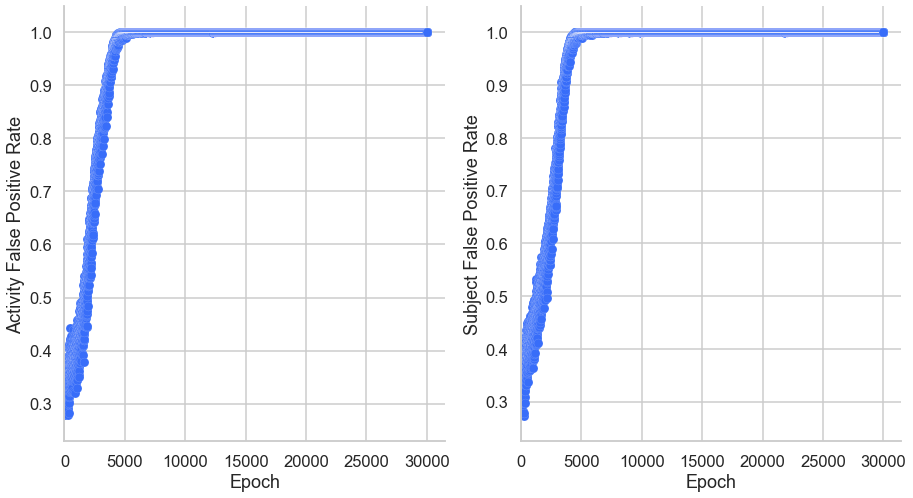

In [26]:
plot_metrics(model_output)